# Import

In [4]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.ensemble import VotingClassifier 
import joblib
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import learning_curve
from sklearn import datasets
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.sparse import csc_matrix
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import h5py
import joblib
from sklearn import model_selection, feature_selection, utils, ensemble, linear_model, metrics, kernel_approximation
import random
import seaborn as sns

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-p7u5zeix because the default path (/home/jovyan/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


# Preprocessing

In [5]:
df = pd.read_csv('/home/s2316001/data/11.csv')

In [6]:
data = pd.DataFrame(df)

In [8]:
data['Label'].value_counts()

Label
flow=Background-UDP-Established                             37342
flow=To-Background-UDP-CVUT-DNS-Server                      30568
flow=Background-TCP-Established                              9363
flow=Background-Established-cmpgw-CVUT                       6981
flow=From-Botnet-V51-1-ICMP                                  4144
flow=From-Botnet-V51-2-ICMP                                  3999
flow=Background-Attempt-cmpgw-CVUT                           3378
flow=Background                                              3230
flow=From-Normal-V52-Grill                                   2113
flow=Background-UDP-Attempt                                  1951
flow=Background-TCP-Attempt                                  1244
flow=To-Background-CVUT-Proxy                                 661
flow=From-Normal-V52-Stribrek                                 581
flow=Background-UDP-NTP-Established-1                         287
flow=To-Background-CVUT-WebServer                             162
flow

In [50]:
data['StartTime'] = pd.to_datetime(df['StartTime']).astype(np.int64)*1e-9

In [51]:
window_width = 120
window_stride = 120
datetime_start = data['StartTime'].min()
data['Window_lower'] = (data['StartTime']-datetime_start-window_width)/window_stride+1
data['Window_lower'].clip(lower=0, inplace=True)
data['Window_upper_excl'] = (data['StartTime']-datetime_start)/window_stride+1
data = data.astype({"Window_lower": int, "Window_upper_excl": int})
data = data.sort_values(by=['StartTime'], ascending=True)
data['Label'] = np.where(data['Label'].str.slice(0, 15) == 'flow=From-Botne', 1, 0)

In [52]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 107251 entries, 32 to 107250
Data columns (total 17 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   StartTime          107251 non-null  float64
 1   Dur                107251 non-null  float64
 2   Proto              107251 non-null  object 
 3   SrcAddr            107251 non-null  object 
 4   Sport              106788 non-null  object 
 5   Dir                107251 non-null  object 
 6   DstAddr            107251 non-null  object 
 7   Dport              99351 non-null   object 
 8   State              107160 non-null  object 
 9   sTos               106271 non-null  float64
 10  dTos               90292 non-null   float64
 11  TotPkts            107251 non-null  int64  
 12  TotBytes           107251 non-null  int64  
 13  SrcBytes           107251 non-null  int64  
 14  Label              107251 non-null  int64  
 15  Window_lower       107251 non-null  int64  
 16  Window

In [53]:
data

StartTime         Dur Proto         SrcAddr  Sport    Dir  \
32      1.313682e+09   83.062141   tcp   147.32.84.202   1078    <?>   
33      1.313682e+09  497.720459   tcp  88.100.184.137  13121    <?>   
34      1.313682e+09  971.288147   tcp     147.32.84.2     80    <?>   
35      1.313682e+09  899.996399   tcp    90.181.84.58  54518    <?>   
36      1.313682e+09   38.753445   tcp   147.32.86.116  19083     ?>   
...              ...         ...   ...             ...    ...    ...   
107246  1.313683e+09    0.000313   udp    147.32.85.25  57375    <->   
107247  1.313683e+09    0.000000   udp    147.32.84.59  63550     ->   
107248  1.313683e+09    0.001958   udp    91.144.30.99  59481    <->   
107249  1.313683e+09    0.000258   udp    147.32.85.25  57012    <->   
107250  1.313683e+09    0.000246   udp    147.32.85.25  52134    <->   

              DstAddr  Dport    State  sTos  dTos  TotPkts   TotBytes  \
32       65.54.89.106     80  RPA_FPA   0.0   0.0    43065   40974671   
33       147.32.85.26  62860   RPA_PA   0.0   0.0   326962  132430976   
34      218.75.208.58   3088     PA_A   0.0   0.0     7912    7356876   
35       147.32.84.19    993    PA_PA   0.0   0.0       48       5728   
36       151.82.9.107   2185     RPA_   0.0   NaN        7        456   
...               ...    ...      ...   ...   ...      ...        ...   
107246    147.32.80.9     53      CON   0.0   0.0        2        207   
107247  110.38.207.12  50613      INT   0.0   NaN        1        145   
107248  147.32.84.229  13363      CON   0.0   0.0        2        522   
107249    147.32.80.9     53      CON   0.0   0.0        2        208   
107250    147.32.80.9     53      CON   0.0   0.0        2        207   

        SrcBytes  Label  Window_lower  Window_upper_excl  
32       1033777      0             0                  1  
33       7076046      0             0                  1  
34       7153650      0             0                  1  
35          3008      0             0                  1  
36           456      0             0                  1  
...          ...    ...           ...                ...  
107246        66      0             7                  9  
107247       145      0             7                  9  
107248       462      0             7                  9  
107249        79      0             7                  9  
107250        66      0             7                  9  

[107251 rows x 17 columns]

In [63]:
# def RU(df):
#     if df.shape[0] == 1:
#         return 1.0
#     else:
#         proba = df.value_counts()/df.shape[0]
#         h = proba*np.log10(proba)
#         return -h.sum()/np.log10(df.shape[0])
    
# nb_windows = data['Window_upper_excl'].max()
# X = pd.DataFrame(data)
# X['Sport_RU'] = 0
# X['DstAddr_RU'] = 0
# X['Dport_RU'] = 0
# for i in range(0, nb_windows):
#     gb = data[(data['Window_lower'] <= i) & (data['Window_upper_excl'] > i)].groupby('SrcAddr', as_index = False, sort = False).agg({'Sport':[RU], 'DstAddr':[RU], 'Dport':[RU]})
#     gb.columns  = ['SrcAddr','Sport_RU','DstAddr_RU','Dport_RU']
#     for index, row in gb.iterrows():
#         X.loc[(X['Window_lower'] <= i) & (X['Window_upper_excl'] > i)&(X['SrcAddr']==row.SrcAddr),'Sport_RU'] = row.Sport_RU
#         X.loc[(X['Window_lower'] <= i) & (X['Window_upper_excl'] > i)&(X['SrcAddr']==row.SrcAddr),'DstAddr_RU']= row.DstAddr_RU
#         X.loc[(X['Window_lower'] <= i) & (X['Window_upper_excl'] > i)&(X['SrcAddr']==row.SrcAddr),'Dport_RU'] = row.Dport_RU
#     print (index)
    # duplicated_data = gb.loc[gb.index.repeat(y)].reset_index(drop=True)
    # grouped_df = X[(X['Window_lower'] <= 0) & (X['Window_upper_excl'] > 0)].groupby('SrcAddr', as_index = False, sort= False).size()
    # grouped_df['Sport_RU'] = duplicated_data['Sport_RU']
    # grouped_df['DstAddr_RU'] = duplicated_data['DstAddr_RU']
    # grouped_df['Dport_RU'] = duplicated_data['Dport_RU']
    # temp = pd.concat([temp,grouped_df])
    # if i == 0:
    #     X = X[(X['Window_lower'] <= i) & (X['Window_upper_excl'] > i)].groupby('SrcAddr', as_index = False, sort = False).merge(gb[['SrcAddr','Sport_RU', 'DstAddr_RU', 'Dport_RU']],on = 'SrcAddr')
    # else:
    #     X[(X['Window_lower'] <= i) & (X['Window_upper_excl'] > i)] = X[gb['SrcAddr']==X['SrcAddr']].replace()

In [24]:
def RU(df):
    if df.shape[0] == 1:
        return 1
    else:
        proba = df.value_counts() / df.shape[0]
        h = proba * np.log2(proba)
        return -h.sum() / np.log2(df.shape[0])

nb_windows = data['Window_upper_excl'].max()
X = pd.DataFrame(data)
X['Sport_RU'] = 0.0
X['DstAddr_RU'] = 0.0
X['Dport_RU'] = 0.0

for i in range(nb_windows):
    window_condition = (X['Window_lower'] <= i) & (X['Window_upper_excl'] > i)
    window_data = X[window_condition]

    gb = window_data.groupby(['SrcAddr']).agg({'Sport': RU, 'DstAddr': RU, 'Dport': RU,'State': RU,'Dir': RU,'sTos': RU,'dTos': RU,'Proto': RU})
    gb.columns = ['Sport_RU', 'DstAddr_RU', 'Dport_RU','State','Dir','sTos','dTos','Proto']

    X.loc[window_condition, 'Sport_RU'] = X.loc[window_condition, 'SrcAddr'].map(gb['Sport_RU'])
    X.loc[window_condition, 'DstAddr_RU'] = X.loc[window_condition, 'SrcAddr'].map(gb['DstAddr_RU'])
    X.loc[window_condition, 'Dport_RU'] = X.loc[window_condition, 'SrcAddr'].map(gb['Dport_RU'])
    X.loc[window_condition, 'State'] = X.loc[window_condition, 'SrcAddr'].map(gb['State'])
    X.loc[window_condition, 'Dir'] = X.loc[window_condition, 'SrcAddr'].map(gb['Dir'])
    X.loc[window_condition, 'sTos'] = X.loc[window_condition, 'SrcAddr'].map(gb['sTos'])
    X.loc[window_condition, 'dTos'] = X.loc[window_condition, 'SrcAddr'].map(gb['dTos'])
    X.loc[window_condition, 'Proto'] = X.loc[window_condition, 'SrcAddr'].map(gb['Proto'])
    print(i)


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

KeyboardInterrupt: 

In [91]:
X.drop(['StartTime','SrcAddr','Sport','Dir','Dport','DstAddr','Window_lower','Window_upper_excl'],axis=1,inplace=True)

In [96]:
def normalize_column(dt, column):
    mean = dt[column].mean()
    std = dt[column].std()
    print(mean, std)

    dt[column] = (dt[column]-mean) / std
columns_to_normalize = list(X.drop('Label',axis=1).columns.values)

In [98]:
normalize_column(X, columns_to_normalize)

Dur             49.906932
Proto             0.34502
State            0.345036
sTos             0.296905
dTos              0.33292
TotPkts         40.975487
TotBytes      31777.83823
SrcBytes      3251.468686
Sport_RU         0.838301
DstAddr_RU        0.53789
Dport_RU         0.492286
dtype: object Dur               169.009213
Proto               0.413302
State               0.413265
sTos                0.441888
dTos                 0.42021
TotPkts          2808.167448
TotBytes      2646017.668942
SrcBytes        150354.95439
Sport_RU            0.322467
DstAddr_RU          0.427212
Dport_RU            0.436018
dtype: object


In [99]:
X

Dur     Proto     State      sTos      dTos     TotPkts  \
32      0.196174  -0.83479  0.374975 -0.671902  -0.79227   15.321032   
33       2.64964  1.584751  1.584852  1.591116  1.587492  116.417924   
34      5.451663 -0.259732 -0.259793 -0.134045  -0.79227    2.802904   
35      5.029841  1.584751  1.584852  1.591116  1.587492    0.002501   
36     -0.065993  -0.57501 -0.575098 -0.671902  -0.53676   -0.012099   
...          ...       ...       ...       ...       ...         ...   
107246 -0.295289  -0.83479 -0.834901 -0.671902  -0.79227   -0.013879   
107247 -0.295291  -0.83479 -0.834901 -0.671902  -0.79227   -0.014235   
107248  -0.29528  1.584751  1.584852  1.591116  1.587492   -0.013879   
107249  -0.29529  -0.83479 -0.834901 -0.671902  -0.79227   -0.013879   
107250  -0.29529  -0.83479 -0.834901 -0.671902  -0.79227   -0.013879   

         TotBytes   SrcBytes  Label  Sport_RU DstAddr_RU  Dport_RU  
32      15.473401   6.853951      0  0.501444   0.496499 -1.129051  
33      50.037156  47.040648      0  0.501444   1.081689  1.164434  
34       2.768348  47.556787      0  0.418813  -0.322278 -0.295357  
35      -0.009845  -0.001619      0  0.501444   1.081689  1.164434  
36      -0.011837  -0.018592      0 -2.367052    1.03371  1.092725  
...           ...        ...    ...       ...        ...       ...  
107246  -0.011931  -0.021186      0  0.501444   -1.25907 -1.129051  
107247  -0.011955  -0.020661      0 -0.221287   0.202753  0.075011  
107248  -0.011812  -0.018553      0  0.501444   1.081689  1.164434  
107249  -0.011931    -0.0211      0  0.501444   -1.25907 -1.129051  
107250  -0.011931  -0.021186      0  0.501444   -1.25907 -1.129051  

[107251 rows x 12 columns]

In [62]:
X.to_csv('/home/s2316001/Clean_data/Clean_1.csv', encoding='utf-8')

In [63]:
X = pd.read_csv('/home/s2316001/Clean_data/Clean_1.csv')

In [64]:
X.drop(columns=X.columns[0], axis=1, inplace=True)

In [65]:
# Create dummy variables for the 'Color' column
dummies = pd.get_dummies(X['State'], dtype = int)

# Concatenate the original DataFrame with the dummy variables
merged_df2 = pd.concat([X, dummies], axis=1)

In [66]:
# Create dummy variables for the 'Color' column
dummies = pd.get_dummies(merged_df2['Dir'], dtype = int)

# Concatenate the original DataFrame with the dummy variables
merged_df3 = pd.concat([merged_df2, dummies], axis=1)

In [67]:
# Create dummy variables for the 'Color' column
dummies = pd.get_dummies(merged_df3['Proto'], dtype = int)

# Concatenate the original DataFrame with the dummy variables
merged_df4 = pd.concat([merged_df3, dummies], axis=1)

In [68]:
merged_df4.drop(['StartTime','State','Dir','Proto','SrcAddr','Sport','DstAddr','Dport'],inplace=True,axis=1)

In [70]:
merged_df4

Dur  sTos  dTos  TotPkts  TotBytes  SrcBytes  Label  \
0        3550.182373   0.0   0.0       12       875       413      0   
1           0.000883   0.0   0.0        2       135        75      0   
2           0.000326   0.0   0.0        2       120        60      0   
3           0.056966   0.0   0.0        3       180       120      0   
4        3427.768066   0.0   0.0       42      2856      1596      0   
...              ...   ...   ...      ...       ...       ...    ...   
2824631     0.000393   0.0   0.0        2       208        79      0   
2824632     0.000935   0.0   0.0        2       539        75      0   
2824633     0.000000   0.0   NaN        1        74        74      0   
2824634     0.002618   0.0   0.0        2       520       460      0   
2824635     0.001122   0.0   0.0        2       137        77      0   

         Window_lower  Window_upper_excl  Sport_RU  ...  ipv6-icmp  ipx/spx  \
0                   0                  1  1.000000  ...          0        0   
1                   0                  1  1.000000  ...          0        0   
2                   0                  1  1.000000  ...          0        0   
3                   0                  1  1.000000  ...          0        0   
4                   0                  1  1.000000  ...          0        0   
...               ...                ...       ...  ...        ...      ...   
2824631           366                368  0.655459  ...          0        0   
2824632           366                368  1.000000  ...          0        0   
2824633           366                368  1.000000  ...          0        0   
2824634           366                368  1.000000  ...          0        0   
2824635           366                368  1.000000  ...          0        0   

         pim  rarp  rtcp  rtp  tcp  udp  udt  unas  
0          0     0     0    0    0    1    0     0  
1          0     0     0    0    0    1    0     0  
2          0     0     0    0    1    0    0     0  
3          0     0     0    0    1    0    0     0  
4          0     0     0    0    0    1    0     0  
...      ...   ...   ...  ...  ...  ...  ...   ...  
2824631    0     0     0    0    0    1    0     0  
2824632    0     0     0    0    0    1    0     0  
2824633    0     0     0    0    1    0    0     0  
2824634    0     0     0    0    0    1    0     0  
2824635    0     0     0    0    0    1    0     0  

[2824636 rows x 264 columns]

In [71]:
X['Label'].value_counts()

Label
0    2783675
1      40961
Name: count, dtype: int64

In [72]:
merged_df4['Label'].value_counts()

Label
0    2783675
1      40961
Name: count, dtype: int64

In [73]:
merged_df4.to_csv('/home/s2316001/Clean_data/Clean_1-test.csv', encoding='utf-8')

# Test


In [5]:
test = pd.read_csv('/home/s2316001/Clean_data/Clean_11-test.csv')

In [6]:
X = test.drop(['StartTime','Label','Window_lower','Window_upper_excl'], axis = 1)
#X = merged_df4.drop(['dTos','sTos','Label'], axis = 1)
y = test.Label
X.drop(columns=X.columns[0], axis=1, inplace=True)

## No undersampled

/home/s2316001/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/s2316001/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check

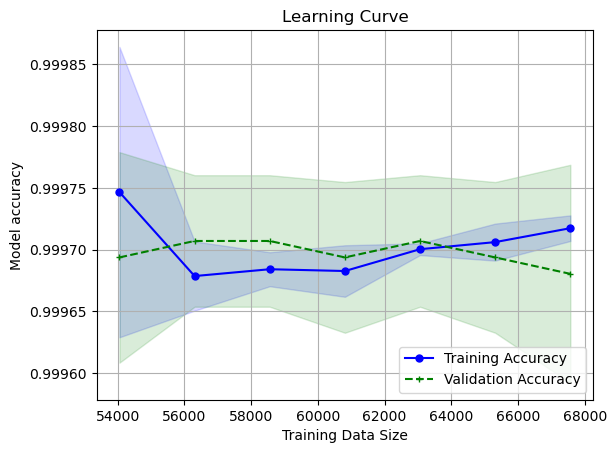

In [80]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import learning_curve
from sklearn import datasets
import matplotlib.pyplot as plt
#Create training and test split
#
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,shuffle=False)
#
# Create a pipeline; This will be passed as an estimator to learning curve method
#
pipeline = LogisticRegression(penalty='l2', solver='lbfgs', random_state=42, max_iter=10000)
#
# Use learning curve to get training and test scores along with train sizes
#
train_sizes, train_scores, test_scores = learning_curve(estimator=pipeline, X=X_train, y=y_train,
                                                       cv=10, train_sizes=np.linspace(0.7, 1.0, 10),
                                                     n_jobs=-1)
#
# Calculate training and test mean and std
#
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)
#
# Plot the learning curve
#
plt.plot(train_sizes, train_mean, color='blue', marker='o', markersize=5, label='Training Accuracy')
plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std, alpha=0.15, color='blue')
plt.plot(train_sizes, test_mean, color='green', marker='+', markersize=5, linestyle='--', label='Validation Accuracy')
plt.fill_between(train_sizes, test_mean + test_std, test_mean - test_std, alpha=0.15, color='green')
plt.title('Learning Curve')
plt.xlabel('Training Data Size')
plt.ylabel('Model accuracy')
plt.grid()
plt.legend(loc='lower right')
plt.show()

In [7]:
import numpy as np
import pandas as pd
from scipy.sparse import csc_matrix
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import h5py
import joblib
from sklearn import model_selection, feature_selection, utils, ensemble, linear_model, metrics, kernel_approximation
import random
import seaborn as sns
clf = LogisticRegression(C=0.01,penalty='l2', solver='lbfgs',random_state=42, max_iter=1000)
#clf = linear_model.LogisticRegressionCV(penalty='l2', solver='lbfgs',random_state=42, max_iter=1000,cv=10).fit(X, y)
# Define custom scoring metrics
y_pred = cross_val_predict(clf, X, y, cv=10,n_jobs=-1)
precision, recall, fbeta_score, support = metrics.precision_recall_fscore_support(y, y_pred)
accuracy =  metrics.accuracy_score(y, y_pred)
print("Test")
print("precision = ",precision[1])
print("recall = ", recall[1])
print("fbeta_score = ", fbeta_score[1])
print("accuracy_score = ", accuracy)
matrix = metrics.confusion_matrix(y, y_pred)
#print(matrix)
# Plot Confusion Matrix
plt.figure(figsize=(10, 8))
sns.heatmap(matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')

plt.show()

/home/s2316001/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


KeyboardInterrupt: 

## Undersampled

In [16]:
from imblearn.under_sampling import RandomUnderSampler
import numpy as np
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,shuffle=False)
def undersample(X, y, ratio, random_state=42):
    # Create the RandomUnderSampler object
    undersampler = RandomUnderSampler(sampling_strategy=ratio, random_state=random_state)

    # Perform the undersampling
    X_undersampled, y_undersampled = undersampler.fit_resample(X, y)

    return X_undersampled, y_undersampled

X_undersampled, y_undersampled = undersample(X, y, ratio=0.5, random_state=42)

print("Original dataset shape:", X.shape, y.shape)
print("Undersampled dataset shape:", X_undersampled.shape, y_undersampled.shape)

Original dataset shape: (107251, 201) (107251,)
Undersampled dataset shape: (24492, 201) (24492,)


In [17]:
y_undersampled.value_counts()

Label
0    16328
1     8164
Name: count, dtype: int64

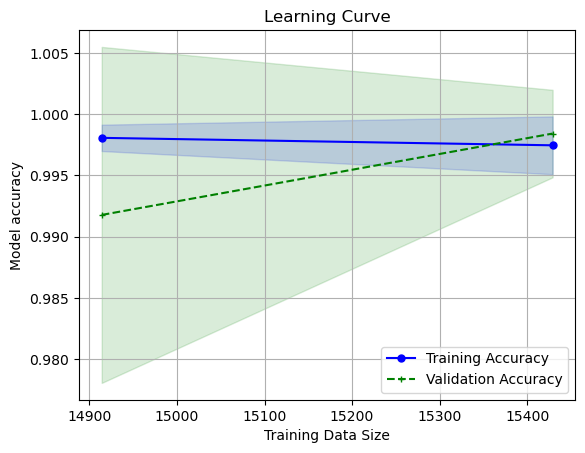

In [18]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import learning_curve
from sklearn import datasets
import matplotlib.pyplot as plt
#Create training and test split
#
X_train, X_test, y_train, y_test = train_test_split(X_undersampled, y_undersampled, test_size=0.3,shuffle=False)
#
# Create a pipeline; This will be passed as an estimator to learning curve method
#
pipeline = LogisticRegression(penalty='l2', solver='lbfgs', random_state=42, max_iter=1000)
#
# Use learning curve to get training and test scores along with train sizes
#
train_sizes, train_scores, test_scores = learning_curve(estimator=pipeline, X=X_train, y=y_train,
                                                       cv=10, train_sizes=np.linspace(0.7, 1.0, 10),
                                                     n_jobs=-1)
#
# Calculate training and test mean and std
#
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)
#
# Plot the learning curve
#
plt.plot(train_sizes, train_mean, color='blue', marker='o', markersize=5, label='Training Accuracy')
plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std, alpha=0.15, color='blue')
plt.plot(train_sizes, test_mean, color='green', marker='+', markersize=5, linestyle='--', label='Validation Accuracy')
plt.fill_between(train_sizes, test_mean + test_std, test_mean - test_std, alpha=0.15, color='green')
plt.title('Learning Curve')
plt.xlabel('Training Data Size')
plt.ylabel('Model accuracy')
plt.grid()
plt.legend(loc='lower right')
plt.show()

In [27]:
import numpy as np
import pandas as pd
from scipy.sparse import csc_matrix
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import h5py
import joblib
from sklearn import model_selection, feature_selection, utils, ensemble, linear_model, metrics, kernel_approximation
from sklearn.model_selection import cross_validate,cross_val_predict,cross_val_score
from sklearn.metrics import make_scorer, accuracy_score,precision_score,recall_score,f1_score
import random
import seaborn as sns
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,shuffle=False)
clf = LogisticRegression(penalty='l2', solver='lbfgs', random_state=42, max_iter=1000)
# Define custom scoring metrics
scoring = {
    'accuracy': make_scorer(accuracy_score),
    'precision': make_scorer(precision_score, average='weighted'),
    'recall': make_scorer(recall_score, average='weighted'),
    'f1_score': make_scorer(f1_score, average='macro')
}
cv_results = cross_validate(clf, X, y, cv=50, scoring=scoring,n_jobs=-1,return_train_score=True,return_estimator=True)
# y_pred_train = clf.predict(X_train)
# precision, recall, fbeta_score, support = metrics.precision_recall_fscore_support(y_train, y_pred_train)
# accuracy = metrics.accuracy_score(y_train, y_pred_train)
# print("Train")
# print("precision = ",precision[1])
# print("recall = ", recall[1])
# print("fbeta_score = ", fbeta_score[1])
# print("accuracy_score = ", accuracy)
# y_pred_test = clf.predict(X_test)
# precision, recall, fbeta_score, support = metrics.precision_recall_fscore_support(y_test, y_pred_test)
# accuracy =  metrics.accuracy_score(y_test, y_pred_test)
# print("Test")
# print("precision = ",precision[1])
# print("recall = ", recall[1])
# print("fbeta_score = ", fbeta_score[1])
# print("accuracy_score = ", accuracy)
# matrix = metrics.confusion_matrix(y_test, y_pred_test)
# #print(matrix)
# # Plot Confusion Matrix
# plt.figure(figsize=(10, 8))
# sns.heatmap(matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
# plt.title('Confusion Matrix')
# plt.xlabel('Predicted Labels')
# plt.ylabel('True Labels')

# plt.show()

In [31]:
cv_results.keys()

dict_keys(['fit_time', 'score_time', 'estimator', 'test_accuracy', 'train_accuracy', 'test_precision', 'train_precision', 'test_recall', 'train_recall', 'test_f1_score', 'train_f1_score'])

In [34]:
print("precision = ", cv_results['test_precision'].mean(),cv_results['test_precision'].std())
print("recall = ", cv_results['test_recall'].mean(),cv_results['test_recall'].std())
print("f1 = ", cv_results['test_f1_score'].mean(),cv_results['test_f1_score'].std())
print("acc = ", cv_results['test_accuracy'].mean(),cv_results['test_accuracy'].std())

precision =  0.9997029629049589 0.0014443808186947258
recall =  0.9997017272879342 0.0014490994714779972
f1 =  0.9988998199875597 0.005430476523645179
acc =  0.9997017272879342 0.0014490994714779972


In [29]:
final = pd.DataFrame(cv_results)
final

fit_time  score_time                                          estimator  \
0   68.992775    0.017032  LogisticRegression(max_iter=1000, random_state...   
1   36.791167    0.016597  LogisticRegression(max_iter=1000, random_state...   
2   40.418354    0.030766  LogisticRegression(max_iter=1000, random_state...   
3   44.279781    0.015584  LogisticRegression(max_iter=1000, random_state...   
4   21.315606    0.019276  LogisticRegression(max_iter=1000, random_state...   
5   46.078478    0.025106  LogisticRegression(max_iter=1000, random_state...   
6   45.238162    0.027549  LogisticRegression(max_iter=1000, random_state...   
7   24.579868    0.015707  LogisticRegression(max_iter=1000, random_state...   
8   16.725978    0.023344  LogisticRegression(max_iter=1000, random_state...   
9   47.941498    0.018416  LogisticRegression(max_iter=1000, random_state...   
10  28.844640    0.014903  LogisticRegression(max_iter=1000, random_state...   
11  49.778544    0.016383  LogisticRegression(max_iter=1000, random_state...   
12  45.365789    0.023113  LogisticRegression(max_iter=1000, random_state...   
13  10.663051    0.021550  LogisticRegression(max_iter=1000, random_state...   
14  50.422470    0.016915  LogisticRegression(max_iter=1000, random_state...   
15  26.513844    0.013080  LogisticRegression(max_iter=1000, random_state...   
16  27.397350    0.014950  LogisticRegression(max_iter=1000, random_state...   
17  17.486142    0.018373  LogisticRegression(max_iter=1000, random_state...   
18  17.255001    0.021861  LogisticRegression(max_iter=1000, random_state...   
19  42.373192    0.026084  LogisticRegression(max_iter=1000, random_state...   
20  23.590731    0.021593  LogisticRegression(max_iter=1000, random_state...   
21  24.253068    0.015271  LogisticRegression(max_iter=1000, random_state...   
22  24.523450    0.020194  LogisticRegression(max_iter=1000, random_state...   
23  40.437504    0.029197  LogisticRegression(max_iter=1000, random_state...   
24  22.188928    0.016212  LogisticRegression(max_iter=1000, random_state...   
25  16.061849    0.013899  LogisticRegression(max_iter=1000, random_state...   
26  25.126257    0.014735  LogisticRegression(max_iter=1000, random_state...   
27  30.601811    0.016011  LogisticRegression(max_iter=1000, random_state...   
28  15.795491    0.016399  LogisticRegression(max_iter=1000, random_state...   
29  14.837945    0.013904  LogisticRegression(max_iter=1000, random_state...   
30  23.157058    0.015481  LogisticRegression(max_iter=1000, random_state...   
31  17.182004    0.017484  LogisticRegression(max_iter=1000, random_state...   
32  18.349590    0.015093  LogisticRegression(max_iter=1000, random_state...   
33  14.350945    0.019164  LogisticRegression(max_iter=1000, random_state...   
34  37.334004    0.014895  LogisticRegression(max_iter=1000, random_state...   
35  22.130580    0.016314  LogisticRegression(max_iter=1000, random_state...   
36  19.621257    0.021005  LogisticRegression(max_iter=1000, random_state...   
37  29.323584    0.018944  LogisticRegression(max_iter=1000, random_state...   
38  18.058020    0.014936  LogisticRegression(max_iter=1000, random_state...   
39  34.294056    0.011491  LogisticRegression(max_iter=1000, random_state...   
40  14.724253    0.014970  LogisticRegression(max_iter=1000, random_state...   
41  11.970452    0.013826  LogisticRegression(max_iter=1000, random_state...   
42  28.056108    0.022028  LogisticRegression(max_iter=1000, random_state...   
43  20.758604    0.021074  LogisticRegression(max_iter=1000, random_state...   
44  26.490967    0.023006  LogisticRegression(max_iter=1000, random_state...   
45  28.843105    0.016344  LogisticRegression(max_iter=1000, random_state...   
46  33.610374    0.011129  LogisticRegression(max_iter=1000, random_state...   
47  31.581346    0.018902  LogisticRegression(max_iter=1000, random_state...   
48  16.940306    0.017121  LogisticRegression(max_iter=1000, random_state...   
49  1

Test
precision =  0.9988652124574454
recall =  0.9703576678098971
fbeta_score =  0.9844050947499223
accuracy_score =  0.9897517556753226


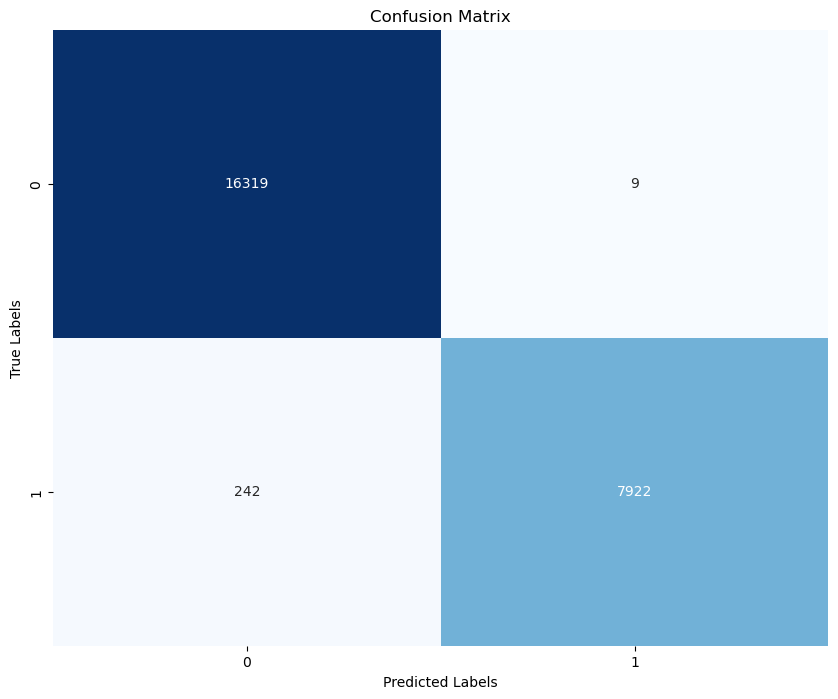

In [84]:
clf = LogisticRegression(C=0.01,penalty='l2', solver='lbfgs',random_state=42, max_iter=1000)
# Define custom scoring metrics
y_pred = cross_val_predict(clf, X_undersampled, y_undersampled, cv=10,n_jobs=-1)
precision, recall, fbeta_score, support = metrics.precision_recall_fscore_support(y_undersampled, y_pred)
accuracy =  metrics.accuracy_score(y_undersampled, y_pred)
print("Test")
print("precision = ",precision[1])
print("recall = ", recall[1])
print("fbeta_score = ", fbeta_score[1])
print("accuracy_score = ", accuracy)
matrix = metrics.confusion_matrix(y_undersampled, y_pred)
#print(matrix)
# Plot Confusion Matrix
plt.figure(figsize=(10, 8))
sns.heatmap(matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')

plt.show()

## HyperParameter Tuning

In [27]:
from sklearn.datasets import make_blobs
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
# define dataset
refit_score='precision_score'
# define models and parameters
model = LogisticRegression()
solvers = ['newton-cg', 'lbfgs', 'liblinear']
penalty = ['l2']
c_values = [100, 10, 1.0, 0.1, 0.01]
para=[{'max_iter':[1,10,100,100,1000,10000}]
# define grid search
grid = dict(solver=solvers,penalty=penalty,C=c_values)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring=scoring,error_score=0,refit='recall')
grid_result = grid_search.fit(X, y)
# summarize results
print("Best: using %s" % ( grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

/home/s2316001/.local/lib/python3.10/site-packages/scipy/optimize/_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/home/s2316001/.local/lib/python3.10/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
/home/s2316001/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/s2316001/.local/lib/python3.10/site-packages/scipy/optimize/_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/home/s2316001/.local/lib/python3.10/site-packages/sklearn/utils/optimize.py:203: UserWarning: Lin

Best: using {'C': 0.01, 'penalty': 'l2', 'solver': 'lbfgs'}


/home/s2316001/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


KeyError: 'mean_test_score'

In [39]:
results = pd.DataFrame(grid_result.cv_results_)
results = results.sort_values(by='mean_test_recall', ascending=False)

In [40]:
results.head(5)

mean_fit_time  std_fit_time  mean_score_time  std_score_time param_C  \
13      17.676195      3.252672         0.021710        0.003955    0.01   
7       31.350445      4.121614         0.053905        0.023671     1.0   
4       32.754857      6.124852         0.057153        0.024271      10   
1       30.291265      4.736881         0.063781        0.026222     100   
10      24.563325      3.661087         0.030050        0.009340     0.1   

   param_penalty param_solver  \
13            l2        lbfgs   
7             l2        lbfgs   
4             l2        lbfgs   
1             l2        lbfgs   
10            l2        lbfgs   

                                             params  split0_test_accuracy  \
13  {'C': 0.01, 'penalty': 'l2', 'solver': 'lbfgs'}              0.999347   
7    {'C': 1.0, 'penalty': 'l2', 'solver': 'lbfgs'}              0.999347   
4     {'C': 10, 'penalty': 'l2', 'solver': 'lbfgs'}              0.999347   
1    {'C': 100, 'penalty': 'l2', 'solver': 'lbfgs'}              0.999347   
10   {'C': 0.1, 'penalty': 'l2', 'solver': 'lbfgs'}              0.999347   

    split1_test_accuracy  ...  split23_test_f1_score  split24_test_f1_score  \
13              0.999814  ...               0.999338               0.998672   
7               0.999068  ...               0.999338               0.998339   
4               0.999814  ...               0.999338               0.998341   
1               0.999814  ...               0.999338               0.998672   
10              0.999814  ...               0.998674               0.998672   

    split25_test_f1_score  split26_test_f1_score  split27_test_f1_score  \
13               0.999668               0.997000               0.999337   
7                0.999668               0.998337               0.999337   
4                0.998345               0.997000               0.999337   
1                0.999668               0.991592               0.998672   
10               0.999668               0.998337               0.999337   

    split28_test_f1_score  split29_test_f1_score  mean_test_f1_score  \
13               0.999669               0.999005            0.998927   
7                0.999669               0.999005            0.998917   
4                0.999669               0.998674            0.998861   
1                0.999005               0.998674            0.998691   
10               0.999669               0.998674            0.998646   

    std_test_f1_score  rank_test_f1_score  
13           0.000646                   1  
7            0.000710                   2  
4            0.000657                   3  
1            0.001419                   4  
10           0.001710                   5  

[5 rows x 140 columns]

# Model Creation


Model 1 Accuracy: 1.0
Model 1 precesion: 1.0
Model 1 recall: 1.0
Model 1 fbeta_score: 1.0


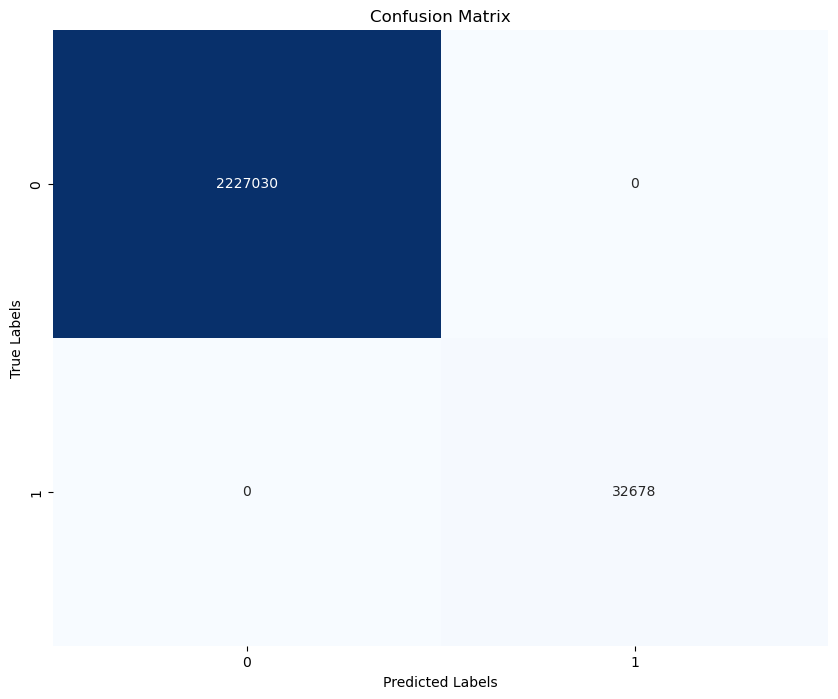

Model 2 Accuracy: 1.0
Model 2 precesion: 1.0
Model 2 recall: 1.0
Model 2 fbeta_score: 1.0


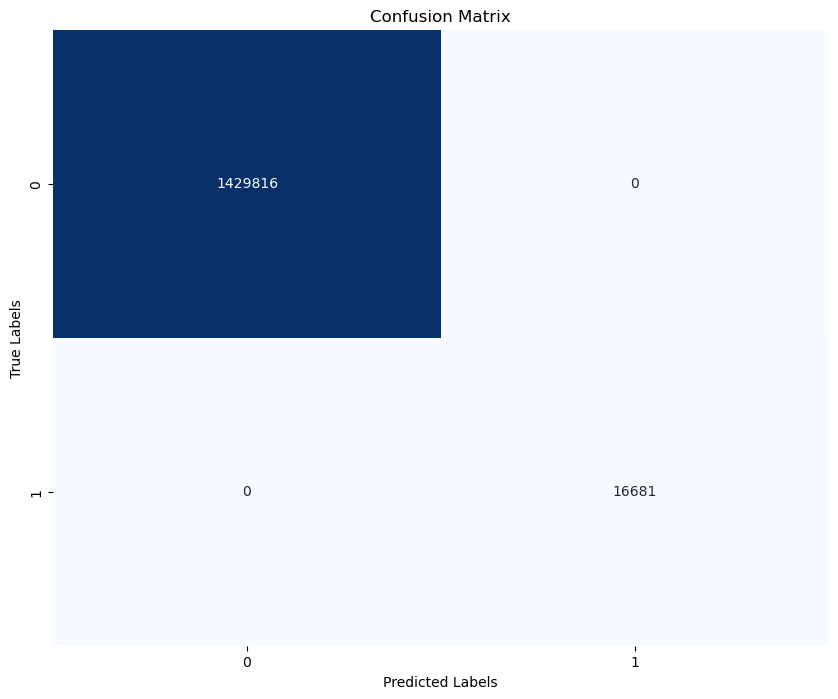

Model 3 Accuracy: 0.9999976117882133
Model 3 precesion: 0.9999068120398844
Model 3 recall: 0.9996739181068617
Model 3 fbeta_score: 0.9997903515106338


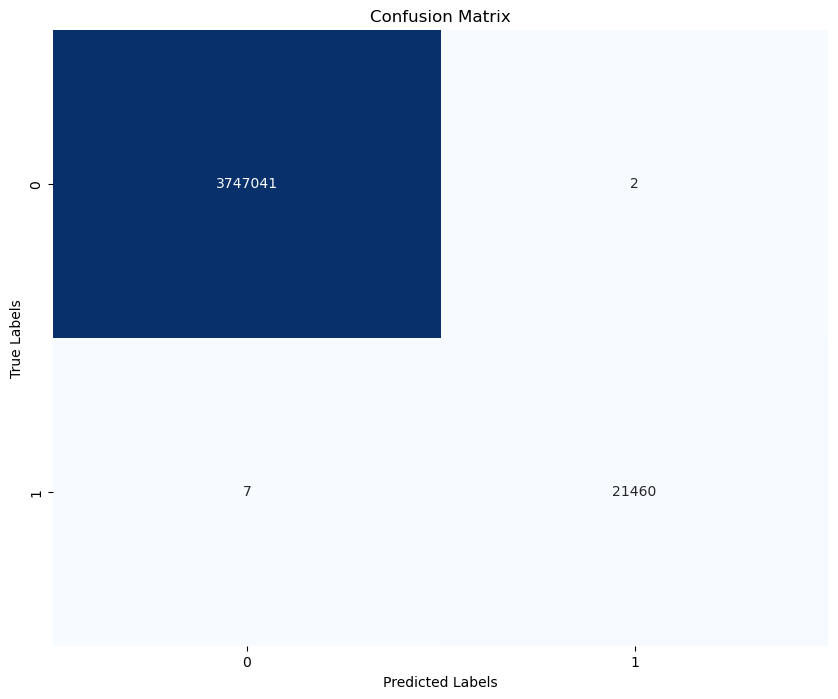

Model 4 Accuracy: 0.9999230649153714
Model 4 precesion: 1.0
Model 4 recall: 0.9660766961651918
Model 4 fbeta_score: 0.9827456864216053


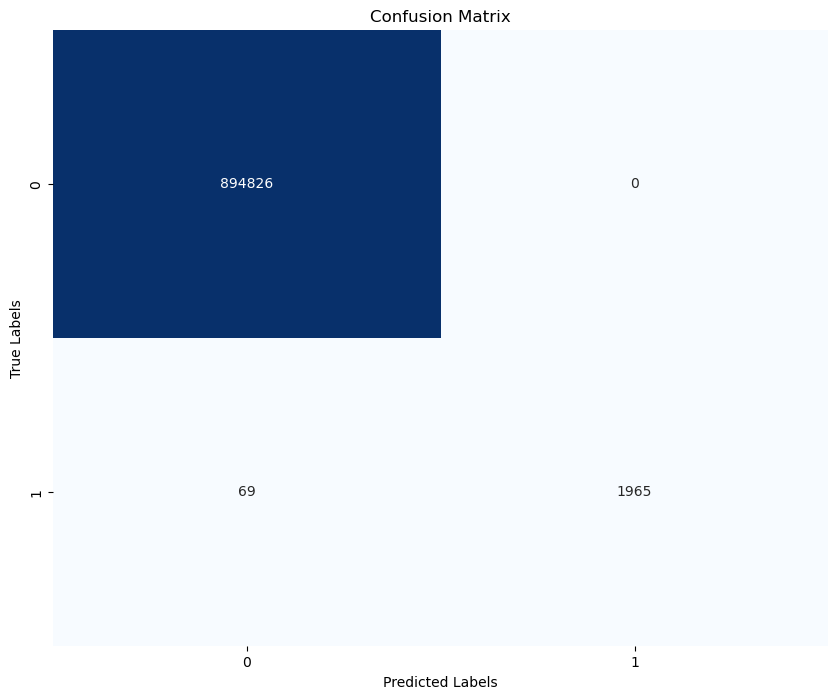

Model 5 Accuracy: 1.0
Model 5 precesion: 1.0
Model 5 recall: 1.0
Model 5 fbeta_score: 1.0


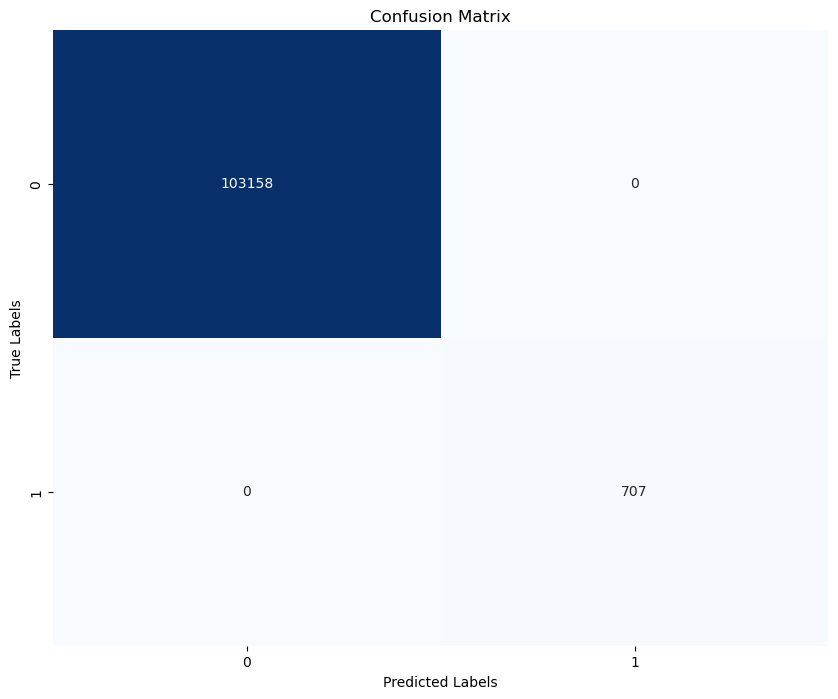

Model 6 Accuracy: 1.0
Model 6 precesion: 1.0
Model 6 recall: 1.0
Model 6 fbeta_score: 1.0


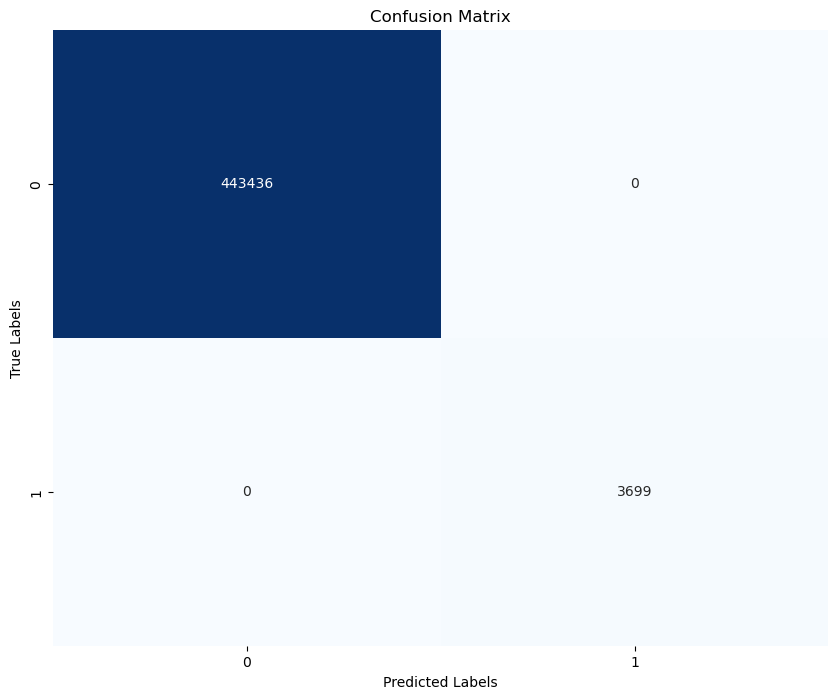

Model 7 Accuracy: 1.0
Model 7 precesion: 1.0
Model 7 recall: 1.0
Model 7 fbeta_score: 1.0


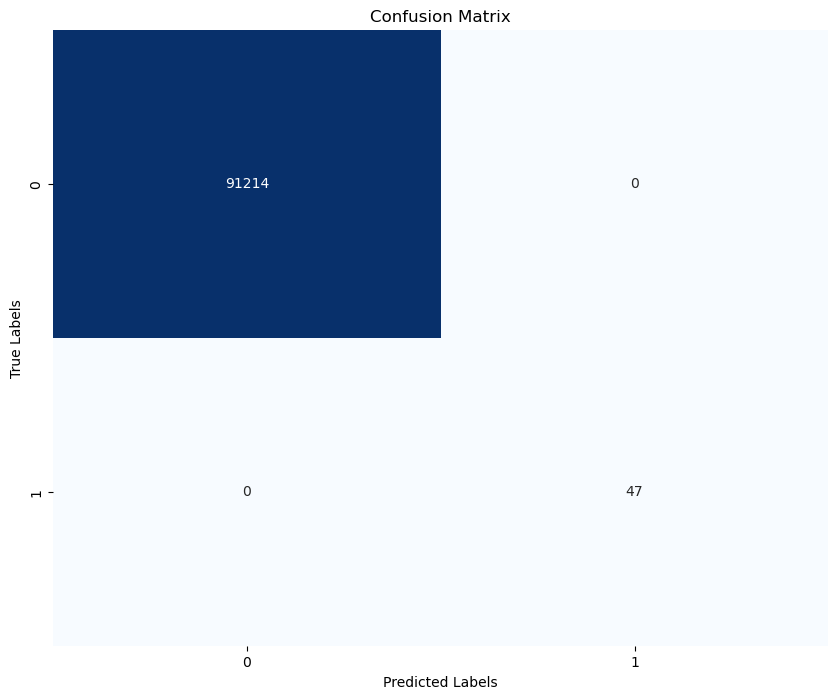

Model 8 Accuracy: 0.9999466866154633
Model 8 precesion: 1.0
Model 8 recall: 0.9743014480930042
Model 8 fbeta_score: 0.9869834710743802


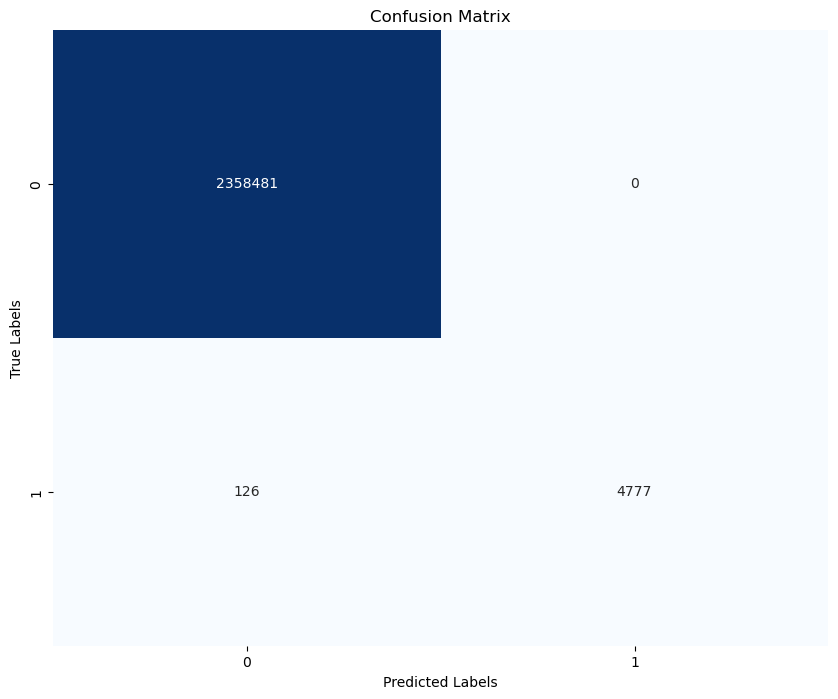

Model 9 Accuracy: 0.9999982035992685
Model 9 precesion: 1.0
Model 9 recall: 0.9999797324685853
Model 9 fbeta_score: 0.9999898661315983


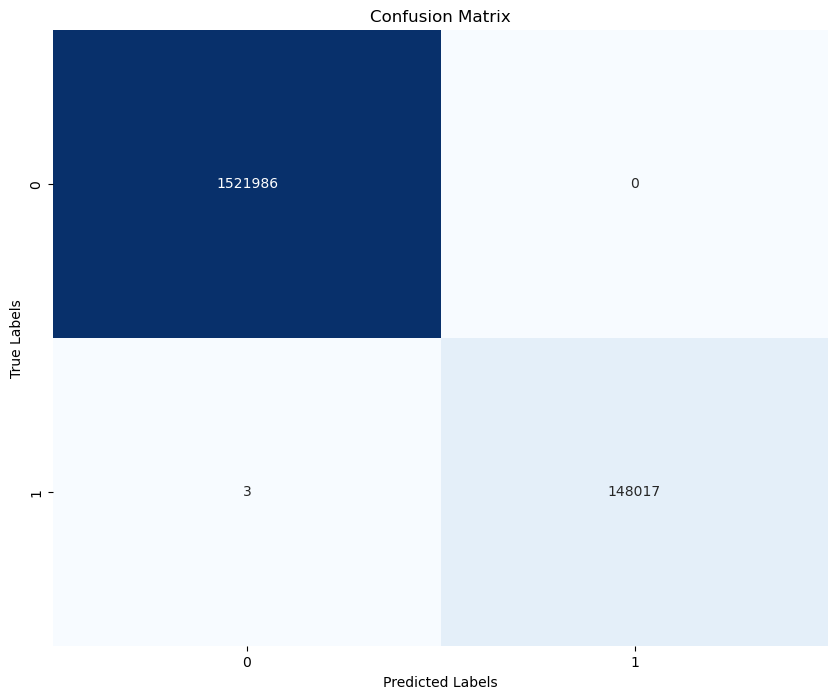

Model 10 Accuracy: 0.9999914108368517
Model 10 precesion: 0.9999764946466557
Model 10 recall: 0.9999177360974004
Model 10 fbeta_score: 0.9999471145088407


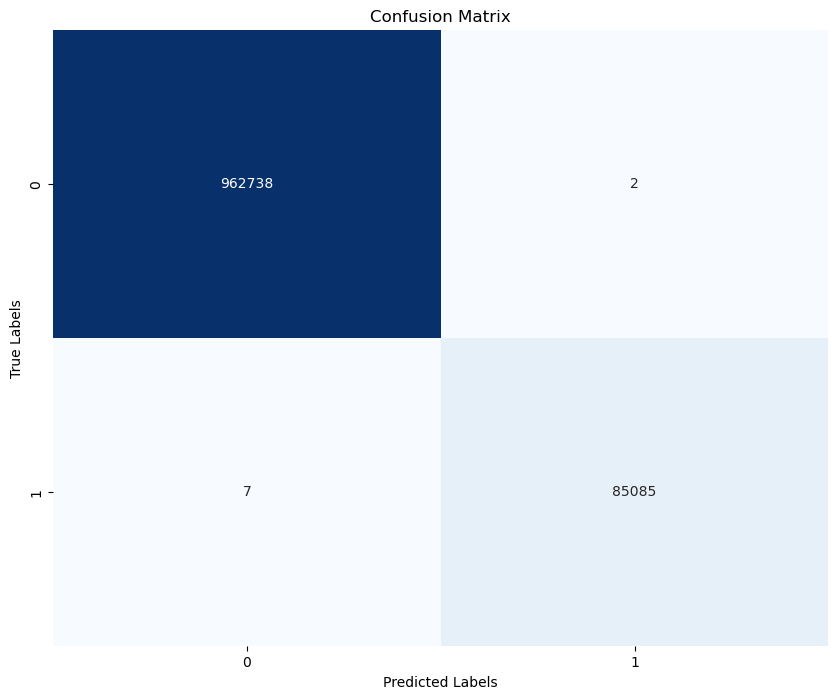

Model 11 Accuracy: 1.0
Model 11 precesion: 1.0
Model 11 recall: 1.0
Model 11 fbeta_score: 1.0


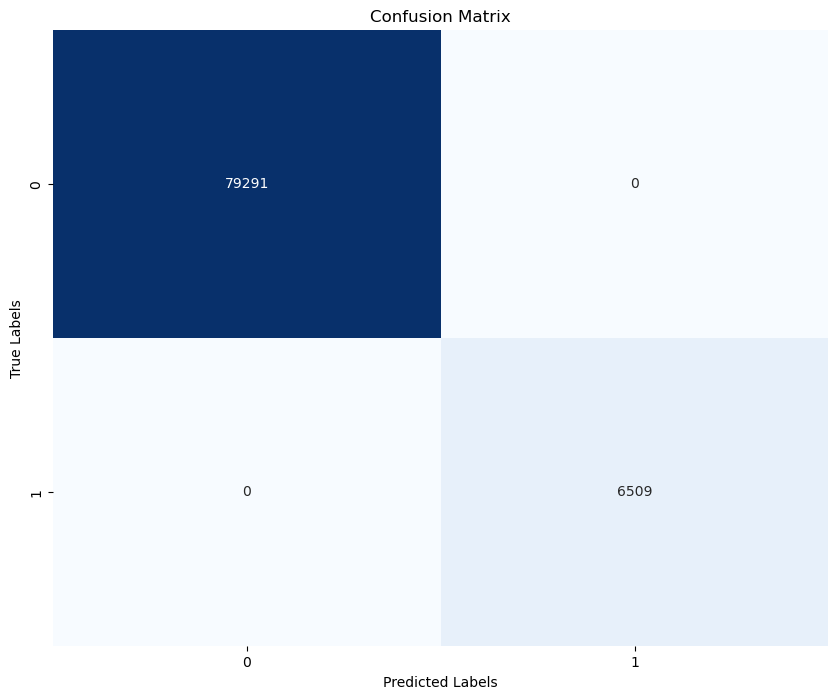

Model 12 Accuracy: 0.9999769564015116
Model 12 precesion: 1.0
Model 12 recall: 0.9965986394557823
Model 12 fbeta_score: 0.9982964224872232


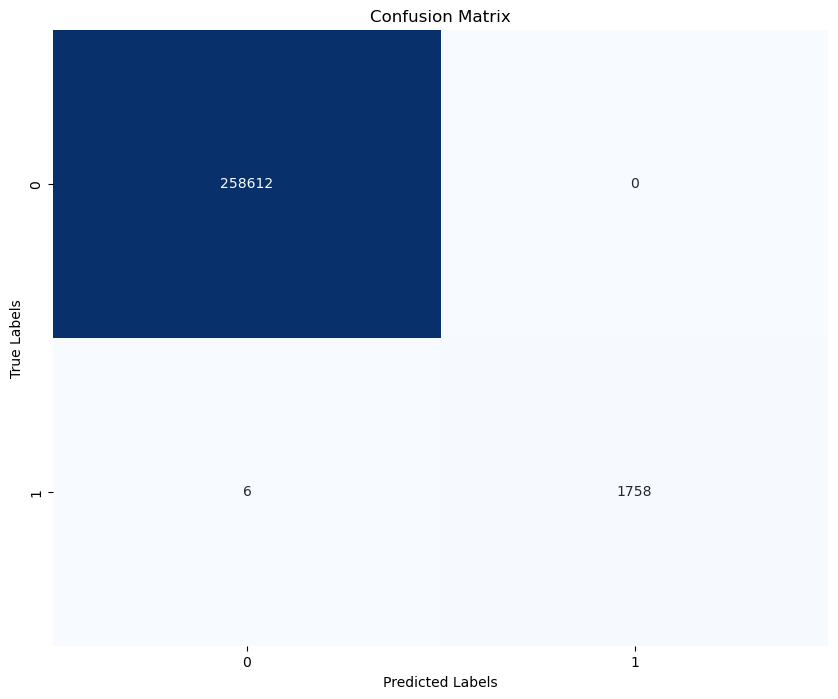

Model 13 Accuracy: 1.0
Model 13 precesion: 1.0
Model 13 recall: 1.0
Model 13 fbeta_score: 1.0


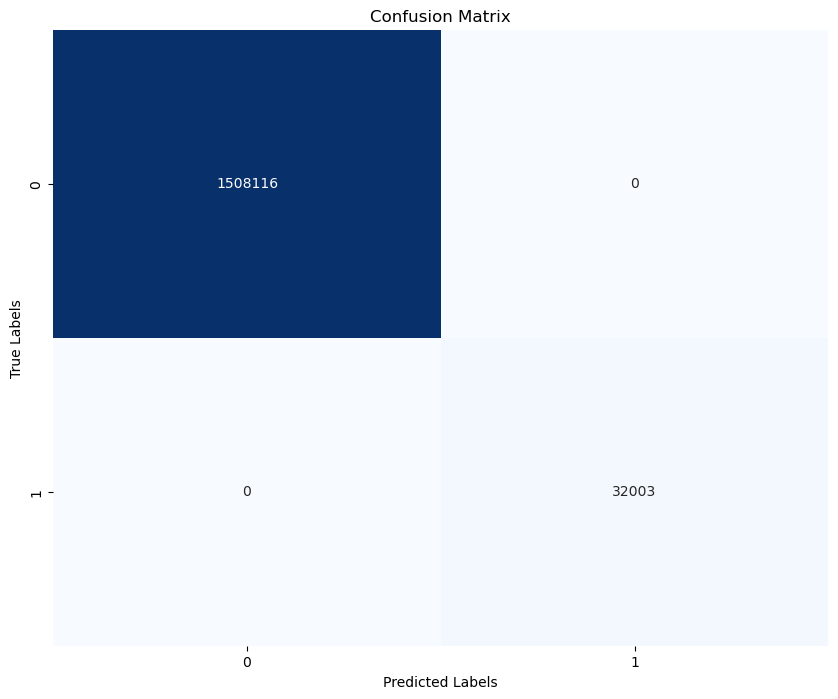

In [7]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.ensemble import VotingClassifier 
import joblib
# List of file paths for training datasets
file_paths = []
for i in range (1,14):
    file = f"/home/s2316001/Clean_data/Clean_{i}-XX.csv"
    file_paths.append(file)
    
# Train multiple Random Forest models
num_models = len(file_paths)
models = []
for i, file_path in enumerate(file_paths):
    dataset = pd.read_csv(file_path)
    
    # Preprocess the dataset
    # Apply necessary preprocessing steps such as handling missing values, encoding categorical variables, etc.
    
    X = dataset.drop('Label', axis=1)  # Features
    X.drop(columns=X.columns[0], axis=1, inplace=True)
    y = dataset["Label"]  # Target variable
    
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)
    temp_1 = pd.concat([X_train,y_train],axis=1)
    temp_1.to_csv(f'/home/s2316001/Clean_data/train{i+1}.csv', encoding='utf-8')
    temp = pd.concat([X_val,y_val],axis=1)
    temp.to_csv(f'/home/s2316001/Clean_data/test{i+1}.csv', encoding='utf-8')
    model = RandomForestClassifier(n_estimators=100)  # You can adjust the hyperparameters as needed
    model.fit(X_train, y_train)
    filename = f'/home/s2316001/model_rfe/rfe_model{i+1}.sav'
    joblib.dump(model, filename)
    models.append(model)
    
    # Evaluate the model
    y_pred = model.predict(X_train)
    accuracy = accuracy_score(y_train, y_pred)
    precision, recall, fbeta_score, support = metrics.precision_recall_fscore_support(y_train, y_pred)
    print(f"Model {i+1} Accuracy: {accuracy}")
    print(f"Model {i+1} precesion: {precision[1]}")
    print(f"Model {i+1} recall: {recall[1]}")
    print(f"Model {i+1} fbeta_score: {fbeta_score[1]}")
    matrix = metrics.confusion_matrix(y_train, y_pred)
    #print(matrix)
    # Plot Confusion Matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    
    plt.show()
# # Make predictions on new data using the ensemble of models
# new_data = pd.read_csv("/home/s2316001/Clean_data/test1.csv")  # Load new data from a file

# X_en = new_data.drop(columns=new_data.columns[0], axis=1)
# y_en = new_data['Label']
# # predictions = []
# # for model in models:
# #     prediction = model.predict(new_data)
# #     predictions.append(prediction)

# # Aggregate predictions from the ensemble
# final_prediction = majority_vote(predictions)  # Implement your own aggregation method, e.g., majority vote
# # ensemble = VotingClassifier(estimators=models)
# # prediction = ensemble.predict(X_en)
# print("Final Prediction:", final_prediction)
# score = accuracy_score(y_en, prediction)
# print('Ensemble Model Accuracy: {}'.format(score))
# precision, recall, fbeta_score, support = metrics.precision_recall_fscore_support(y_en, prediction)
# print(f"Ensemble Model precesion: {precision[1]}")
# print(f"Ensemble Model recall: {recall[1]}")
# print(f"Ensemble Model fbeta_score: {fbeta_score[1]}")

## Test Each

-------------- Model 1 -------------------
-------------- file 1 -------------------
Model 1 Accuracy: 1.0
Model 1 precesion: 1.0
Model 1 recall: 1.0
Model 1 fbeta_score: 1.0


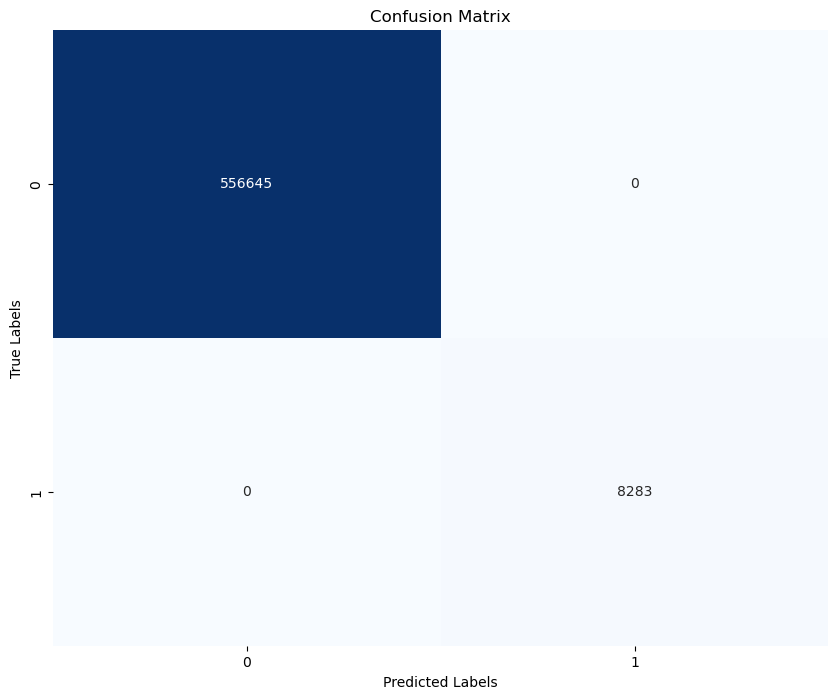

-------------- file 2 -------------------
Model 1 Accuracy: 0.9926747321119944
Model 1 precesion: 0.9993800371977681
Model 1 recall: 0.3784037558685446
Model 1 fbeta_score: 0.5489528350076622


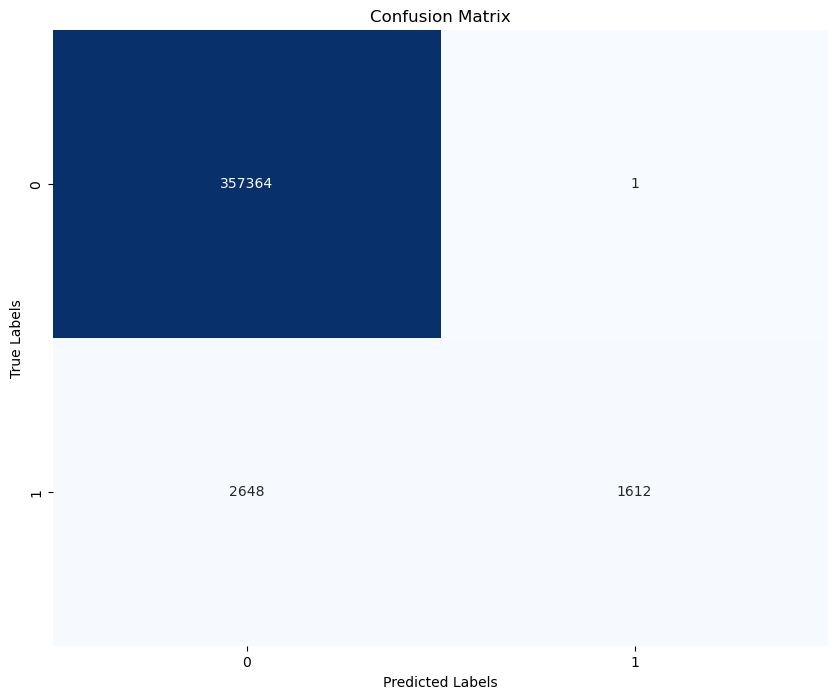

-------------- file 3 -------------------
Model 1 Accuracy: 0.9943139361105922
Model 1 precesion: 0.0
Model 1 recall: 0.0
Model 1 fbeta_score: 0.0


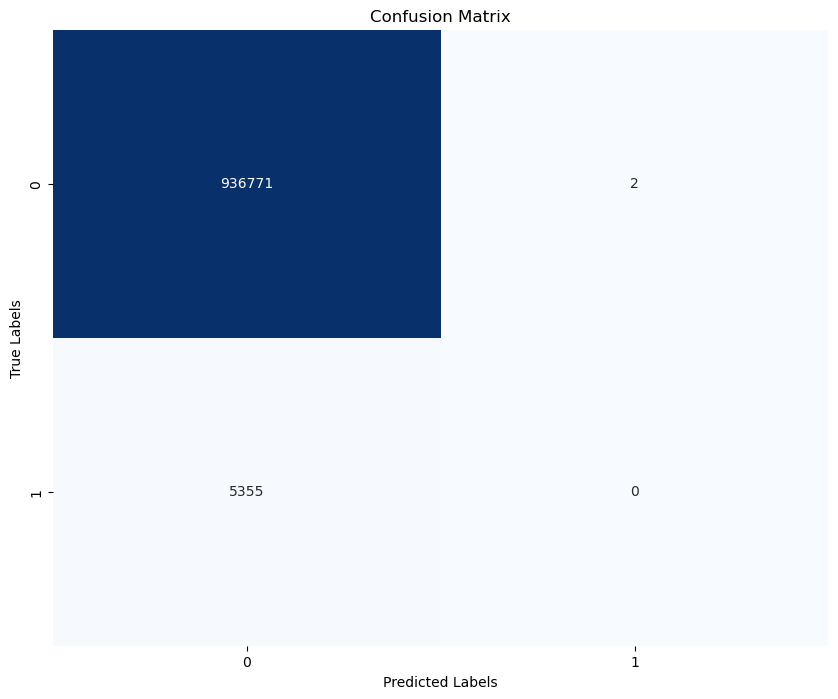

-------------- file 4 -------------------
Model 1 Accuracy: 0.9975648481821101
Model 1 precesion: 0.0
Model 1 recall: 0.0
Model 1 fbeta_score: 0.0


/home/s2316001/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


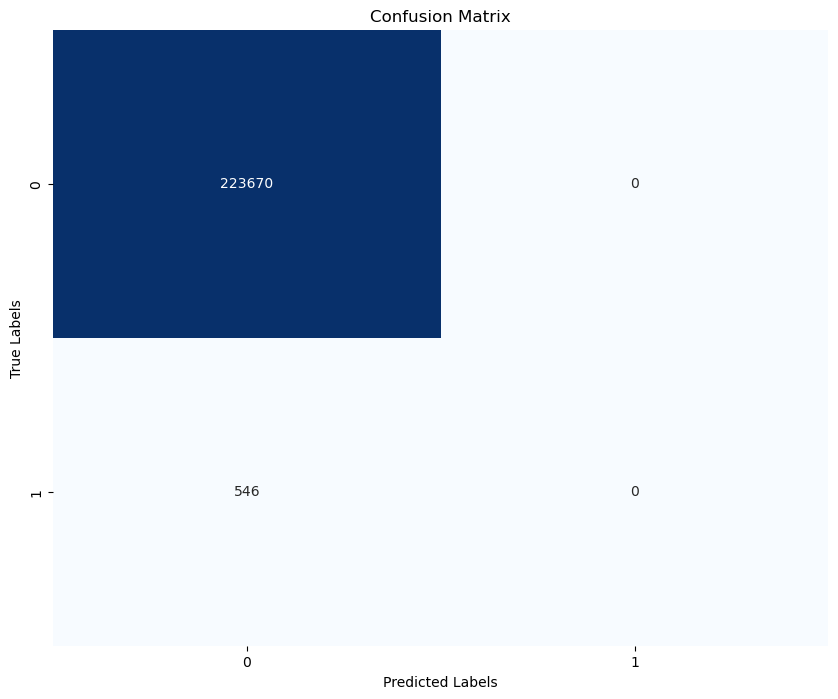

-------------- file 5 -------------------
Model 1 Accuracy: 0.9925289790888435
Model 1 precesion: 0.0
Model 1 recall: 0.0
Model 1 fbeta_score: 0.0


/home/s2316001/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


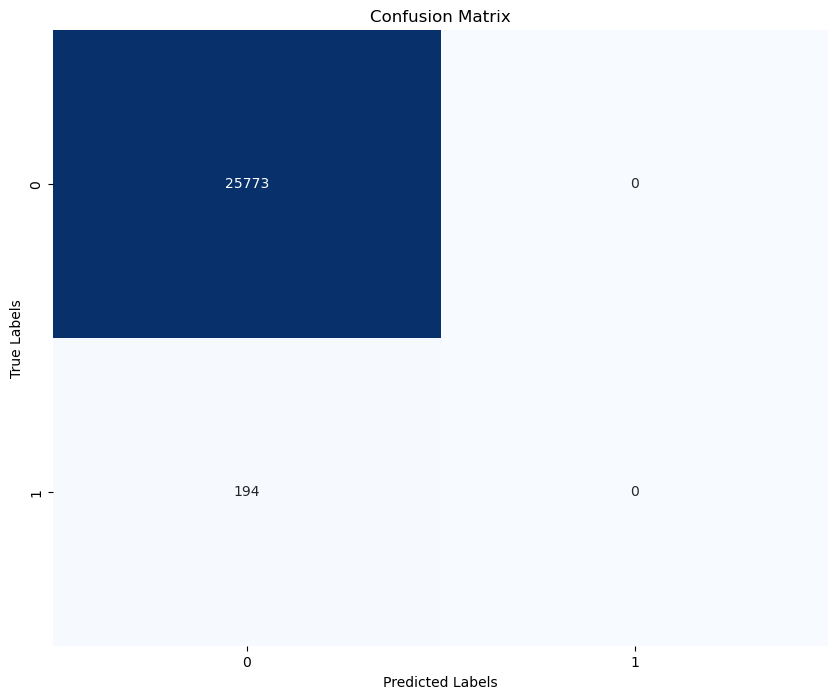

-------------- file 6 -------------------
Model 1 Accuracy: 0.9916714377728476
Model 1 precesion: 0.0
Model 1 recall: 0.0
Model 1 fbeta_score: 0.0


/home/s2316001/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


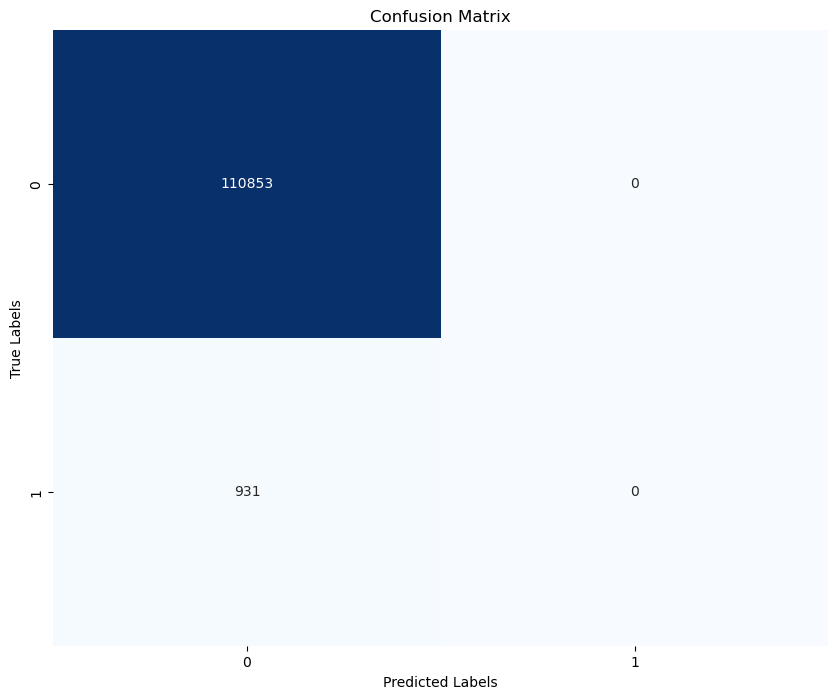

-------------- file 7 -------------------
Model 1 Accuracy: 0.9992987377279102
Model 1 precesion: 0.0
Model 1 recall: 0.0
Model 1 fbeta_score: 0.0


/home/s2316001/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


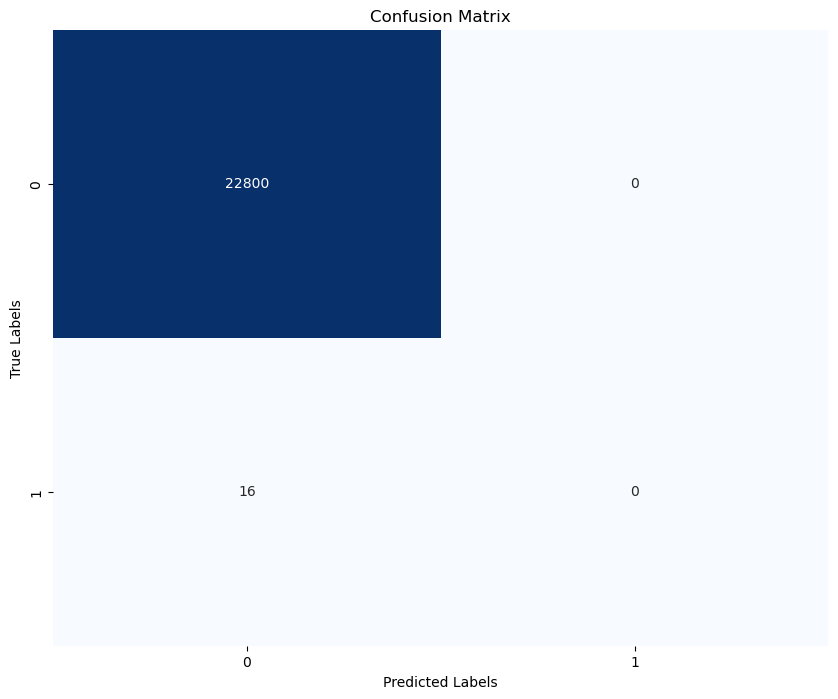

-------------- file 8 -------------------
Model 1 Accuracy: 0.9979283942008578
Model 1 precesion: 0.0
Model 1 recall: 0.0
Model 1 fbeta_score: 0.0


/home/s2316001/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


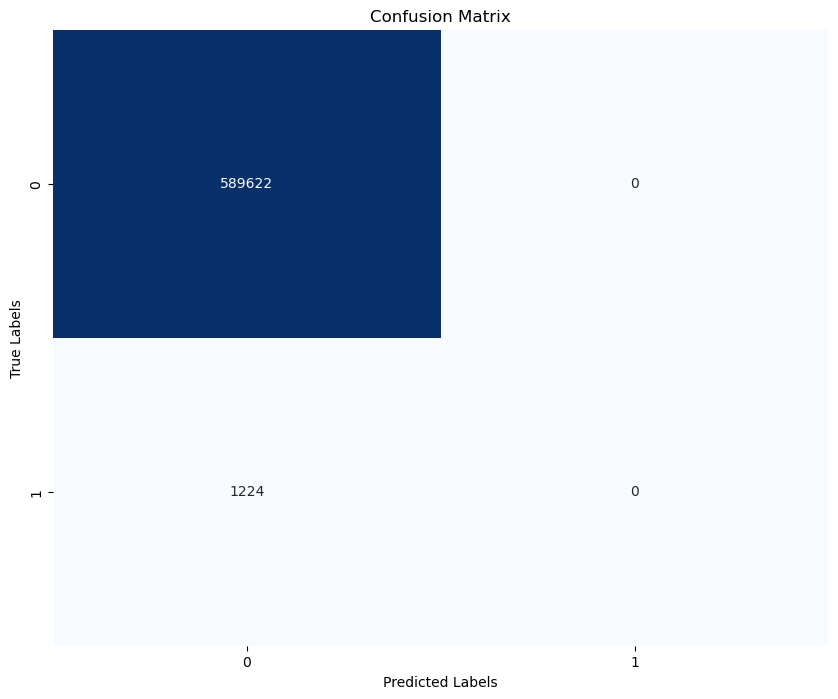

-------------- file 9 -------------------
Model 1 Accuracy: 0.9114495259902946
Model 1 precesion: 0.0
Model 1 recall: 0.0
Model 1 fbeta_score: 0.0


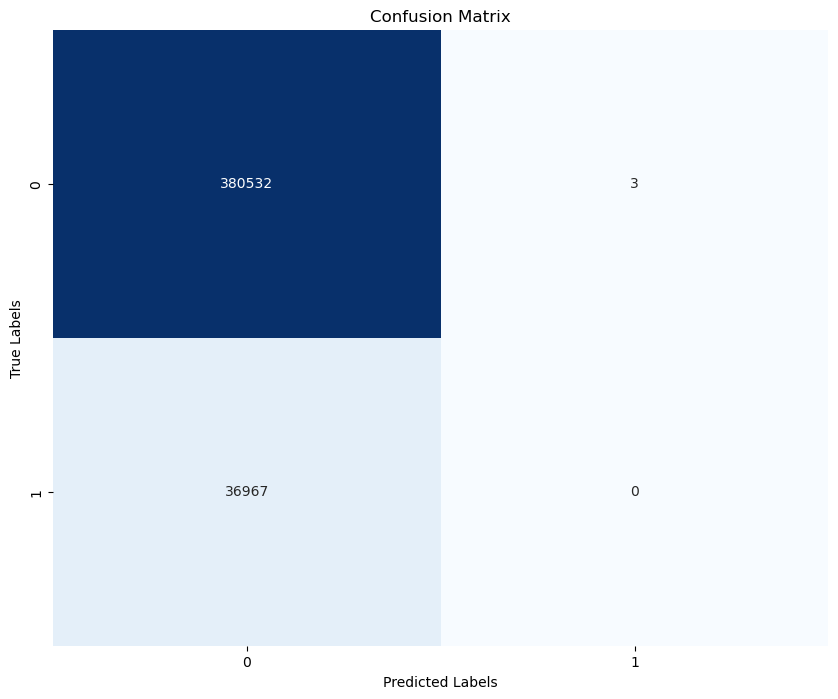

-------------- file 10 -------------------
Model 1 Accuracy: 0.9188422615752847
Model 1 precesion: 0.0
Model 1 recall: 0.0
Model 1 fbeta_score: 0.0


/home/s2316001/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


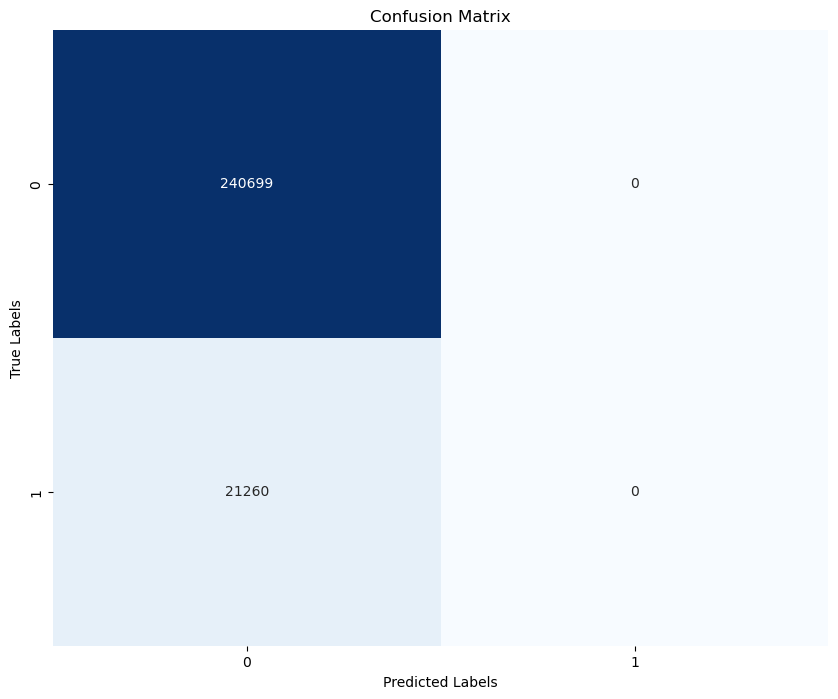

-------------- file 11 -------------------
Model 1 Accuracy: 0.9228474197007133
Model 1 precesion: 0.0
Model 1 recall: 0.0
Model 1 fbeta_score: 0.0


/home/s2316001/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


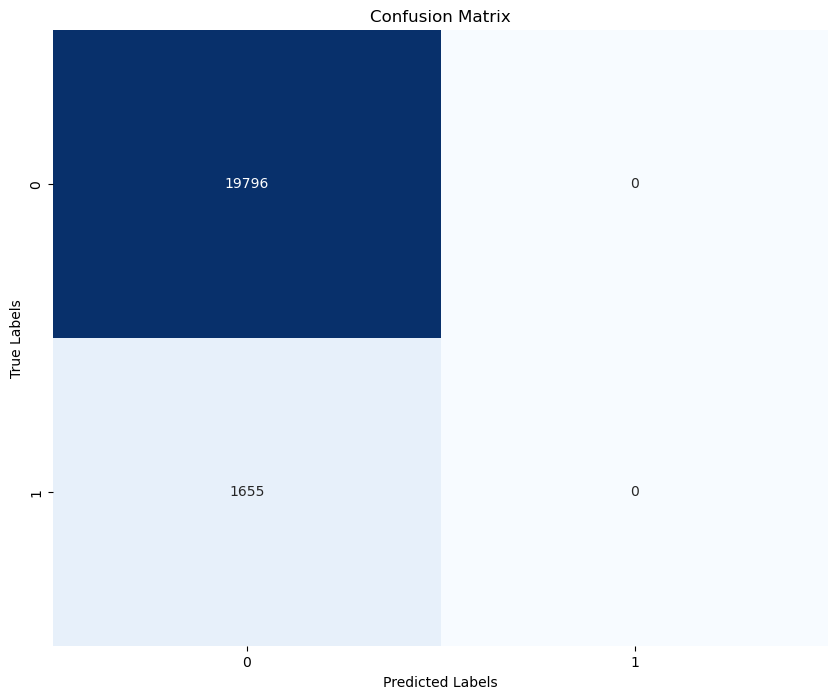

-------------- file 12 -------------------
Model 1 Accuracy: 0.99379368615101
Model 1 precesion: 0.0
Model 1 recall: 0.0
Model 1 fbeta_score: 0.0


/home/s2316001/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


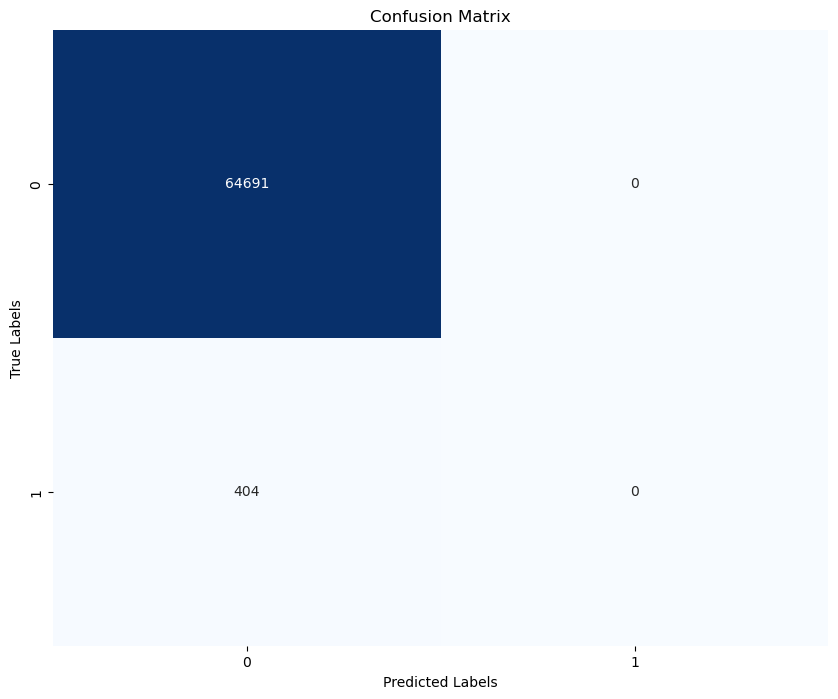

-------------- file 13 -------------------
Model 1 Accuracy: 0.9766277952367348
Model 1 precesion: 0.0
Model 1 recall: 0.0
Model 1 fbeta_score: 0.0


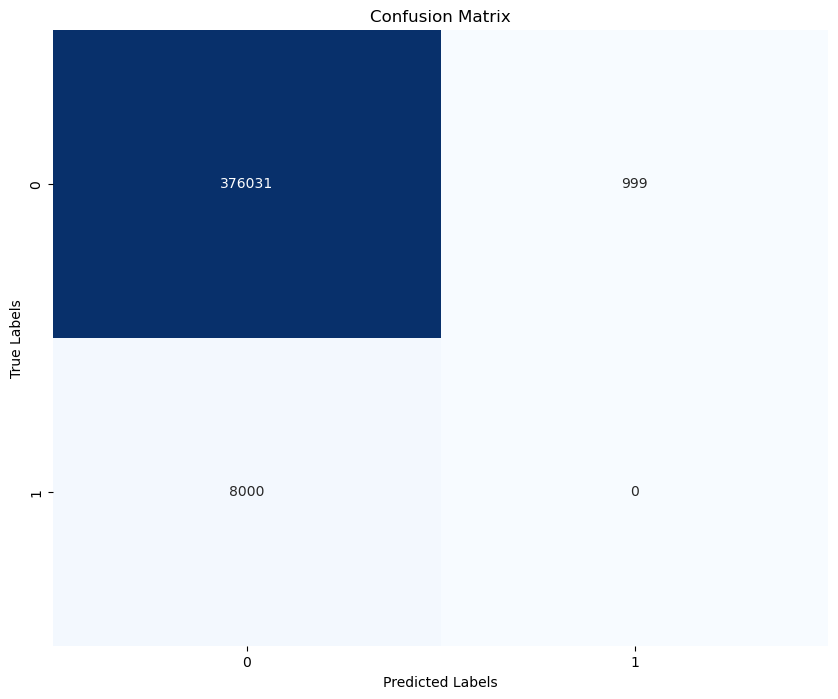

-------------- Model 2 -------------------
-------------- file 1 -------------------
Model 2 Accuracy: 0.9877949048374306
Model 2 precesion: 1.0
Model 2 recall: 0.16757213569962573
Model 2 fbeta_score: 0.28704373901354563


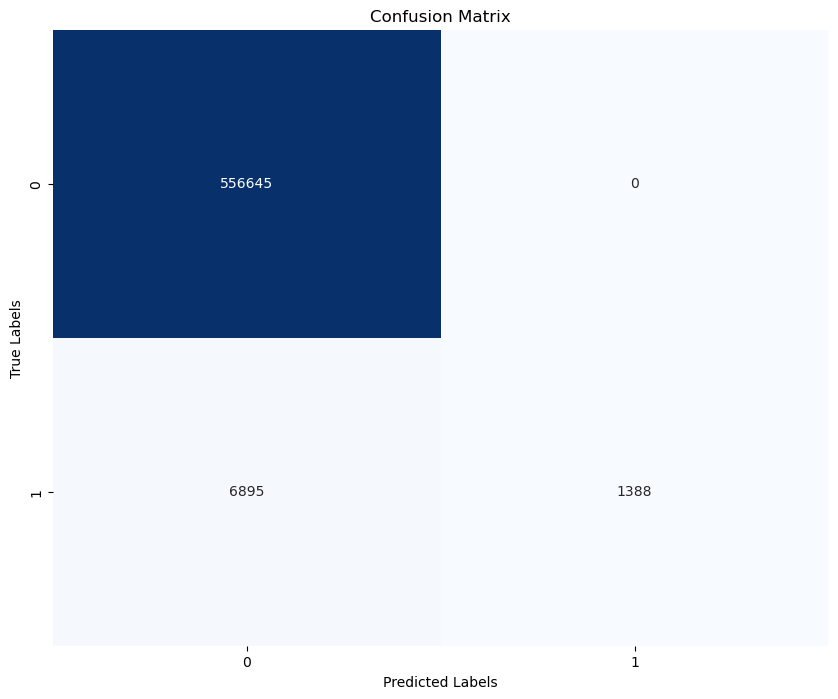

-------------- file 2 -------------------
Model 2 Accuracy: 0.999997234704459
Model 2 precesion: 1.0
Model 2 recall: 0.9997652582159624
Model 2 fbeta_score: 0.9998826153304379


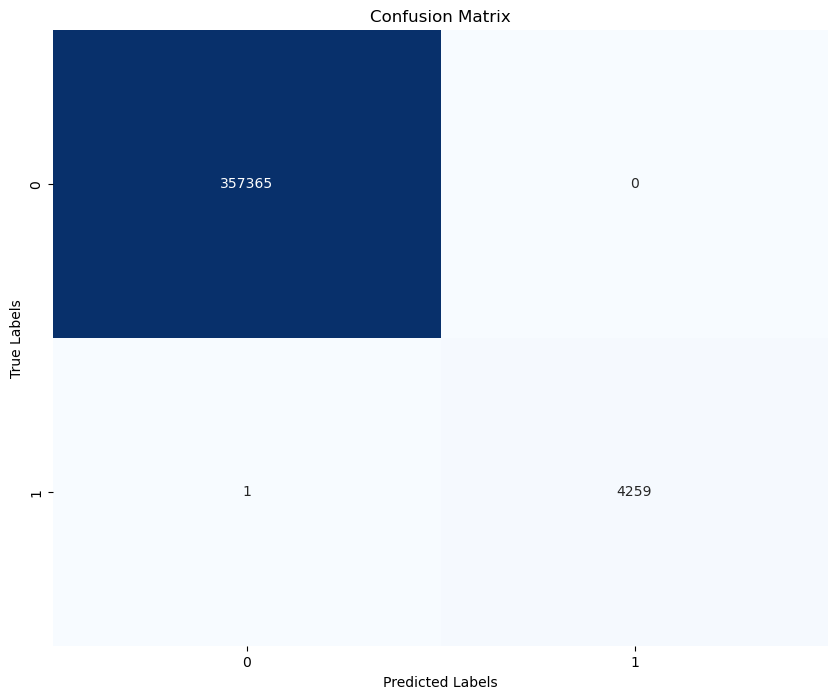

-------------- file 3 -------------------
Model 2 Accuracy: 0.994316058964387
Model 2 precesion: 0.0
Model 2 recall: 0.0
Model 2 fbeta_score: 0.0


/home/s2316001/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


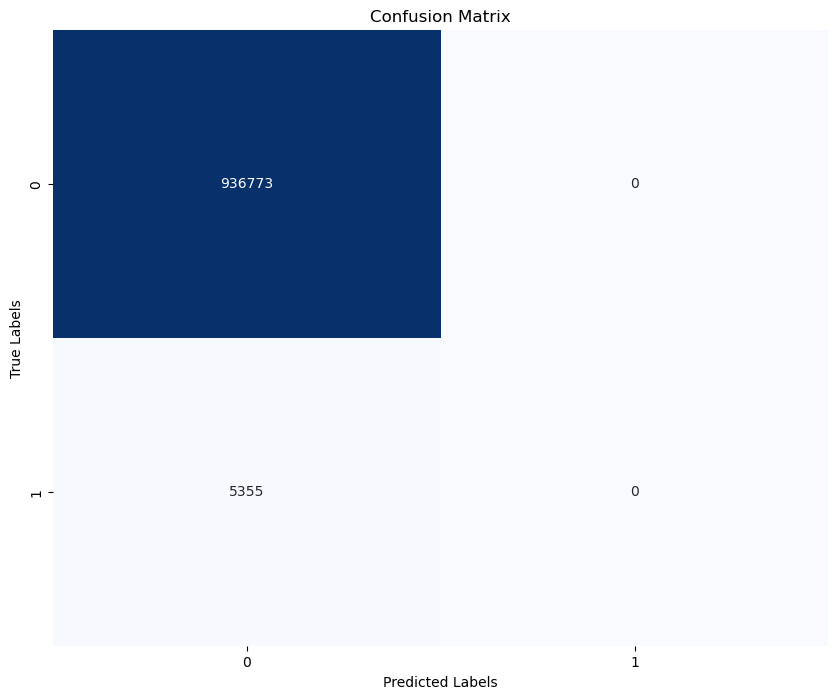

-------------- file 4 -------------------
Model 2 Accuracy: 0.9975648481821101
Model 2 precesion: 0.0
Model 2 recall: 0.0
Model 2 fbeta_score: 0.0


/home/s2316001/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


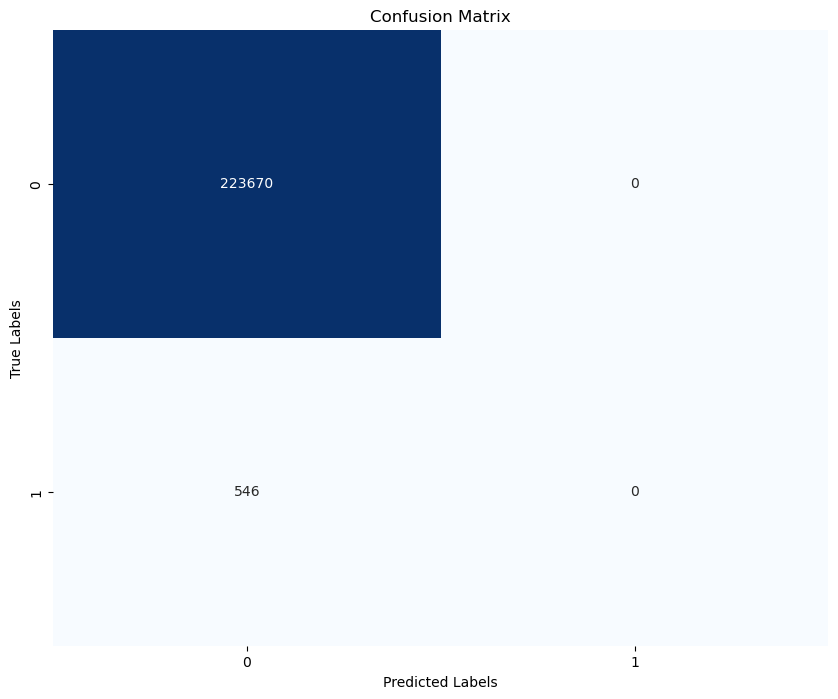

-------------- file 5 -------------------
Model 2 Accuracy: 0.9925289790888435
Model 2 precesion: 0.0
Model 2 recall: 0.0
Model 2 fbeta_score: 0.0


/home/s2316001/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


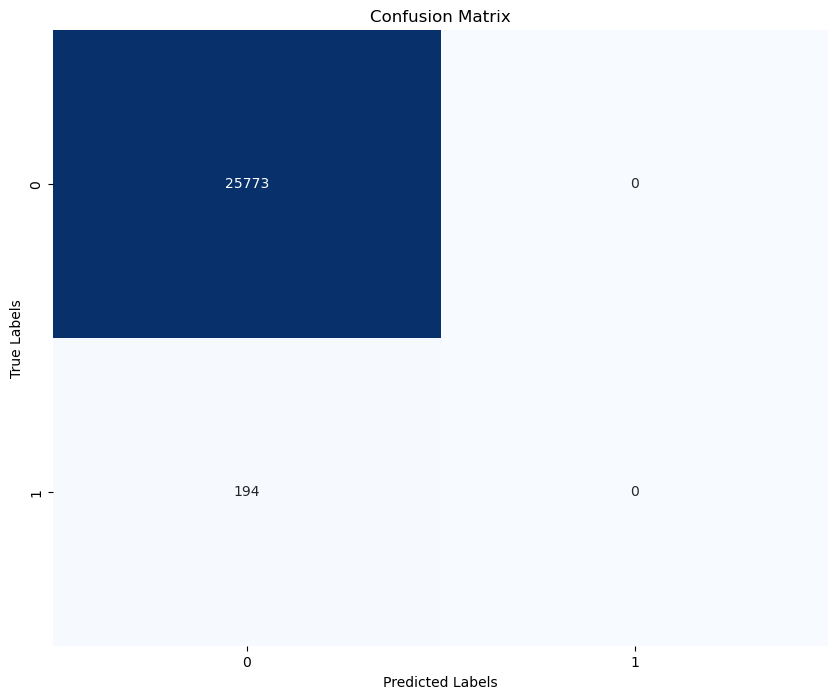

-------------- file 6 -------------------
Model 2 Accuracy: 0.9916714377728476
Model 2 precesion: 0.0
Model 2 recall: 0.0
Model 2 fbeta_score: 0.0


/home/s2316001/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


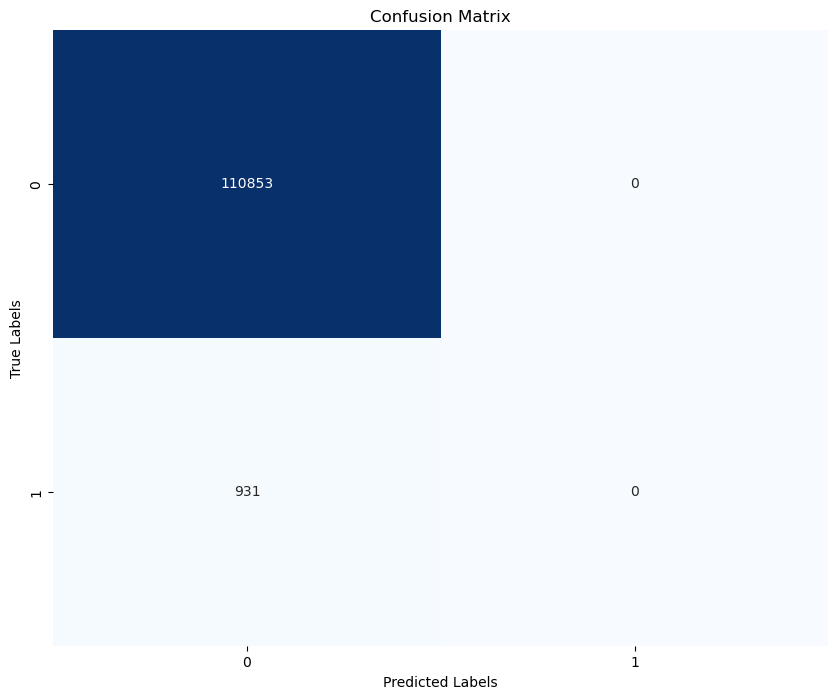

-------------- file 7 -------------------
Model 2 Accuracy: 0.9992987377279102
Model 2 precesion: 0.0
Model 2 recall: 0.0
Model 2 fbeta_score: 0.0


/home/s2316001/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


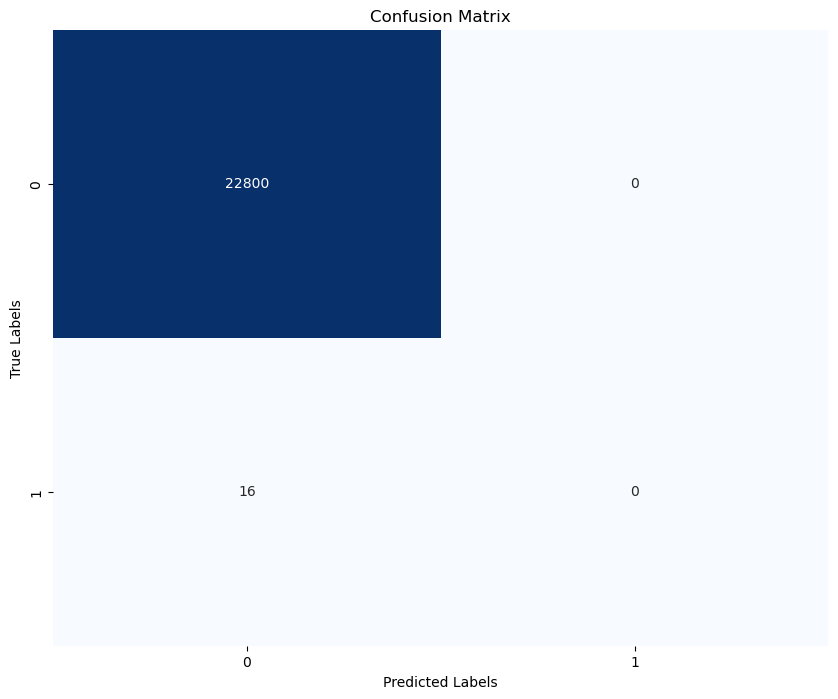

-------------- file 8 -------------------
Model 2 Accuracy: 0.9979283942008578
Model 2 precesion: 0.0
Model 2 recall: 0.0
Model 2 fbeta_score: 0.0


/home/s2316001/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


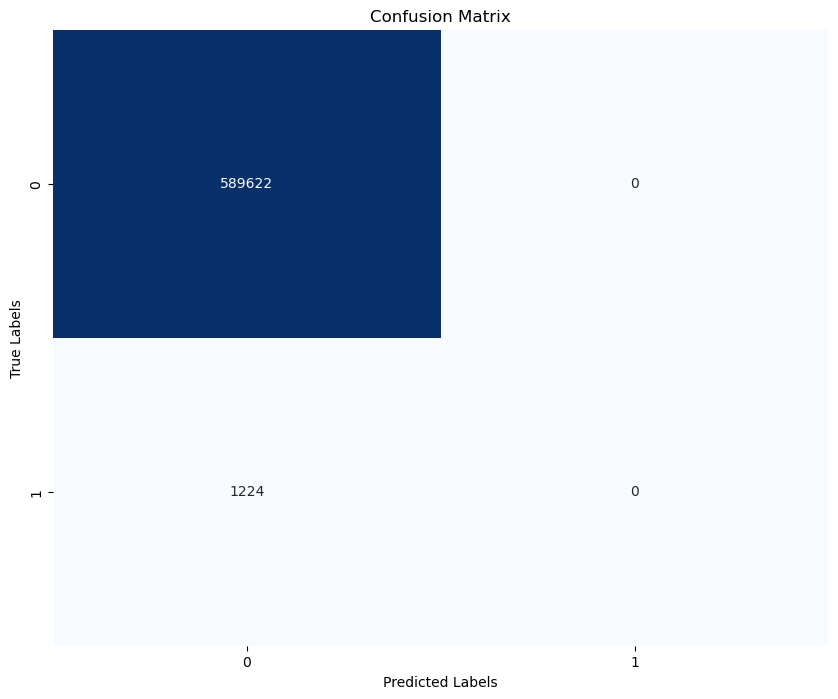

-------------- file 9 -------------------
Model 2 Accuracy: 0.9114567115846152
Model 2 precesion: 0.0
Model 2 recall: 0.0
Model 2 fbeta_score: 0.0


/home/s2316001/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


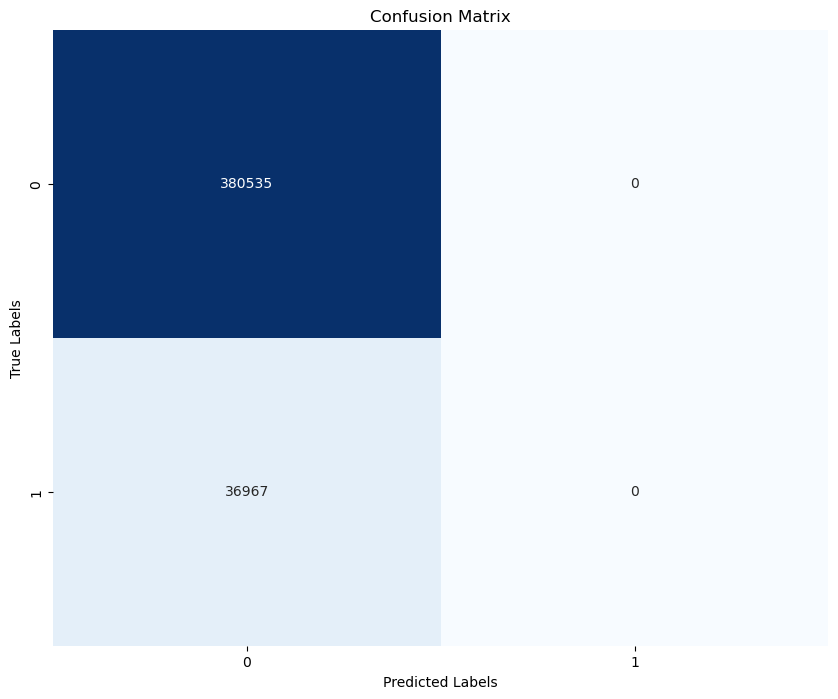

-------------- file 10 -------------------
Model 2 Accuracy: 0.9188422615752847
Model 2 precesion: 0.0
Model 2 recall: 0.0
Model 2 fbeta_score: 0.0


/home/s2316001/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


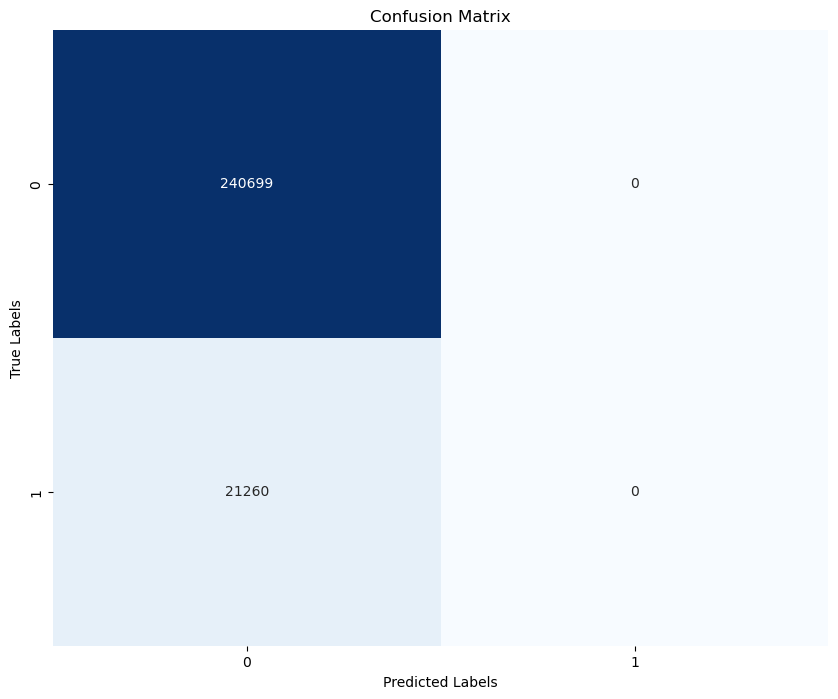

-------------- file 11 -------------------
Model 2 Accuracy: 0.9228474197007133
Model 2 precesion: 0.0
Model 2 recall: 0.0
Model 2 fbeta_score: 0.0


/home/s2316001/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


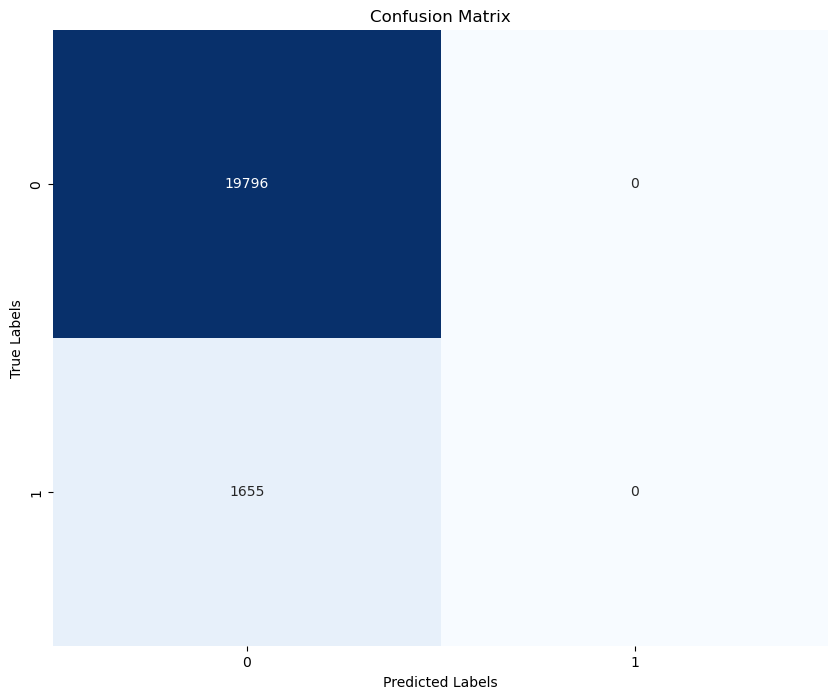

-------------- file 12 -------------------
Model 2 Accuracy: 0.99379368615101
Model 2 precesion: 0.0
Model 2 recall: 0.0
Model 2 fbeta_score: 0.0


/home/s2316001/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


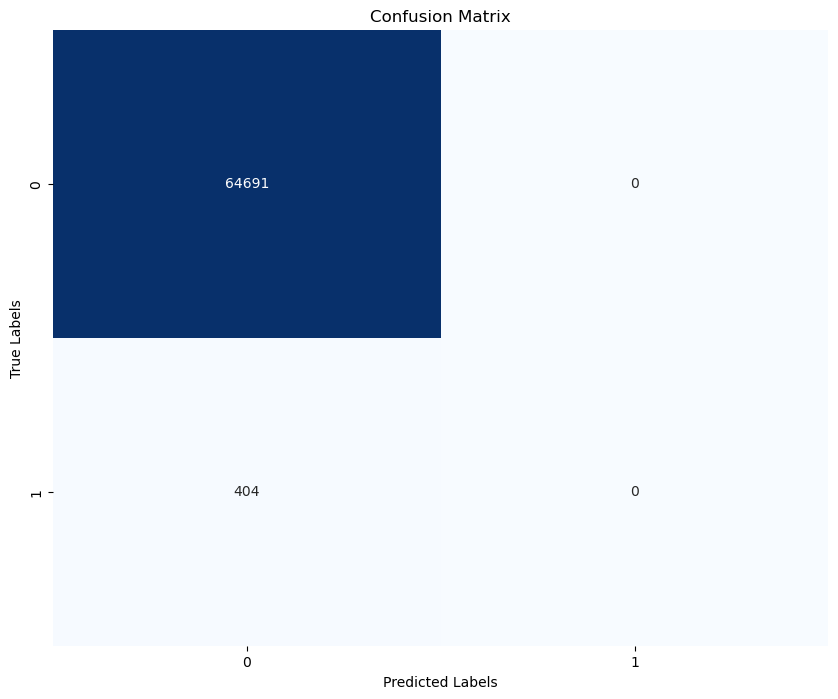

-------------- file 13 -------------------
Model 2 Accuracy: 0.979058774640937
Model 2 precesion: 0.0
Model 2 recall: 0.0
Model 2 fbeta_score: 0.0


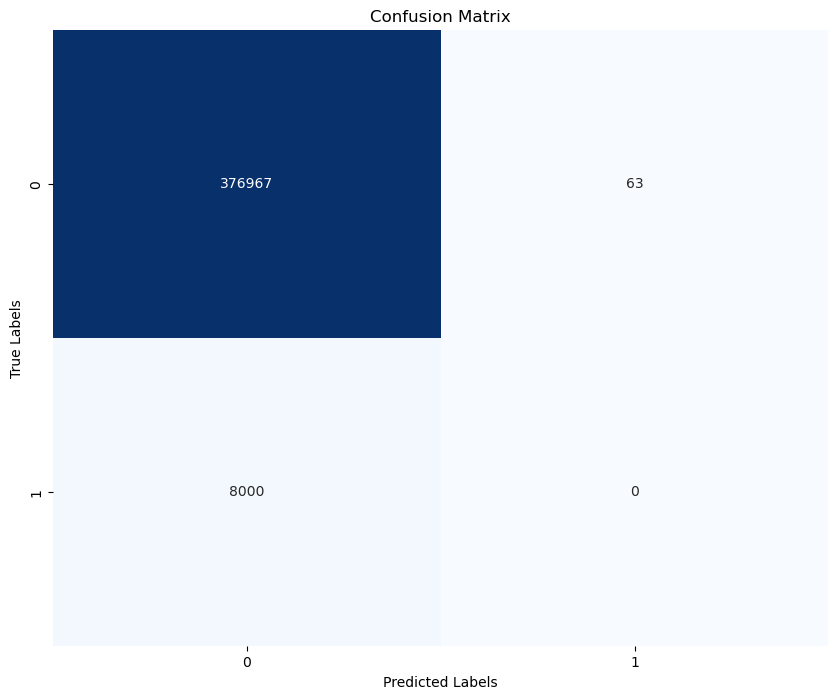

-------------- Model 3 -------------------
-------------- file 1 -------------------
Model 3 Accuracy: 0.985337954571202
Model 3 precesion: 0.0
Model 3 recall: 0.0
Model 3 fbeta_score: 0.0


/home/s2316001/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


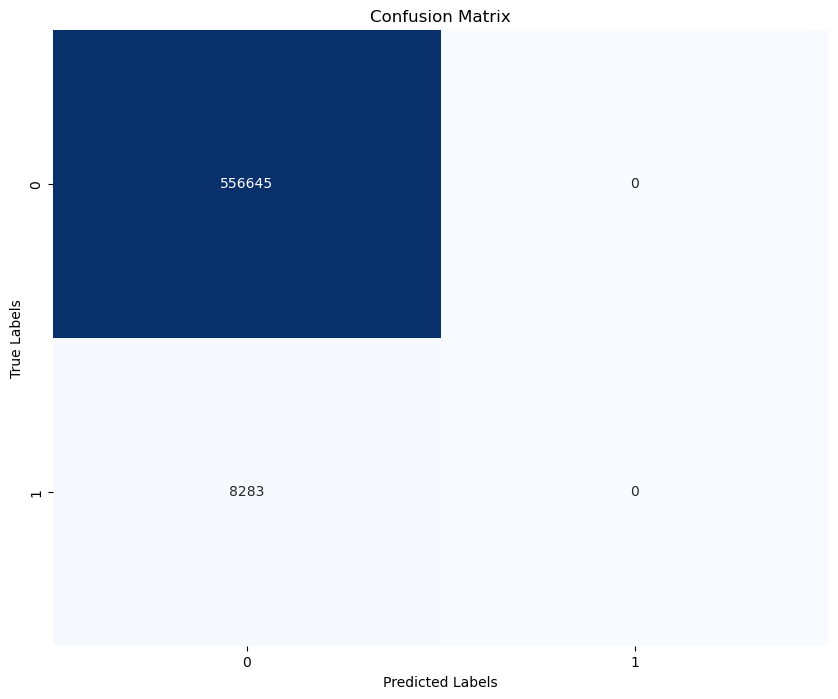

-------------- file 2 -------------------
Model 3 Accuracy: 0.9882198409955064
Model 3 precesion: 0.0
Model 3 recall: 0.0
Model 3 fbeta_score: 0.0


/home/s2316001/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


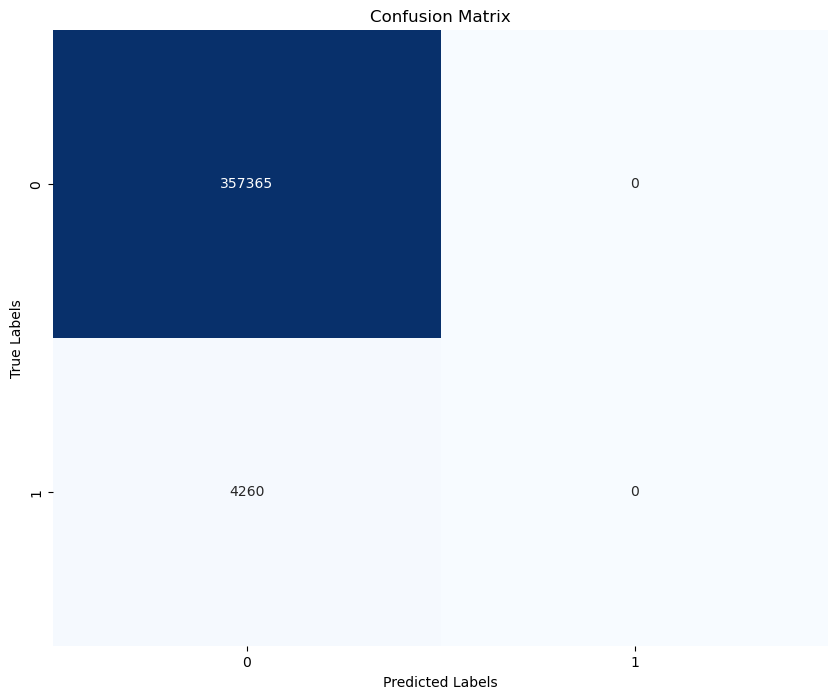

-------------- file 3 -------------------
Model 3 Accuracy: 0.9999872628772312
Model 3 precesion: 0.9998129092609915
Model 3 recall: 0.9979458450046685
Model 3 fbeta_score: 0.9988785046728972


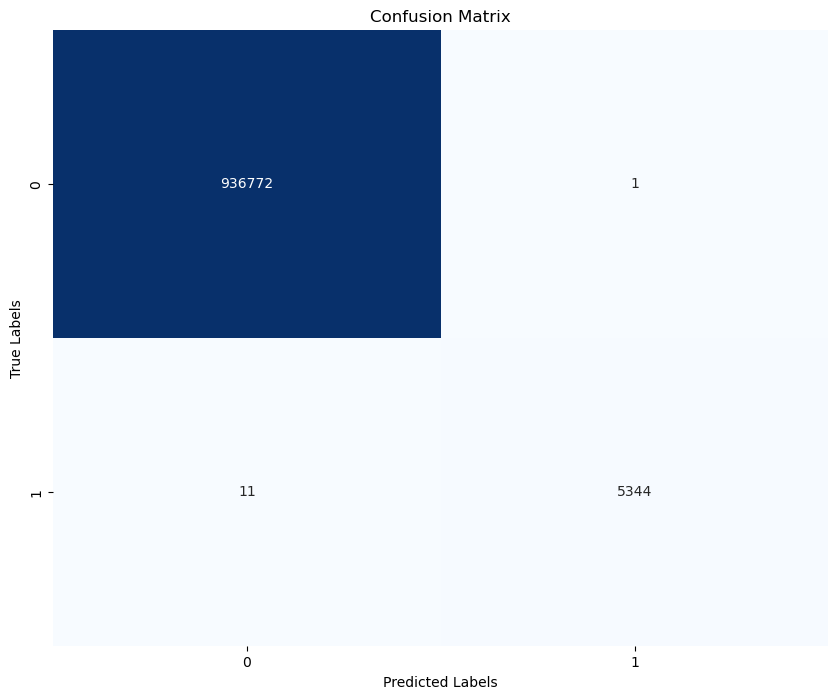

-------------- file 4 -------------------
Model 3 Accuracy: 0.9975648481821101
Model 3 precesion: 0.0
Model 3 recall: 0.0
Model 3 fbeta_score: 0.0


/home/s2316001/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


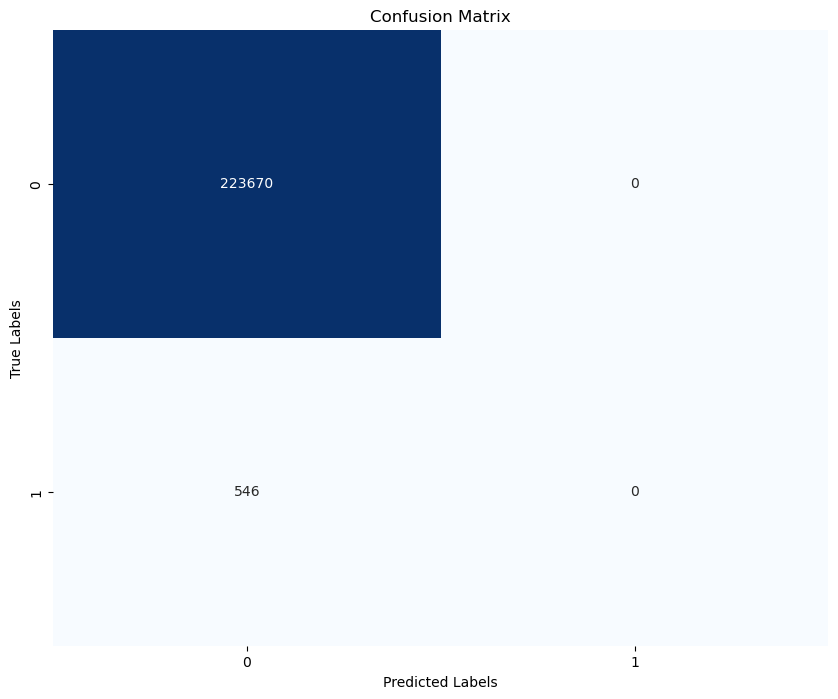

-------------- file 5 -------------------
Model 3 Accuracy: 0.9925289790888435
Model 3 precesion: 0.0
Model 3 recall: 0.0
Model 3 fbeta_score: 0.0


/home/s2316001/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


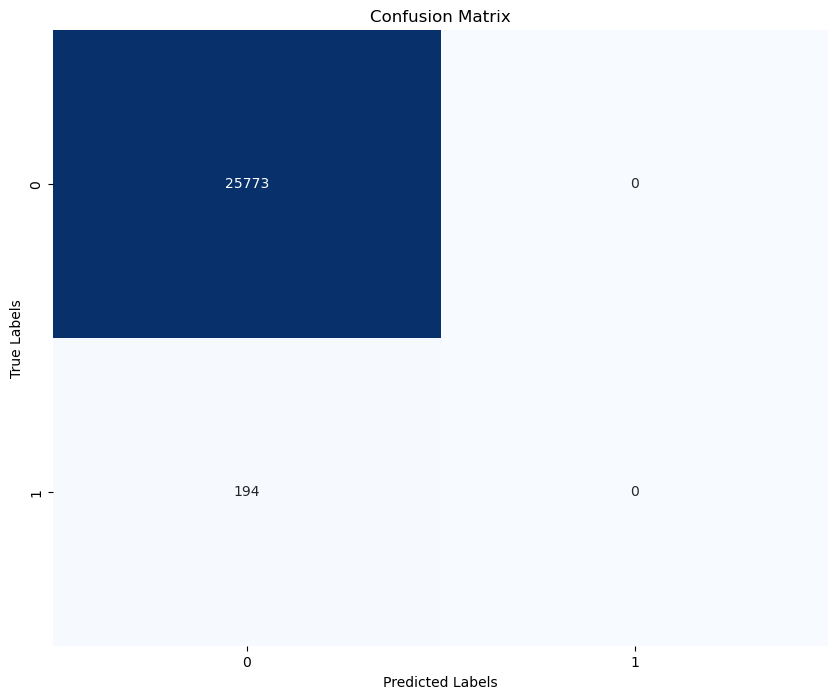

-------------- file 6 -------------------
Model 3 Accuracy: 0.9916714377728476
Model 3 precesion: 0.0
Model 3 recall: 0.0
Model 3 fbeta_score: 0.0


/home/s2316001/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


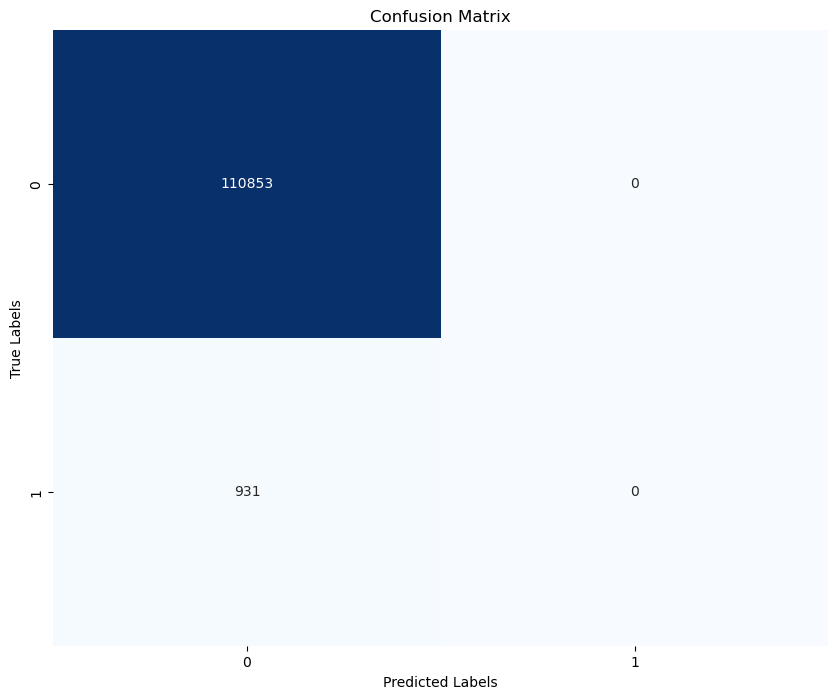

-------------- file 7 -------------------
Model 3 Accuracy: 0.9992987377279102
Model 3 precesion: 0.0
Model 3 recall: 0.0
Model 3 fbeta_score: 0.0


/home/s2316001/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


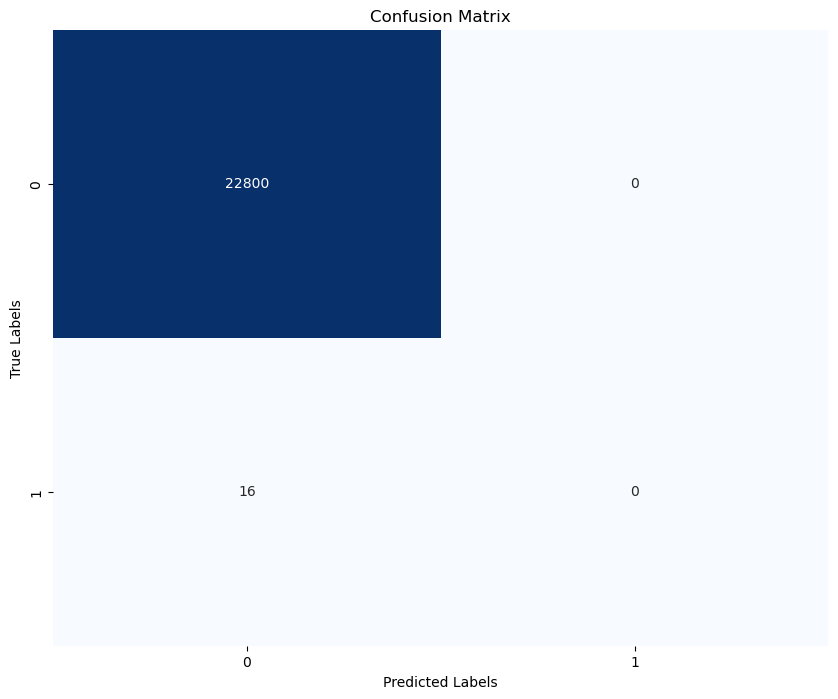

-------------- file 8 -------------------
Model 3 Accuracy: 0.9979283942008578
Model 3 precesion: 0.0
Model 3 recall: 0.0
Model 3 fbeta_score: 0.0


/home/s2316001/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


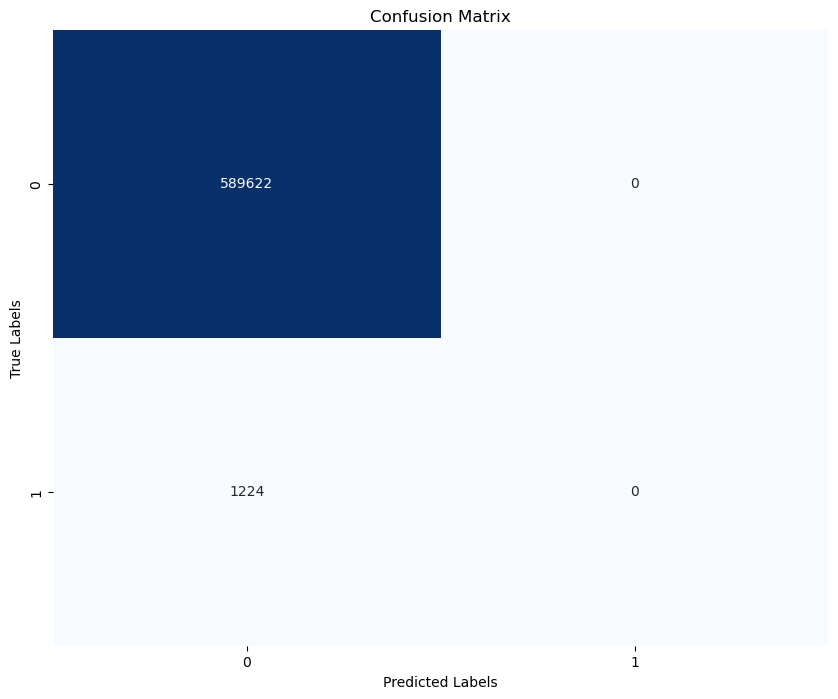

-------------- file 9 -------------------
Model 3 Accuracy: 0.9114567115846152
Model 3 precesion: 0.0
Model 3 recall: 0.0
Model 3 fbeta_score: 0.0


/home/s2316001/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


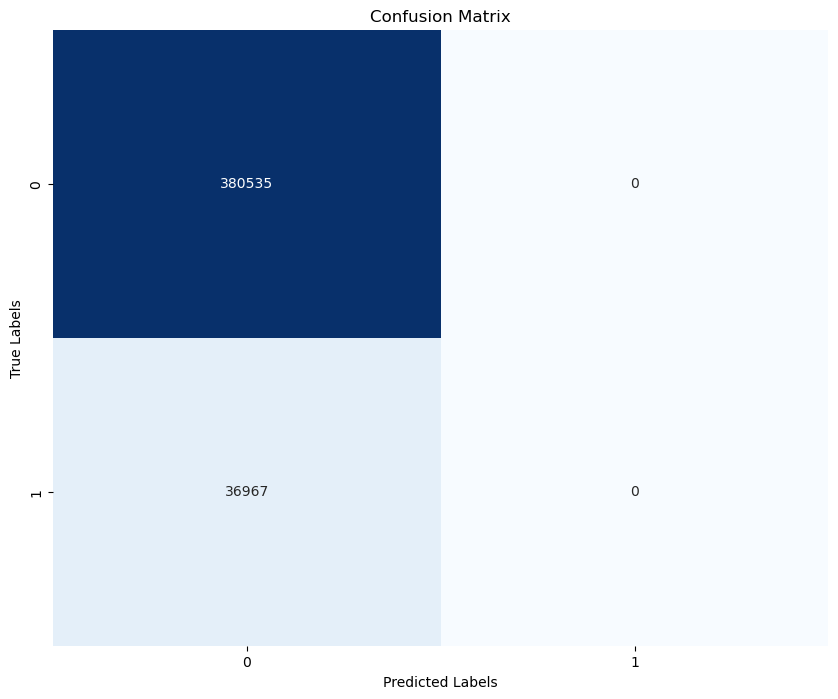

-------------- file 10 -------------------
Model 3 Accuracy: 0.9188422615752847
Model 3 precesion: 0.0
Model 3 recall: 0.0
Model 3 fbeta_score: 0.0


/home/s2316001/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


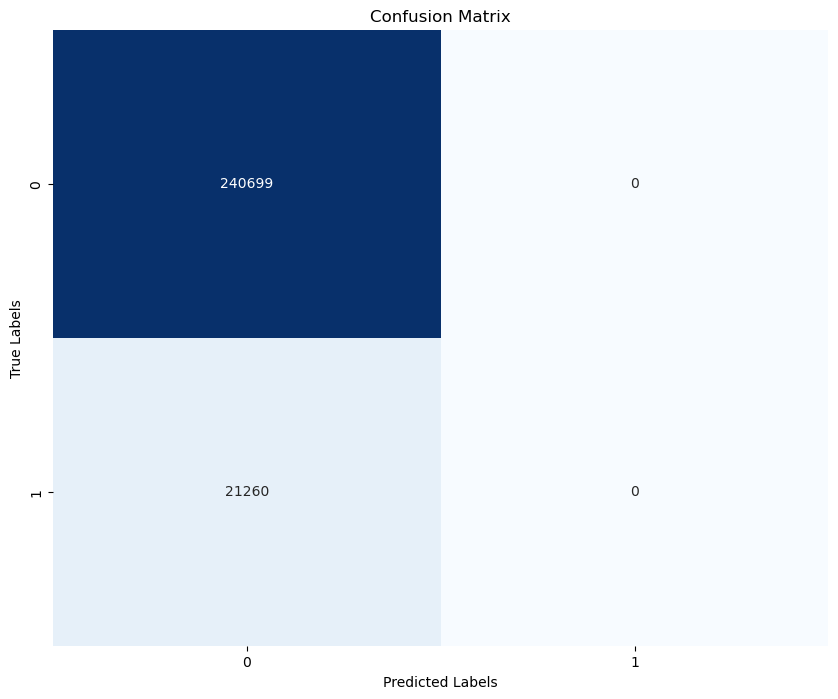

/home/s2316001/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


-------------- file 11 -------------------
Model 3 Accuracy: 0.9228474197007133
Model 3 precesion: 0.0
Model 3 recall: 0.0
Model 3 fbeta_score: 0.0


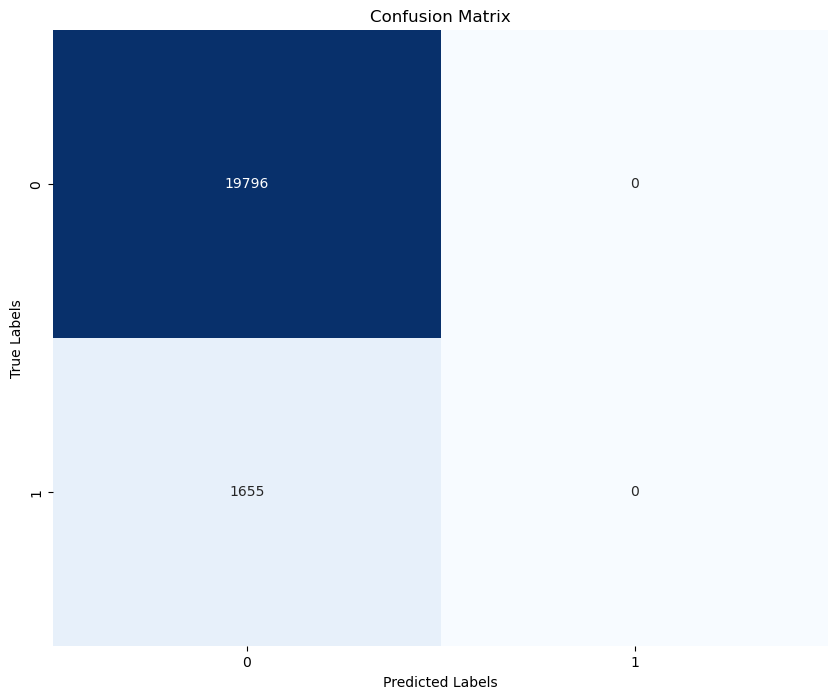

-------------- file 12 -------------------
Model 3 Accuracy: 0.99379368615101
Model 3 precesion: 0.0
Model 3 recall: 0.0
Model 3 fbeta_score: 0.0


/home/s2316001/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


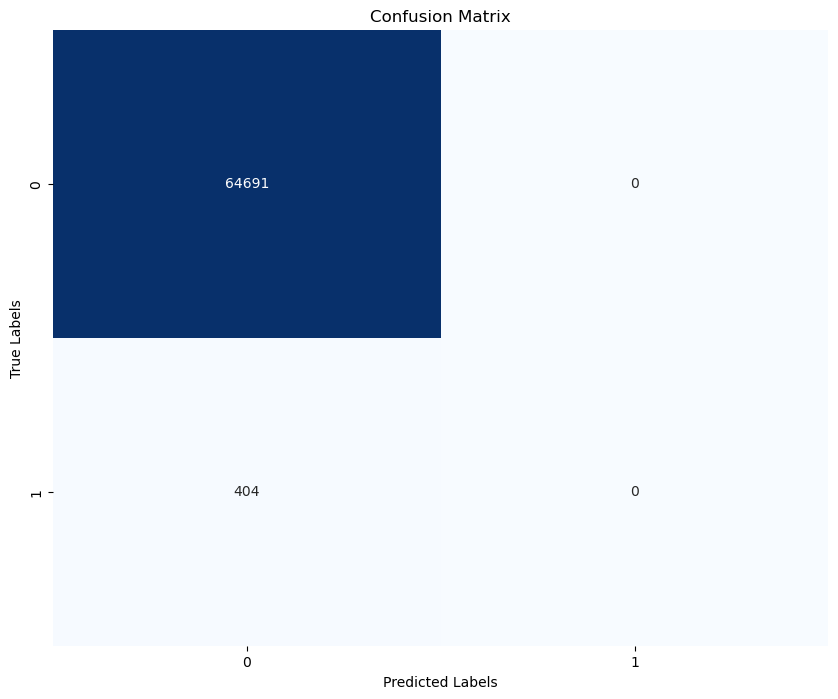

-------------- file 13 -------------------
Model 3 Accuracy: 0.9792223982546815
Model 3 precesion: 0.0
Model 3 recall: 0.0
Model 3 fbeta_score: 0.0


/home/s2316001/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


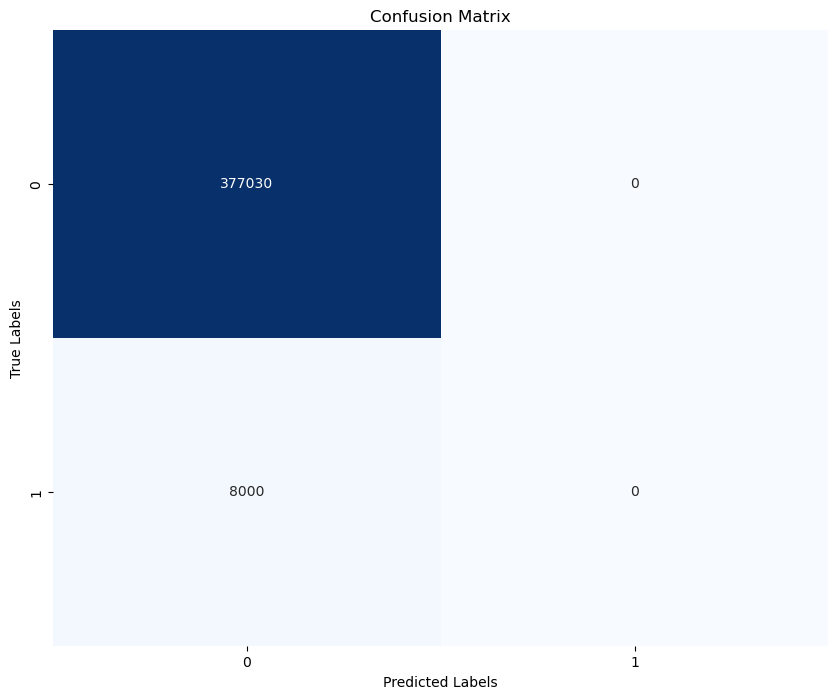

-------------- Model 4 -------------------
-------------- file 1 -------------------
Model 4 Accuracy: 0.985337954571202
Model 4 precesion: 0.0
Model 4 recall: 0.0
Model 4 fbeta_score: 0.0


/home/s2316001/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


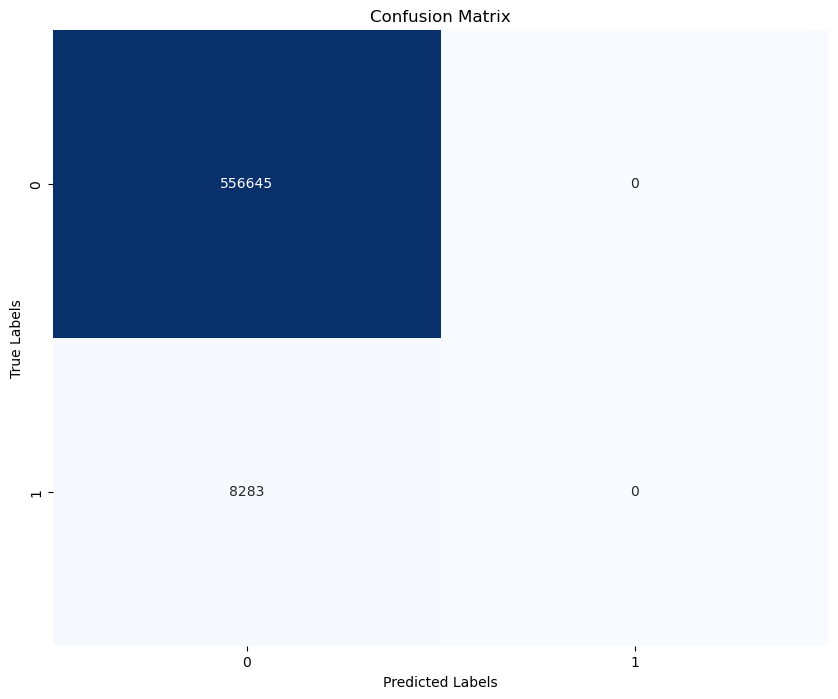

-------------- file 2 -------------------
Model 4 Accuracy: 0.9882198409955064
Model 4 precesion: 0.0
Model 4 recall: 0.0
Model 4 fbeta_score: 0.0


/home/s2316001/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


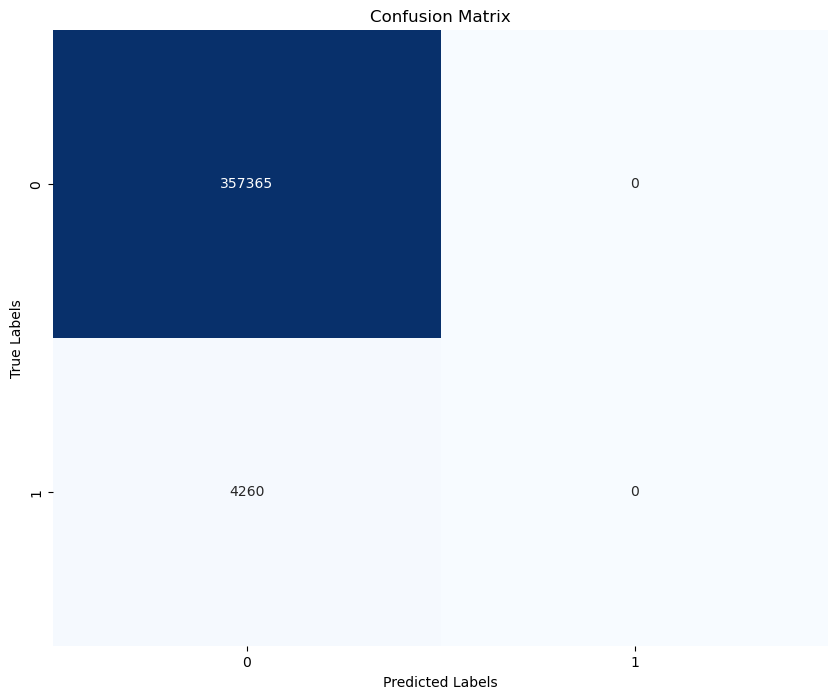

-------------- file 3 -------------------
Model 4 Accuracy: 0.994316058964387
Model 4 precesion: 0.0
Model 4 recall: 0.0
Model 4 fbeta_score: 0.0


/home/s2316001/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


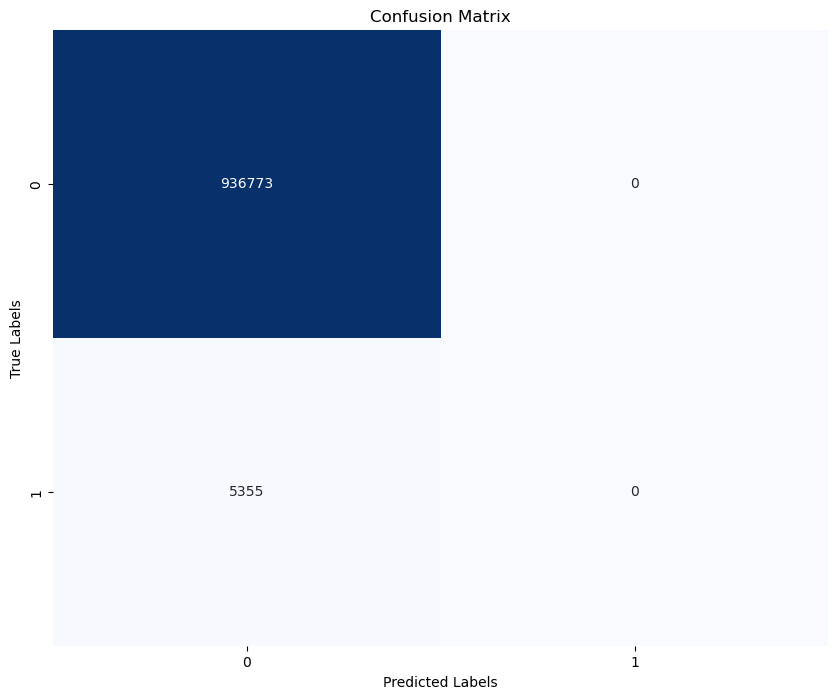

-------------- file 4 -------------------
Model 4 Accuracy: 0.9998572804795376
Model 4 precesion: 1.0
Model 4 recall: 0.9413919413919414
Model 4 fbeta_score: 0.969811320754717


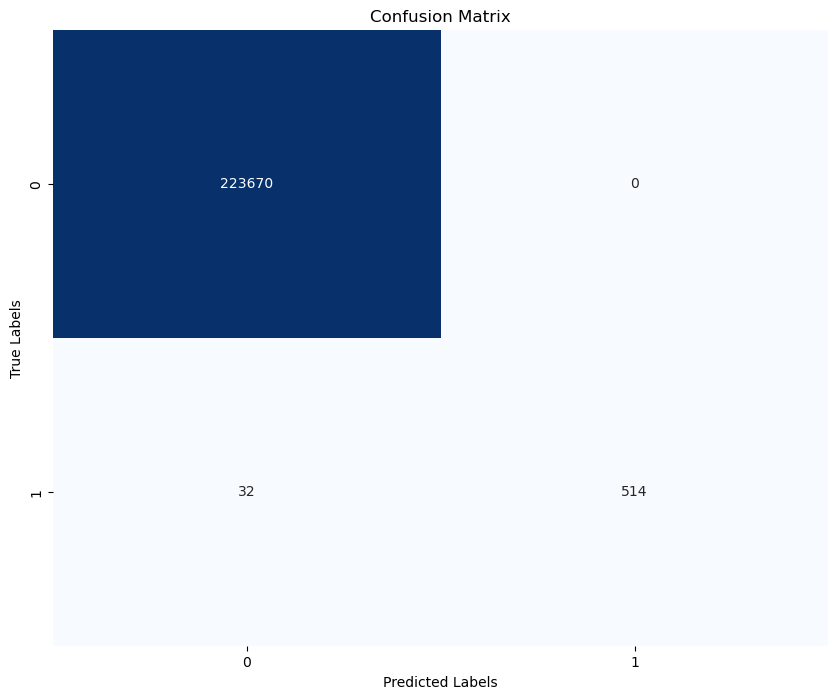

-------------- file 5 -------------------
Model 4 Accuracy: 0.9925289790888435
Model 4 precesion: 0.0
Model 4 recall: 0.0
Model 4 fbeta_score: 0.0


/home/s2316001/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


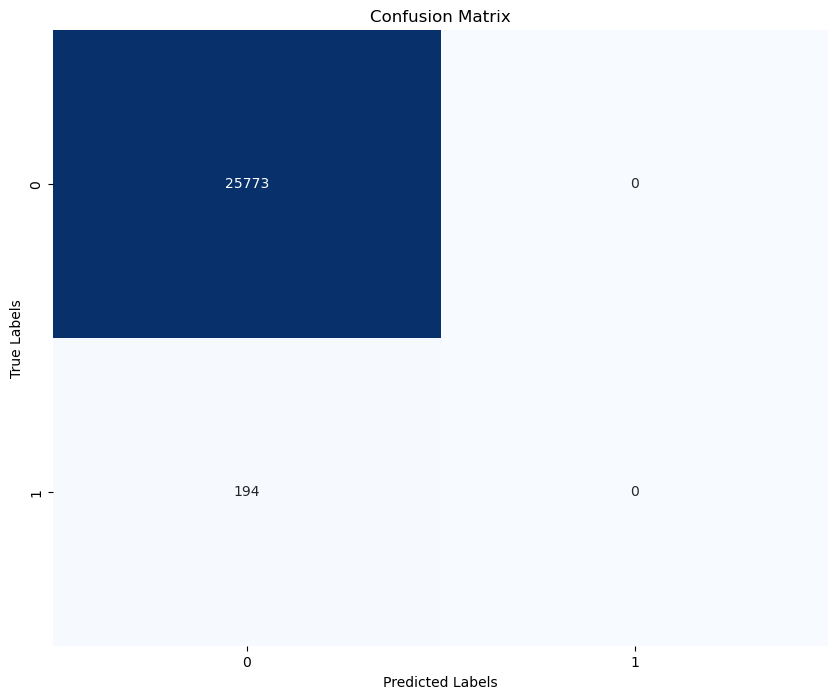

-------------- file 6 -------------------
Model 4 Accuracy: 0.9981750518857797
Model 4 precesion: 0.9173363949483353
Model 4 recall: 0.8582169709989259
Model 4 fbeta_score: 0.8867924528301886


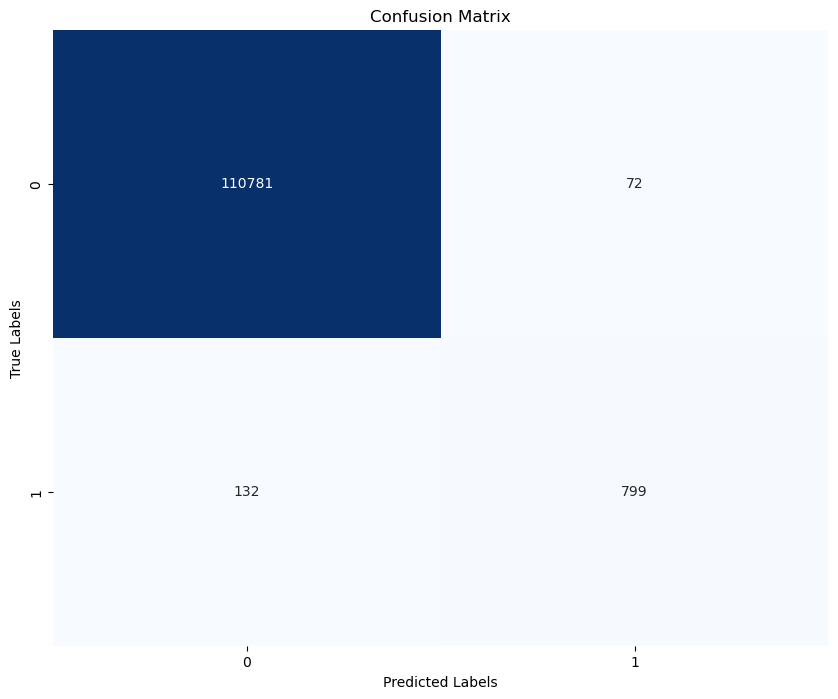

-------------- file 7 -------------------
Model 4 Accuracy: 0.9992987377279102
Model 4 precesion: 0.0
Model 4 recall: 0.0
Model 4 fbeta_score: 0.0


/home/s2316001/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


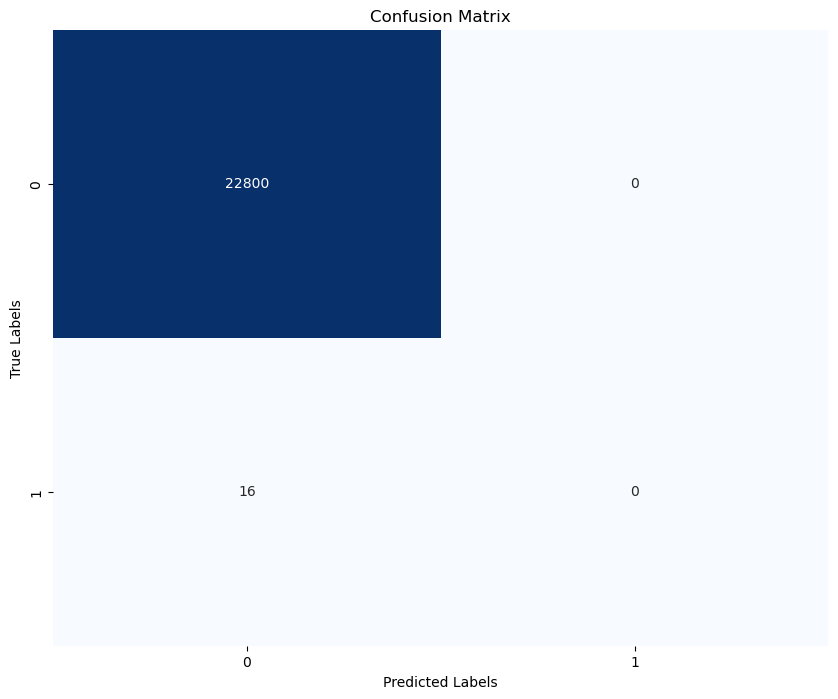

-------------- file 8 -------------------
Model 4 Accuracy: 0.9979283942008578
Model 4 precesion: 0.0
Model 4 recall: 0.0
Model 4 fbeta_score: 0.0


/home/s2316001/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


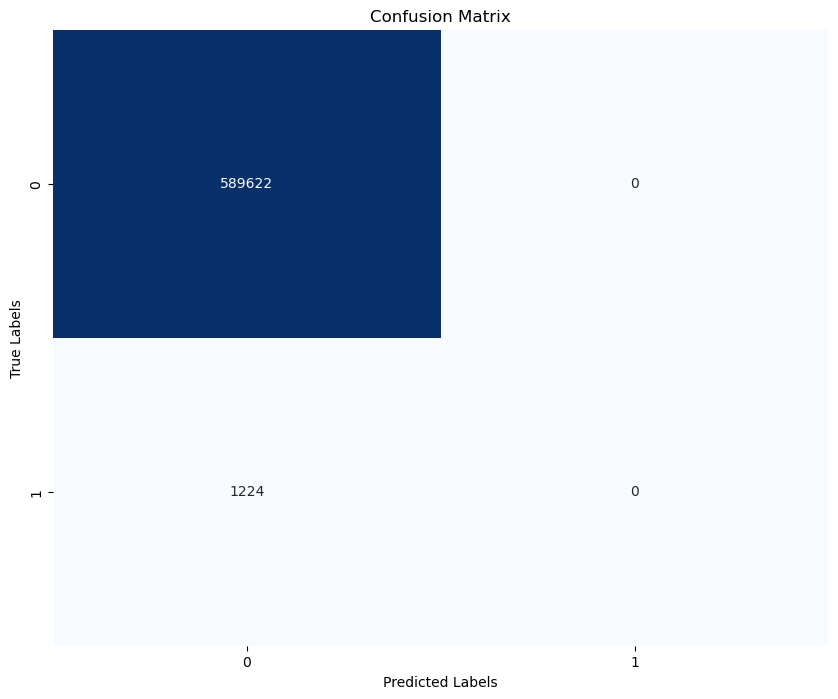

-------------- file 9 -------------------
Model 4 Accuracy: 0.9114567115846152
Model 4 precesion: 0.0
Model 4 recall: 0.0
Model 4 fbeta_score: 0.0


/home/s2316001/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


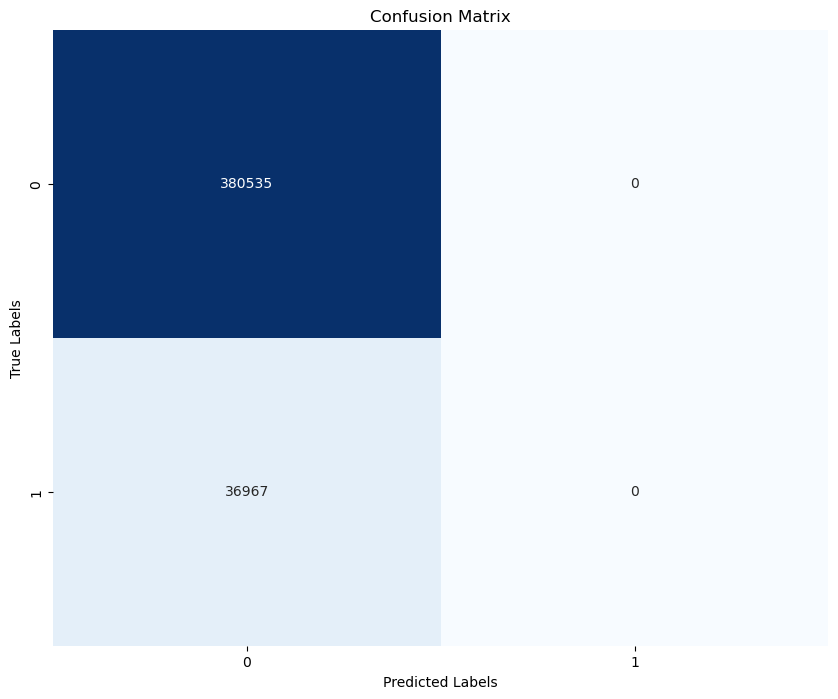

-------------- file 10 -------------------
Model 4 Accuracy: 0.9188537137490982
Model 4 precesion: 1.0
Model 4 recall: 0.00014111006585136406
Model 4 fbeta_score: 0.00028218031322014767


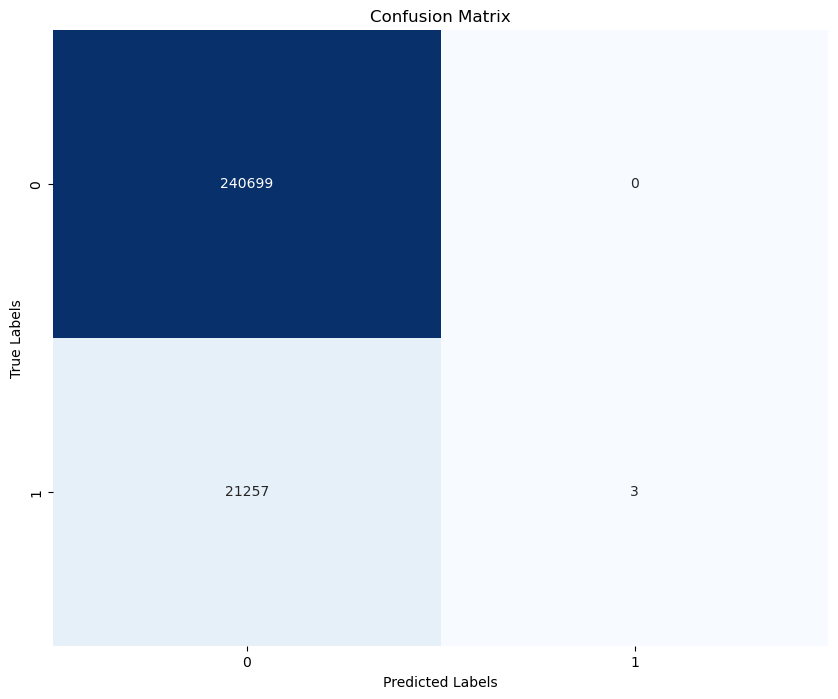

-------------- file 11 -------------------
Model 4 Accuracy: 0.9233135984336395
Model 4 precesion: 0.7777777777777778
Model 4 recall: 0.008459214501510574
Model 4 fbeta_score: 0.016736401673640166


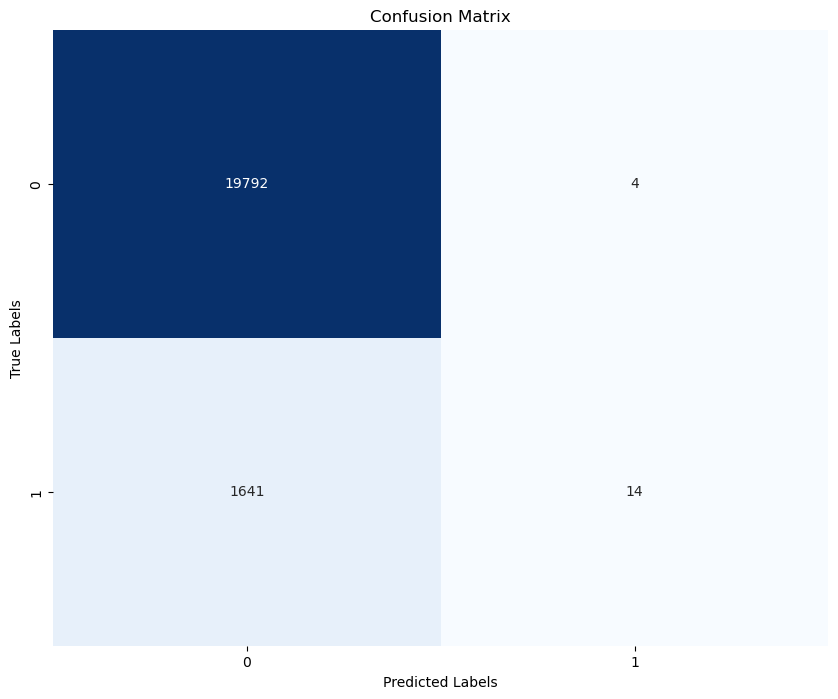

-------------- file 12 -------------------
Model 4 Accuracy: 0.99379368615101
Model 4 precesion: 0.0
Model 4 recall: 0.0
Model 4 fbeta_score: 0.0


/home/s2316001/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


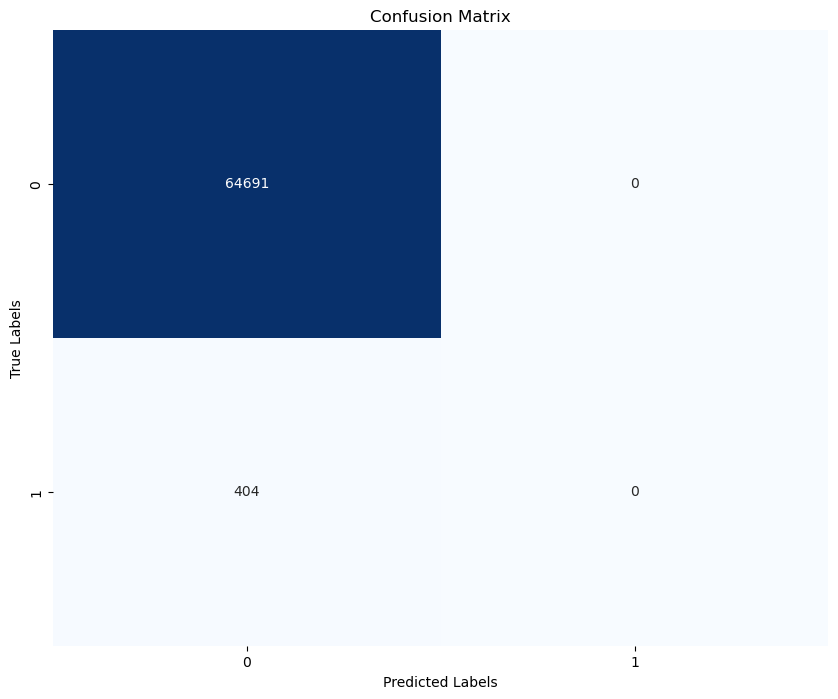

-------------- file 13 -------------------
Model 4 Accuracy: 0.9792223982546815
Model 4 precesion: 0.0
Model 4 recall: 0.0
Model 4 fbeta_score: 0.0


/home/s2316001/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


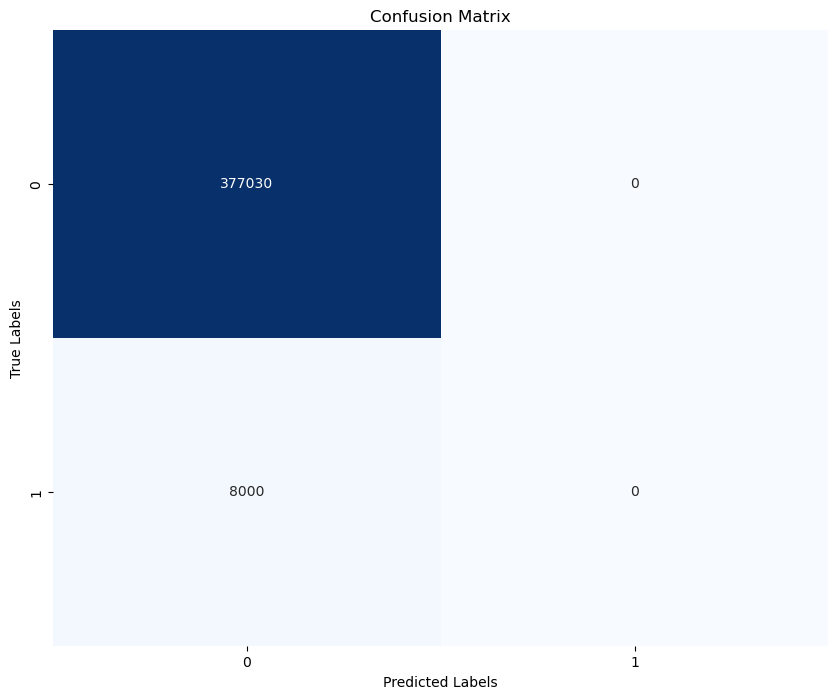

-------------- Model 5 -------------------
-------------- file 1 -------------------
Model 5 Accuracy: 0.9853308740228843
Model 5 precesion: 0.0
Model 5 recall: 0.0
Model 5 fbeta_score: 0.0


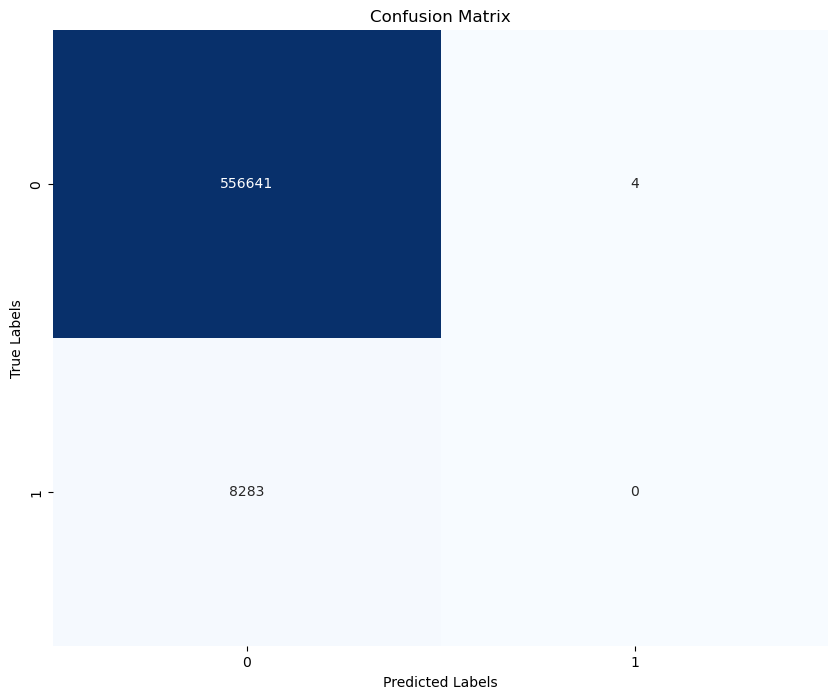

-------------- file 2 -------------------
Model 5 Accuracy: 0.9882198409955064
Model 5 precesion: 0.0
Model 5 recall: 0.0
Model 5 fbeta_score: 0.0


/home/s2316001/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


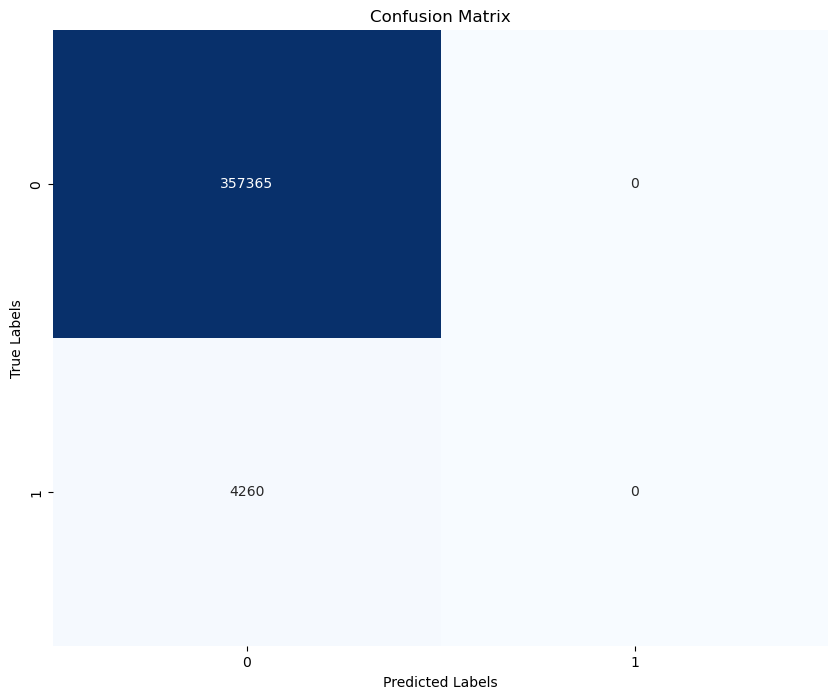

-------------- file 3 -------------------
Model 5 Accuracy: 0.9861324575853812
Model 5 precesion: 0.0
Model 5 recall: 0.0
Model 5 fbeta_score: 0.0


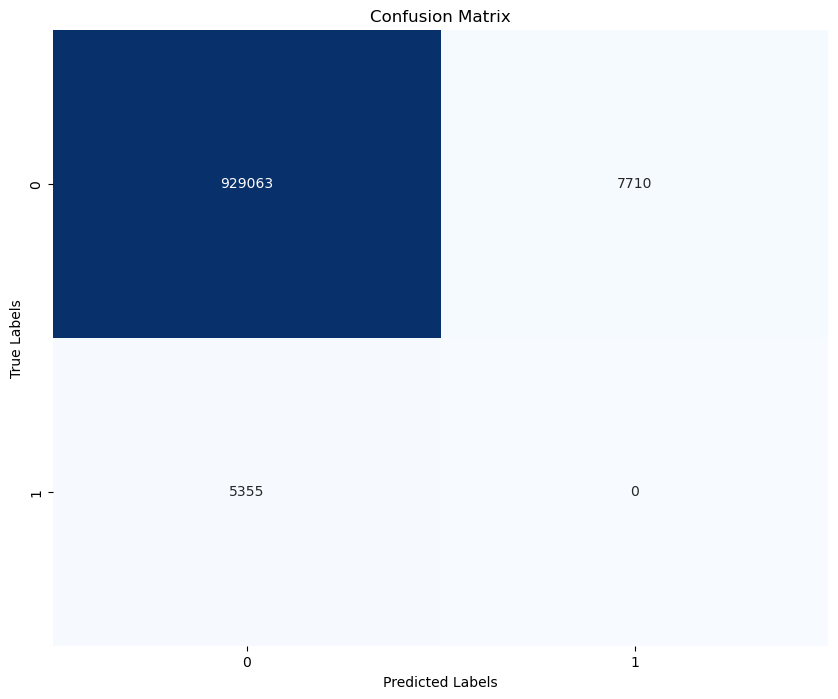

-------------- file 4 -------------------
Model 5 Accuracy: 0.9975782281371535
Model 5 precesion: 0.5089820359281437
Model 5 recall: 0.15567765567765568
Model 5 fbeta_score: 0.23842917251051896


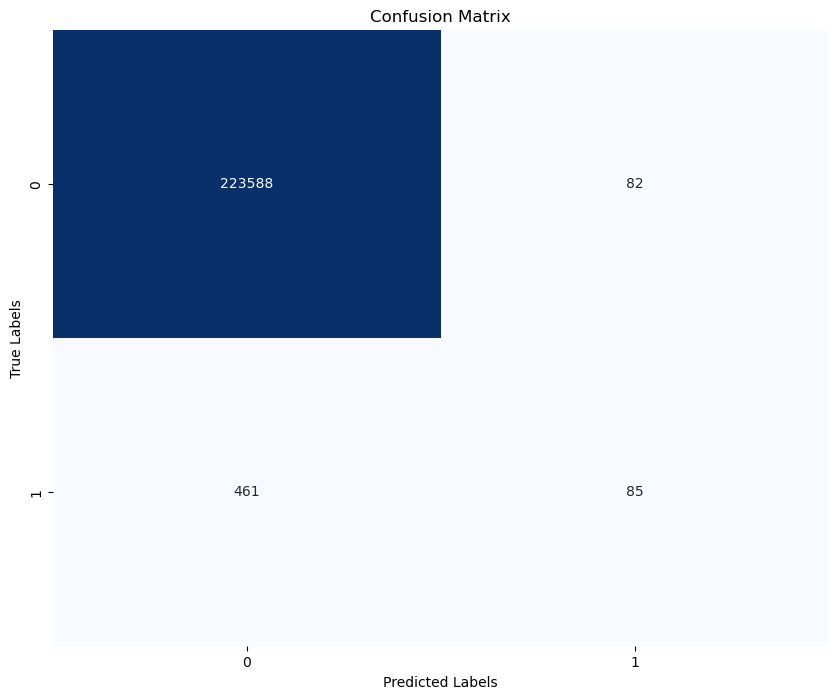

-------------- file 5 -------------------
Model 5 Accuracy: 0.9999614895829322
Model 5 precesion: 1.0
Model 5 recall: 0.9948453608247423
Model 5 fbeta_score: 0.9974160206718347


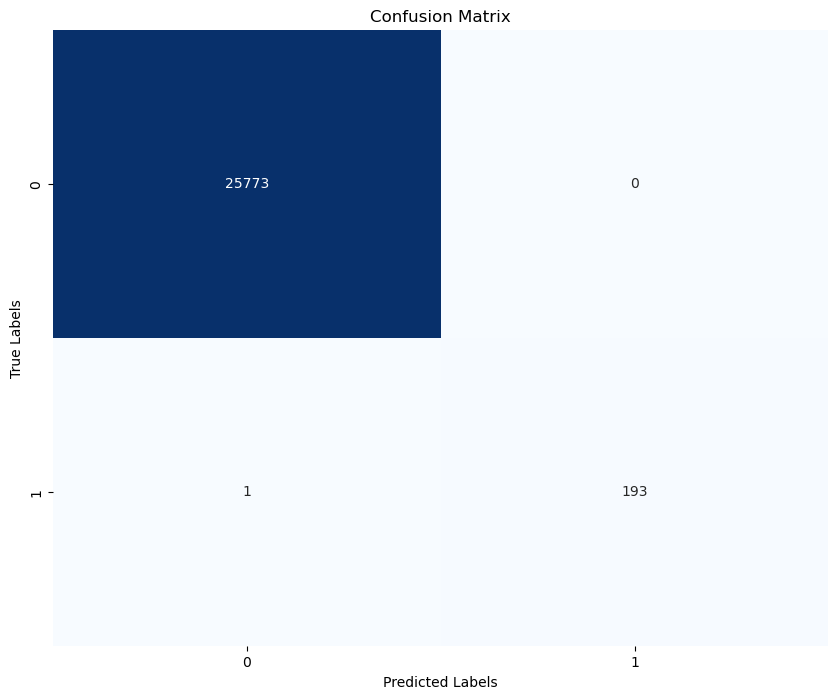

-------------- file 6 -------------------
Model 5 Accuracy: 0.9902401059185573
Model 5 precesion: 0.0
Model 5 recall: 0.0
Model 5 fbeta_score: 0.0


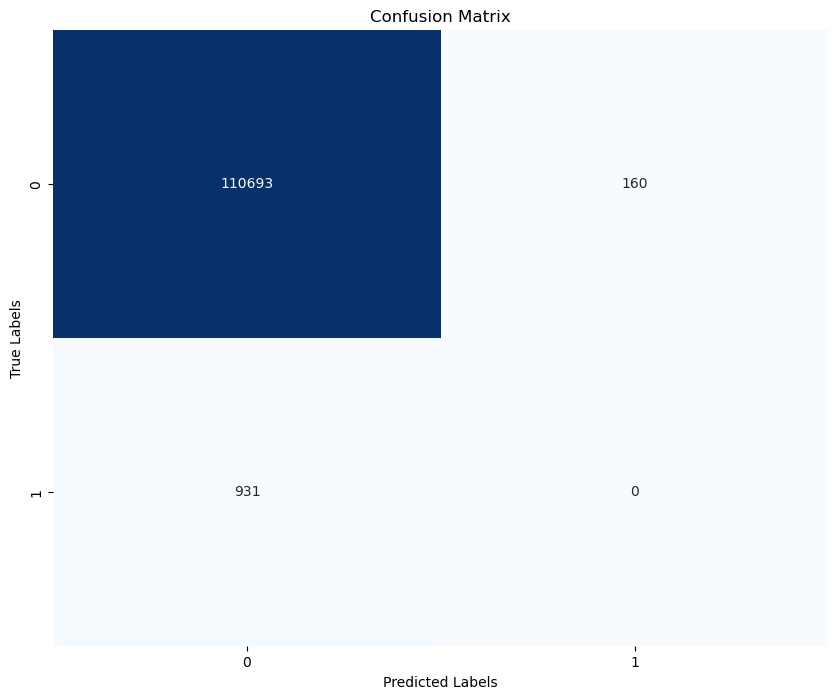

-------------- file 7 -------------------
Model 5 Accuracy: 0.9992987377279102
Model 5 precesion: 0.0
Model 5 recall: 0.0
Model 5 fbeta_score: 0.0


/home/s2316001/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


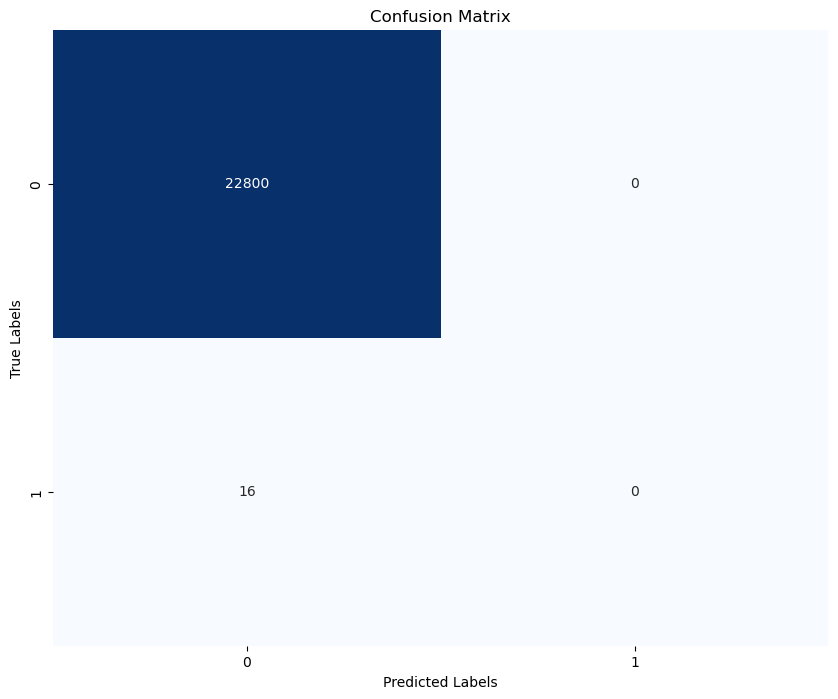

-------------- file 8 -------------------
Model 5 Accuracy: 0.9978996218980919
Model 5 precesion: 0.0
Model 5 recall: 0.0
Model 5 fbeta_score: 0.0


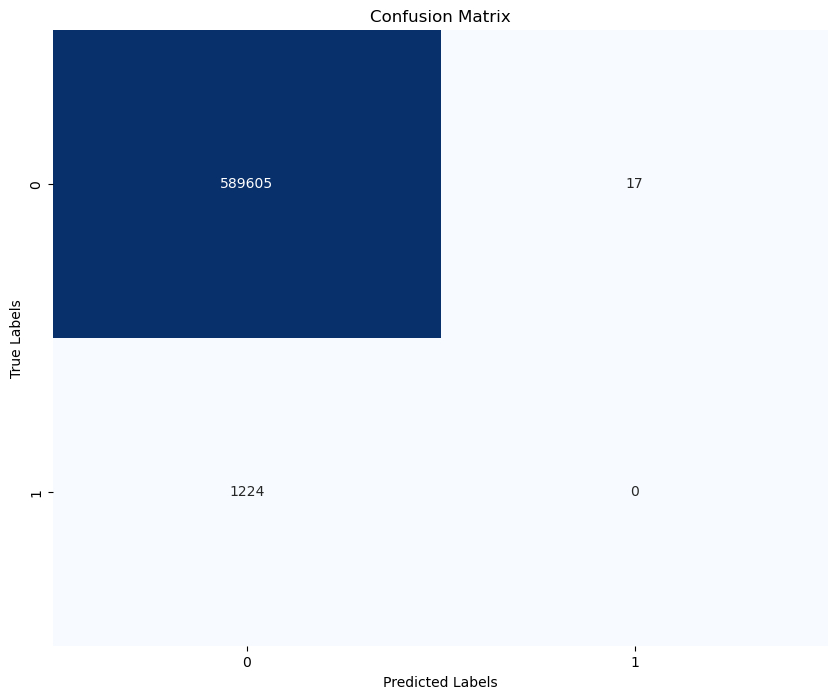

-------------- file 9 -------------------
Model 5 Accuracy: 0.9116866506028714
Model 5 precesion: 0.875
Model 5 recall: 0.0030297292179511455
Model 5 fbeta_score: 0.006038549669766815


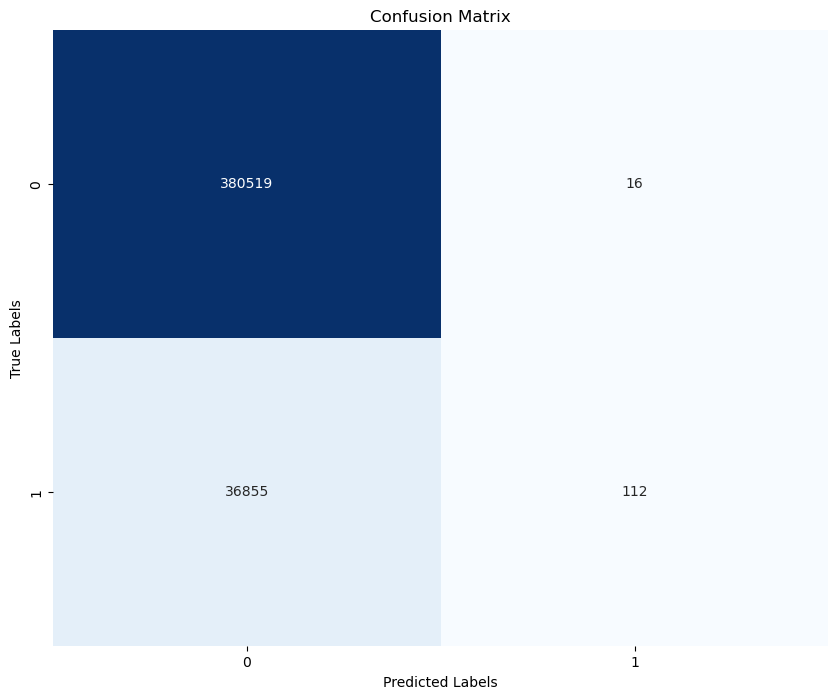

-------------- file 10 -------------------
Model 5 Accuracy: 0.9224496963265244
Model 5 precesion: 0.8426395939086294
Model 5 recall: 0.054656632173095014
Model 5 fbeta_score: 0.10265471089712443


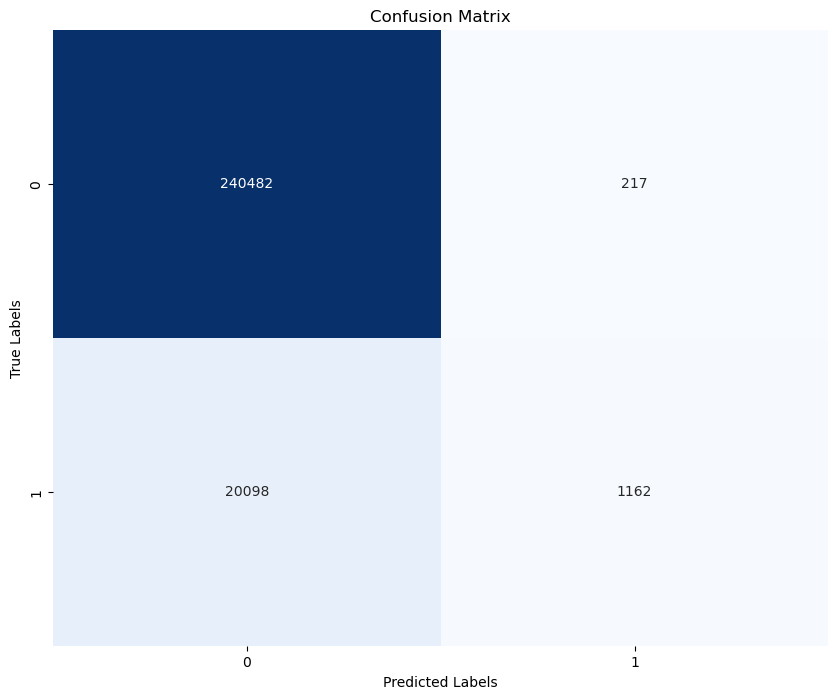

-------------- file 11 -------------------
Model 5 Accuracy: 0.9228474197007133
Model 5 precesion: 0.0
Model 5 recall: 0.0
Model 5 fbeta_score: 0.0


/home/s2316001/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


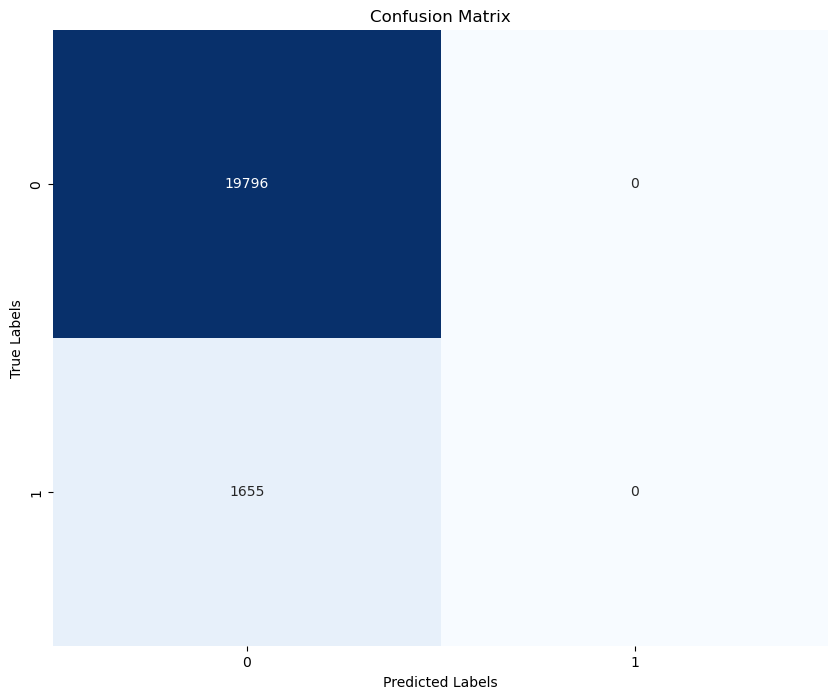

-------------- file 12 -------------------
Model 5 Accuracy: 0.99379368615101
Model 5 precesion: 0.0
Model 5 recall: 0.0
Model 5 fbeta_score: 0.0


/home/s2316001/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


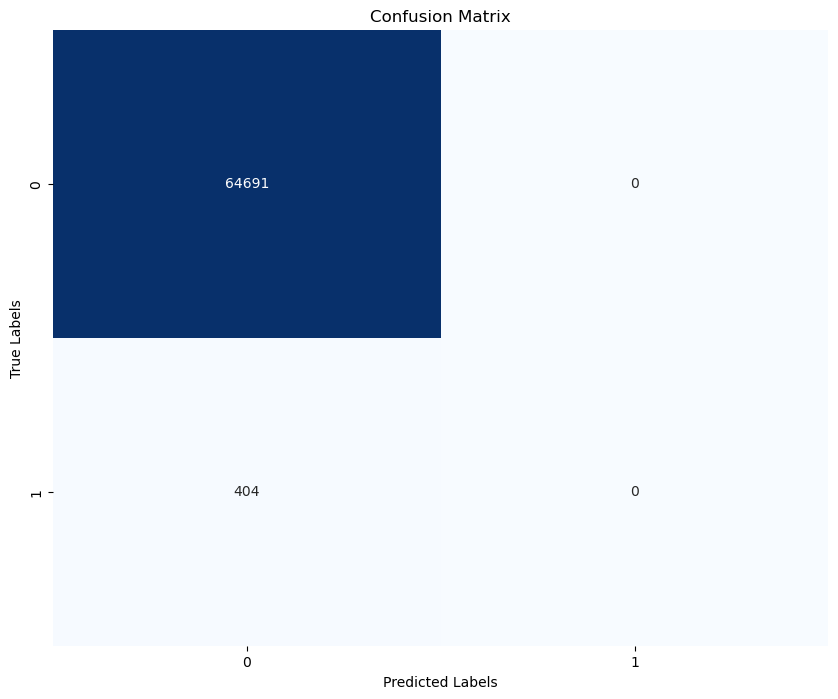

-------------- file 13 -------------------
Model 5 Accuracy: 0.9800249331220944
Model 5 precesion: 0.9303621169916435
Model 5 recall: 0.04175
Model 5 fbeta_score: 0.07991386529489174


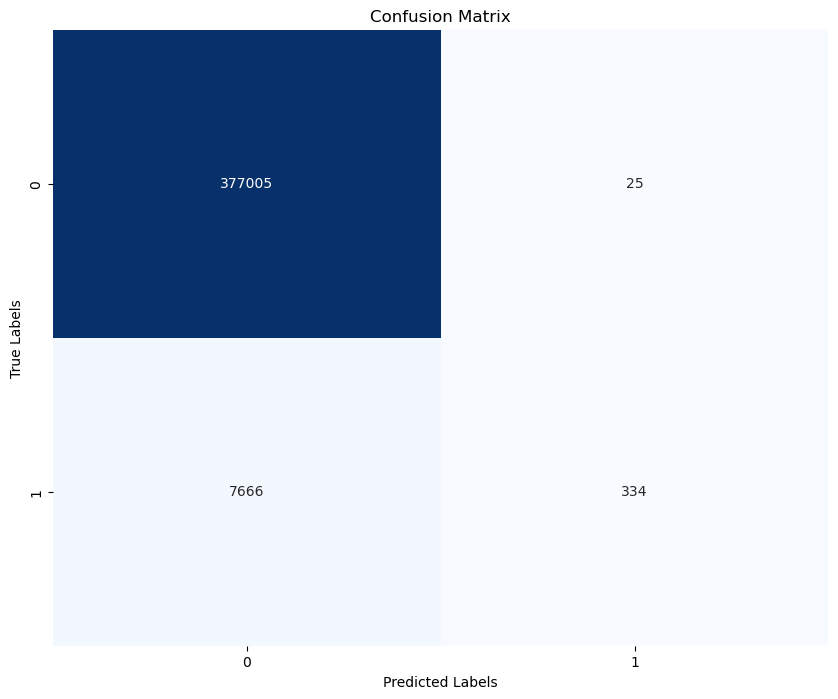

-------------- Model 6 -------------------
-------------- file 1 -------------------
Model 6 Accuracy: 0.985337954571202
Model 6 precesion: 0.0
Model 6 recall: 0.0
Model 6 fbeta_score: 0.0


/home/s2316001/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


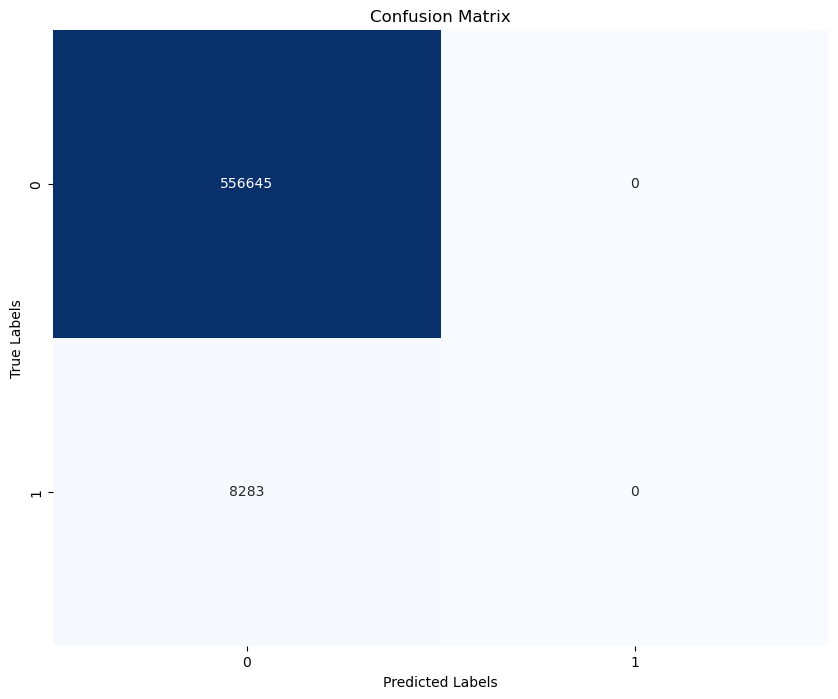

-------------- file 2 -------------------
Model 6 Accuracy: 0.9882198409955064
Model 6 precesion: 0.0
Model 6 recall: 0.0
Model 6 fbeta_score: 0.0


/home/s2316001/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


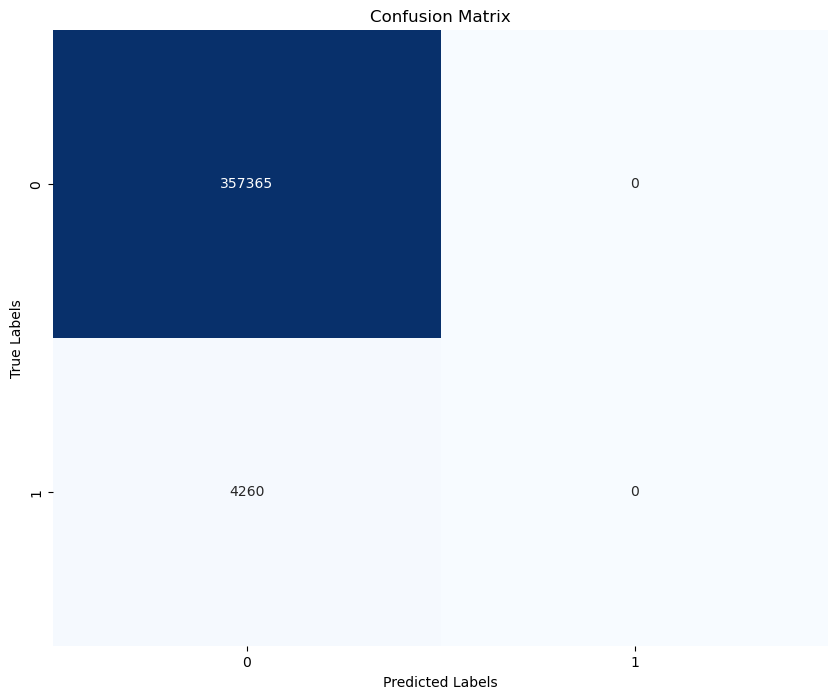

-------------- file 3 -------------------
Model 6 Accuracy: 0.994316058964387
Model 6 precesion: 0.0
Model 6 recall: 0.0
Model 6 fbeta_score: 0.0


/home/s2316001/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


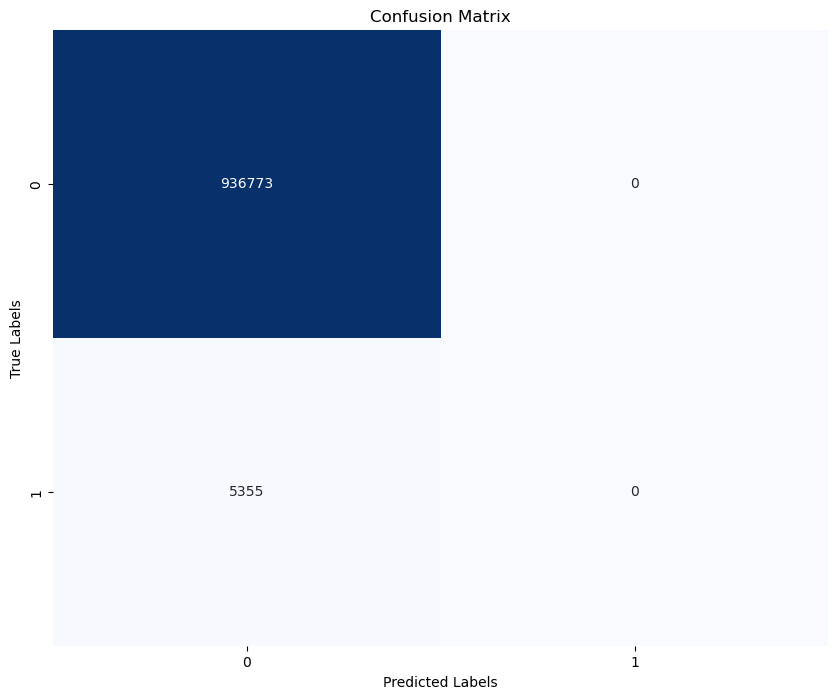

-------------- file 4 -------------------
Model 6 Accuracy: 0.9976674278374424
Model 6 precesion: 0.5608465608465608
Model 6 recall: 0.19413919413919414
Model 6 fbeta_score: 0.2884353741496599


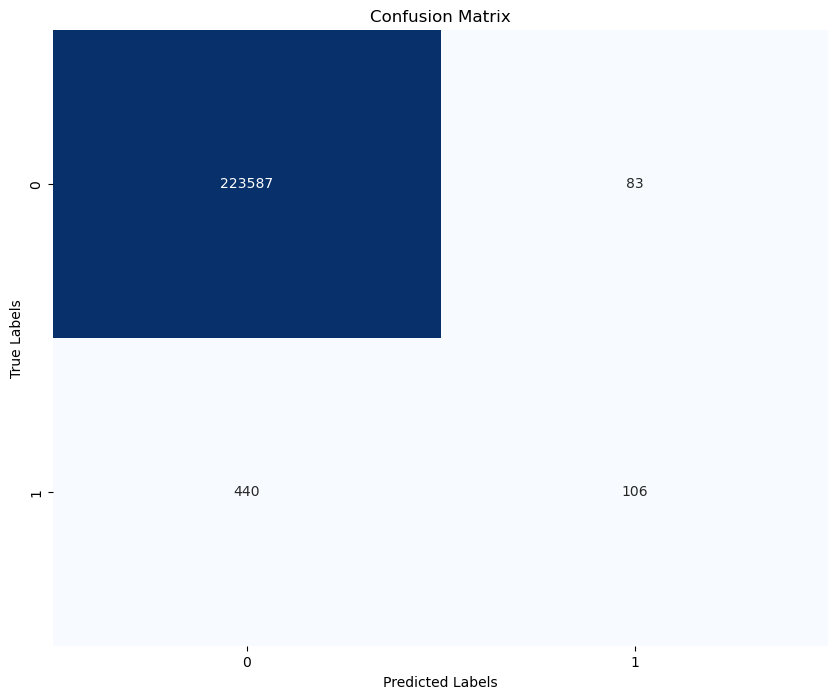

-------------- file 5 -------------------
Model 6 Accuracy: 0.9925289790888435
Model 6 precesion: 0.0
Model 6 recall: 0.0
Model 6 fbeta_score: 0.0


/home/s2316001/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


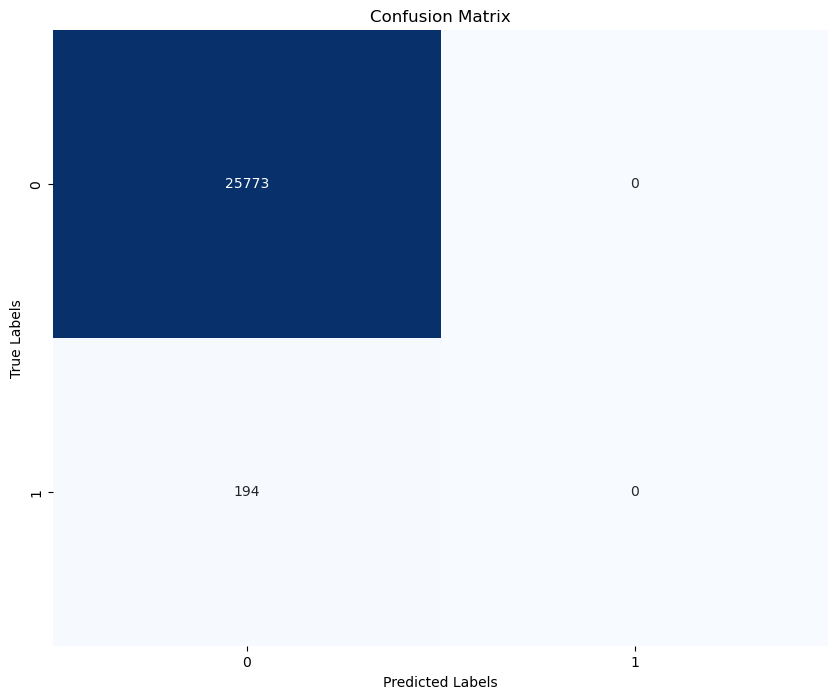

-------------- file 6 -------------------
Model 6 Accuracy: 0.9999910541759107
Model 6 precesion: 1.0
Model 6 recall: 0.9989258861439313
Model 6 fbeta_score: 0.999462654486835


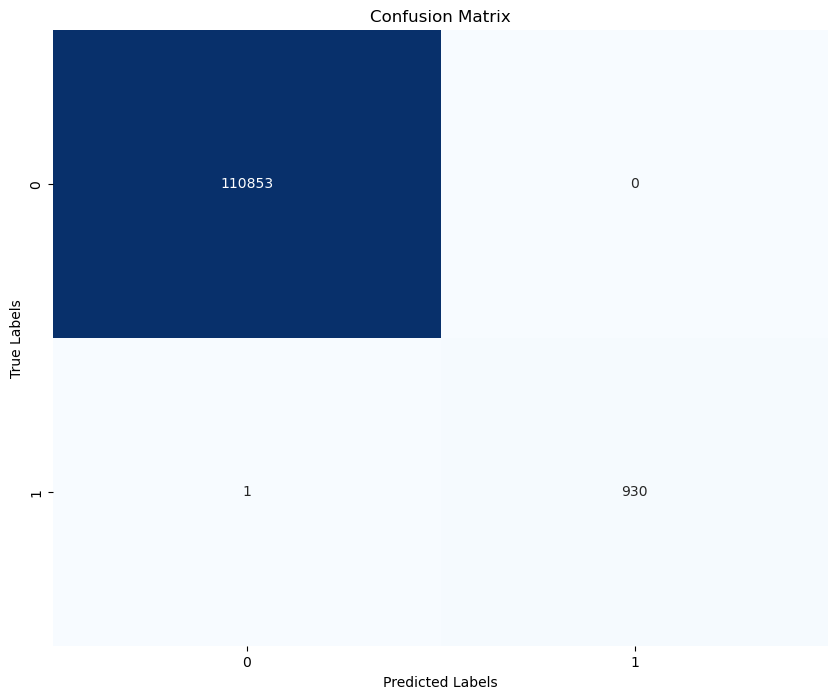

-------------- file 7 -------------------
Model 6 Accuracy: 0.9992987377279102
Model 6 precesion: 0.0
Model 6 recall: 0.0
Model 6 fbeta_score: 0.0


/home/s2316001/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


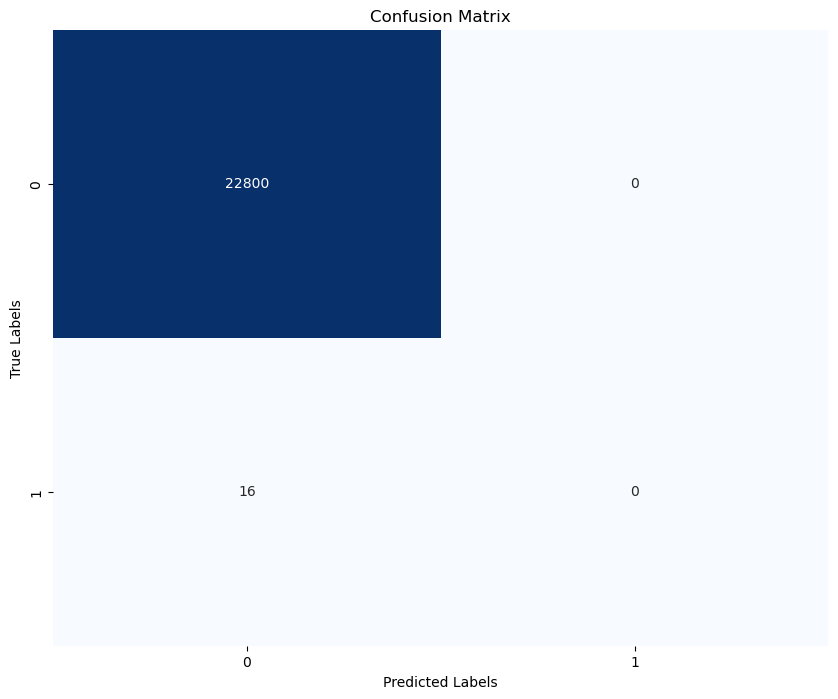

-------------- file 8 -------------------
Model 6 Accuracy: 0.9979283942008578
Model 6 precesion: 0.0
Model 6 recall: 0.0
Model 6 fbeta_score: 0.0


/home/s2316001/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


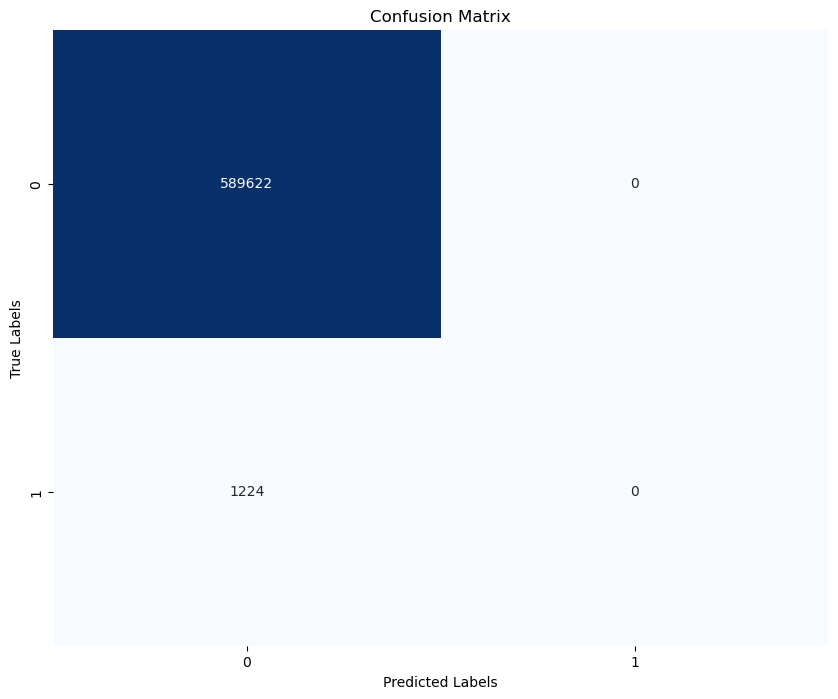

-------------- file 9 -------------------
Model 6 Accuracy: 0.9114567115846152
Model 6 precesion: 0.0
Model 6 recall: 0.0
Model 6 fbeta_score: 0.0


/home/s2316001/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


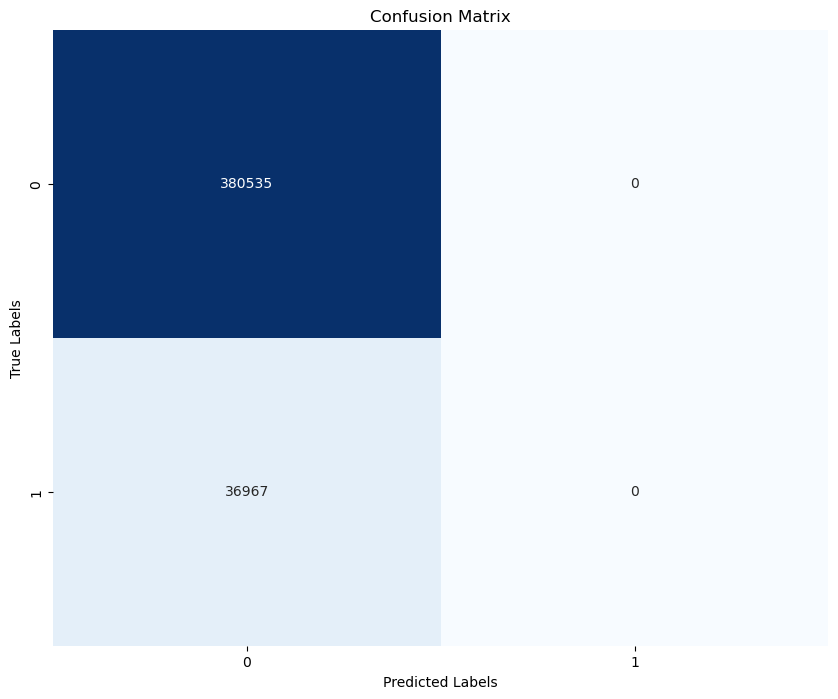

-------------- file 10 -------------------
Model 6 Accuracy: 0.9180864181035964
Model 6 precesion: 0.0
Model 6 recall: 0.0
Model 6 fbeta_score: 0.0


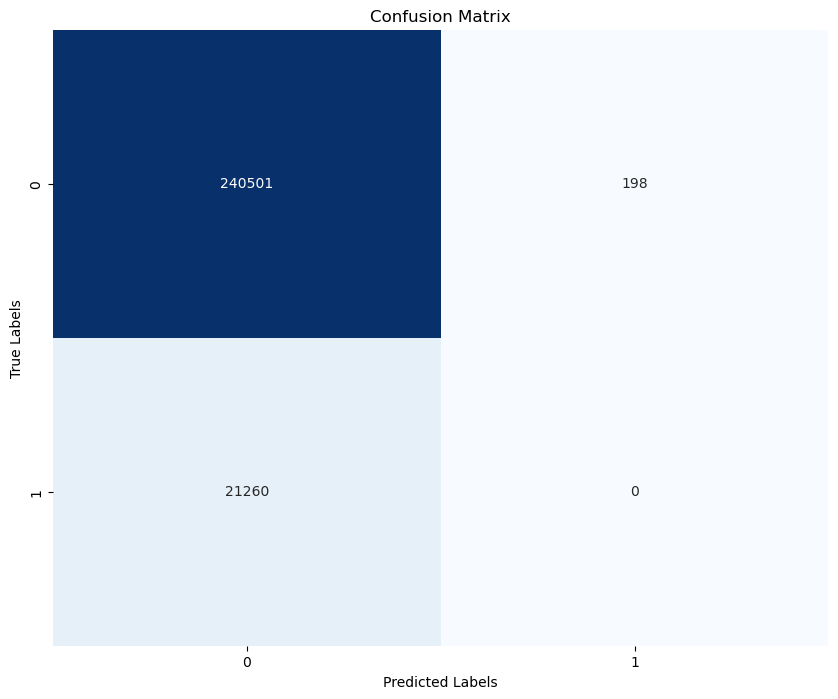

-------------- file 11 -------------------
Model 6 Accuracy: 0.9228474197007133
Model 6 precesion: 0.0
Model 6 recall: 0.0
Model 6 fbeta_score: 0.0


/home/s2316001/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


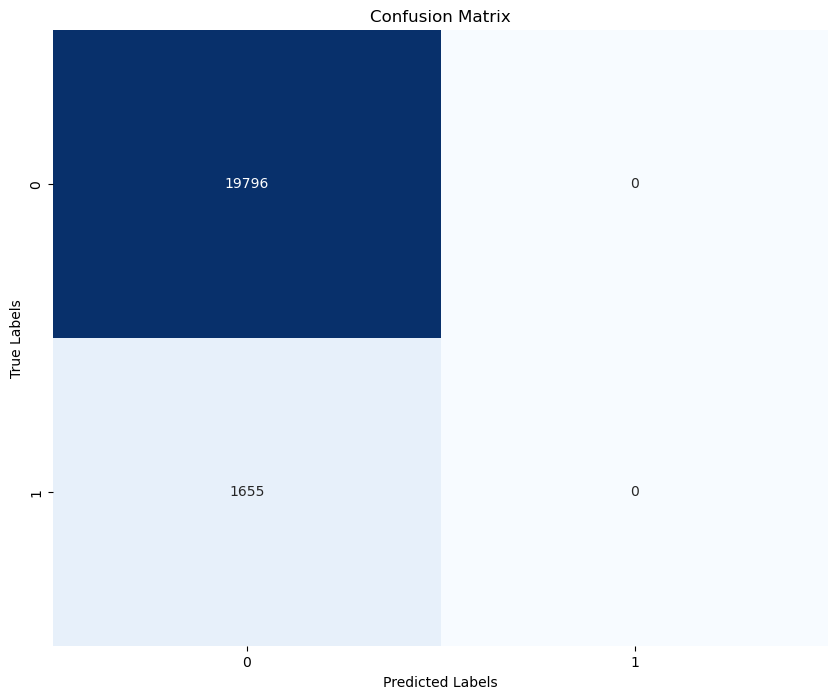

-------------- file 12 -------------------
Model 6 Accuracy: 0.99379368615101
Model 6 precesion: 0.0
Model 6 recall: 0.0
Model 6 fbeta_score: 0.0


/home/s2316001/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


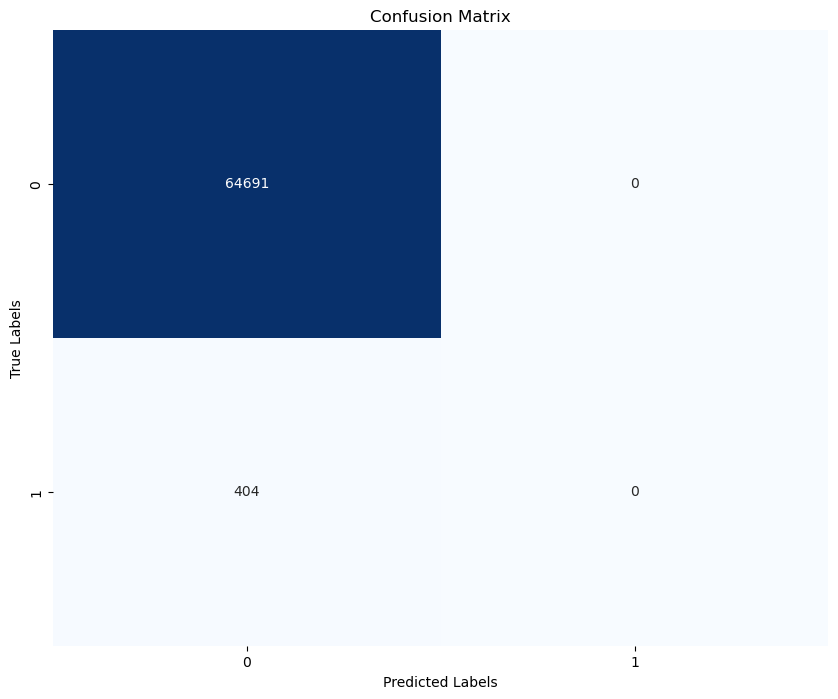

-------------- file 13 -------------------
Model 6 Accuracy: 0.9792223982546815
Model 6 precesion: 0.0
Model 6 recall: 0.0
Model 6 fbeta_score: 0.0


/home/s2316001/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


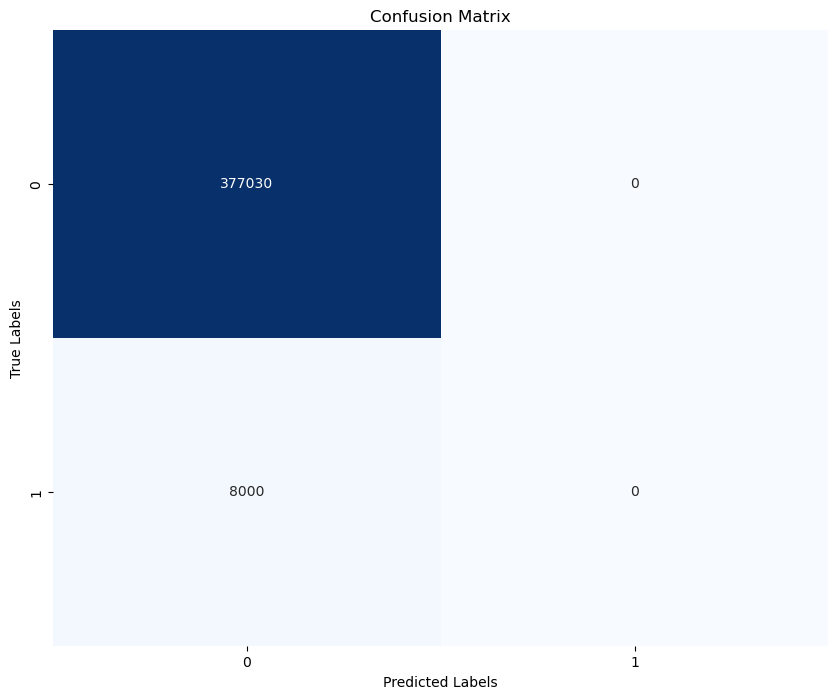

-------------- Model 7 -------------------
-------------- file 1 -------------------
Model 7 Accuracy: 0.985337954571202
Model 7 precesion: 0.0
Model 7 recall: 0.0
Model 7 fbeta_score: 0.0


/home/s2316001/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


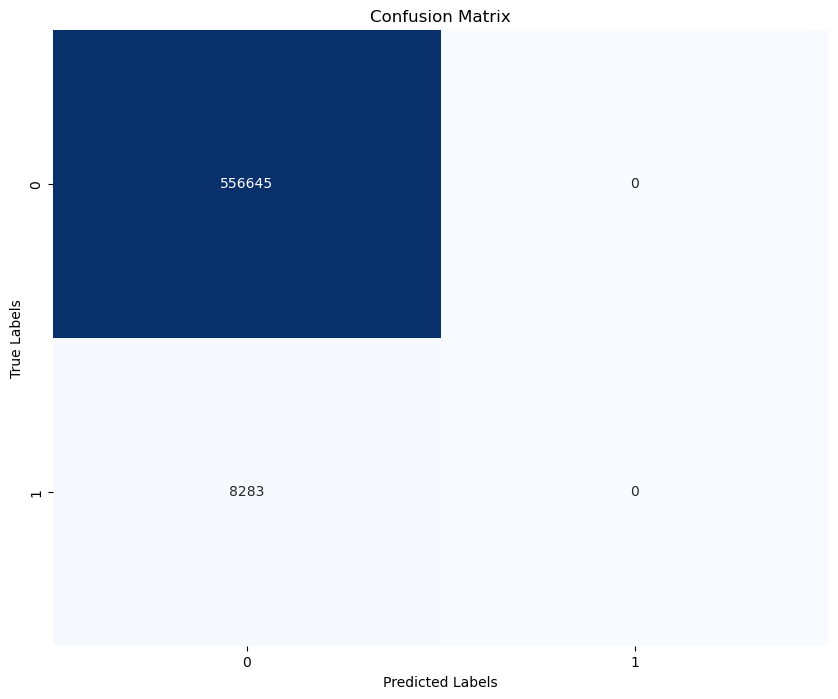

-------------- file 2 -------------------
Model 7 Accuracy: 0.9882198409955064
Model 7 precesion: 0.0
Model 7 recall: 0.0
Model 7 fbeta_score: 0.0


/home/s2316001/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


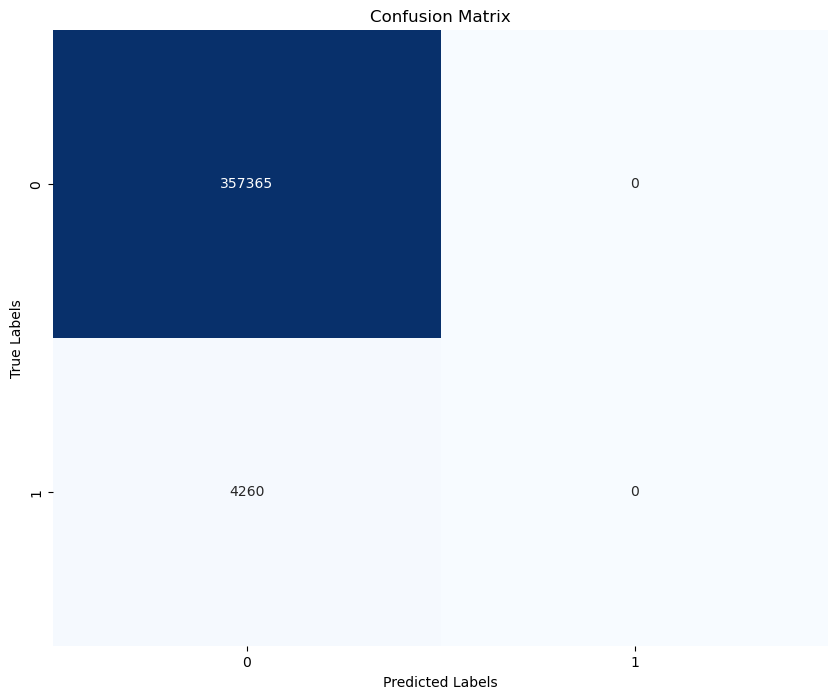

-------------- file 3 -------------------
Model 7 Accuracy: 0.994316058964387
Model 7 precesion: 0.0
Model 7 recall: 0.0
Model 7 fbeta_score: 0.0


/home/s2316001/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


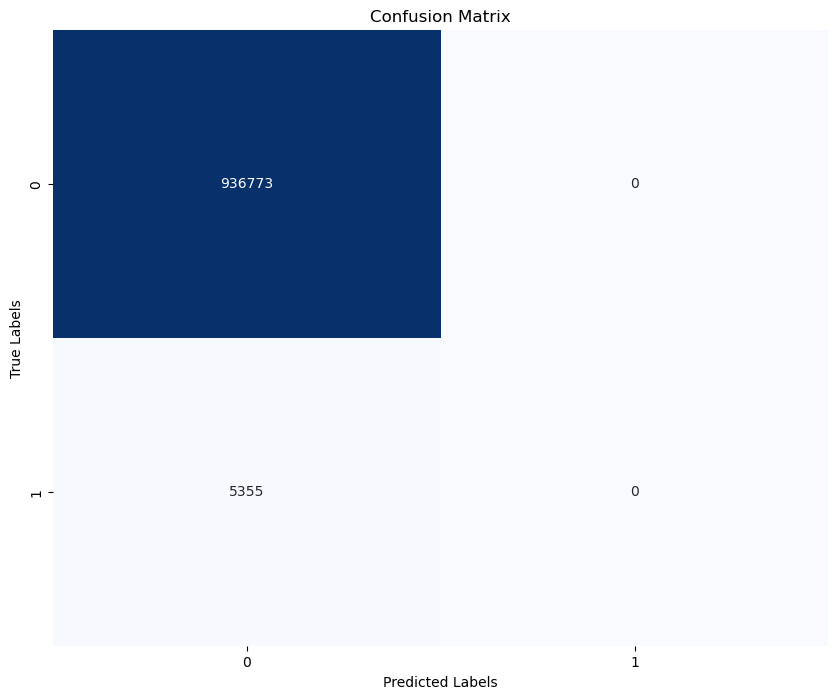

-------------- file 4 -------------------
Model 7 Accuracy: 0.9975648481821101
Model 7 precesion: 0.0
Model 7 recall: 0.0
Model 7 fbeta_score: 0.0


/home/s2316001/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


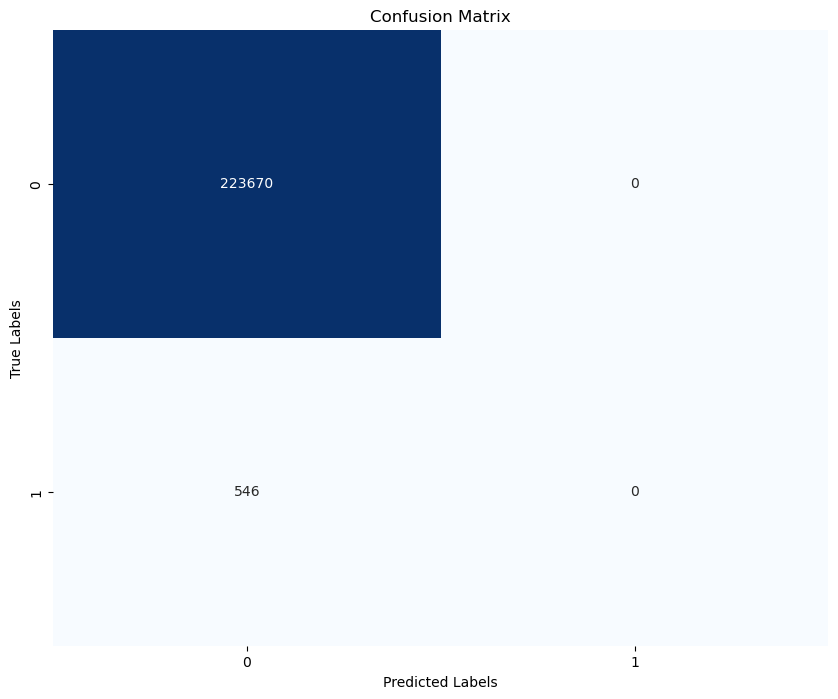

-------------- file 5 -------------------
Model 7 Accuracy: 0.9925289790888435
Model 7 precesion: 0.0
Model 7 recall: 0.0
Model 7 fbeta_score: 0.0


/home/s2316001/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


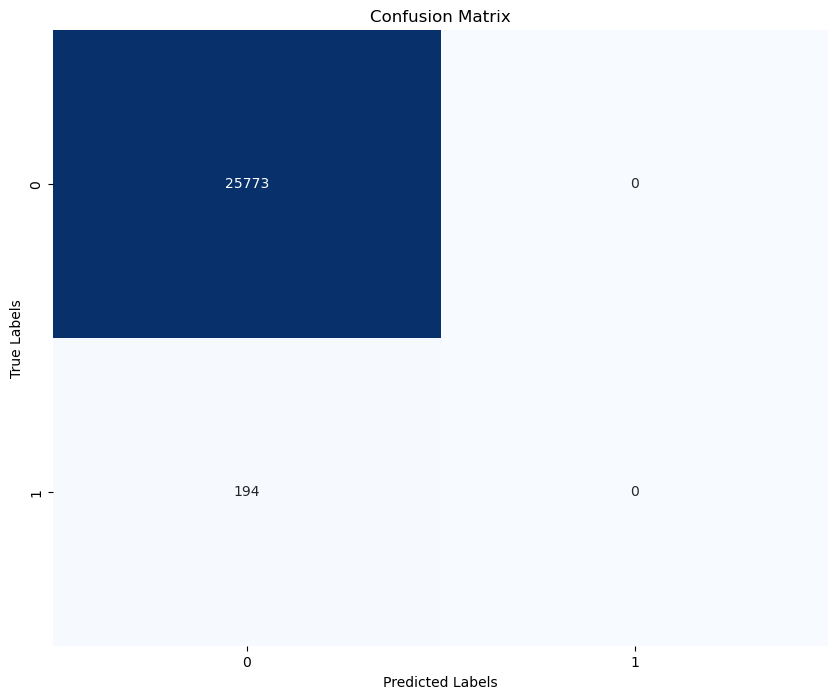

-------------- file 6 -------------------
Model 7 Accuracy: 0.9916714377728476
Model 7 precesion: 0.0
Model 7 recall: 0.0
Model 7 fbeta_score: 0.0


/home/s2316001/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


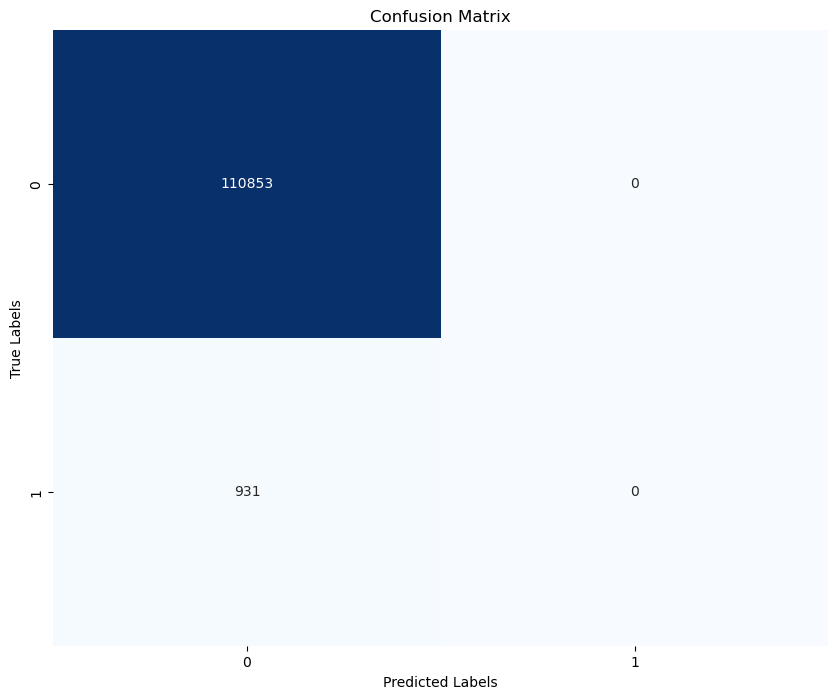

-------------- file 7 -------------------
Model 7 Accuracy: 0.9998246844319776
Model 7 precesion: 1.0
Model 7 recall: 0.75
Model 7 fbeta_score: 0.8571428571428571


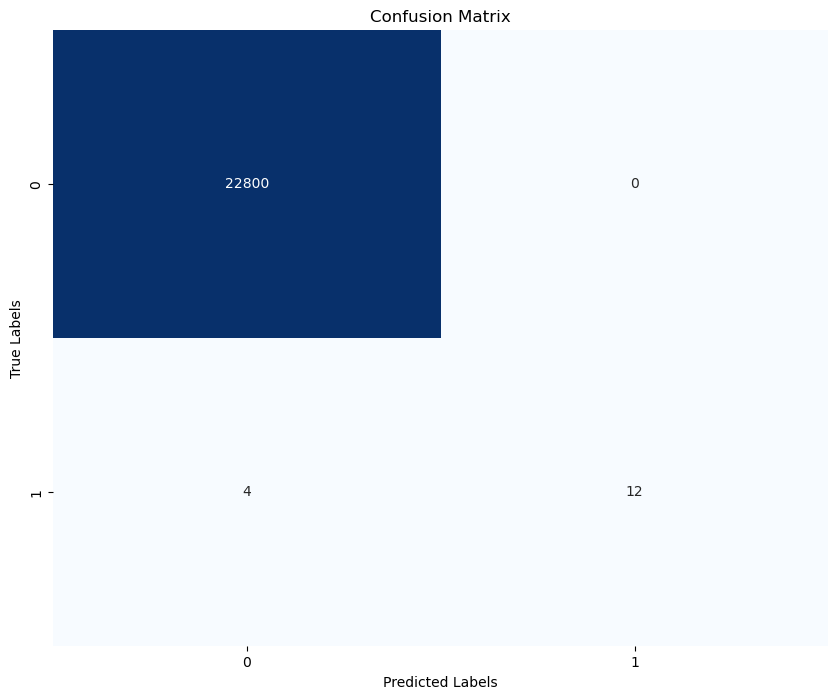

-------------- file 8 -------------------
Model 7 Accuracy: 0.9979283942008578
Model 7 precesion: 0.0
Model 7 recall: 0.0
Model 7 fbeta_score: 0.0


/home/s2316001/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


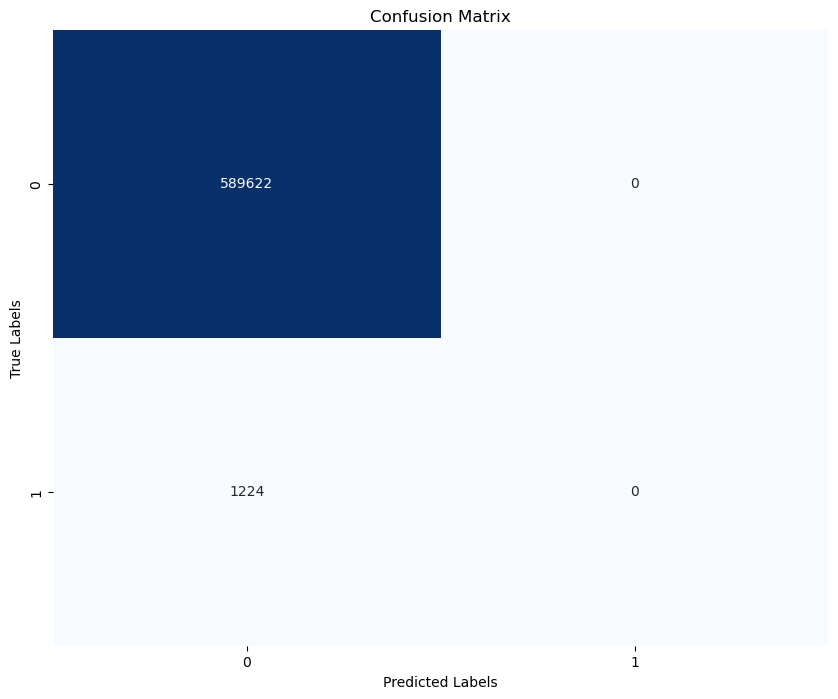

-------------- file 9 -------------------
Model 7 Accuracy: 0.9114567115846152
Model 7 precesion: 0.0
Model 7 recall: 0.0
Model 7 fbeta_score: 0.0


/home/s2316001/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


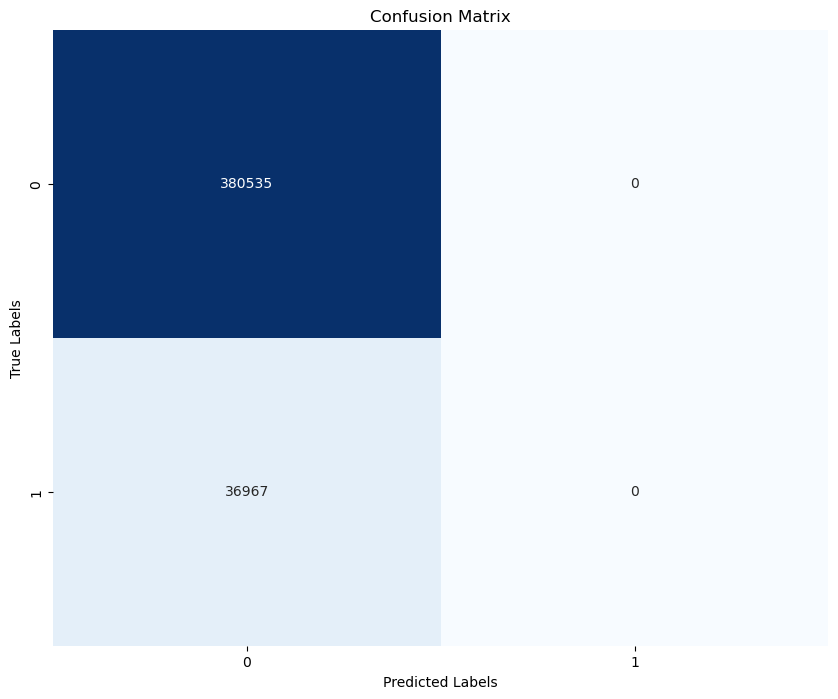

-------------- file 10 -------------------
Model 7 Accuracy: 0.9188422615752847
Model 7 precesion: 0.0
Model 7 recall: 0.0
Model 7 fbeta_score: 0.0


/home/s2316001/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


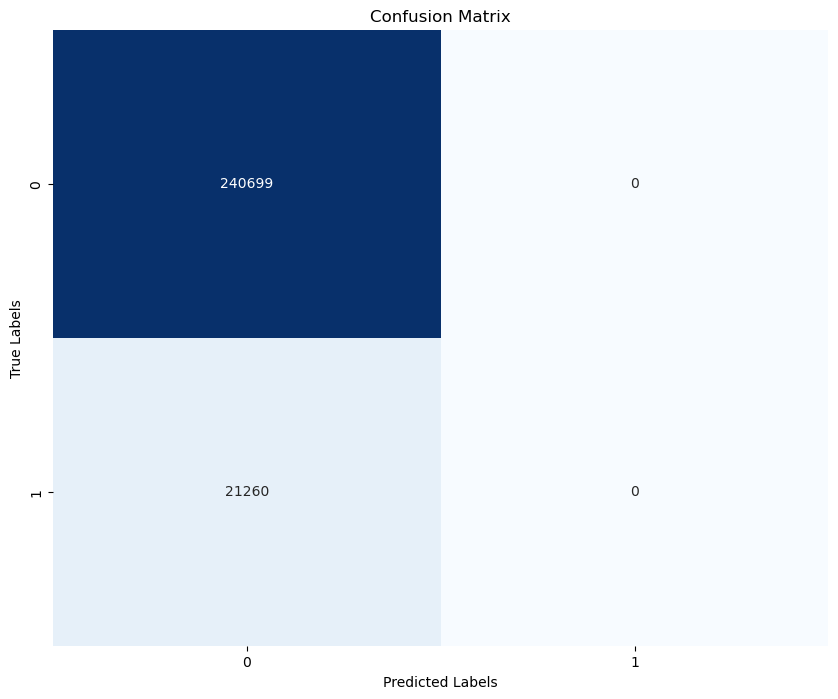

-------------- file 11 -------------------
Model 7 Accuracy: 0.9228474197007133
Model 7 precesion: 0.0
Model 7 recall: 0.0
Model 7 fbeta_score: 0.0


/home/s2316001/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


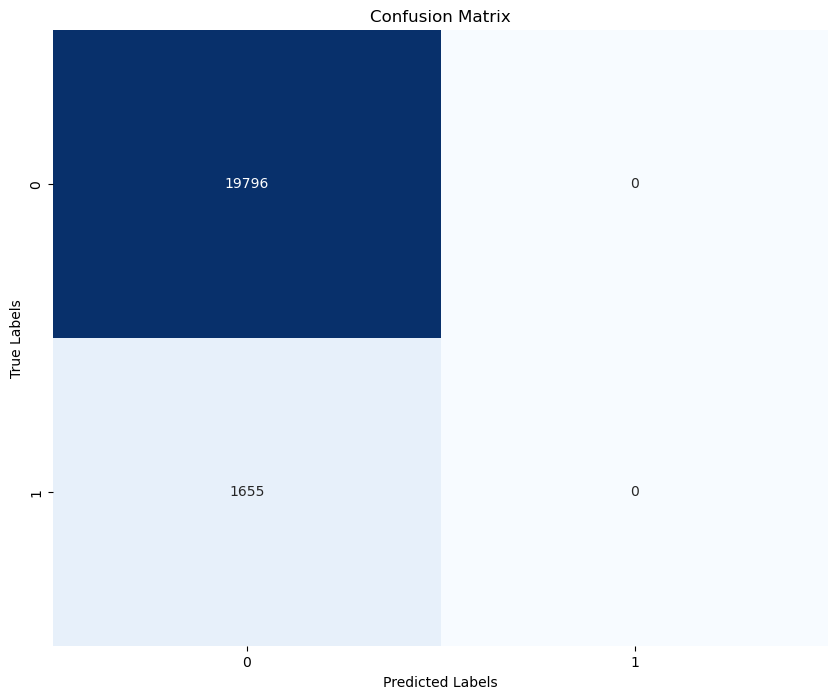

-------------- file 12 -------------------
Model 7 Accuracy: 0.99379368615101
Model 7 precesion: 0.0
Model 7 recall: 0.0
Model 7 fbeta_score: 0.0


/home/s2316001/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


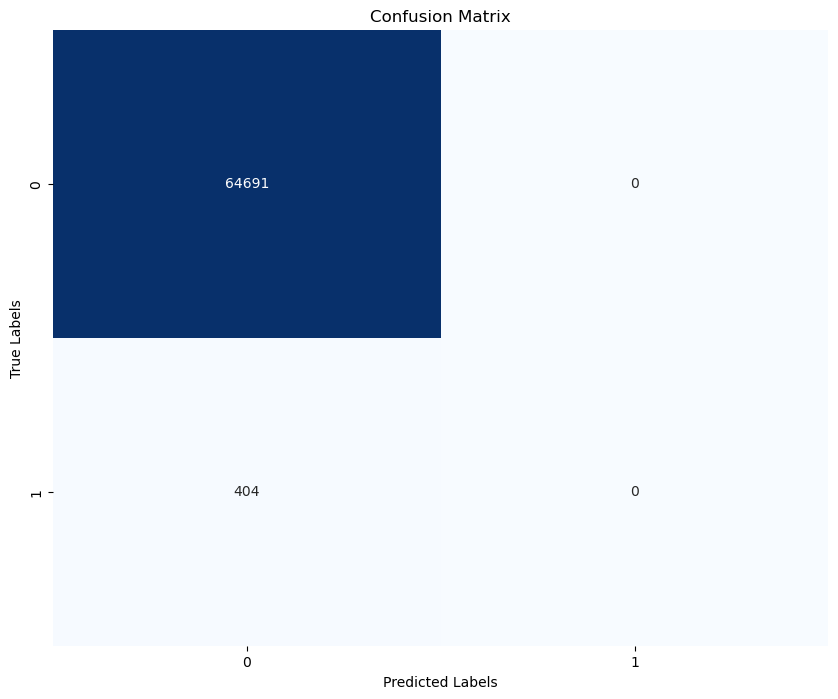

-------------- file 13 -------------------
Model 7 Accuracy: 0.9792223982546815
Model 7 precesion: 0.0
Model 7 recall: 0.0
Model 7 fbeta_score: 0.0


/home/s2316001/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


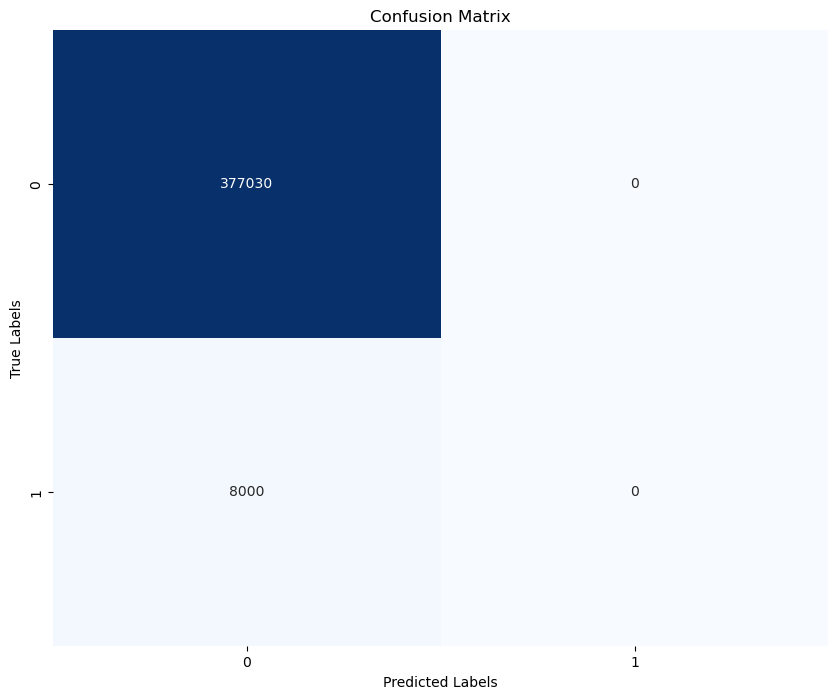

-------------- Model 8 -------------------
-------------- file 1 -------------------
Model 8 Accuracy: 0.985337954571202
Model 8 precesion: 0.0
Model 8 recall: 0.0
Model 8 fbeta_score: 0.0


/home/s2316001/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


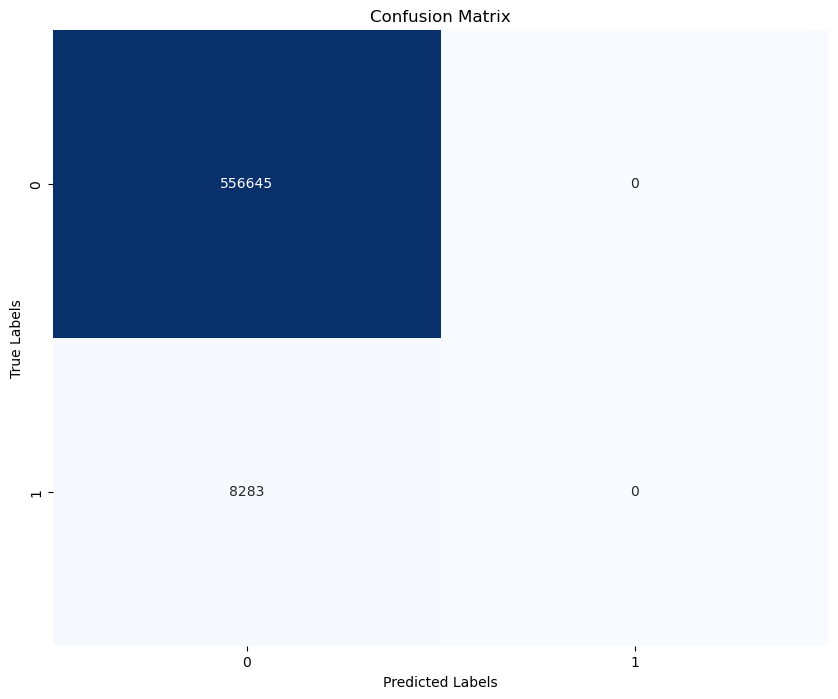

-------------- file 2 -------------------
Model 8 Accuracy: 0.9882198409955064
Model 8 precesion: 0.0
Model 8 recall: 0.0
Model 8 fbeta_score: 0.0


/home/s2316001/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


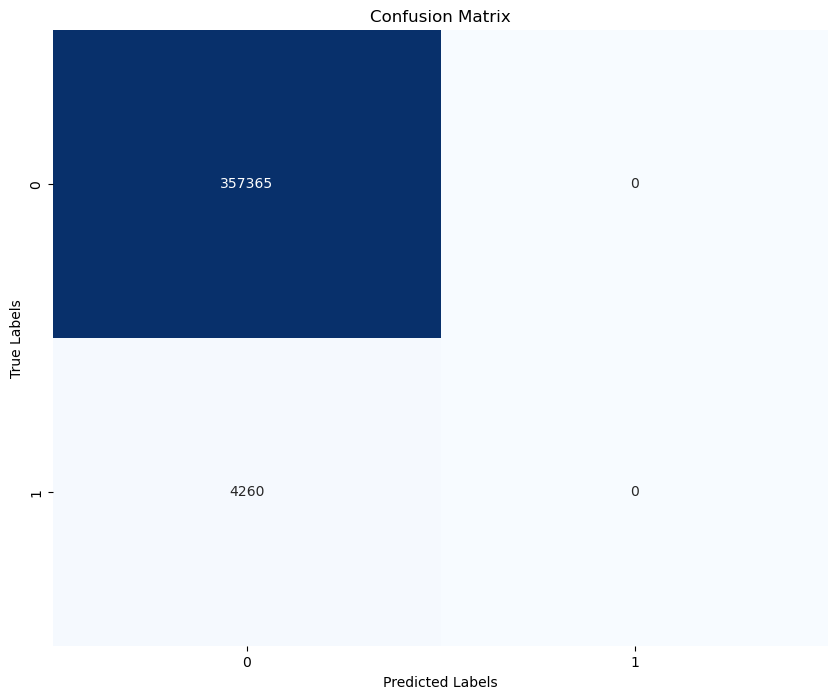

-------------- file 3 -------------------
Model 8 Accuracy: 0.994316058964387
Model 8 precesion: 0.0
Model 8 recall: 0.0
Model 8 fbeta_score: 0.0


/home/s2316001/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


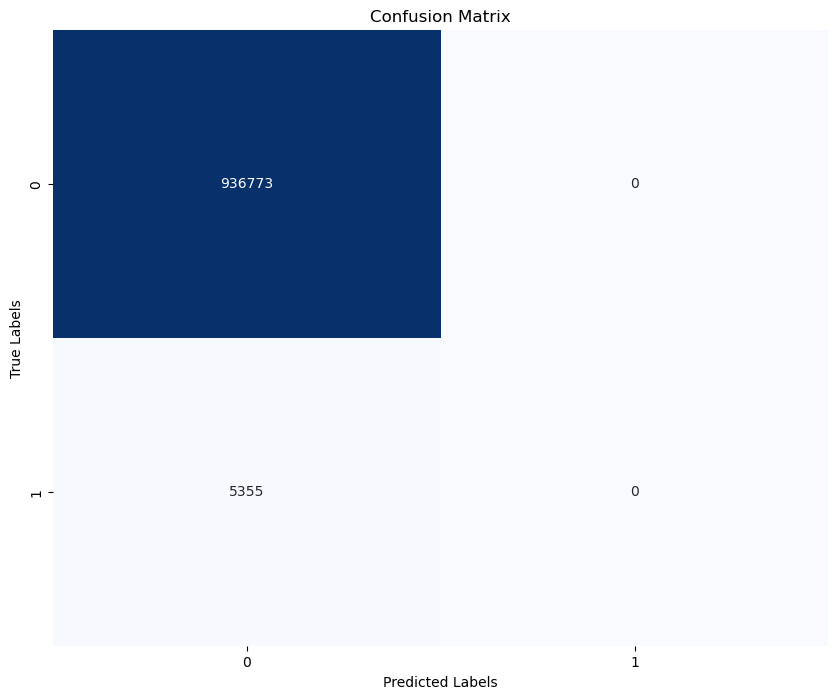

-------------- file 4 -------------------
Model 8 Accuracy: 0.9975648481821101
Model 8 precesion: 0.0
Model 8 recall: 0.0
Model 8 fbeta_score: 0.0


/home/s2316001/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


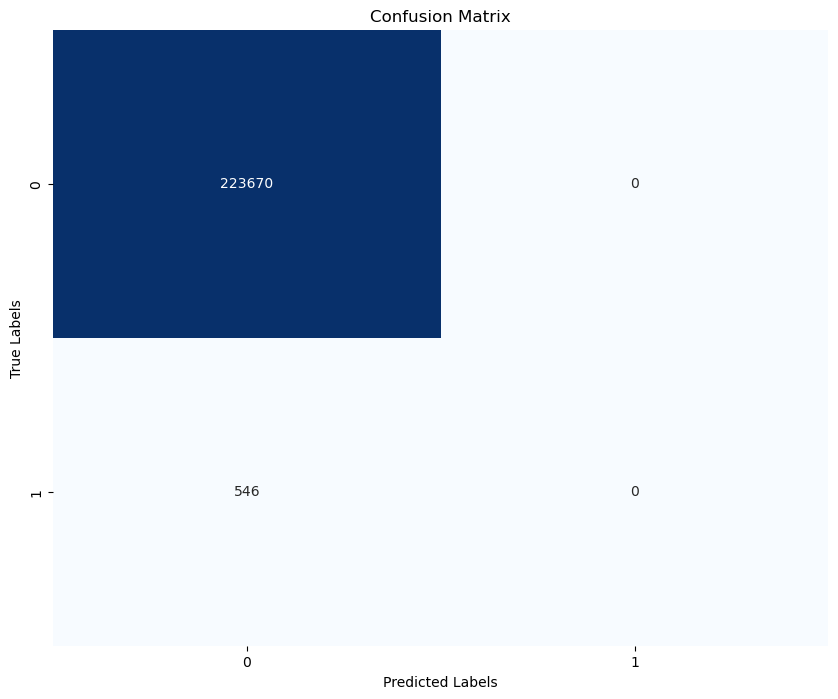

-------------- file 5 -------------------
Model 8 Accuracy: 0.9925289790888435
Model 8 precesion: 0.0
Model 8 recall: 0.0
Model 8 fbeta_score: 0.0


/home/s2316001/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


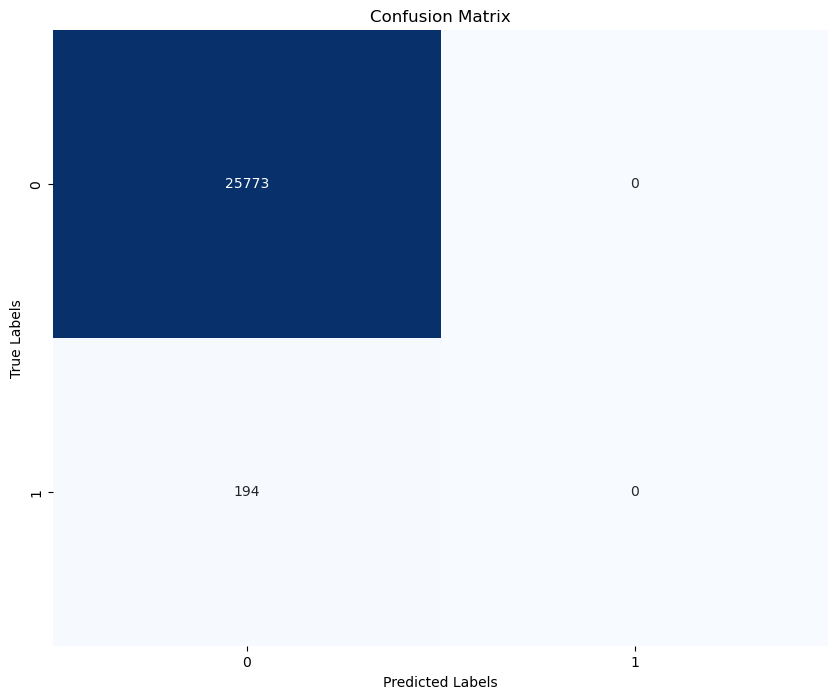

-------------- file 6 -------------------
Model 8 Accuracy: 0.9916714377728476
Model 8 precesion: 0.0
Model 8 recall: 0.0
Model 8 fbeta_score: 0.0


/home/s2316001/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


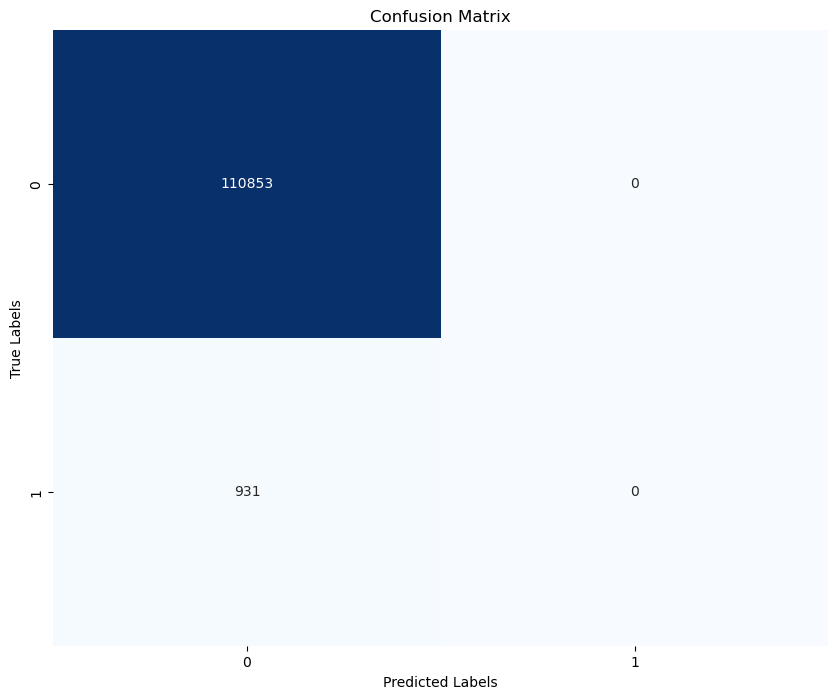

-------------- file 7 -------------------
Model 8 Accuracy: 0.9992987377279102
Model 8 precesion: 0.0
Model 8 recall: 0.0
Model 8 fbeta_score: 0.0


/home/s2316001/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


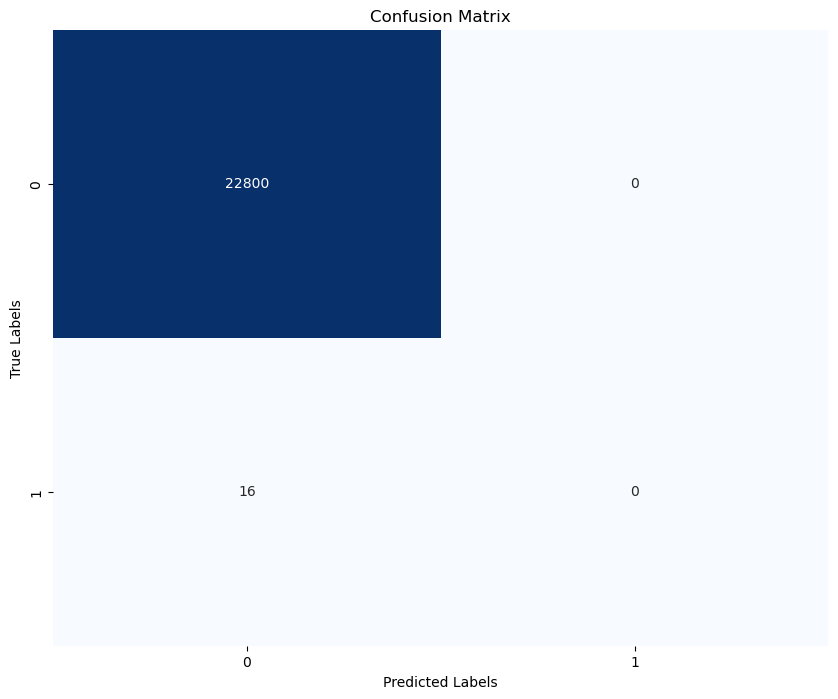

-------------- file 8 -------------------
Model 8 Accuracy: 0.9999001431845185
Model 8 precesion: 1.0
Model 8 recall: 0.951797385620915
Model 8 fbeta_score: 0.9753034742570112


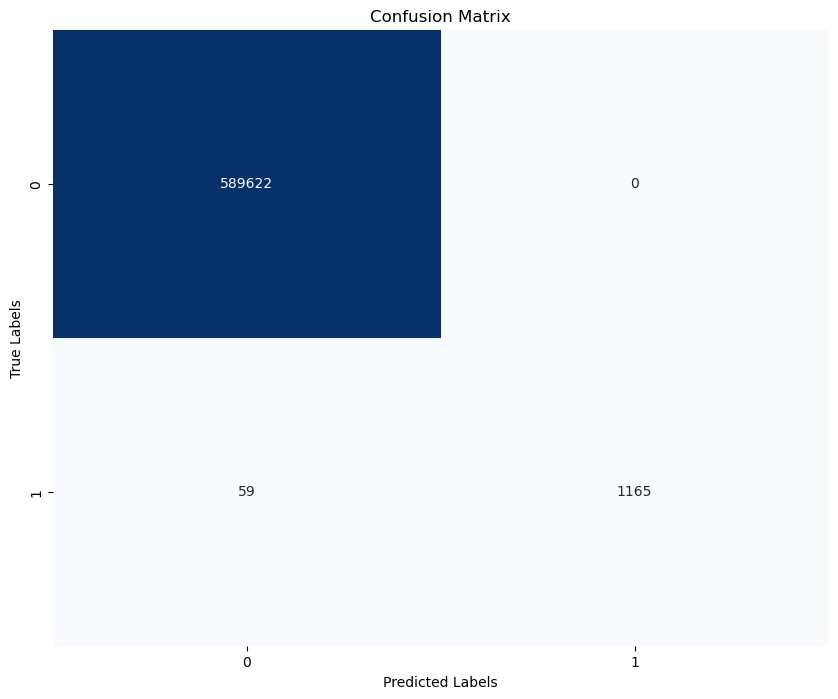

-------------- file 9 -------------------
Model 8 Accuracy: 0.9114567115846152
Model 8 precesion: 0.0
Model 8 recall: 0.0
Model 8 fbeta_score: 0.0


/home/s2316001/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


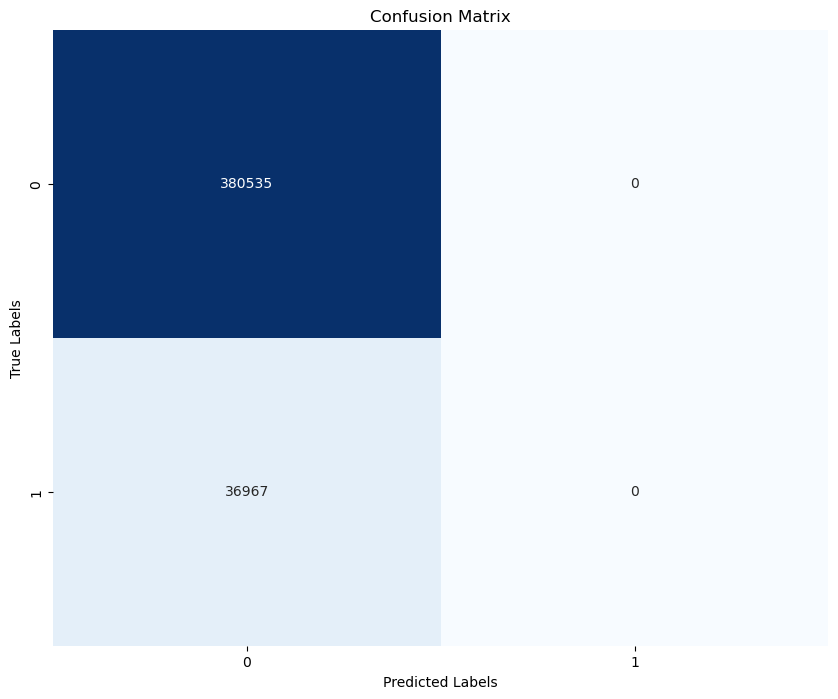

-------------- file 10 -------------------
Model 8 Accuracy: 0.9188422615752847
Model 8 precesion: 0.0
Model 8 recall: 0.0
Model 8 fbeta_score: 0.0


/home/s2316001/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


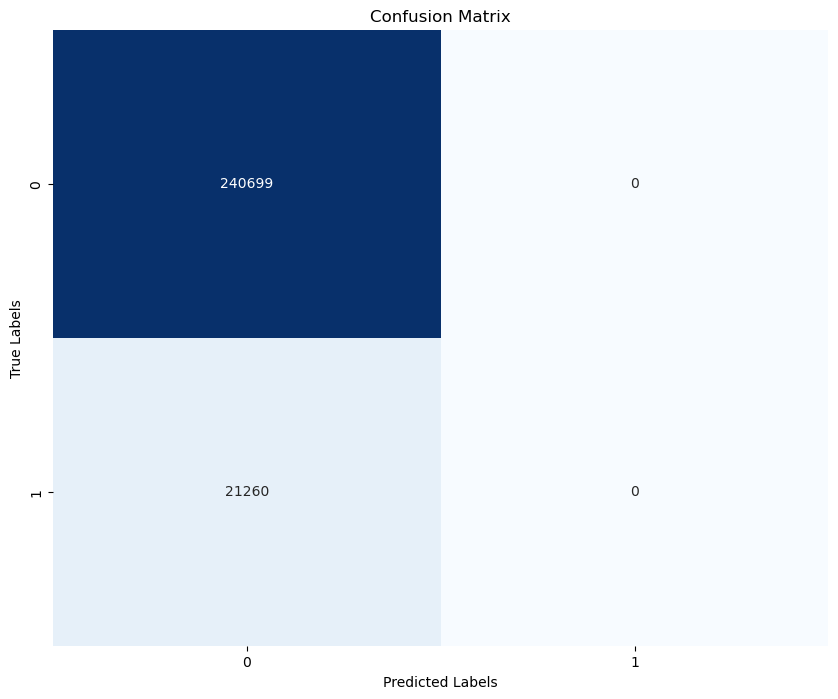

-------------- file 11 -------------------
Model 8 Accuracy: 0.9228474197007133
Model 8 precesion: 0.0
Model 8 recall: 0.0
Model 8 fbeta_score: 0.0


/home/s2316001/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


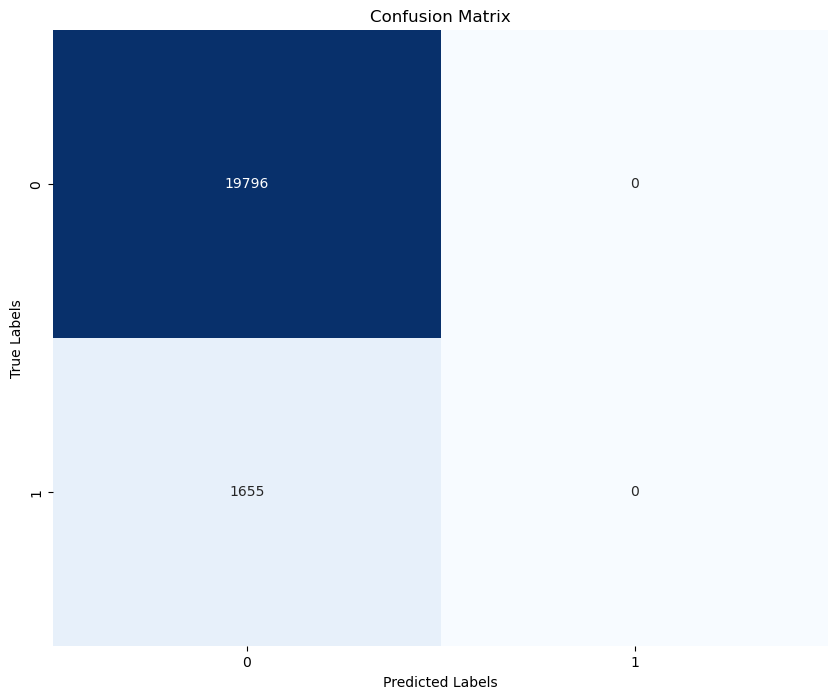

-------------- file 12 -------------------
Model 8 Accuracy: 0.99379368615101
Model 8 precesion: 0.0
Model 8 recall: 0.0
Model 8 fbeta_score: 0.0


/home/s2316001/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


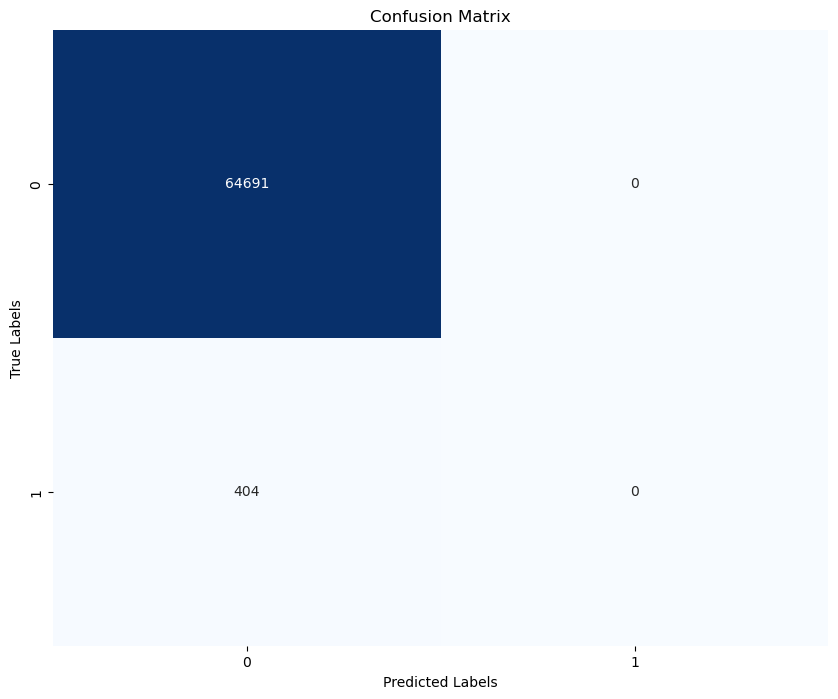

-------------- file 13 -------------------
Model 8 Accuracy: 0.9792223982546815
Model 8 precesion: 0.0
Model 8 recall: 0.0
Model 8 fbeta_score: 0.0


/home/s2316001/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


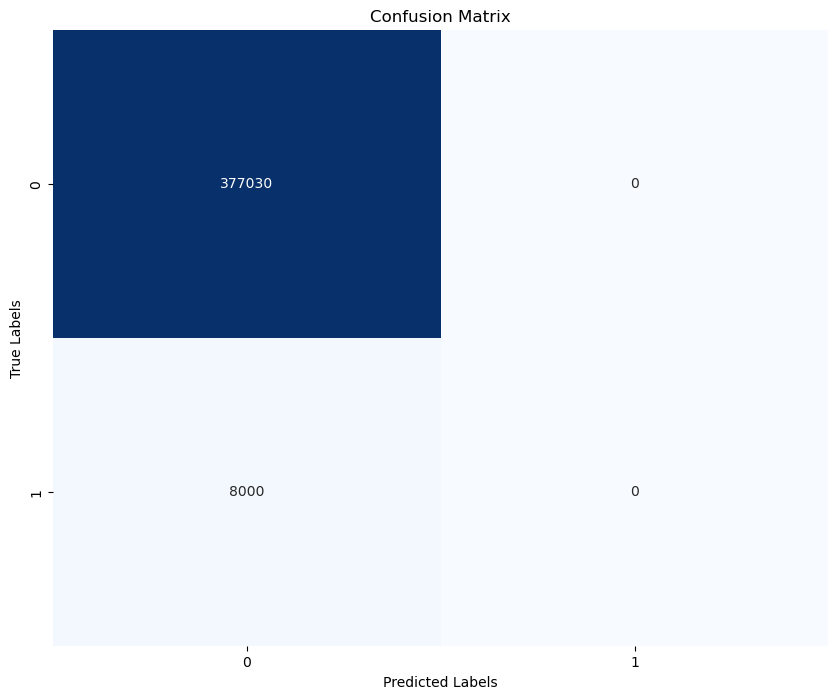

-------------- Model 9 -------------------
-------------- file 1 -------------------
Model 9 Accuracy: 0.9853308740228843
Model 9 precesion: 0.0
Model 9 recall: 0.0
Model 9 fbeta_score: 0.0


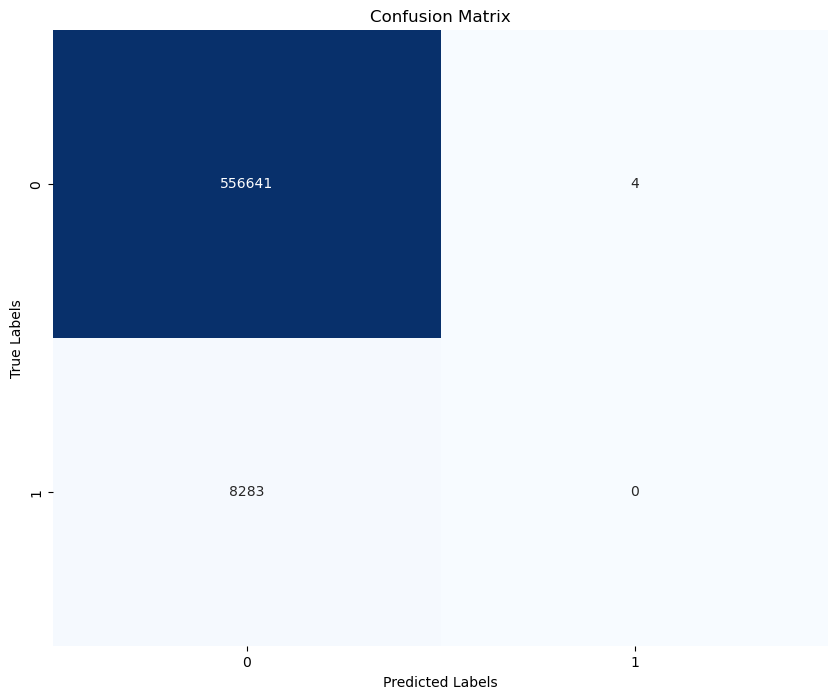

-------------- file 2 -------------------
Model 9 Accuracy: 0.9882198409955064
Model 9 precesion: 0.0
Model 9 recall: 0.0
Model 9 fbeta_score: 0.0


/home/s2316001/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


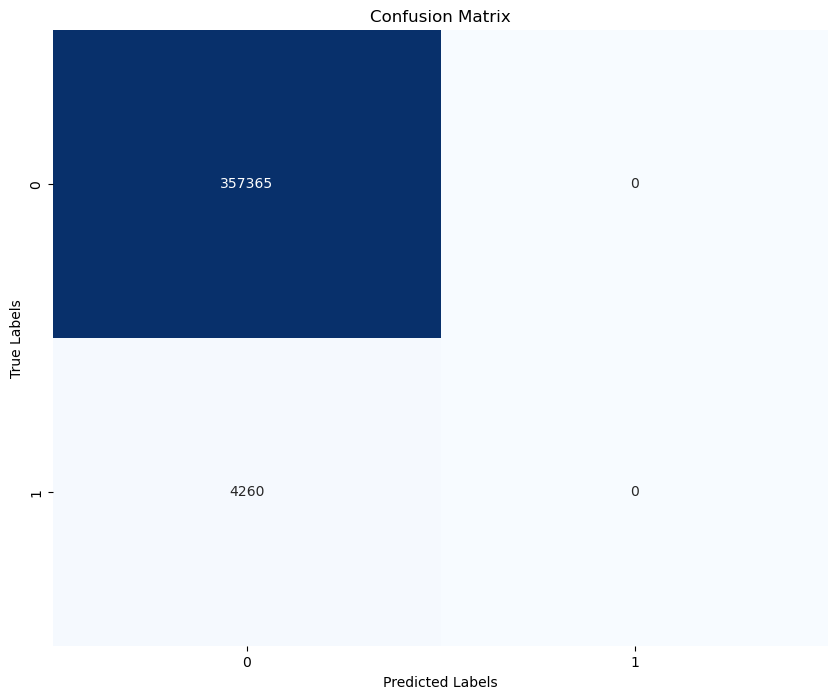

-------------- file 3 -------------------
Model 9 Accuracy: 0.994287400438157
Model 9 precesion: 0.0
Model 9 recall: 0.0
Model 9 fbeta_score: 0.0


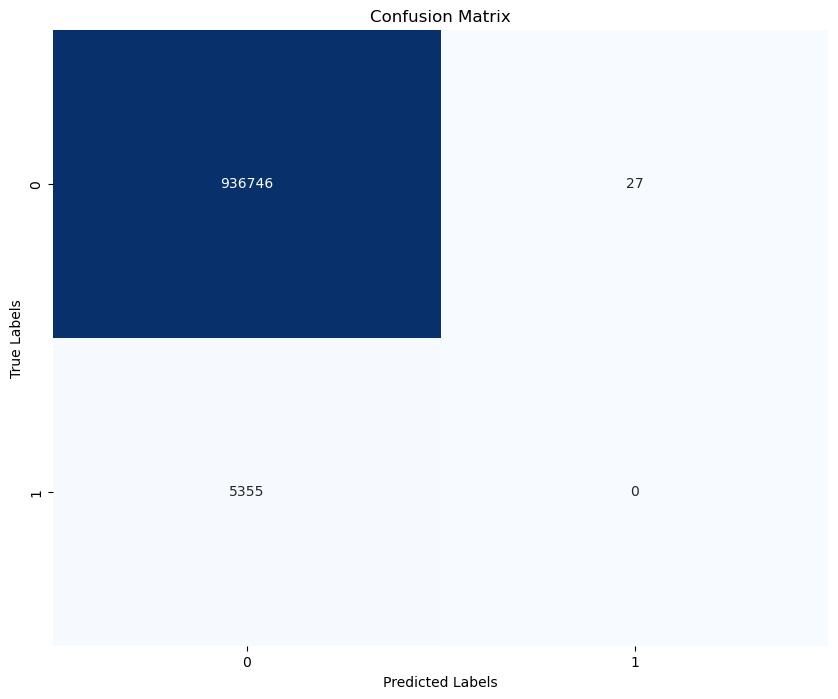

-------------- file 4 -------------------
Model 9 Accuracy: 0.9972258893210119
Model 9 precesion: 0.0
Model 9 recall: 0.0
Model 9 fbeta_score: 0.0


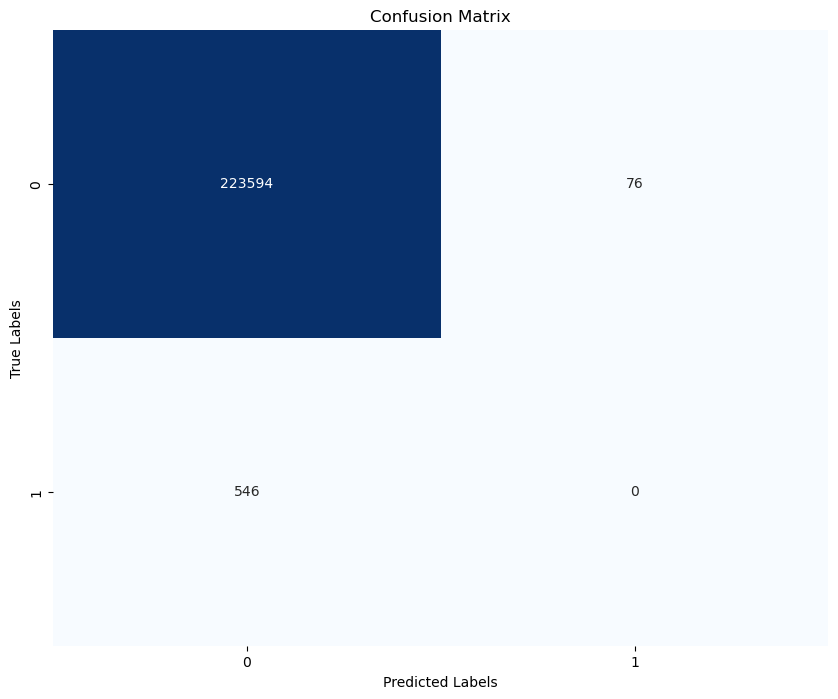

/home/s2316001/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


-------------- file 5 -------------------
Model 9 Accuracy: 0.9925289790888435
Model 9 precesion: 0.0
Model 9 recall: 0.0
Model 9 fbeta_score: 0.0


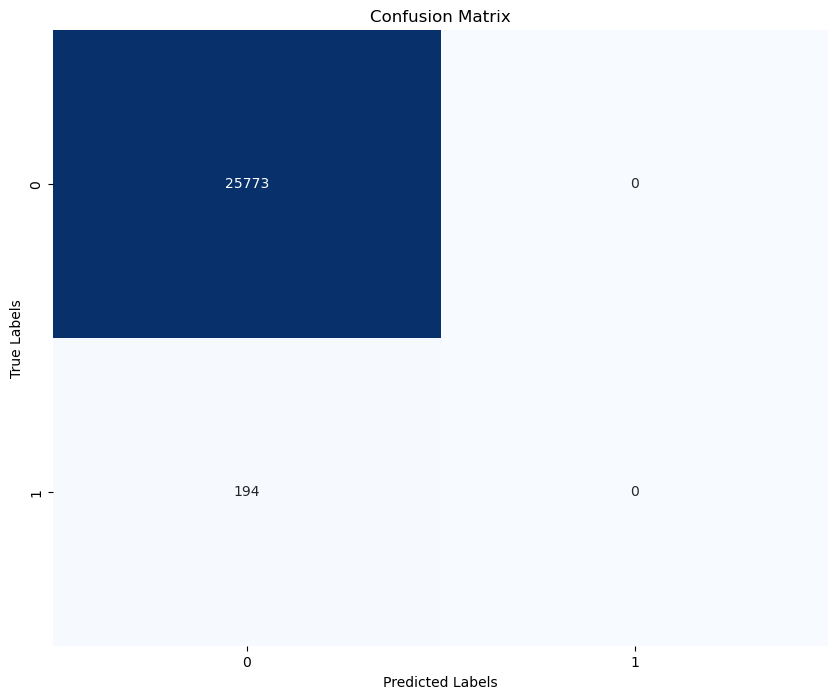

-------------- file 6 -------------------
Model 9 Accuracy: 0.9916446003005797
Model 9 precesion: 0.0
Model 9 recall: 0.0
Model 9 fbeta_score: 0.0


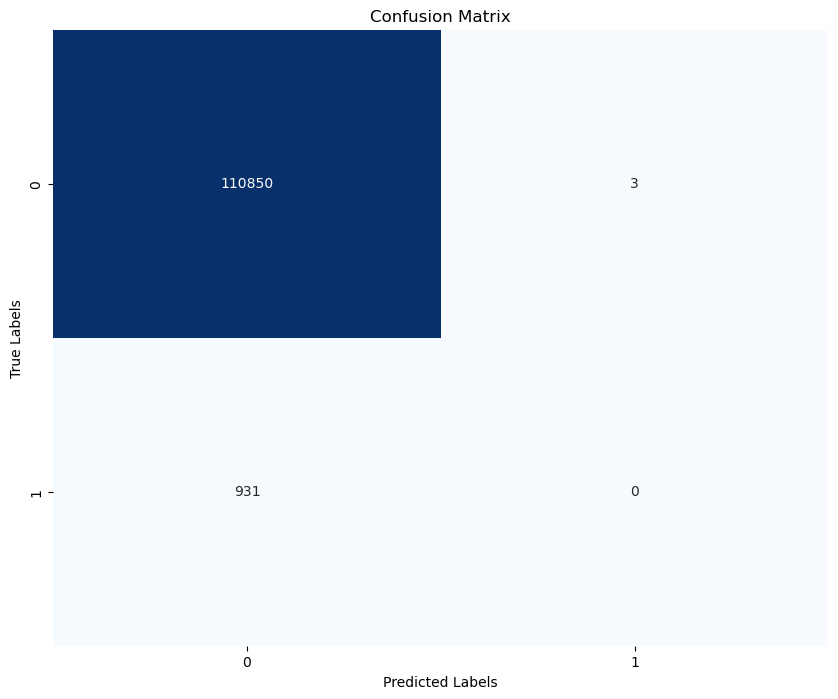

-------------- file 7 -------------------
Model 9 Accuracy: 0.9992549088359046
Model 9 precesion: 0.0
Model 9 recall: 0.0
Model 9 fbeta_score: 0.0


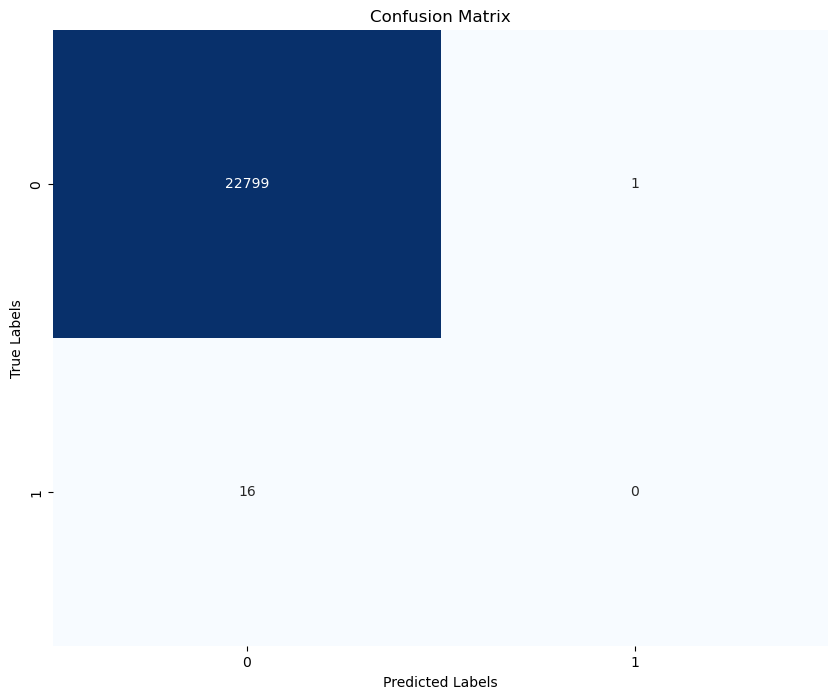

-------------- file 8 -------------------
Model 9 Accuracy: 0.9979216242472658
Model 9 precesion: 0.0
Model 9 recall: 0.0
Model 9 fbeta_score: 0.0


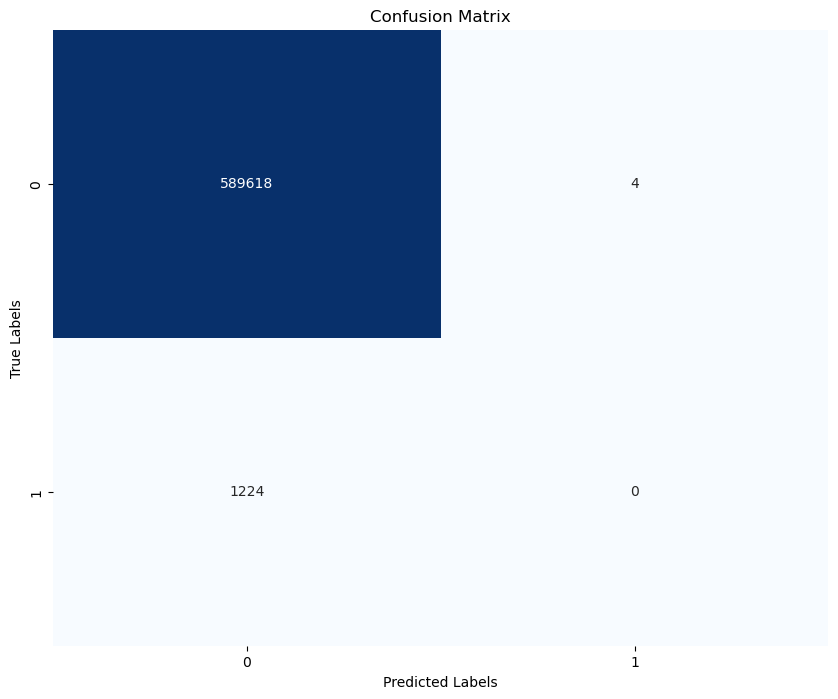

-------------- file 9 -------------------
Model 9 Accuracy: 0.9999640720283974
Model 9 precesion: 0.9997835966241073
Model 9 recall: 0.999810641923878
Model 9 fbeta_score: 0.9997971190910934


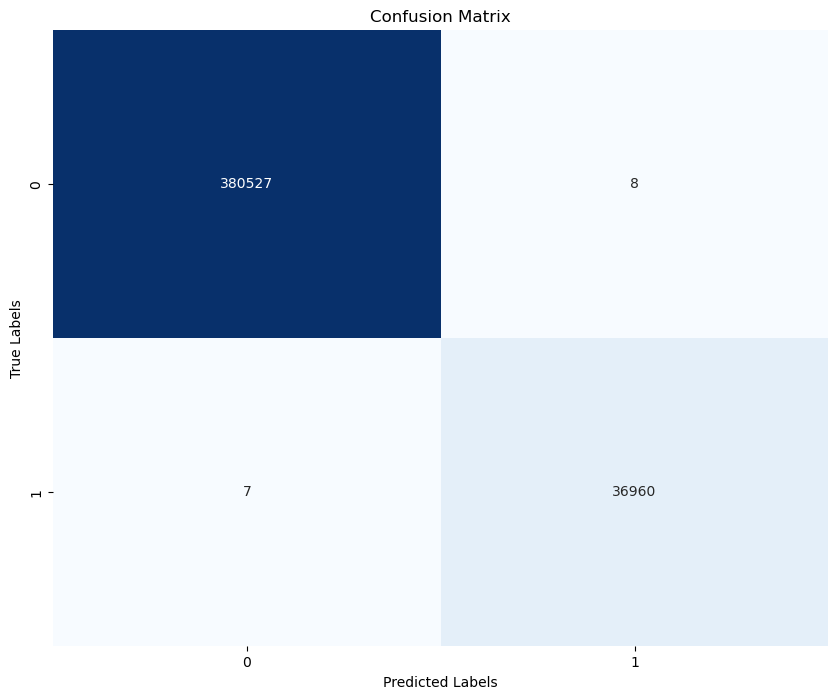

-------------- file 10 -------------------
Model 9 Accuracy: 0.9187544615760481
Model 9 precesion: 0.0
Model 9 recall: 0.0
Model 9 fbeta_score: 0.0


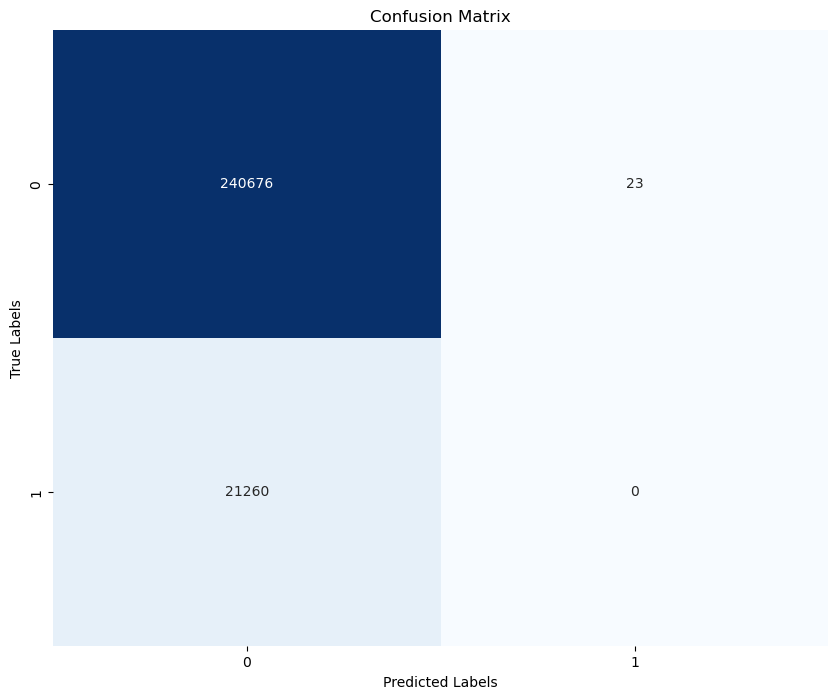

-------------- file 11 -------------------
Model 9 Accuracy: 0.9228474197007133
Model 9 precesion: 0.0
Model 9 recall: 0.0
Model 9 fbeta_score: 0.0


/home/s2316001/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


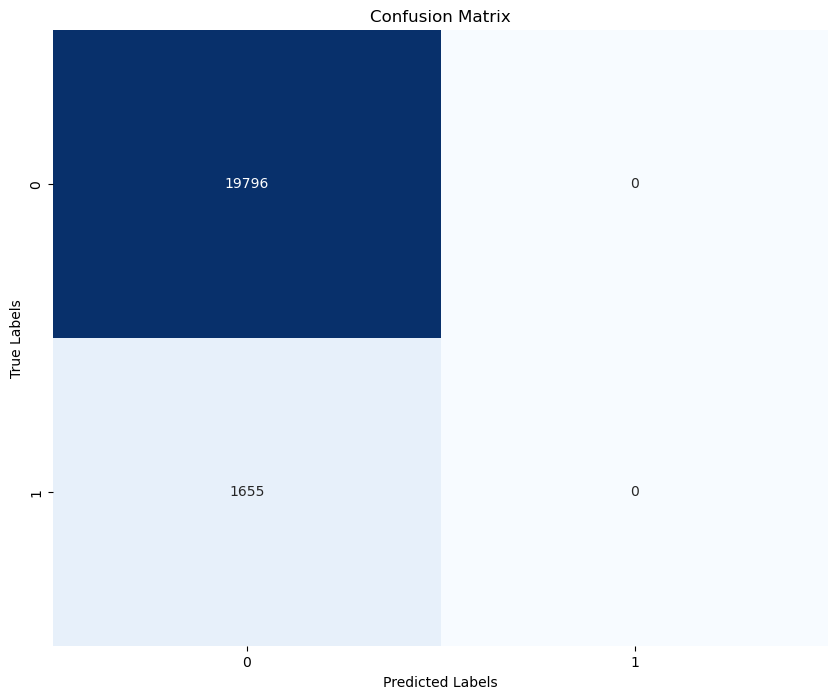

-------------- file 12 -------------------
Model 9 Accuracy: 0.9932713726092633
Model 9 precesion: 0.0
Model 9 recall: 0.0
Model 9 fbeta_score: 0.0


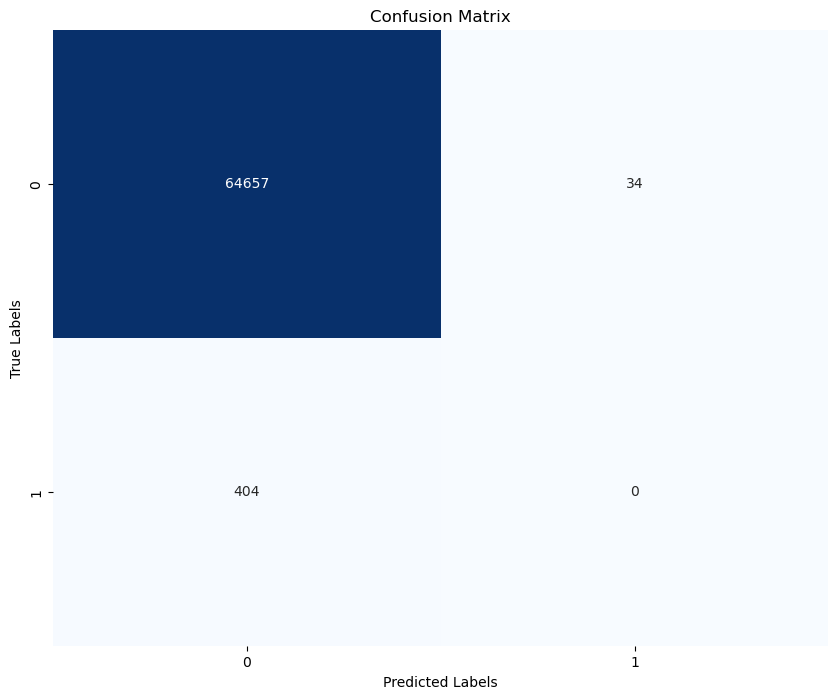

-------------- file 13 -------------------
Model 9 Accuracy: 0.9796327558891514
Model 9 precesion: 0.99375
Model 9 recall: 0.019875
Model 9 fbeta_score: 0.03897058823529412


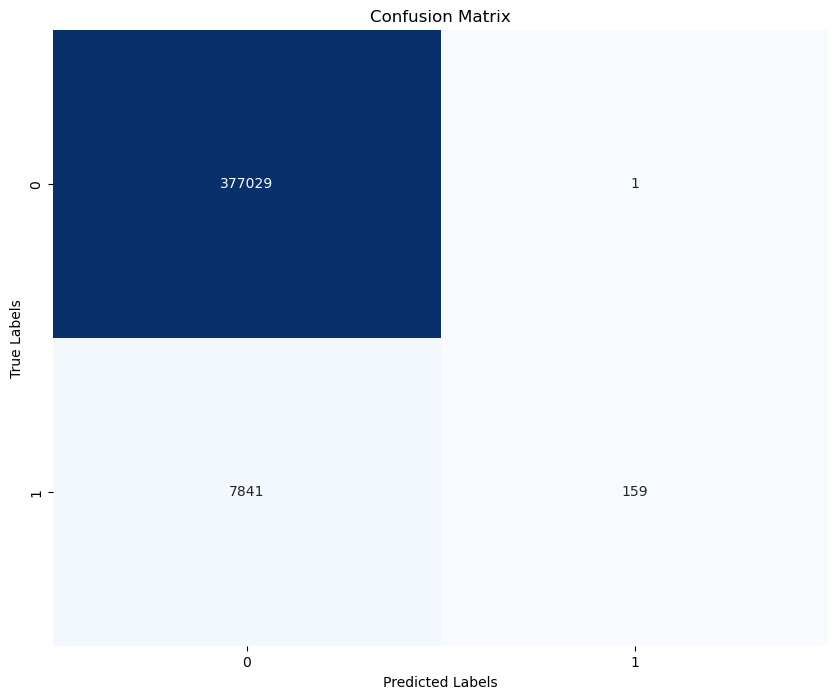

-------------- Model 10 -------------------
-------------- file 1 -------------------
Model 10 Accuracy: 0.985337954571202
Model 10 precesion: 0.0
Model 10 recall: 0.0
Model 10 fbeta_score: 0.0


/home/s2316001/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


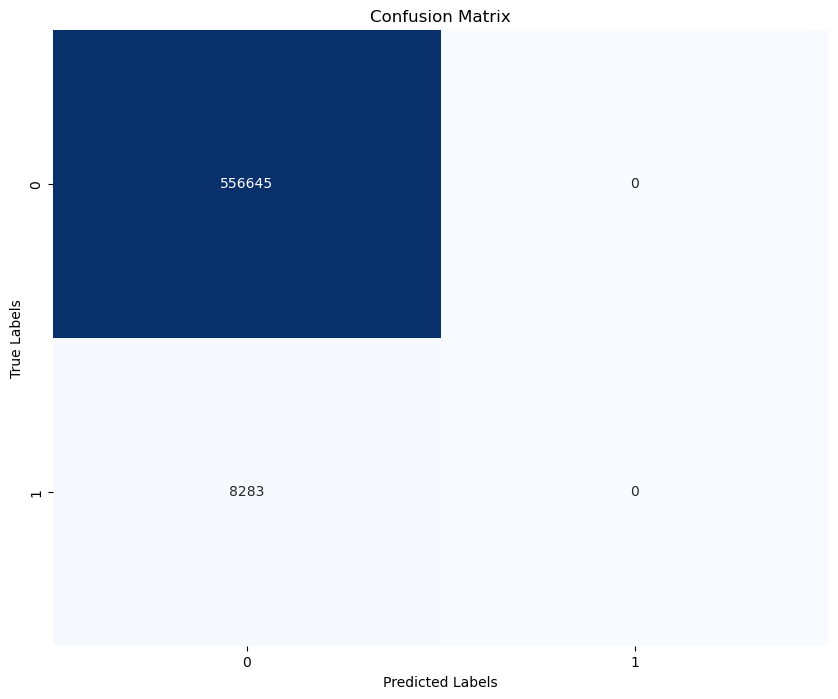

-------------- file 2 -------------------
Model 10 Accuracy: 0.9882170756999654
Model 10 precesion: 0.0
Model 10 recall: 0.0
Model 10 fbeta_score: 0.0


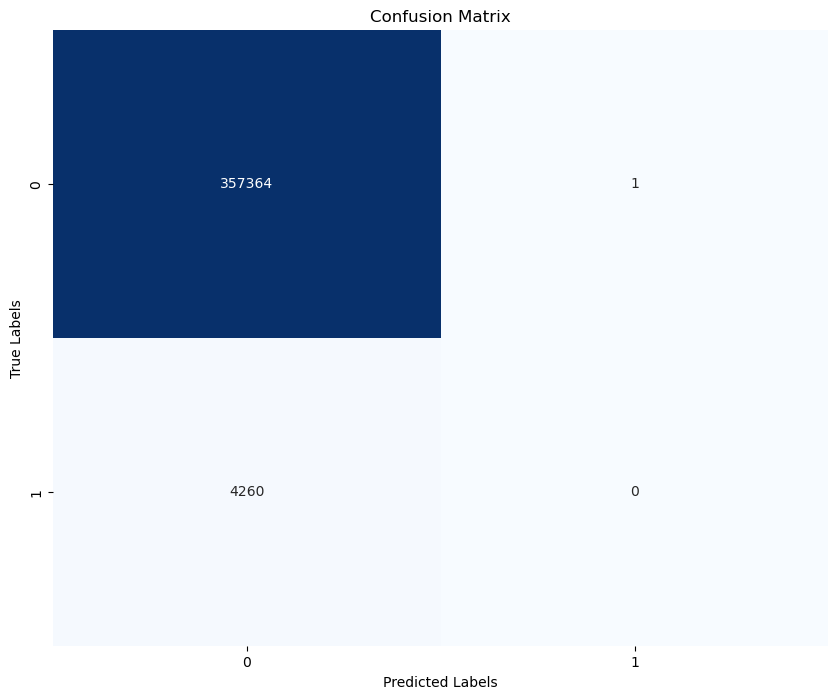

-------------- file 3 -------------------
Model 10 Accuracy: 0.994316058964387
Model 10 precesion: 0.0
Model 10 recall: 0.0
Model 10 fbeta_score: 0.0


/home/s2316001/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


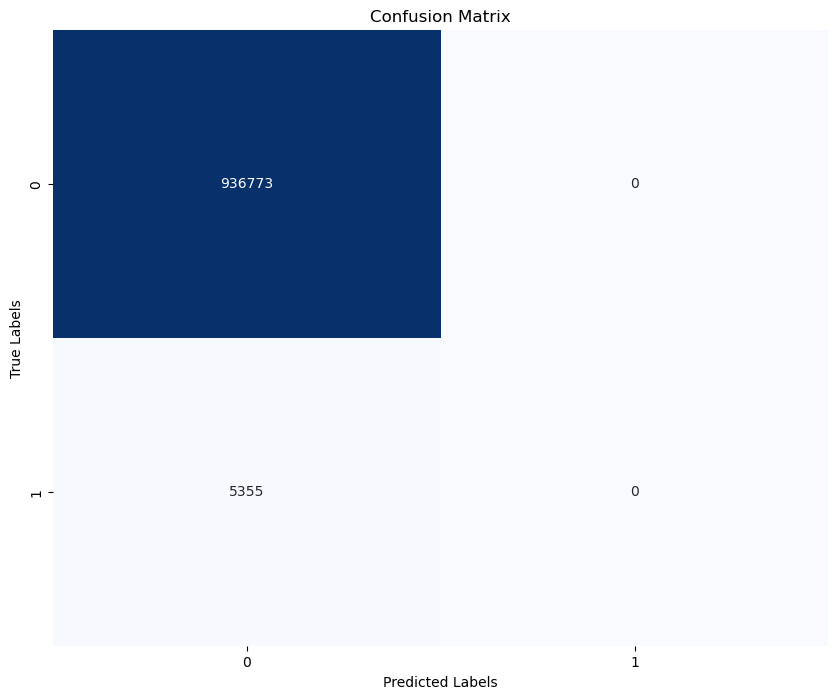

-------------- file 4 -------------------
Model 10 Accuracy: 0.9967798908195669
Model 10 precesion: 0.31893004115226337
Model 10 recall: 0.2838827838827839
Model 10 fbeta_score: 0.3003875968992248


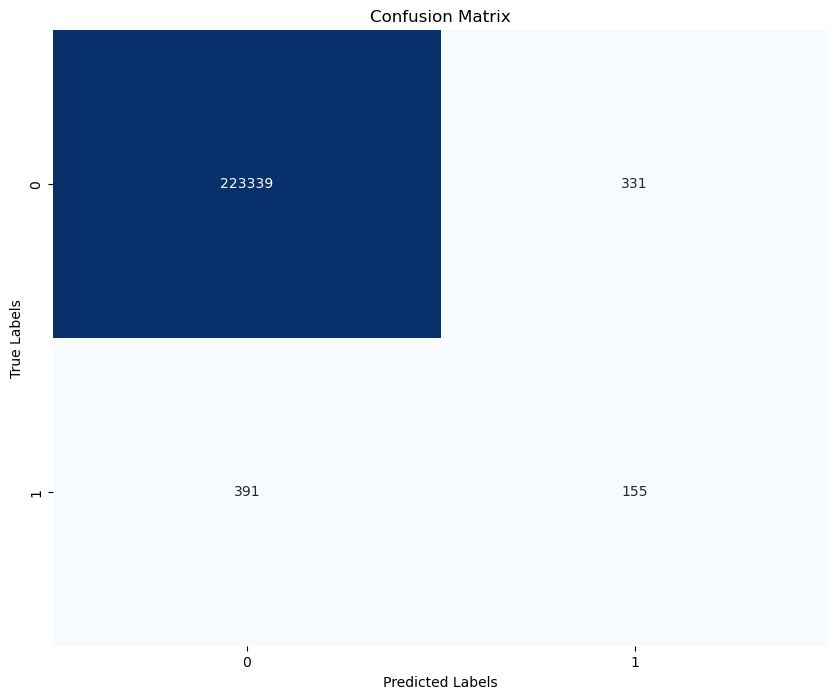

-------------- file 5 -------------------
Model 10 Accuracy: 0.9925289790888435
Model 10 precesion: 0.0
Model 10 recall: 0.0
Model 10 fbeta_score: 0.0


/home/s2316001/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


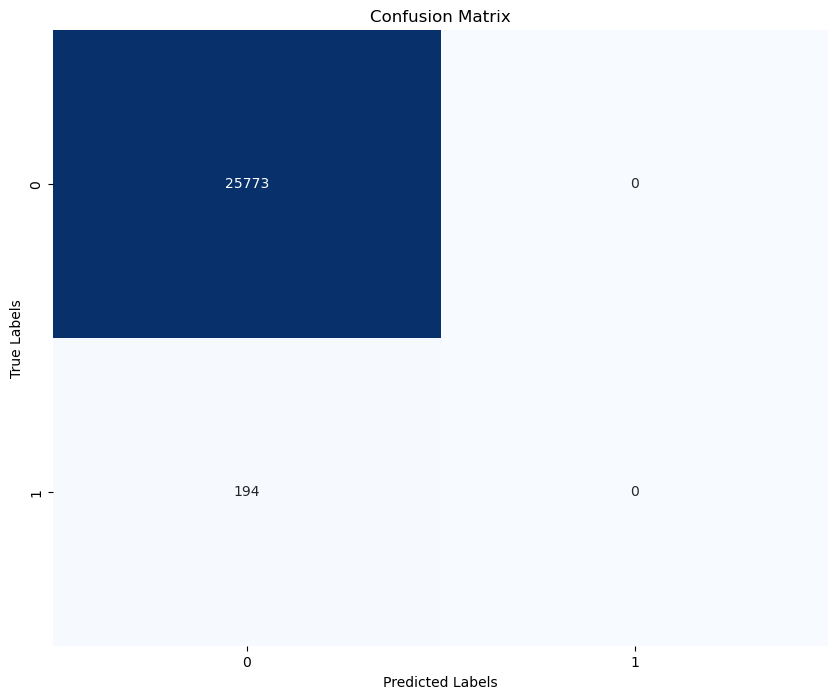

-------------- file 6 -------------------
Model 10 Accuracy: 0.9916624919487583
Model 10 precesion: 0.0
Model 10 recall: 0.0
Model 10 fbeta_score: 0.0


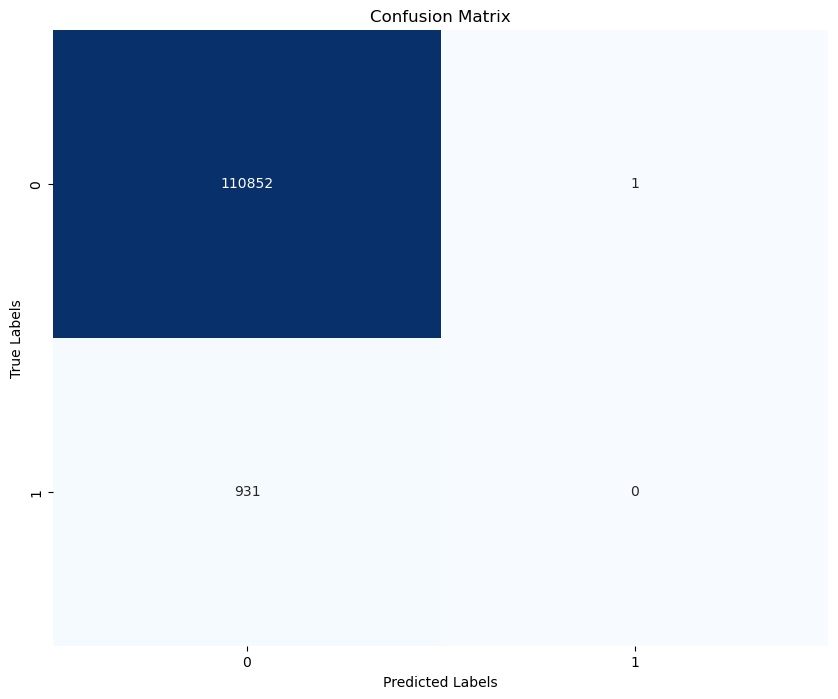

-------------- file 7 -------------------
Model 10 Accuracy: 0.9992987377279102
Model 10 precesion: 0.0
Model 10 recall: 0.0
Model 10 fbeta_score: 0.0


/home/s2316001/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


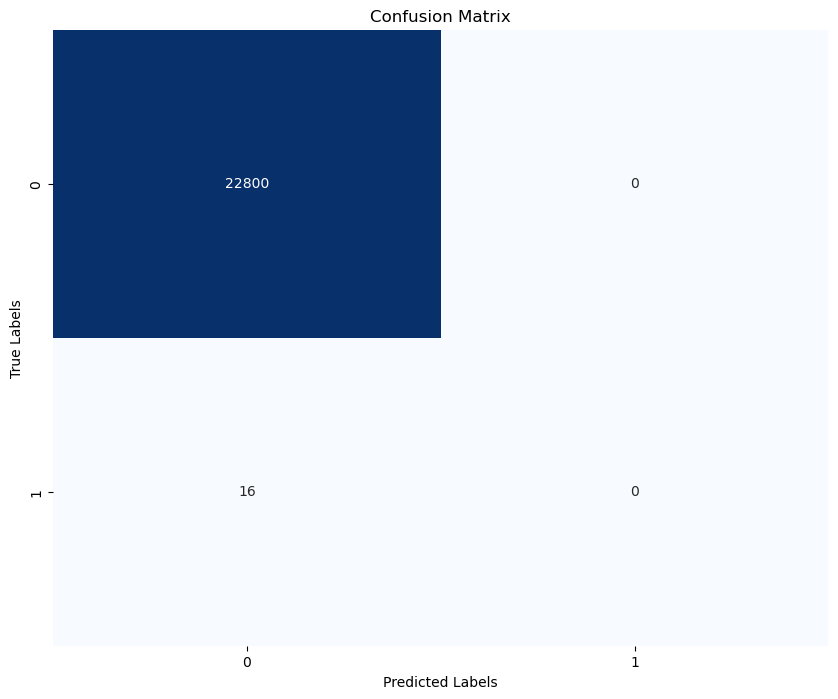

-------------- file 8 -------------------
Model 10 Accuracy: 0.9979283942008578
Model 10 precesion: 0.0
Model 10 recall: 0.0
Model 10 fbeta_score: 0.0


/home/s2316001/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


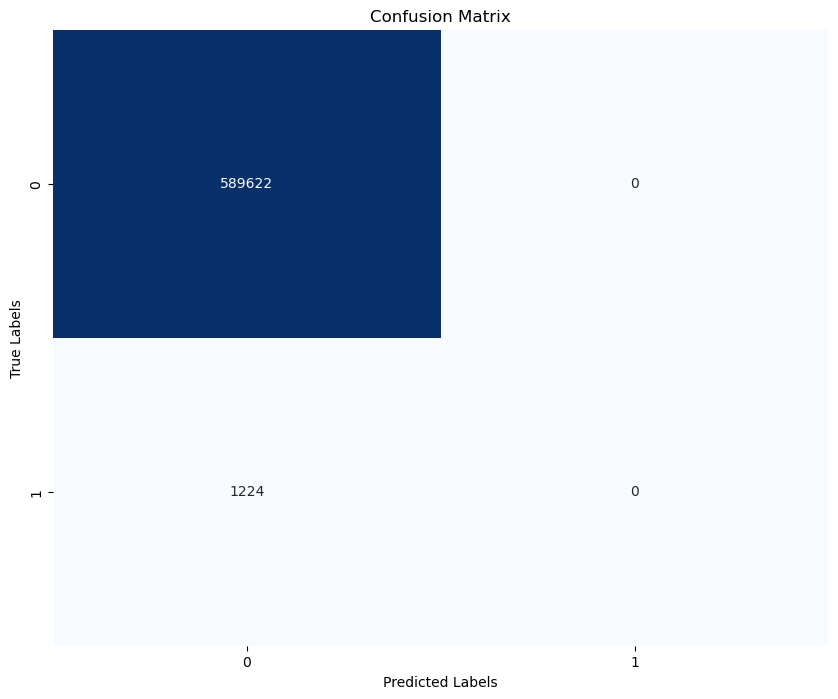

-------------- file 9 -------------------
Model 10 Accuracy: 0.9114567115846152
Model 10 precesion: 0.0
Model 10 recall: 0.0
Model 10 fbeta_score: 0.0


/home/s2316001/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


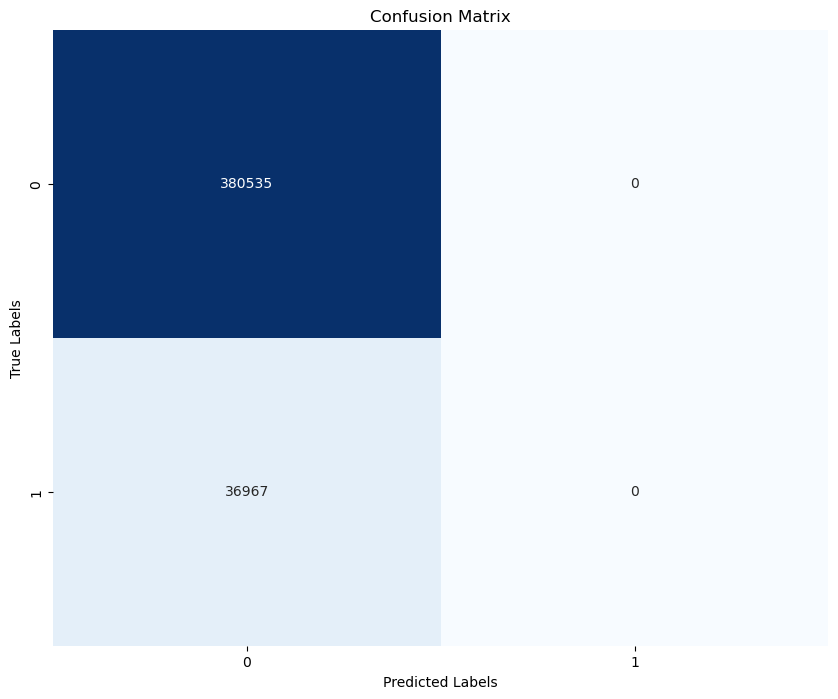

-------------- file 10 -------------------
Model 10 Accuracy: 0.9999694608698307
Model 10 precesion: 0.9999059089198344
Model 10 recall: 0.9997177798682972
Model 10 fbeta_score: 0.9998118355442658


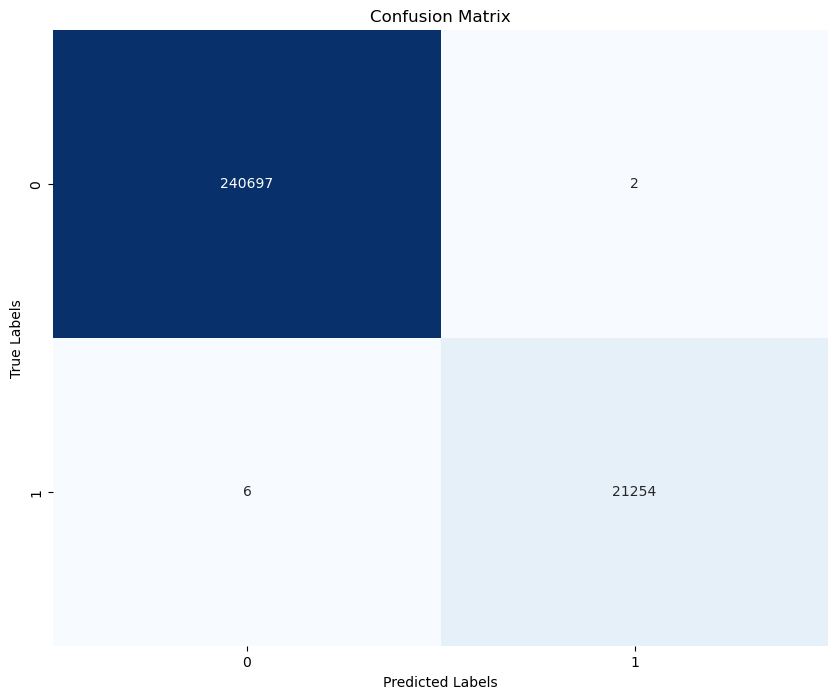

-------------- file 11 -------------------
Model 10 Accuracy: 0.927182881916927
Model 10 precesion: 1.0
Model 10 recall: 0.056193353474320244
Model 10 fbeta_score: 0.10640732265446225


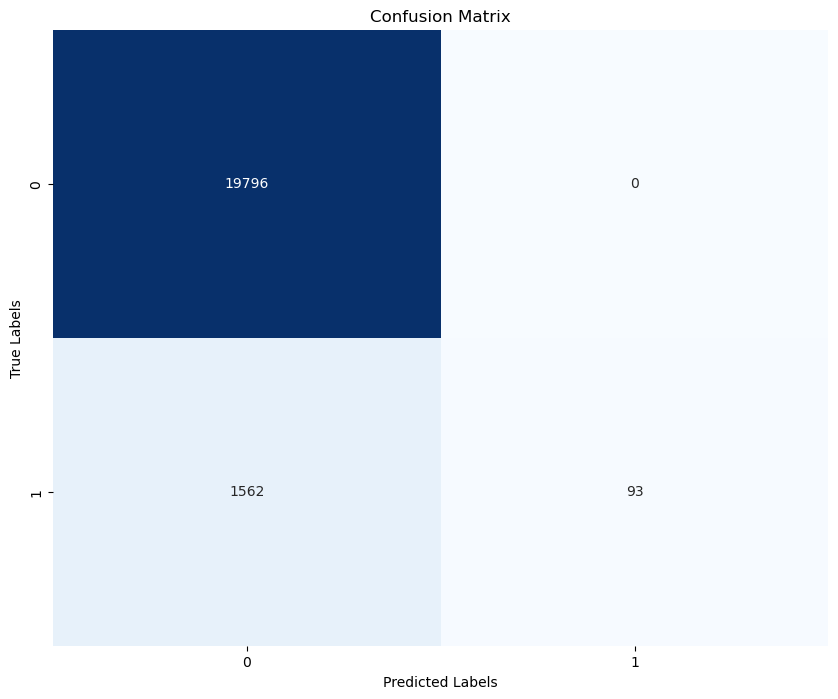

-------------- file 12 -------------------
Model 10 Accuracy: 0.9937783239880175
Model 10 precesion: 0.0
Model 10 recall: 0.0
Model 10 fbeta_score: 0.0


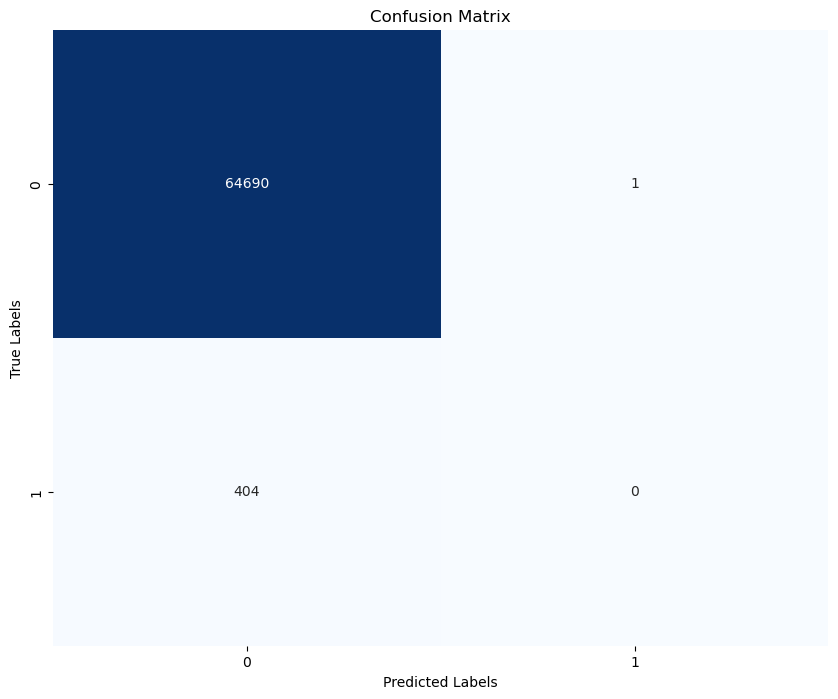

-------------- file 13 -------------------
Model 10 Accuracy: 0.6647482014388489
Model 10 precesion: 2.477536997885835e-05
Model 10 recall: 0.000375
Model 10 fbeta_score: 4.647992067426871e-05


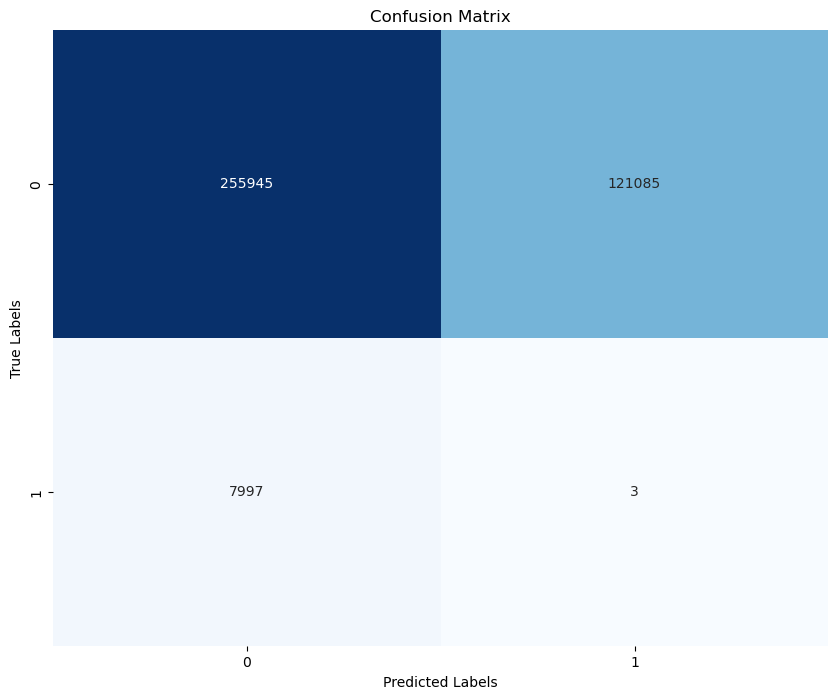

-------------- Model 11 -------------------
-------------- file 1 -------------------
Model 11 Accuracy: 0.985337954571202
Model 11 precesion: 0.0
Model 11 recall: 0.0
Model 11 fbeta_score: 0.0


/home/s2316001/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


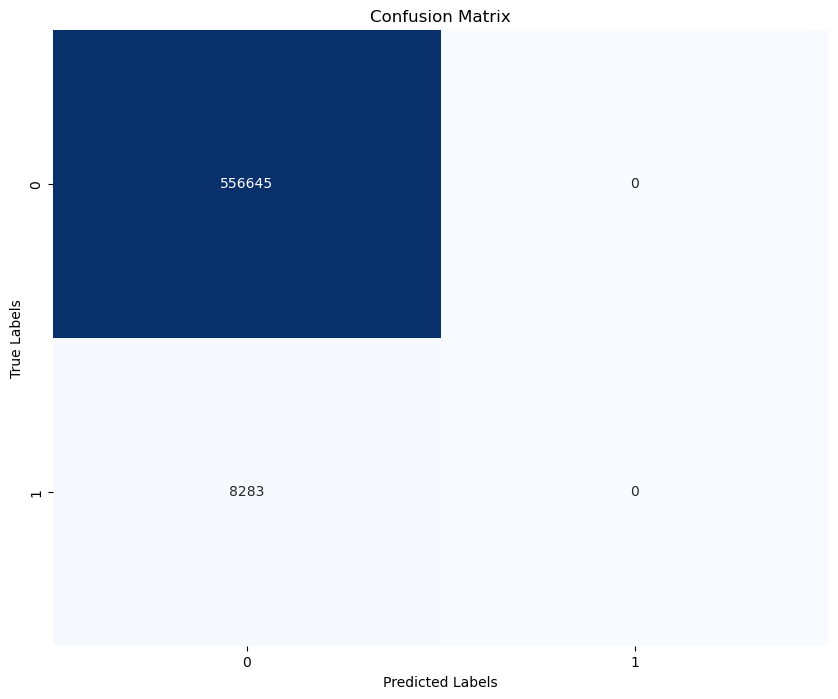

-------------- file 2 -------------------
Model 11 Accuracy: 0.9882198409955064
Model 11 precesion: 0.0
Model 11 recall: 0.0
Model 11 fbeta_score: 0.0


/home/s2316001/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


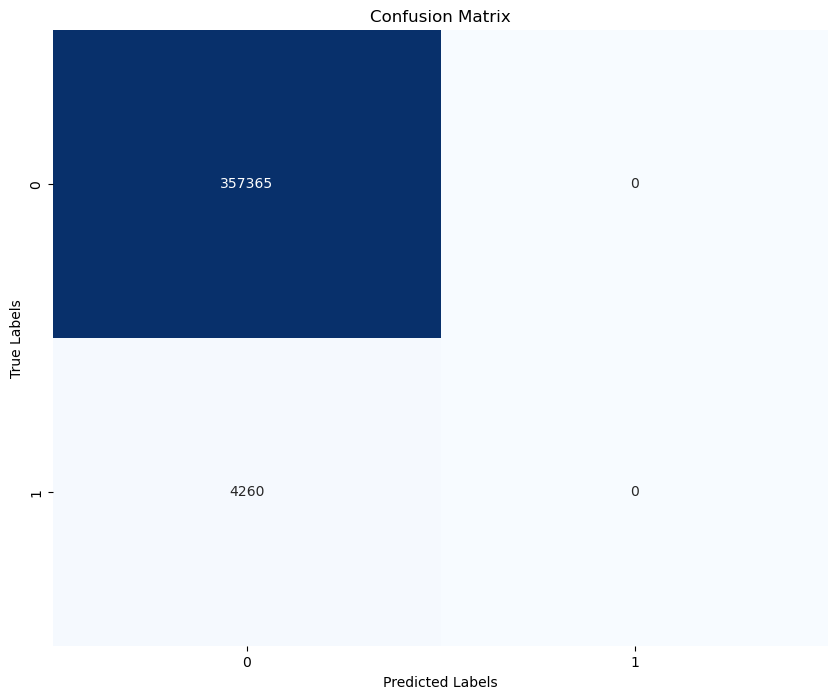

-------------- file 3 -------------------
Model 11 Accuracy: 0.994316058964387
Model 11 precesion: 0.0
Model 11 recall: 0.0
Model 11 fbeta_score: 0.0


/home/s2316001/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


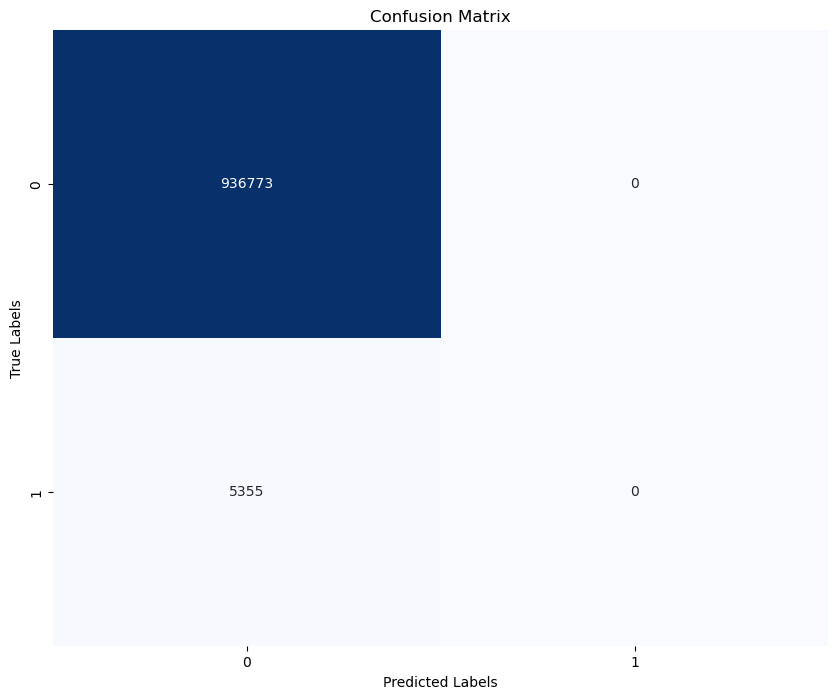

-------------- file 4 -------------------
Model 11 Accuracy: 0.9975648481821101
Model 11 precesion: 0.0
Model 11 recall: 0.0
Model 11 fbeta_score: 0.0


/home/s2316001/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


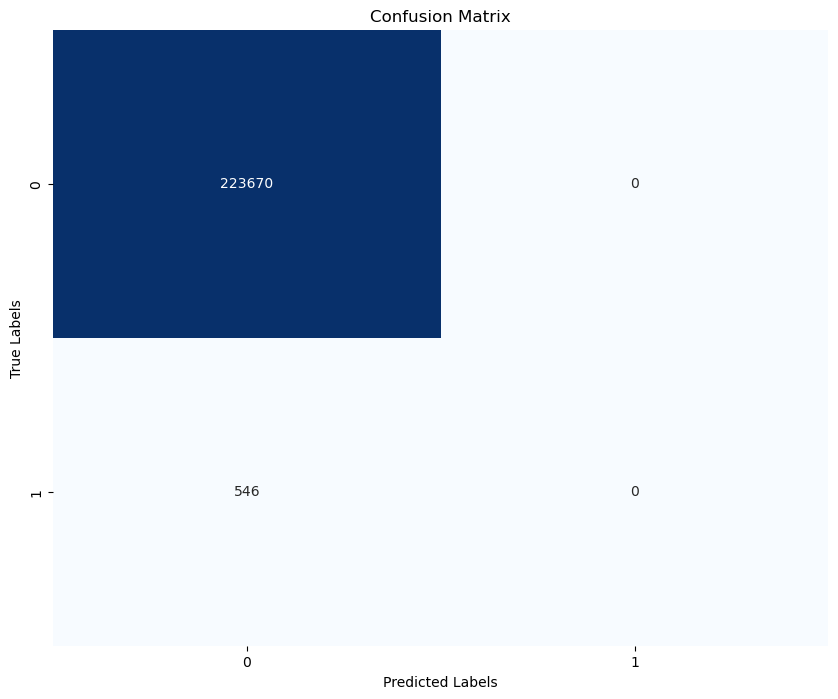

-------------- file 5 -------------------
Model 11 Accuracy: 0.9925289790888435
Model 11 precesion: 0.0
Model 11 recall: 0.0
Model 11 fbeta_score: 0.0


/home/s2316001/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


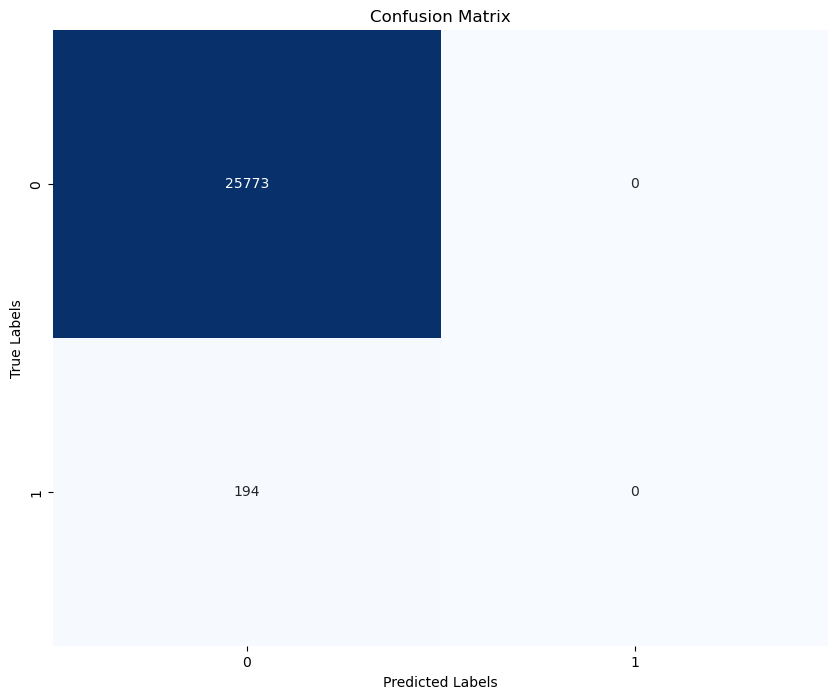

-------------- file 6 -------------------
Model 11 Accuracy: 0.9916714377728476
Model 11 precesion: 0.0
Model 11 recall: 0.0
Model 11 fbeta_score: 0.0


/home/s2316001/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


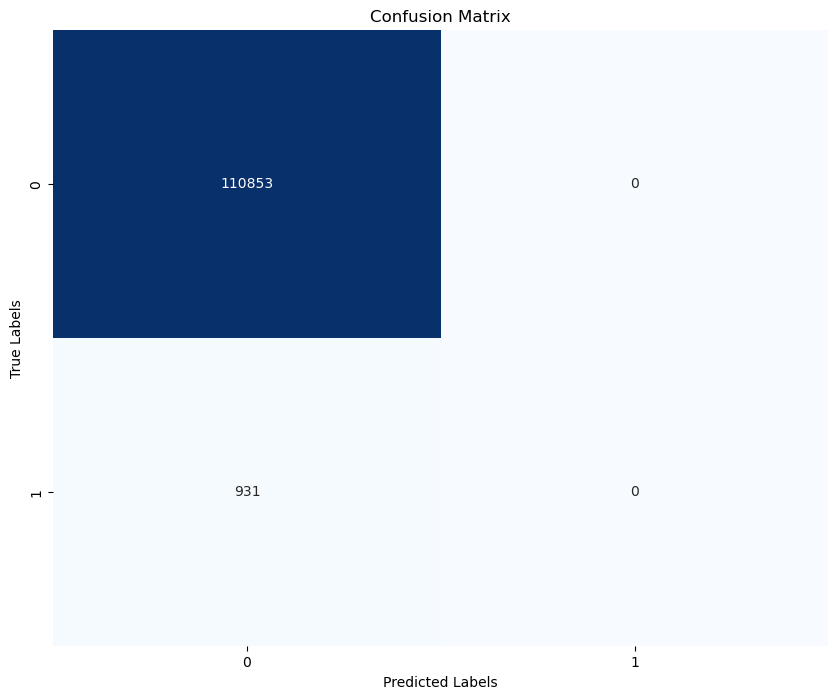

-------------- file 7 -------------------
Model 11 Accuracy: 0.9992987377279102
Model 11 precesion: 0.0
Model 11 recall: 0.0
Model 11 fbeta_score: 0.0


/home/s2316001/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


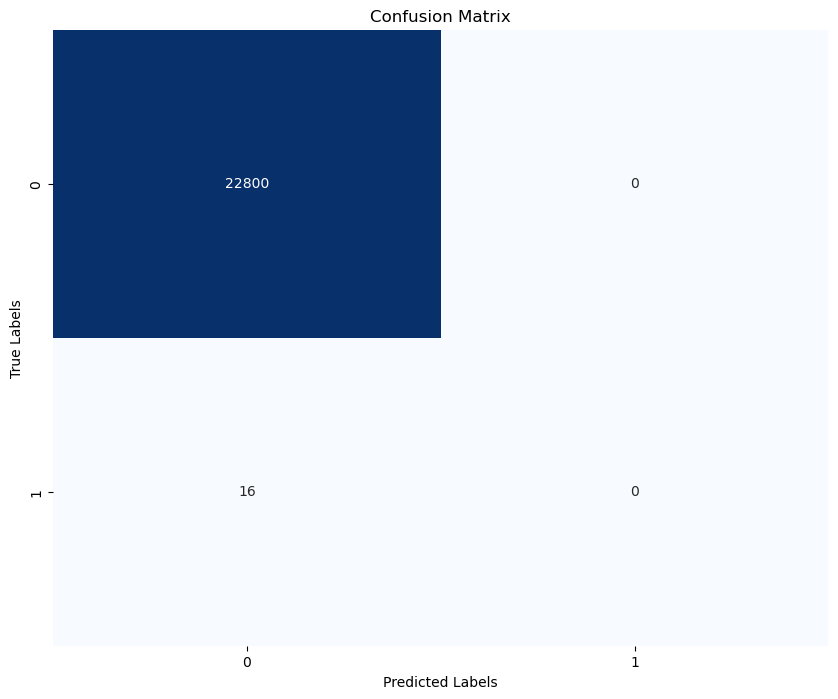

-------------- file 8 -------------------
Model 11 Accuracy: 0.9979283942008578
Model 11 precesion: 0.0
Model 11 recall: 0.0
Model 11 fbeta_score: 0.0


/home/s2316001/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


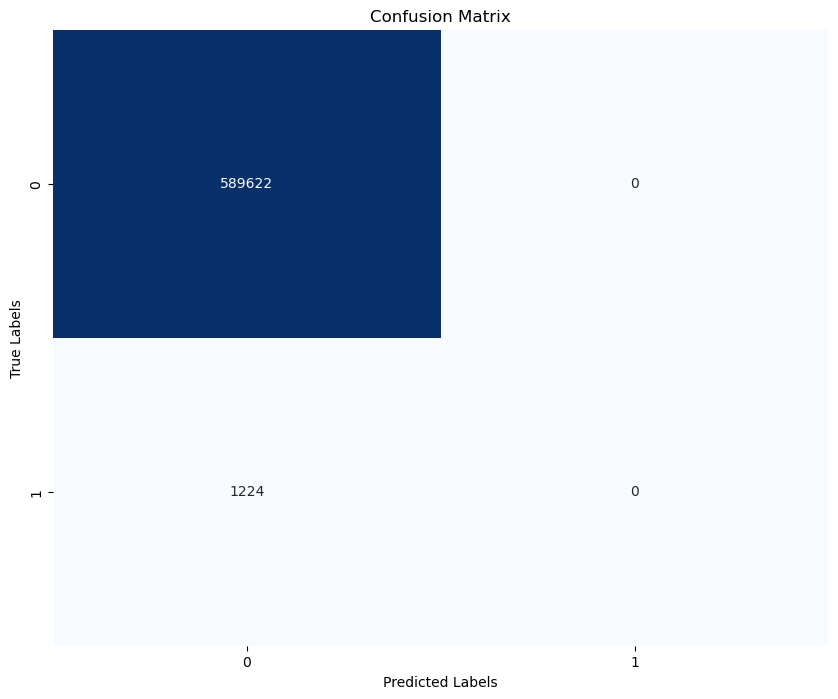

-------------- file 9 -------------------
Model 11 Accuracy: 0.9114567115846152
Model 11 precesion: 0.0
Model 11 recall: 0.0
Model 11 fbeta_score: 0.0


/home/s2316001/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


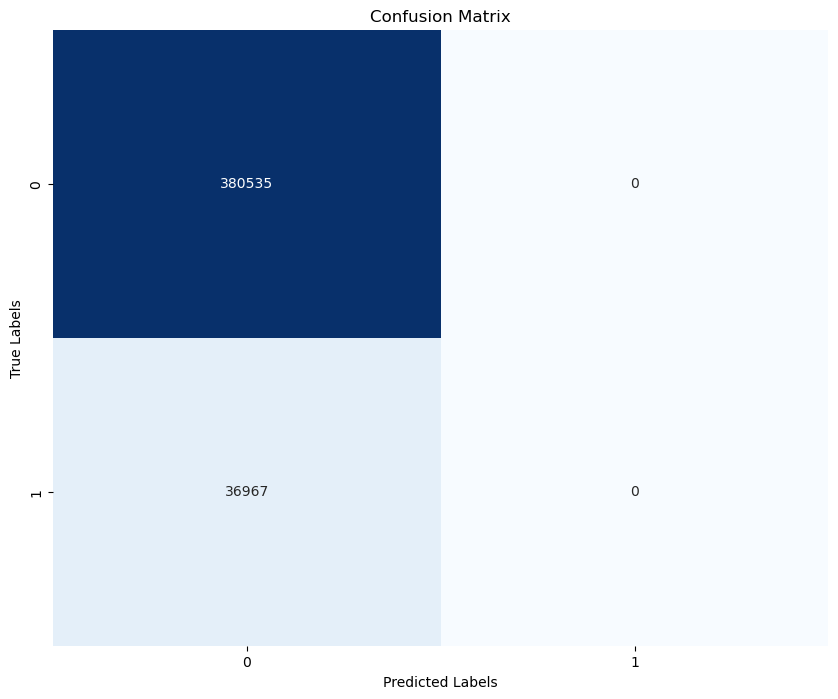

-------------- file 10 -------------------
Model 11 Accuracy: 0.9188422615752847
Model 11 precesion: 0.0
Model 11 recall: 0.0
Model 11 fbeta_score: 0.0


/home/s2316001/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


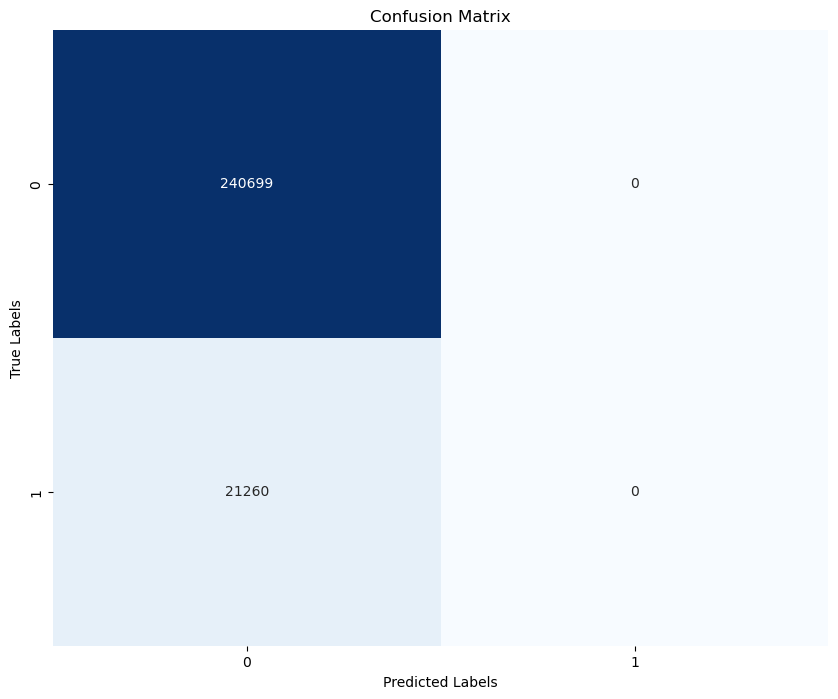

-------------- file 11 -------------------
Model 11 Accuracy: 1.0
Model 11 precesion: 1.0
Model 11 recall: 1.0
Model 11 fbeta_score: 1.0


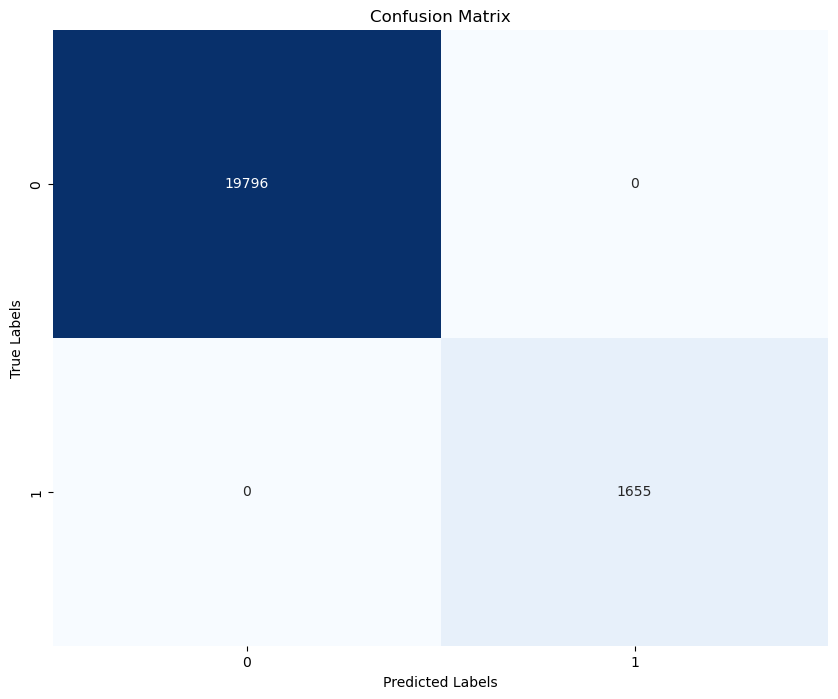

-------------- file 12 -------------------
Model 11 Accuracy: 0.99379368615101
Model 11 precesion: 0.0
Model 11 recall: 0.0
Model 11 fbeta_score: 0.0


/home/s2316001/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


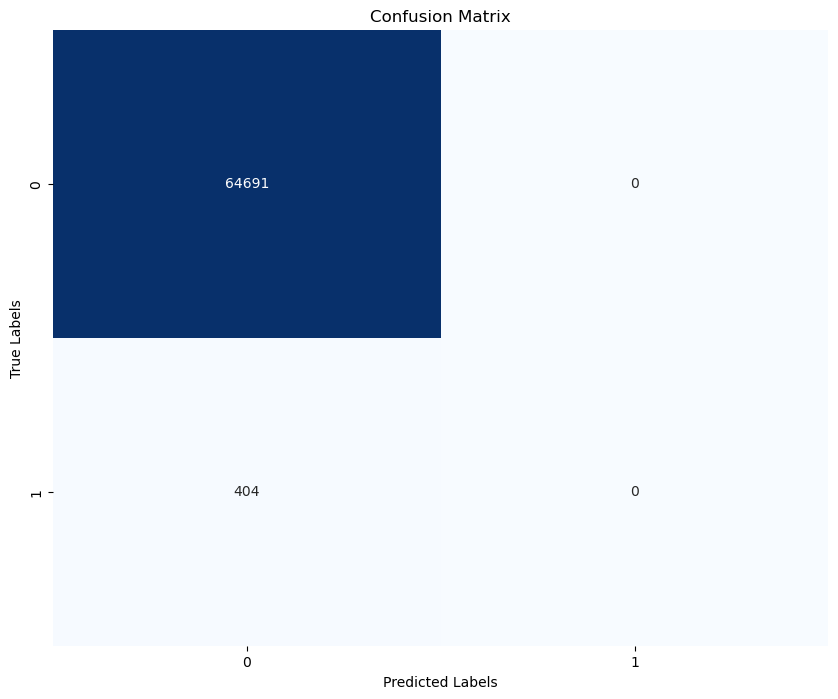

-------------- file 13 -------------------
Model 11 Accuracy: 0.9792223982546815
Model 11 precesion: 0.0
Model 11 recall: 0.0
Model 11 fbeta_score: 0.0


/home/s2316001/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


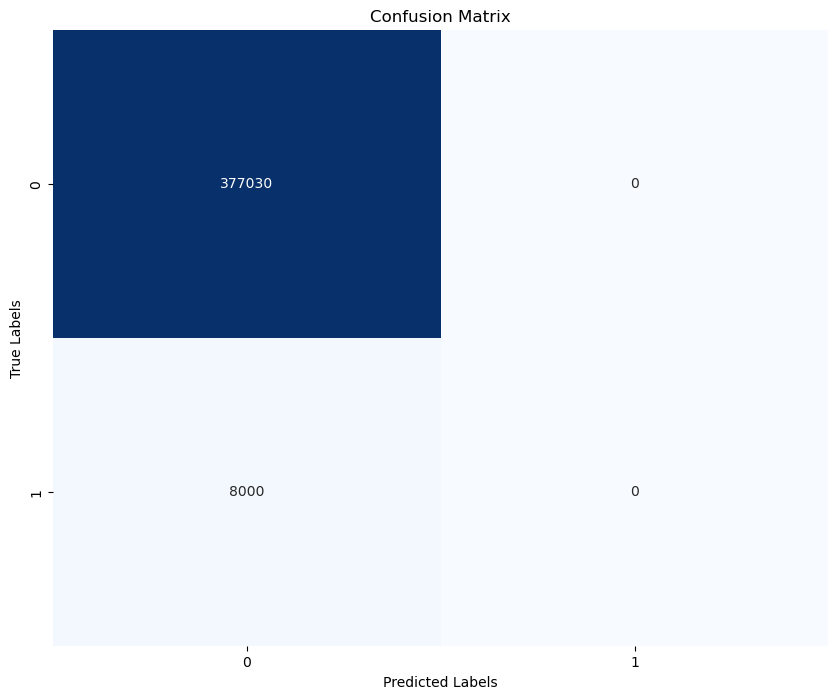

-------------- Model 12 -------------------
-------------- file 1 -------------------
Model 12 Accuracy: 0.985337954571202
Model 12 precesion: 0.0
Model 12 recall: 0.0
Model 12 fbeta_score: 0.0


/home/s2316001/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


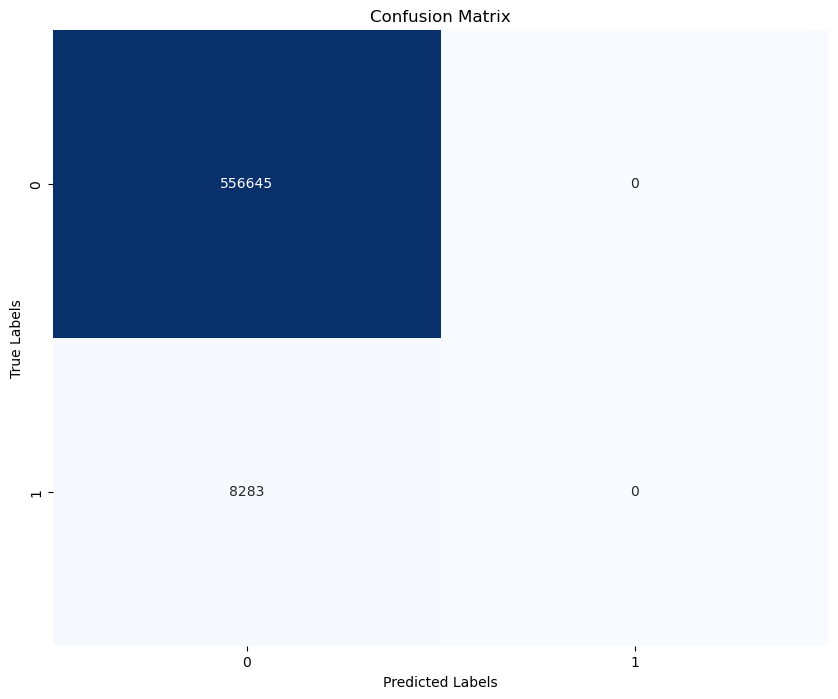

-------------- file 2 -------------------
Model 12 Accuracy: 0.9882198409955064
Model 12 precesion: 0.0
Model 12 recall: 0.0
Model 12 fbeta_score: 0.0


/home/s2316001/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


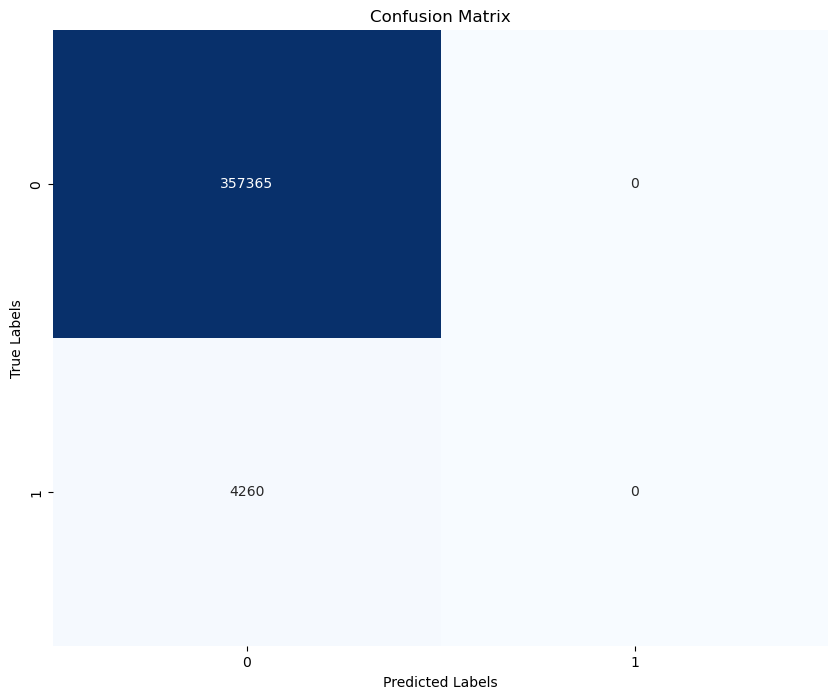

-------------- file 3 -------------------
Model 12 Accuracy: 0.9932801063125181
Model 12 precesion: 0.0
Model 12 recall: 0.0
Model 12 fbeta_score: 0.0


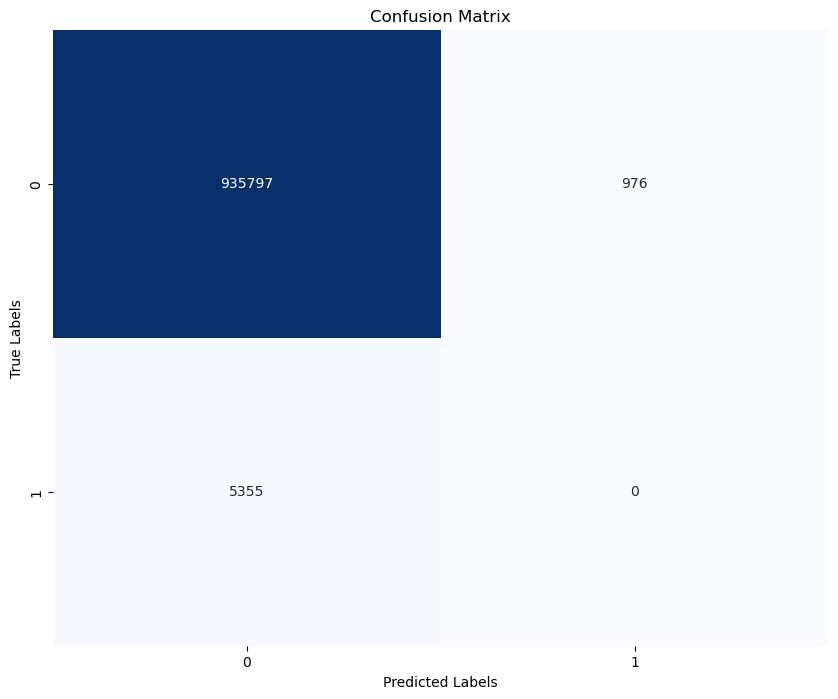

-------------- file 4 -------------------
Model 12 Accuracy: 0.9972258893210119
Model 12 precesion: 0.0
Model 12 recall: 0.0
Model 12 fbeta_score: 0.0


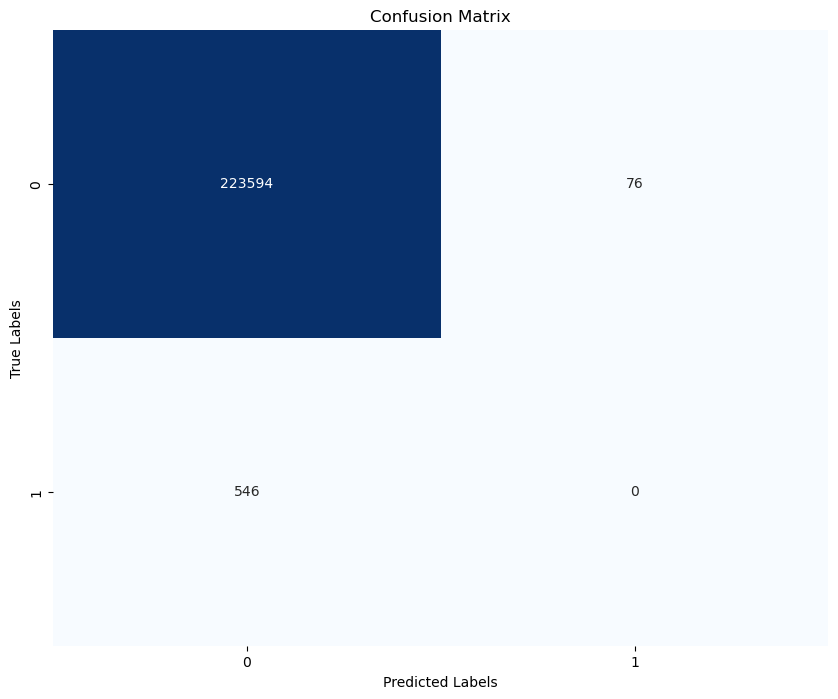

-------------- file 5 -------------------
Model 12 Accuracy: 0.9923749374205723
Model 12 precesion: 0.0
Model 12 recall: 0.0
Model 12 fbeta_score: 0.0


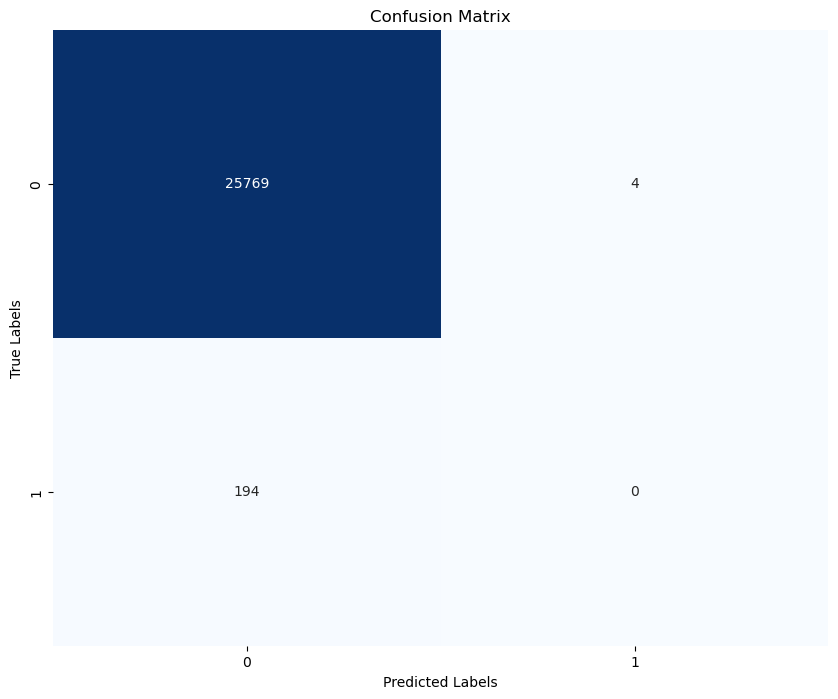

-------------- file 6 -------------------
Model 12 Accuracy: 0.9912330923924711
Model 12 precesion: 0.0
Model 12 recall: 0.0
Model 12 fbeta_score: 0.0


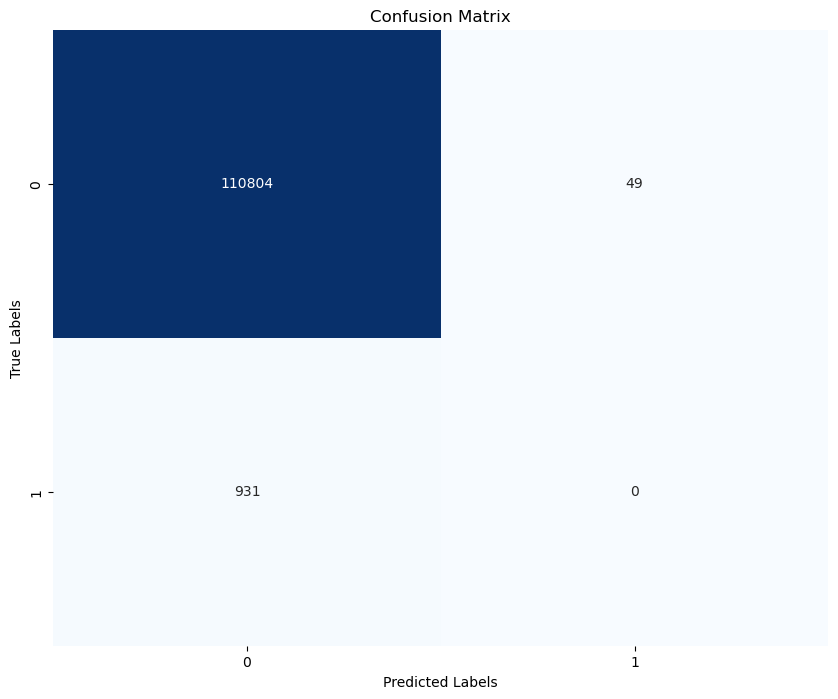

-------------- file 7 -------------------
Model 12 Accuracy: 0.9990795932678822
Model 12 precesion: 0.0
Model 12 recall: 0.0
Model 12 fbeta_score: 0.0


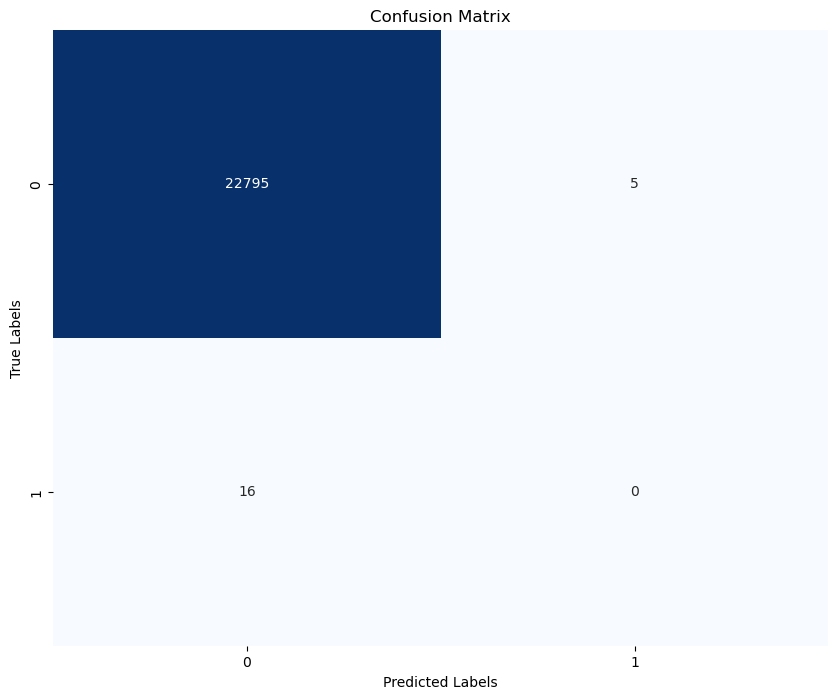

-------------- file 8 -------------------
Model 12 Accuracy: 0.9971447720725874
Model 12 precesion: 0.0
Model 12 recall: 0.0
Model 12 fbeta_score: 0.0


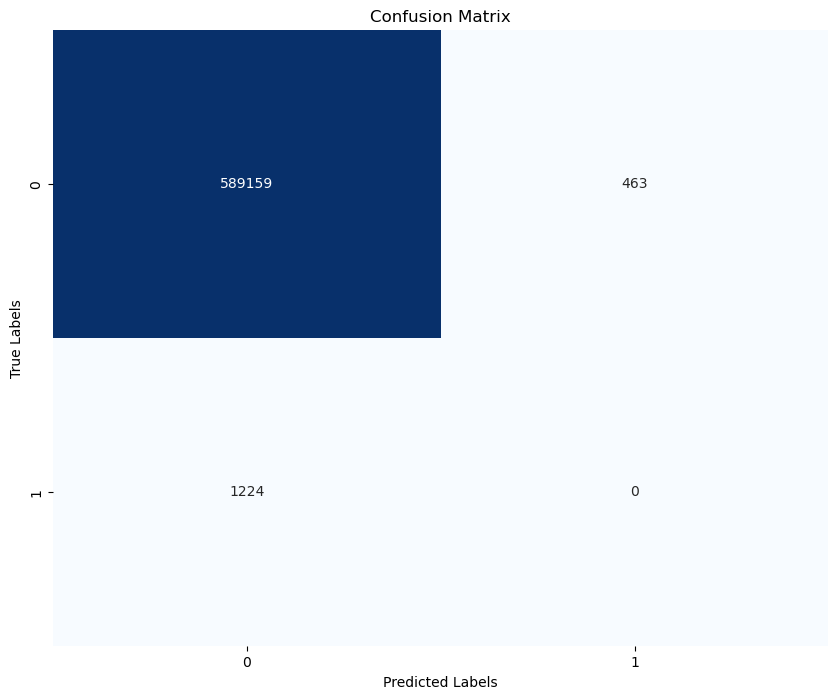

-------------- file 9 -------------------
Model 12 Accuracy: 0.9113968316319443
Model 12 precesion: 0.0
Model 12 recall: 0.0
Model 12 fbeta_score: 0.0


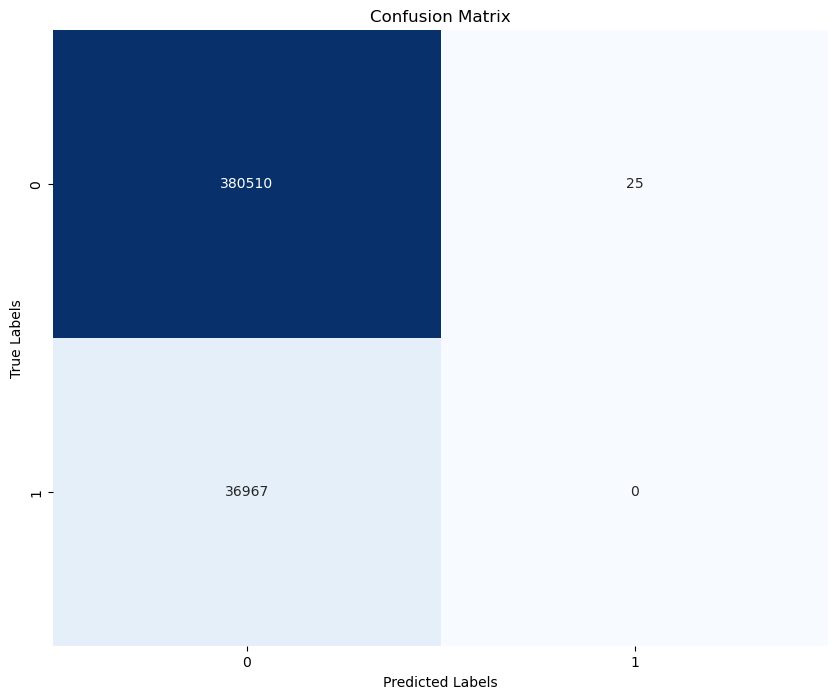

-------------- file 10 -------------------
Model 12 Accuracy: 0.9170404528953005
Model 12 precesion: 0.0
Model 12 recall: 0.0
Model 12 fbeta_score: 0.0


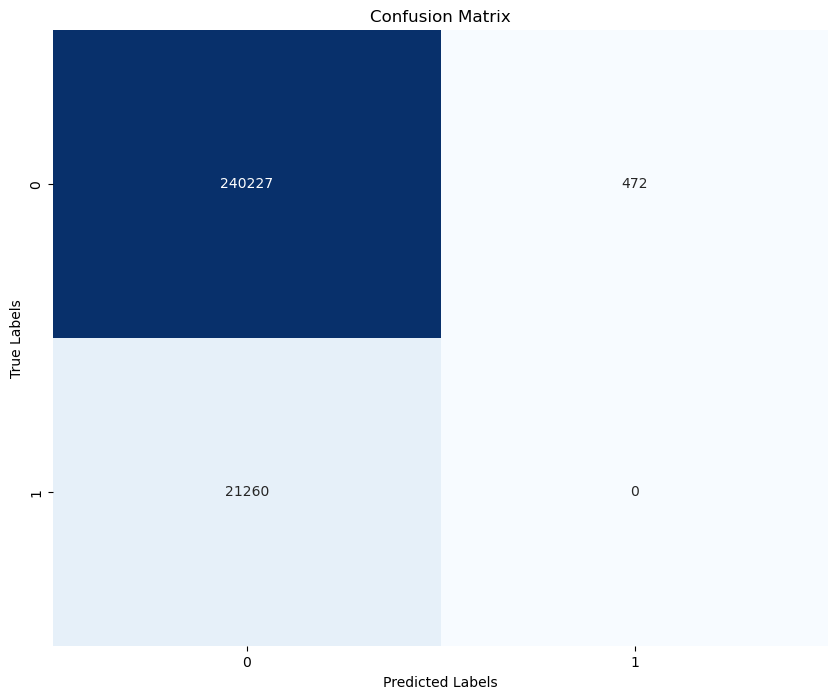

-------------- file 11 -------------------
Model 12 Accuracy: 0.9228474197007133
Model 12 precesion: 0.0
Model 12 recall: 0.0
Model 12 fbeta_score: 0.0


/home/s2316001/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


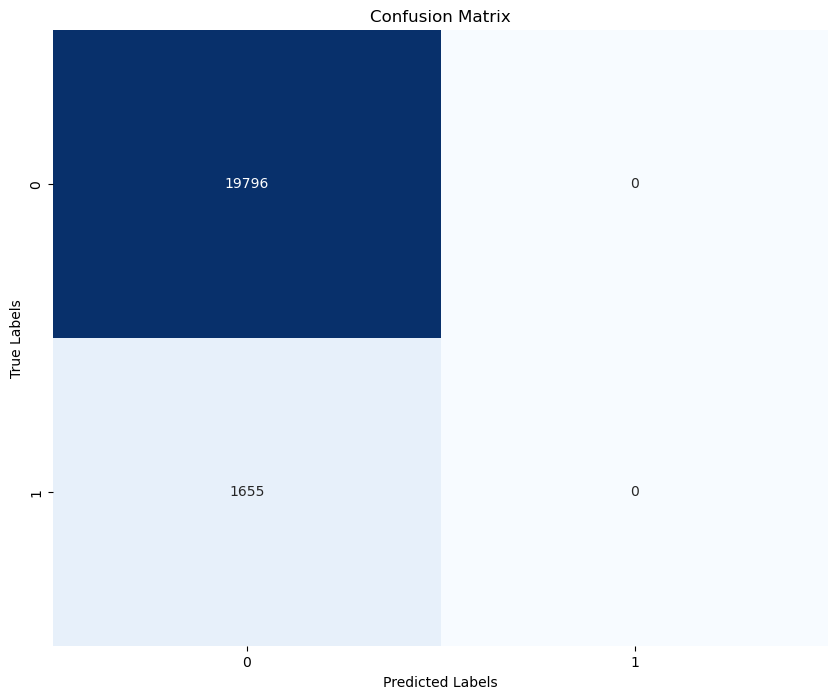

-------------- file 12 -------------------
Model 12 Accuracy: 0.9998002918810969
Model 12 precesion: 0.9899749373433584
Model 12 recall: 0.9777227722772277
Model 12 fbeta_score: 0.983810709838107


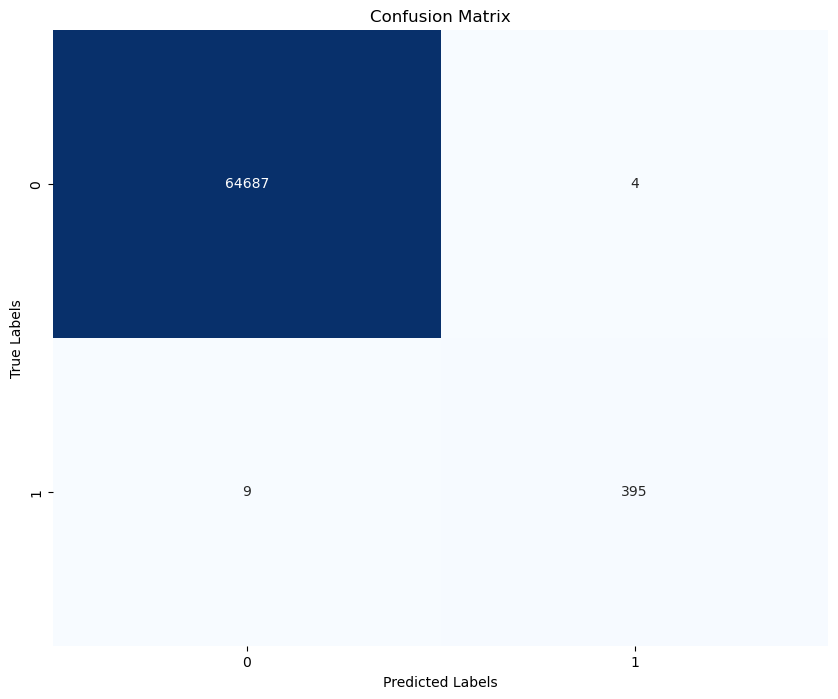

-------------- file 13 -------------------
Model 12 Accuracy: 0.9792223982546815
Model 12 precesion: 0.0
Model 12 recall: 0.0
Model 12 fbeta_score: 0.0


/home/s2316001/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


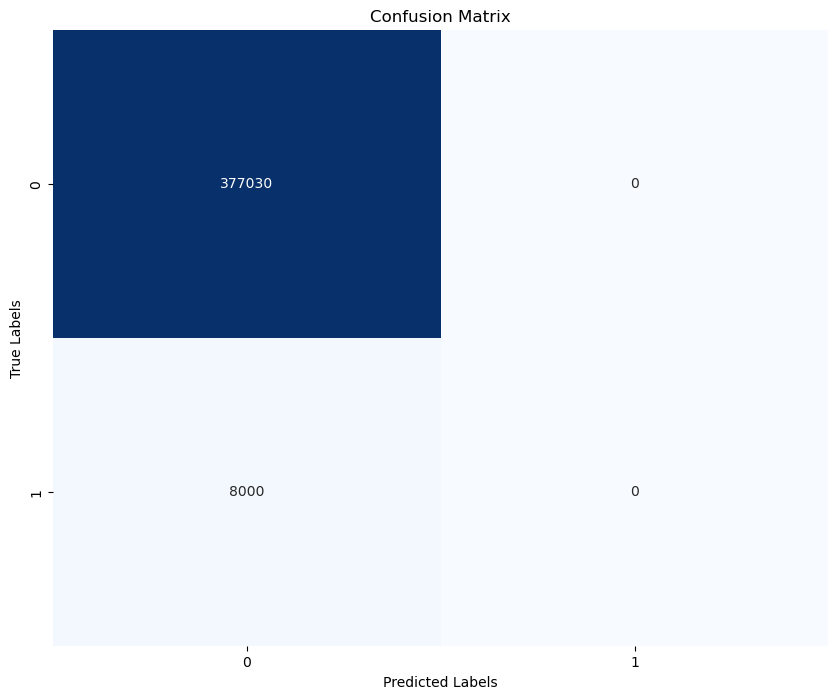

-------------- Model 13 -------------------
-------------- file 1 -------------------
Model 13 Accuracy: 0.985453013481364
Model 13 precesion: 0.7480916030534351
Model 13 recall: 0.011831462030665218
Model 13 fbeta_score: 0.02329450915141431


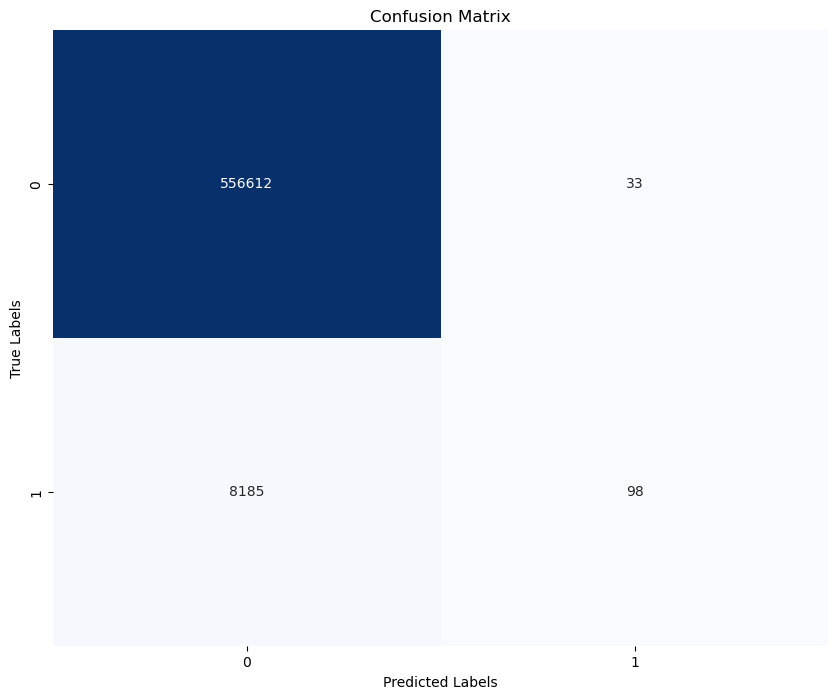

-------------- file 2 -------------------
Model 13 Accuracy: 0.98817283097131
Model 13 precesion: 0.0
Model 13 recall: 0.0
Model 13 fbeta_score: 0.0


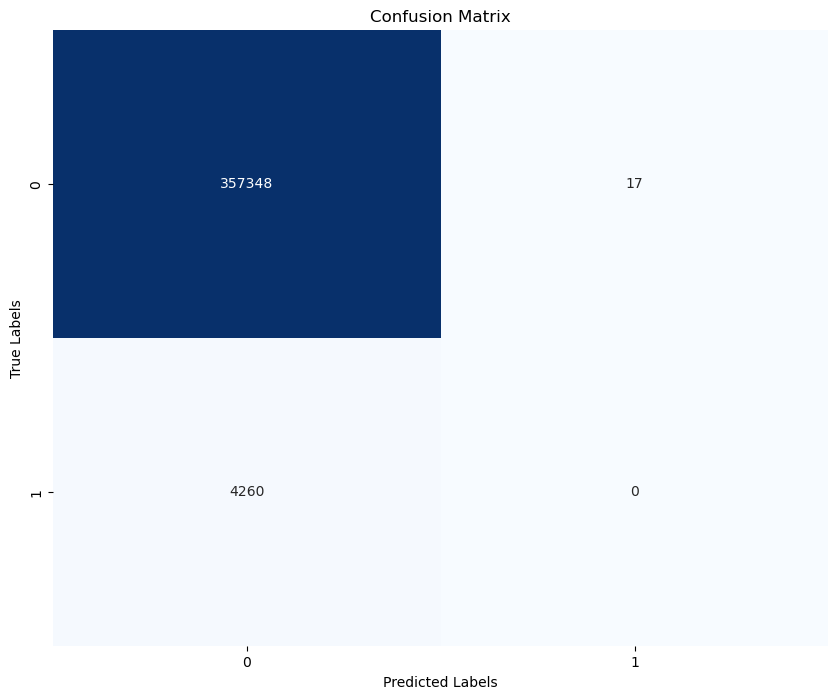

-------------- file 3 -------------------
Model 13 Accuracy: 0.9943139361105922
Model 13 precesion: 0.0
Model 13 recall: 0.0
Model 13 fbeta_score: 0.0


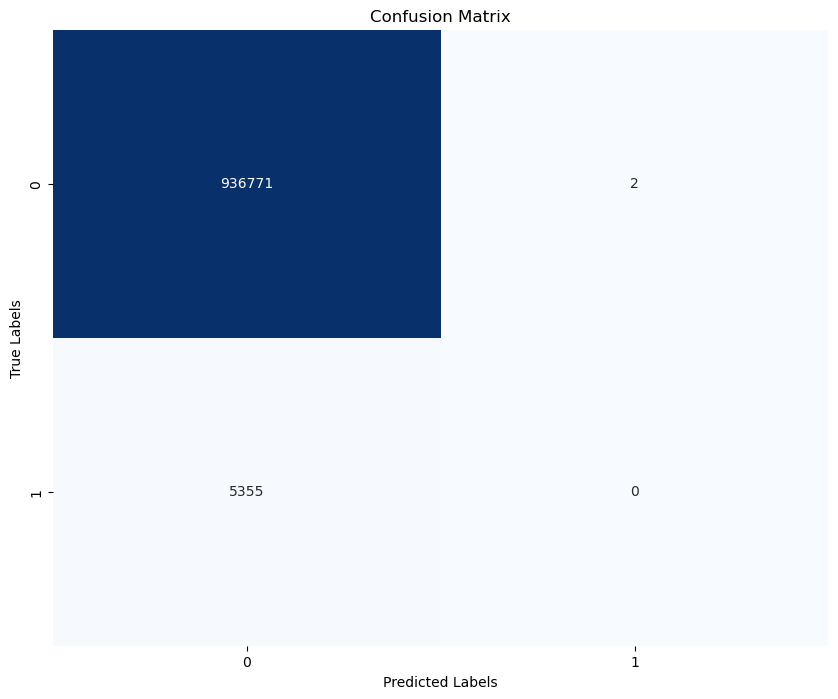

-------------- file 4 -------------------
Model 13 Accuracy: 0.9974310486316766
Model 13 precesion: 0.0
Model 13 recall: 0.0
Model 13 fbeta_score: 0.0


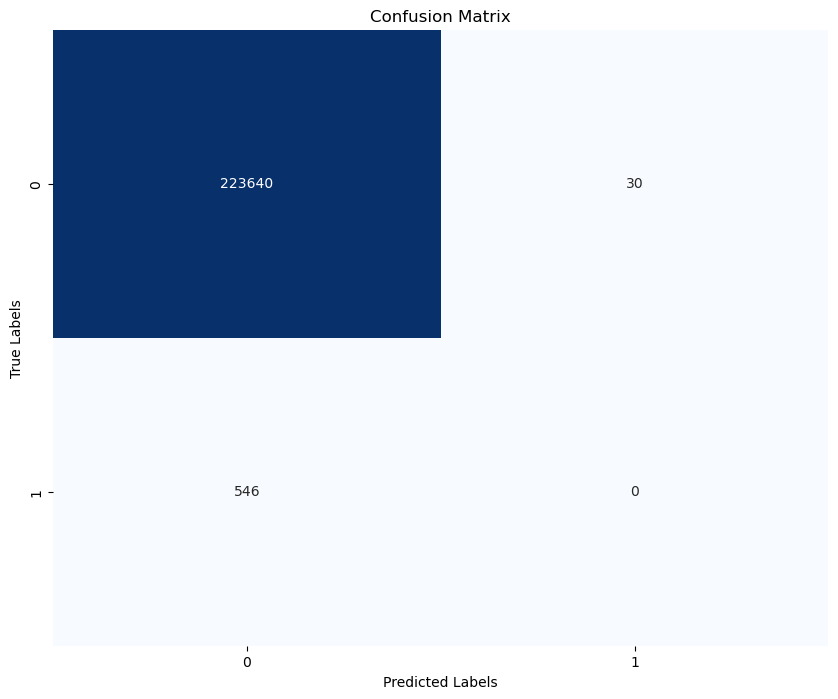

-------------- file 5 -------------------
Model 13 Accuracy: 0.9327993222166596
Model 13 precesion: 0.025688073394495414
Model 13 recall: 0.21649484536082475
Model 13 fbeta_score: 0.045926735921268454


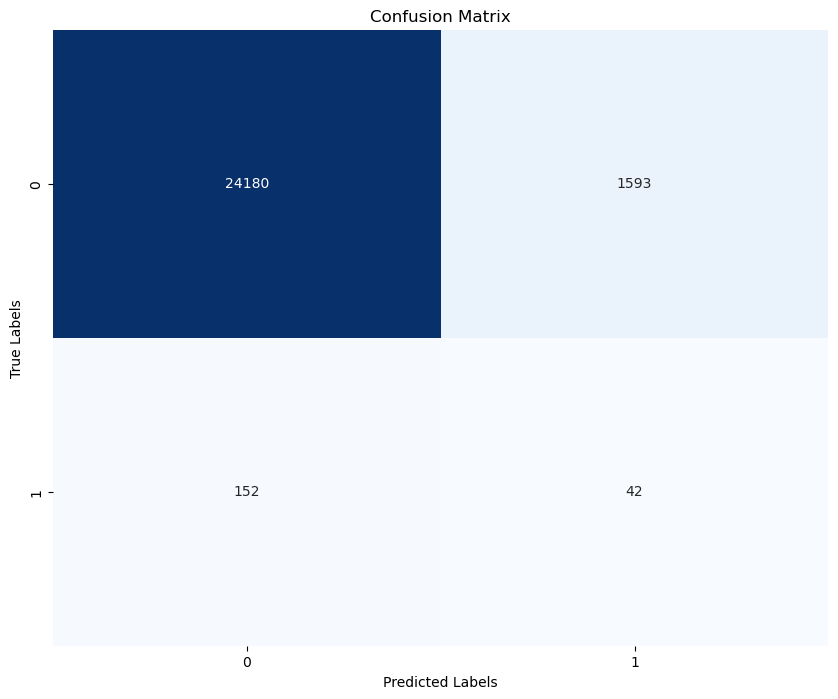

-------------- file 6 -------------------
Model 13 Accuracy: 0.9916714377728476
Model 13 precesion: 0.0
Model 13 recall: 0.0
Model 13 fbeta_score: 0.0


/home/s2316001/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


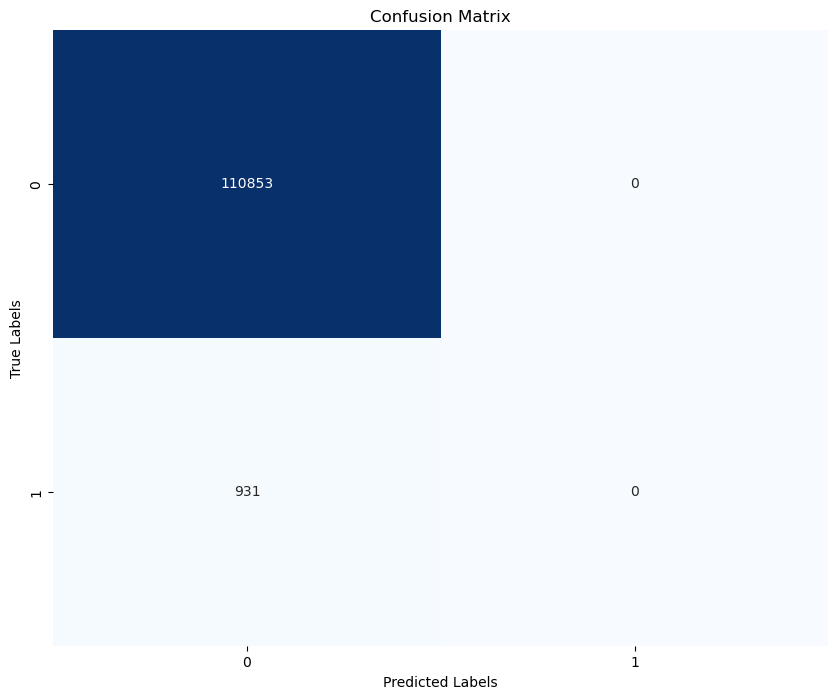

-------------- file 7 -------------------
Model 13 Accuracy: 0.981898667601683
Model 13 precesion: 0.0
Model 13 recall: 0.0
Model 13 fbeta_score: 0.0


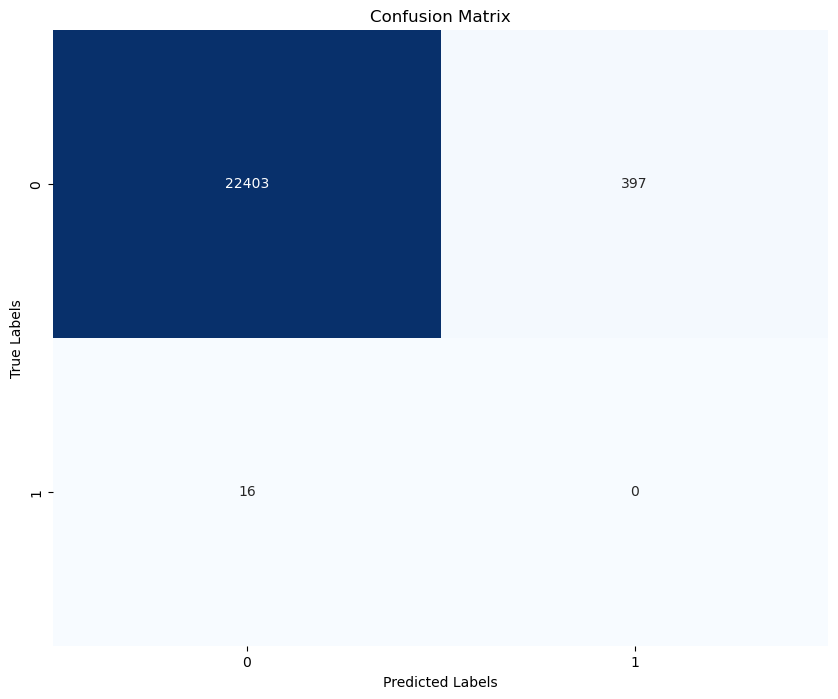

-------------- file 8 -------------------
Model 13 Accuracy: 0.9903172738750876
Model 13 precesion: 0.0
Model 13 recall: 0.0
Model 13 fbeta_score: 0.0


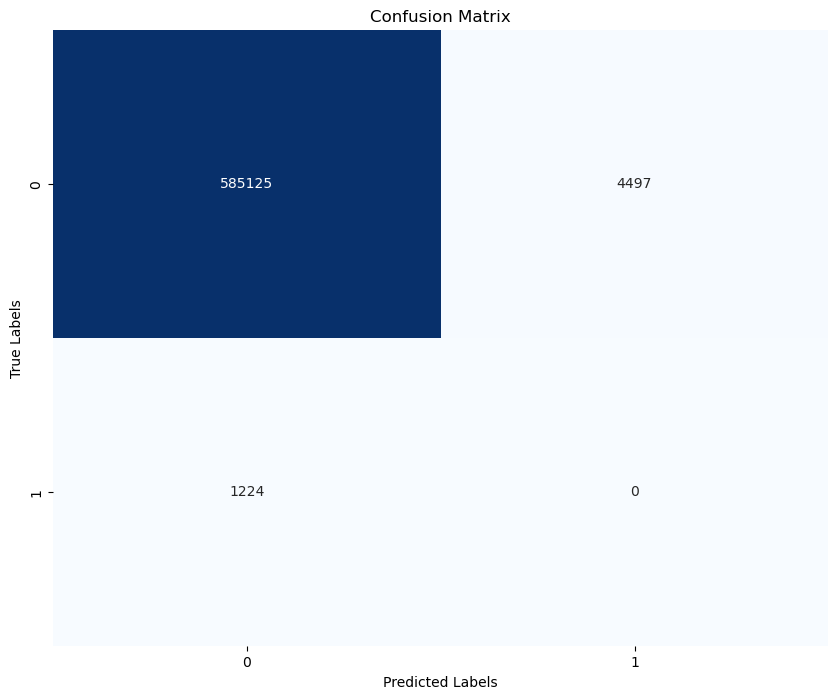

-------------- file 9 -------------------
Model 13 Accuracy: 0.9480792906381287
Model 13 precesion: 0.9963641085573303
Model 13 recall: 0.41512700516677037
Model 13 fbeta_score: 0.5860719127728237


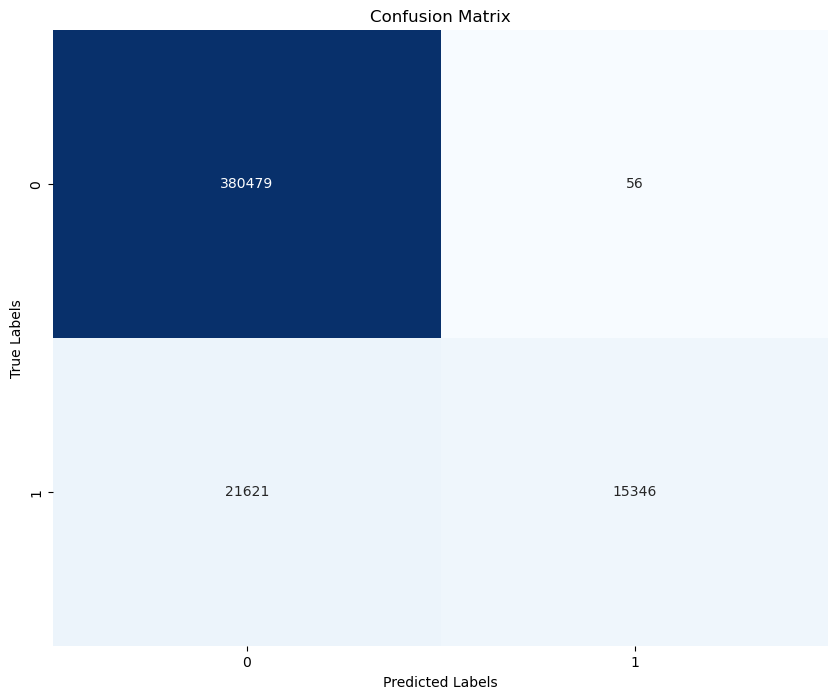

-------------- file 10 -------------------
Model 13 Accuracy: 0.9187391920109635
Model 13 precesion: 0.034482758620689655
Model 13 recall: 4.7036688617121355e-05
Model 13 fbeta_score: 9.394522993095025e-05


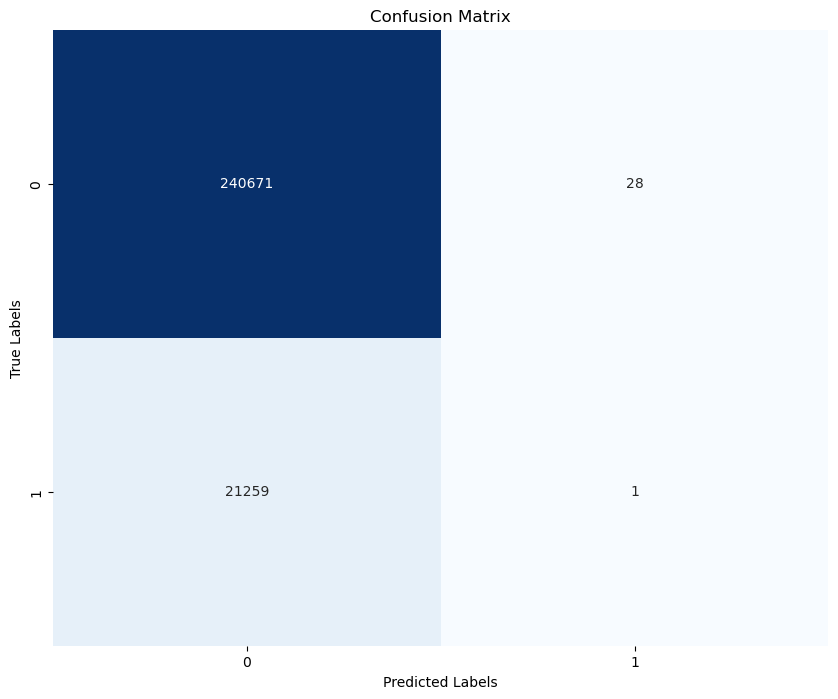

-------------- file 11 -------------------
Model 13 Accuracy: 0.9228474197007133
Model 13 precesion: 0.0
Model 13 recall: 0.0
Model 13 fbeta_score: 0.0


/home/s2316001/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


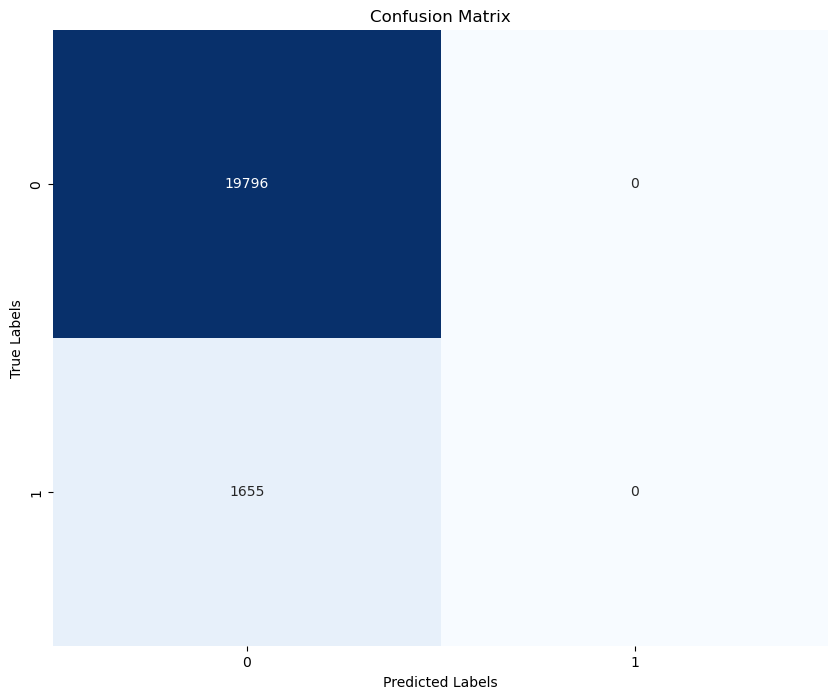

-------------- file 12 -------------------
Model 13 Accuracy: 0.9934096320761964
Model 13 precesion: 0.0
Model 13 recall: 0.0
Model 13 fbeta_score: 0.0


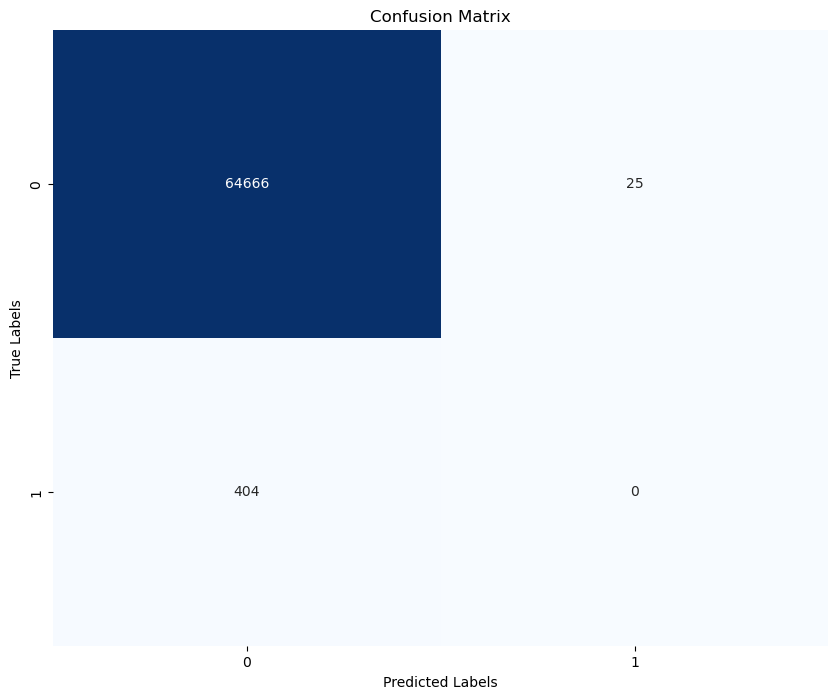

-------------- file 13 -------------------
Model 13 Accuracy: 0.9999896111991273
Model 13 precesion: 1.0
Model 13 recall: 0.9995
Model 13 fbeta_score: 0.9997499374843711


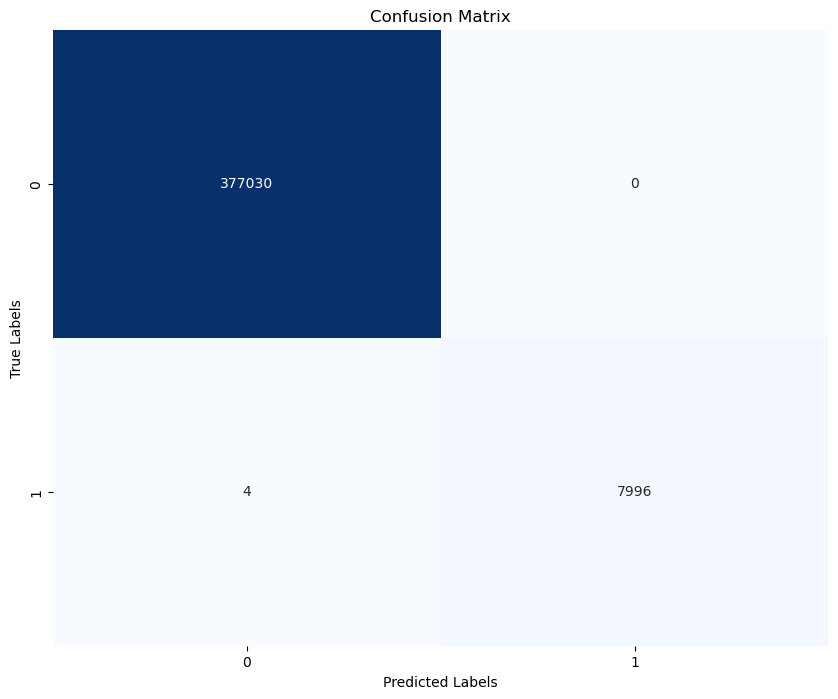

In [8]:
for i in range (1,14):
    model_path = f'/home/s2316001/model_rfe/rfe_model{i}.sav'
    model = joblib.load(model_path)
    print(f'-------------- Model {i} -------------------')
    for z in range (1,14):
        df = pd.read_csv(f"/home/s2316001/Clean_data/test{z}.csv")
        X = df.drop(columns=[df.columns[0],"Label"], axis=1)
        y = df['Label']
        y_pred = model.predict(X)
        accuracy = accuracy_score(y, y_pred)
        precision, recall, fbeta_score, support = metrics.precision_recall_fscore_support(y, y_pred)
        print(f'-------------- file {z} -------------------')
        print(f"Model {i} Accuracy: {accuracy}")
        print(f"Model {i} precesion: {precision[1]}")
        print(f"Model {i} recall: {recall[1]}")
        print(f"Model {i} fbeta_score: {fbeta_score[1]}")
        matrix = metrics.confusion_matrix(y, y_pred)
        #print(matrix)
        # Plot Confusion Matrix
        plt.figure(figsize=(10, 8))
        sns.heatmap(matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
        plt.title('Confusion Matrix')
        plt.xlabel('Predicted Labels')
        plt.ylabel('True Labels')
        
        plt.show()

## Manual Voting

------------------ Test file 1 -----------------------
Ensemble Model Accuracy: 0.9999291945168234
Ensemble Model precesion: 0.9951940406103569
Ensemble Model recall: 1.0
Ensemble Model fbeta_score: 0.9975912320847886


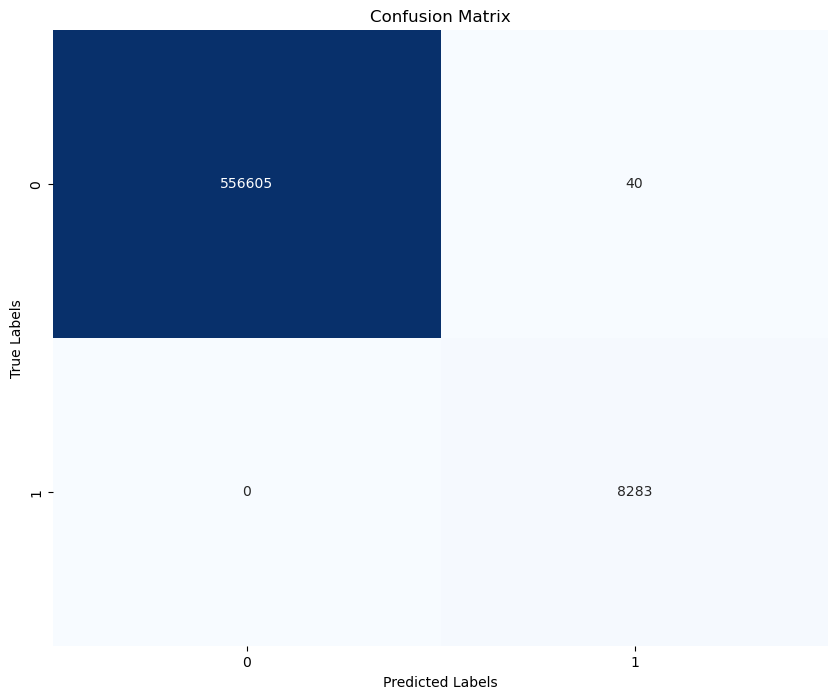

------------------ Test file 2 -----------------------
Ensemble Model Accuracy: 0.9999446940891807
Ensemble Model precesion: 0.9955586722767649
Ensemble Model recall: 0.9997652582159624
Ensemble Model fbeta_score: 0.9976575310377138


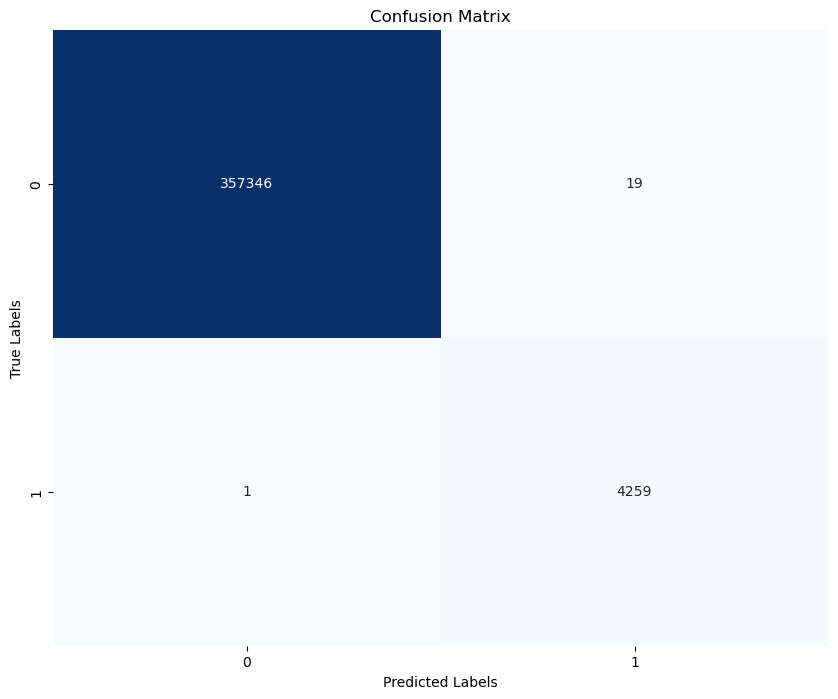

------------------ Test file 3 -----------------------
Ensemble Model Accuracy: 0.9907655859925615
Ensemble Model precesion: 0.3808166464761633
Ensemble Model recall: 0.9979458450046685
Ensemble Model fbeta_score: 0.5512688260779863


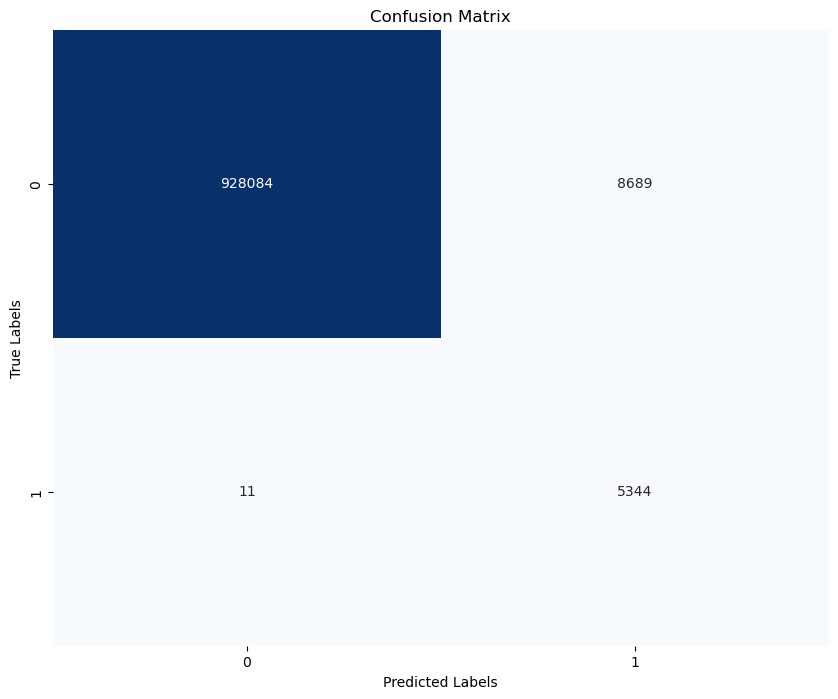

------------------ Test file 4 -----------------------
Ensemble Model Accuracy: 0.9969984300852749
Ensemble Model precesion: 0.44502164502164504
Ensemble Model recall: 0.9413919413919414
Ensemble Model fbeta_score: 0.60435038212816


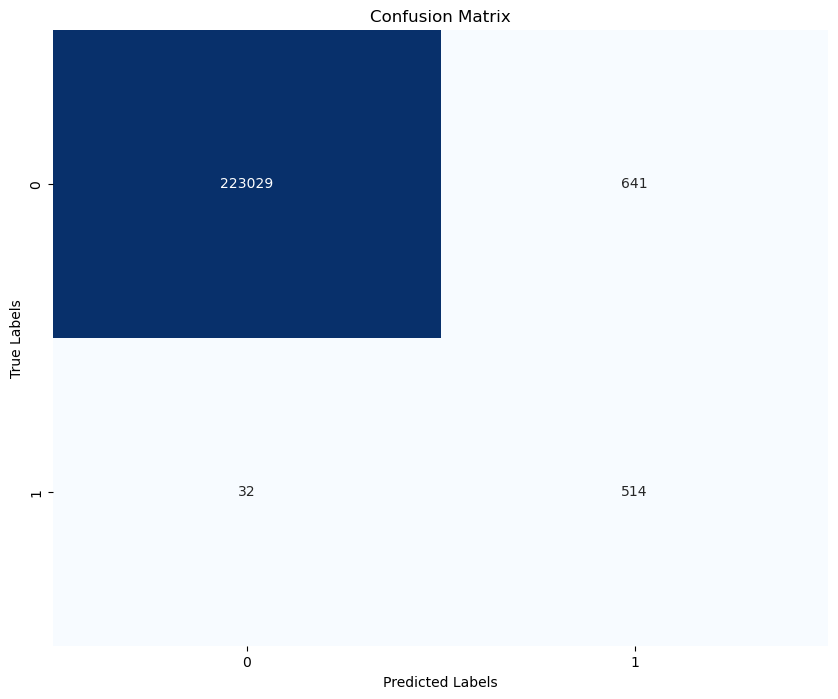

------------------ Test file 5 -----------------------
Ensemble Model Accuracy: 0.9384603535256287
Ensemble Model precesion: 0.10782122905027933
Ensemble Model recall: 0.9948453608247423
Ensemble Model fbeta_score: 0.19455645161290322


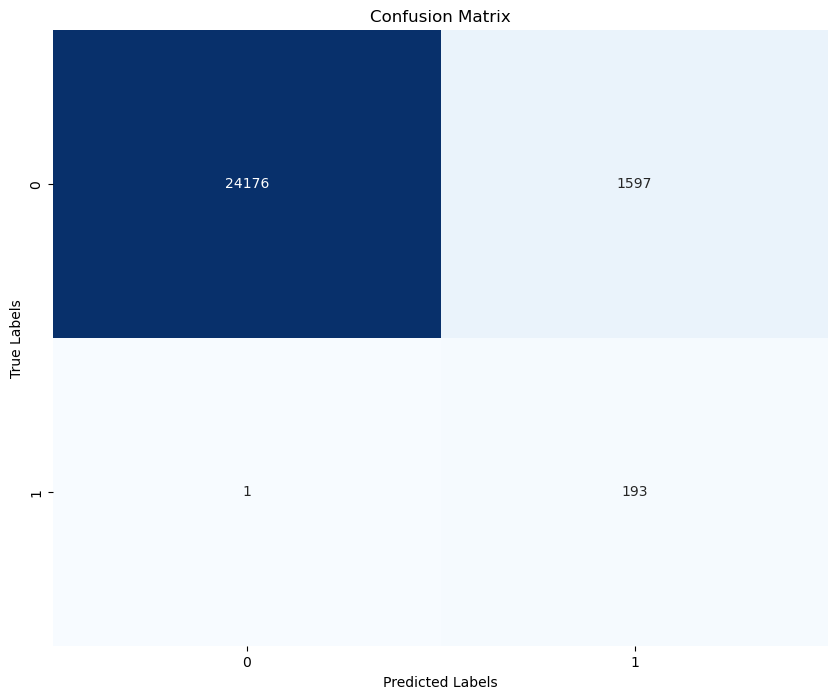

------------------ Test file 6 -----------------------
Ensemble Model Accuracy: 0.9974683317827239
Ensemble Model precesion: 0.7673267326732673
Ensemble Model recall: 0.9989258861439313
Ensemble Model fbeta_score: 0.867942137190854


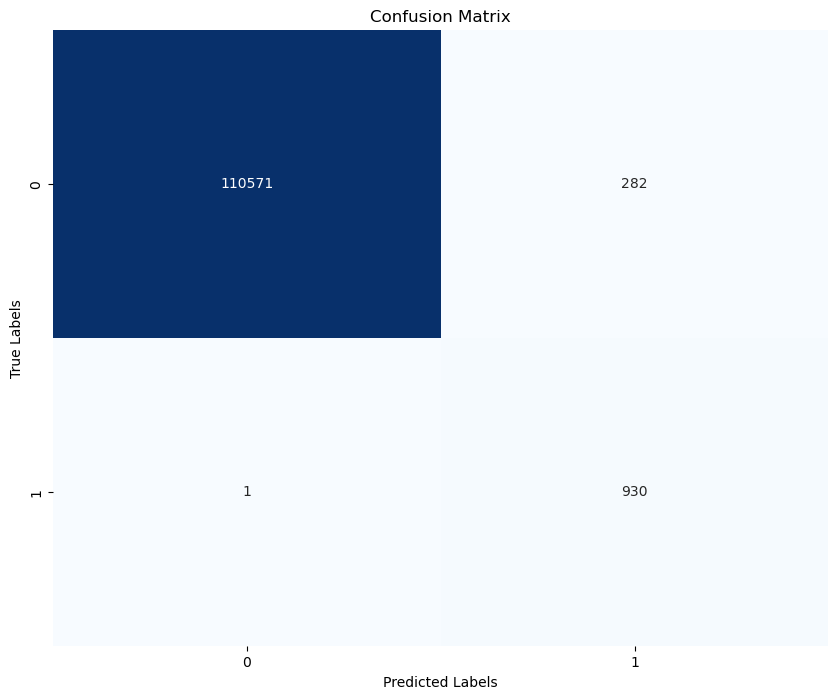

------------------ Test file 7 -----------------------
Ensemble Model Accuracy: 0.9821616409537167
Ensemble Model precesion: 0.02891566265060241
Ensemble Model recall: 0.75
Ensemble Model fbeta_score: 0.05568445475638051


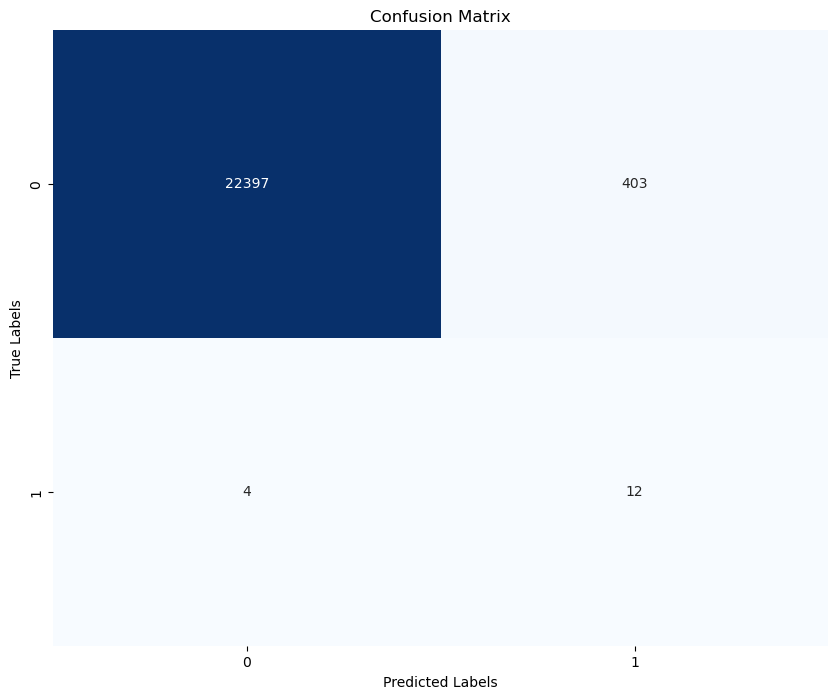

------------------ Test file 8 -----------------------
Ensemble Model Accuracy: 0.9914698584741202
Ensemble Model precesion: 0.18955418158151643
Ensemble Model recall: 0.951797385620915
Ensemble Model fbeta_score: 0.31614654002713705


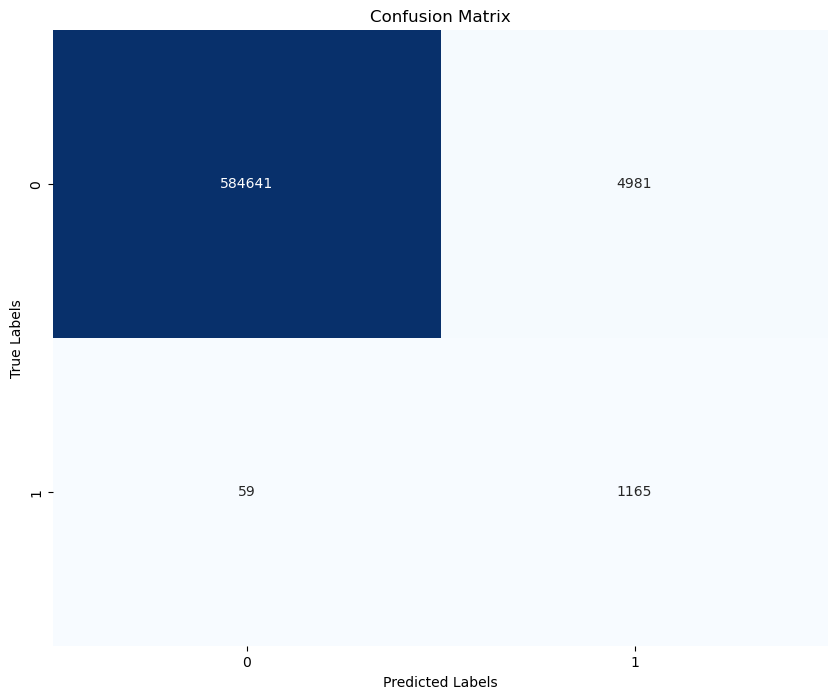

------------------ Test file 9 -----------------------
Ensemble Model Accuracy: 0.999724552217714
Ensemble Model precesion: 0.9970864357397216
Ensemble Model recall: 0.999810641923878
Ensemble Model fbeta_score: 0.9984466806240292


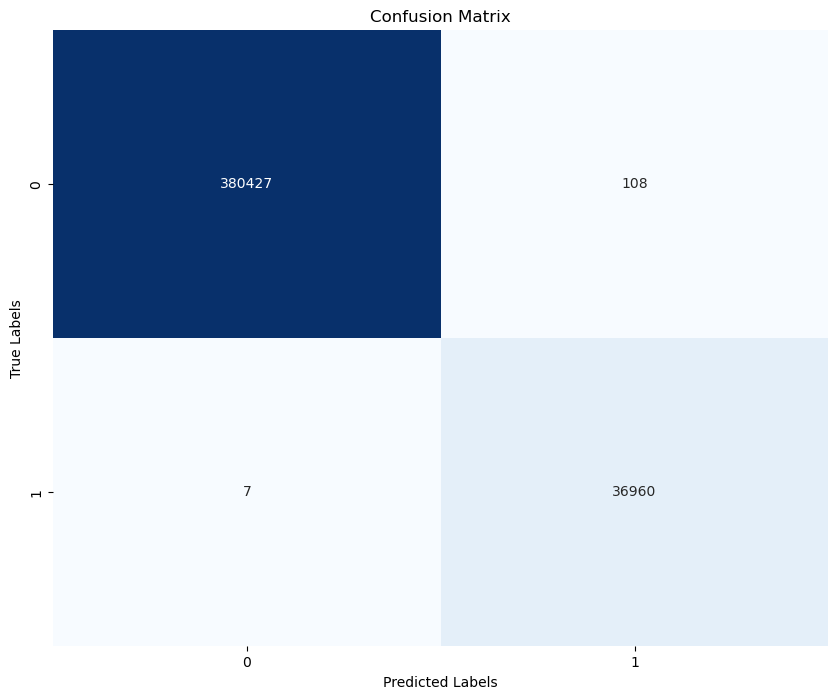

------------------ Test file 10 -----------------------
Ensemble Model Accuracy: 0.9964345565527429
Ensemble Model precesion: 0.958164277341989
Ensemble Model recall: 0.9997177798682972
Ensemble Model fbeta_score: 0.9785000690575939


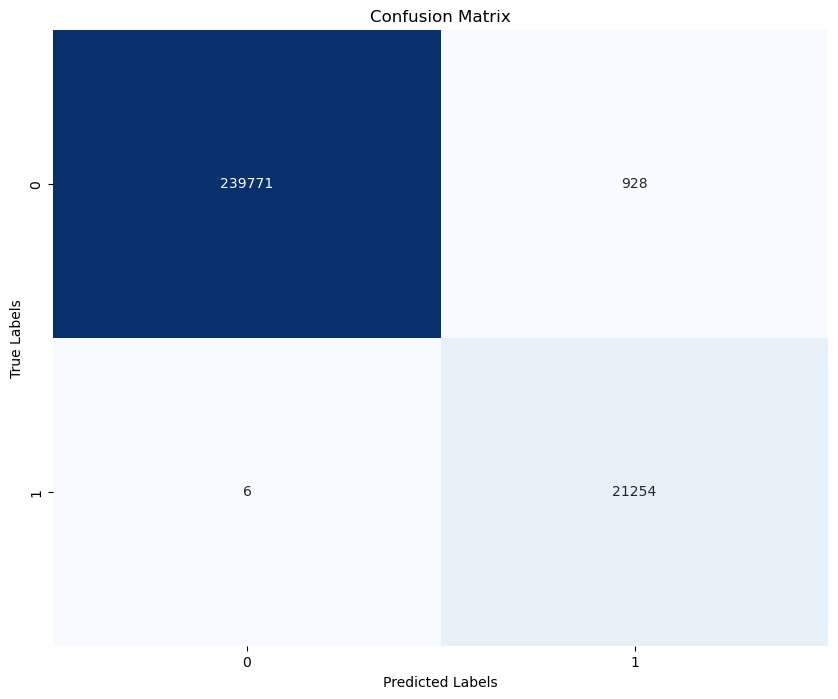

------------------ Test file 11 -----------------------
Ensemble Model Accuracy: 0.9998135285068295
Ensemble Model precesion: 0.997588908981314
Ensemble Model recall: 1.0
Ensemble Model fbeta_score: 0.9987929993964997


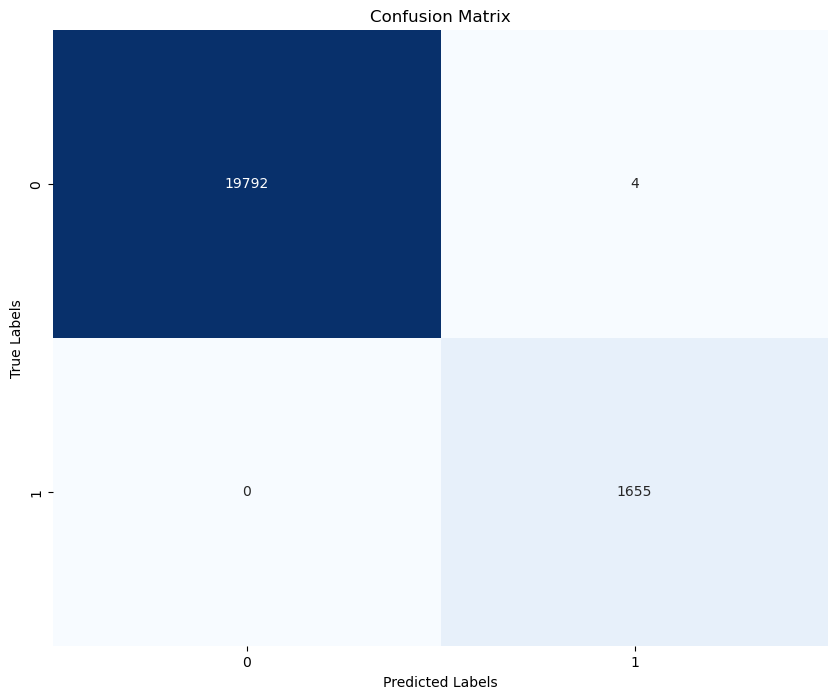

------------------ Test file 12 -----------------------
Ensemble Model Accuracy: 0.9988785621015439
Ensemble Model precesion: 0.8605664488017429
Ensemble Model recall: 0.9777227722772277
Ensemble Model fbeta_score: 0.9154113557358052


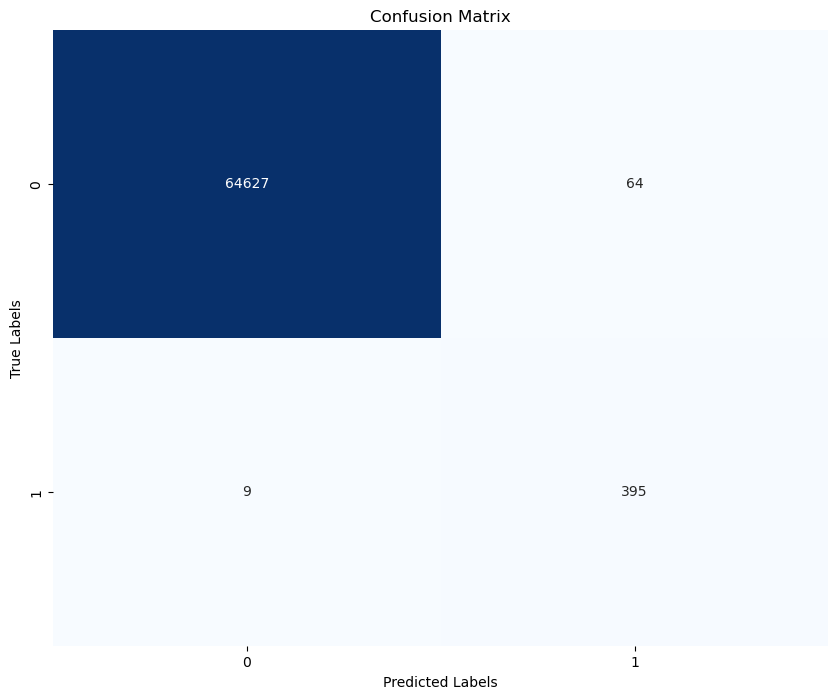

------------------ Test file 13 -----------------------
Ensemble Model Accuracy: 0.6826818689452769
Ensemble Model precesion: 0.06142783612073535
Ensemble Model recall: 0.9995
Ensemble Model fbeta_score: 0.11574231557006273


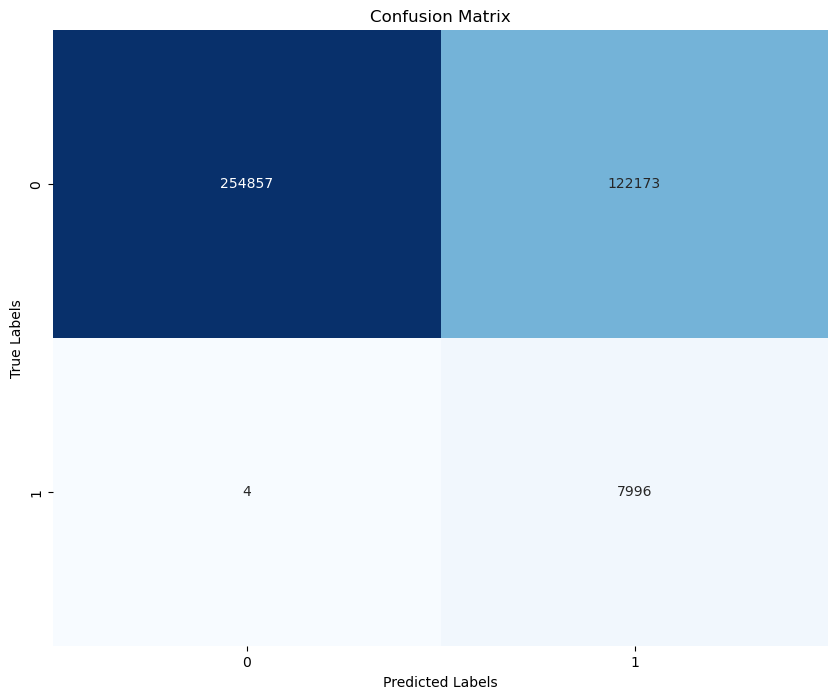

In [9]:
for i in range (1,14):
    model_path = f'/home/s2316001/model_rfe/rfe_model{i}.sav'  # Change the path to the saved model
    exec(f'loaded_model{i} = joblib.load(model_path)')
for z in range (1,14):
    new_data = pd.read_csv(f"/home/s2316001/Clean_data/test{z}.csv")
    X_en = new_data.drop(columns=[new_data.columns[0],"Label"], axis=1)
    y_en = new_data['Label']
    predictions=[]
    prediction = loaded_model1.predict(X_en)
    predictions.append(prediction)
    prediction = loaded_model2.predict(X_en)
    predictions.append(prediction)
    prediction = loaded_model3.predict(X_en)
    predictions.append(prediction)
    prediction = loaded_model4.predict(X_en)
    predictions.append(prediction)
    prediction = loaded_model5.predict(X_en)
    predictions.append(prediction)
    prediction = loaded_model6.predict(X_en)
    predictions.append(prediction)
    prediction = loaded_model7.predict(X_en)
    predictions.append(prediction)
    prediction = loaded_model8.predict(X_en)
    predictions.append(prediction)
    prediction = loaded_model9.predict(X_en)
    predictions.append(prediction)
    prediction = loaded_model10.predict(X_en)
    predictions.append(prediction)
    prediction = loaded_model11.predict(X_en)
    predictions.append(prediction)
    prediction = loaded_model12.predict(X_en)
    predictions.append(prediction)
    prediction = loaded_model13.predict(X_en)
    predictions.append(prediction)
    # for model in models:
    #     prediction = model.predict(X_en)
    #     predictions.append(prediction)
    temp = np.stack((predictions[0],predictions[1],predictions[2],predictions[3],predictions[4],predictions[5],predictions[6],predictions[7],predictions[8],predictions[9],predictions[10],predictions[11],predictions[12]), axis=-1)
    result = np.arange(temp.shape[0])
    rows = temp.shape[0]
    columns= temp.shape[1]
    for i in range (rows):
        check = 0
        for j in range (columns):
            if  temp[i][j] == 1:
                result[i]=1
                # if j+1 == z:
                #     check += 5
                # else:
                #     check += 2.5
                break
            else:
                result[i]=0
        #         check += 0
        # if check/10 >= 0.5:
        #     result[i] = 1
        # else:
        #     result[i] = 0
    print(f"------------------ Test file {z} -----------------------")
    score = accuracy_score(y_en, result)
    print('Ensemble Model Accuracy: {}'.format(score))
    precision, recall, fbeta_score, support = metrics.precision_recall_fscore_support(y_en, result)
    print(f"Ensemble Model precesion: {precision[1]}")
    print(f"Ensemble Model recall: {recall[1]}")
    print(f"Ensemble Model fbeta_score: {fbeta_score[1]}")
    matrix = metrics.confusion_matrix(y_en, result)
    #print(matrix)
    # Plot Confusion Matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.savefig(f'/home/s2316001/Ensemble_matrix/file_manual{z}.png')
    plt.show()

## test 12 file

In [10]:
for i in range (1,14):
    model_path = f'/home/s2316001/model_rfe/rfe_model{i}.sav'  # Change the path to the saved model
    exec(f'loaded_model{i} = joblib.load(model_path)')

done 2
done 3
done 4
done 5
done 6
done 7
done 8
done 9
done 10
done 11
done 12
done 13
------------------ Test file 1 -----------------------
Ensemble Model Accuracy: 0.9880494336261381
Ensemble Model precesion: 0.9674322044894252
Ensemble Model recall: 0.18202680598618198
Ensemble Model fbeta_score: 0.3064025643133065


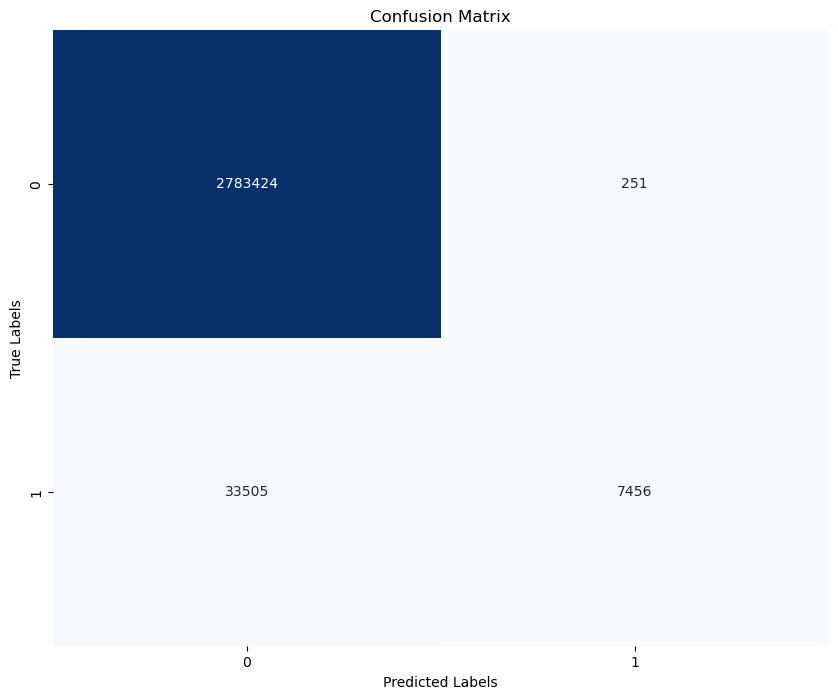

done 1
done 3
done 4
done 5
done 6
done 7
done 8
done 9
done 10
done 11
done 12
done 13
------------------ Test file 2 -----------------------
Ensemble Model Accuracy: 0.9927903095034516
Ensemble Model precesion: 0.9895949461166852
Ensemble Model recall: 0.38150040590229695
Ensemble Model fbeta_score: 0.5506996622320259


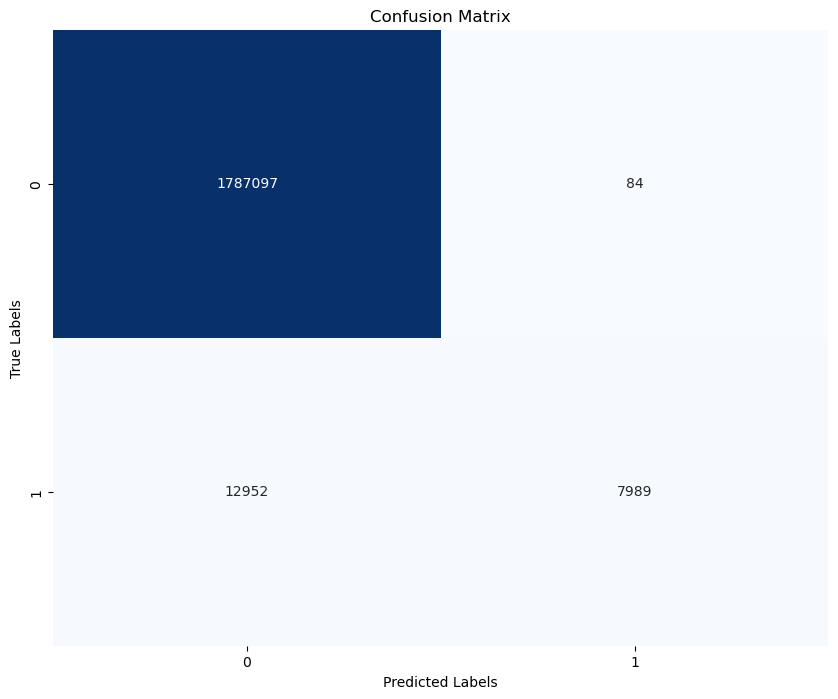

done 1
done 2
done 4
done 5
done 6
done 7
done 8
done 9
done 10
done 11
done 12
done 13
------------------ Test file 3 -----------------------
Ensemble Model Accuracy: 0.9851032917409489
Ensemble Model precesion: 0.0
Ensemble Model recall: 0.0
Ensemble Model fbeta_score: 0.0


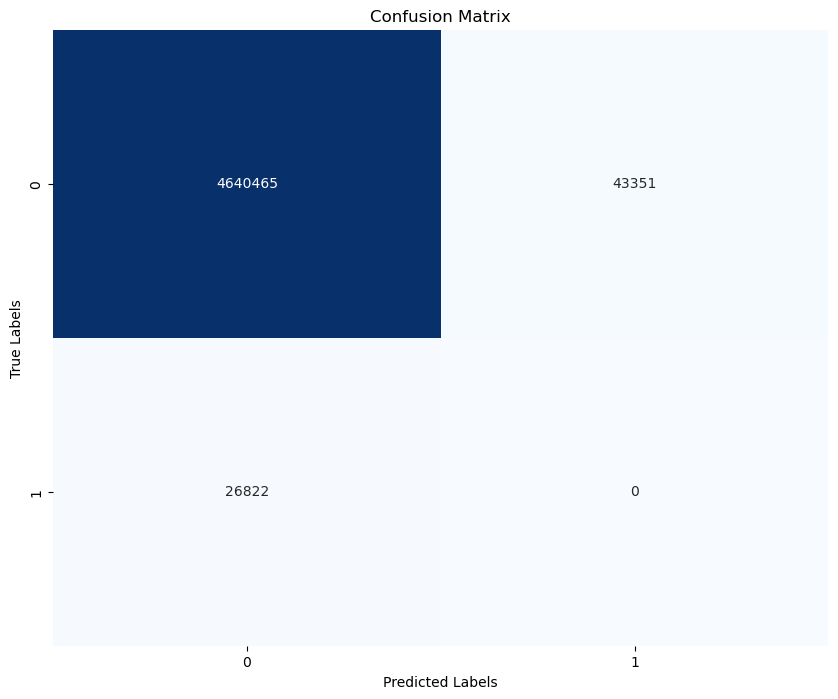

done 1
done 2
done 3
done 5
done 6
done 7
done 8
done 9
done 10
done 11
done 12
done 13
------------------ Test file 4 -----------------------
Ensemble Model Accuracy: 0.9958165191298359
Ensemble Model precesion: 0.27742616033755274
Ensemble Model recall: 0.5096899224806202
Ensemble Model fbeta_score: 0.3592896174863388


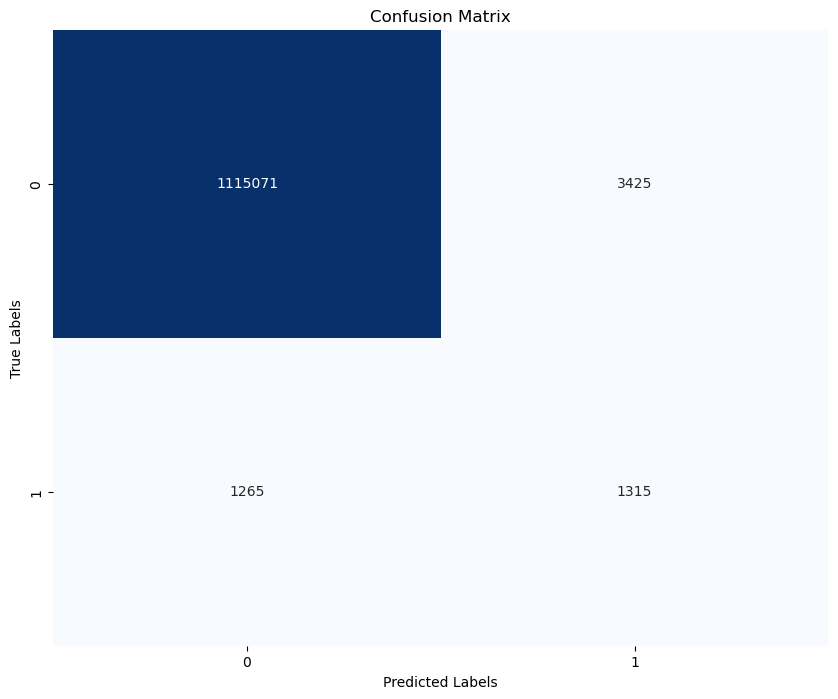

done 1
done 2
done 3
done 4
done 6
done 7
done 8
done 9
done 10
done 11
done 12
done 13
------------------ Test file 5 -----------------------
Ensemble Model Accuracy: 0.9337913611436318
Ensemble Model precesion: 0.022109054775804247
Ensemble Model recall: 0.19755826859045506
Ensemble Model fbeta_score: 0.03976764968722073


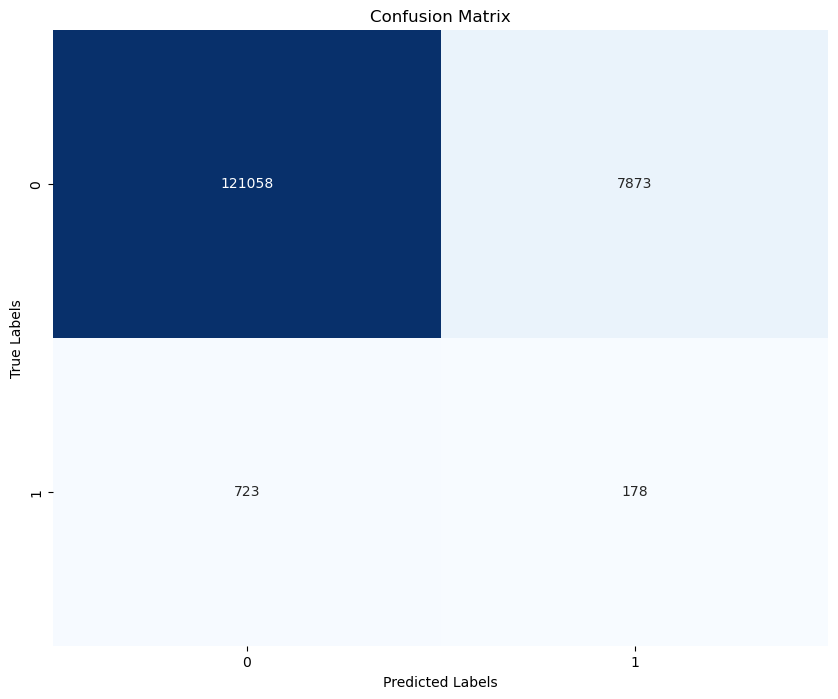

done 1
done 2
done 3
done 4
done 5
done 7
done 8
done 9
done 10
done 11
done 12
done 13
------------------ Test file 6 -----------------------
Ensemble Model Accuracy: 0.9962284338159912
Ensemble Model precesion: 0.7347356664184661
Ensemble Model recall: 0.8524838012958963
Ensemble Model fbeta_score: 0.7892421515696859


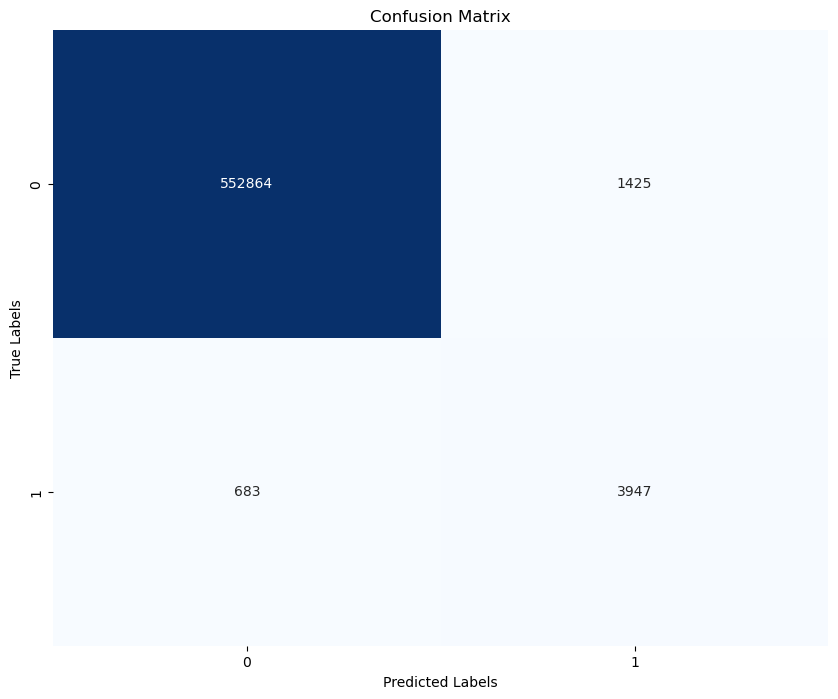

done 1
done 2
done 3
done 4
done 5
done 6
done 8
done 9
done 10
done 11
done 12
done 13
------------------ Test file 7 -----------------------
Ensemble Model Accuracy: 0.9806358862873322
Ensemble Model precesion: 0.0
Ensemble Model recall: 0.0
Ensemble Model fbeta_score: 0.0


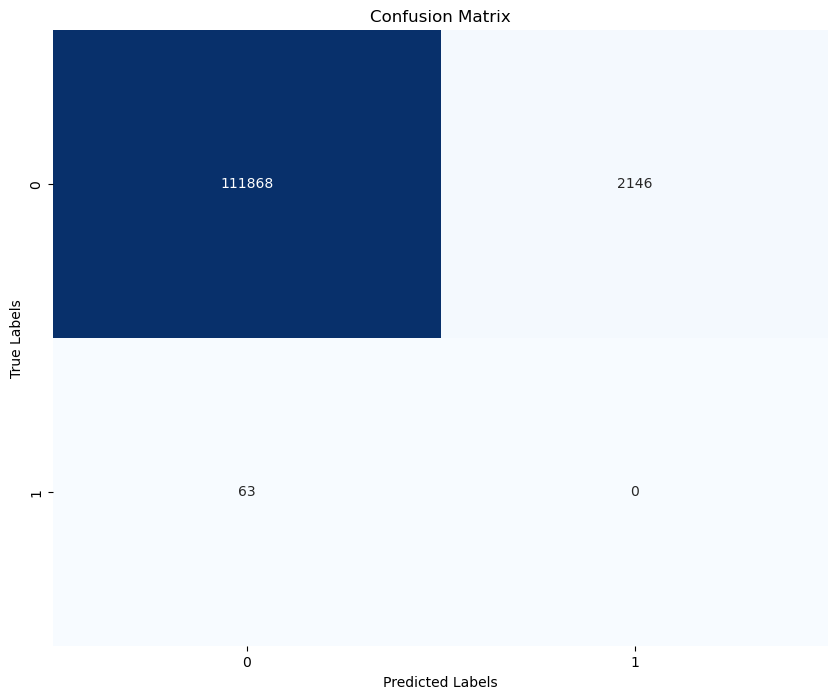

done 1
done 2
done 3
done 4
done 5
done 6
done 7
done 9
done 10
done 11
done 12
done 13
------------------ Test file 8 -----------------------
Ensemble Model Accuracy: 0.9894155160566375
Ensemble Model precesion: 0.0
Ensemble Model recall: 0.0
Ensemble Model fbeta_score: 0.0


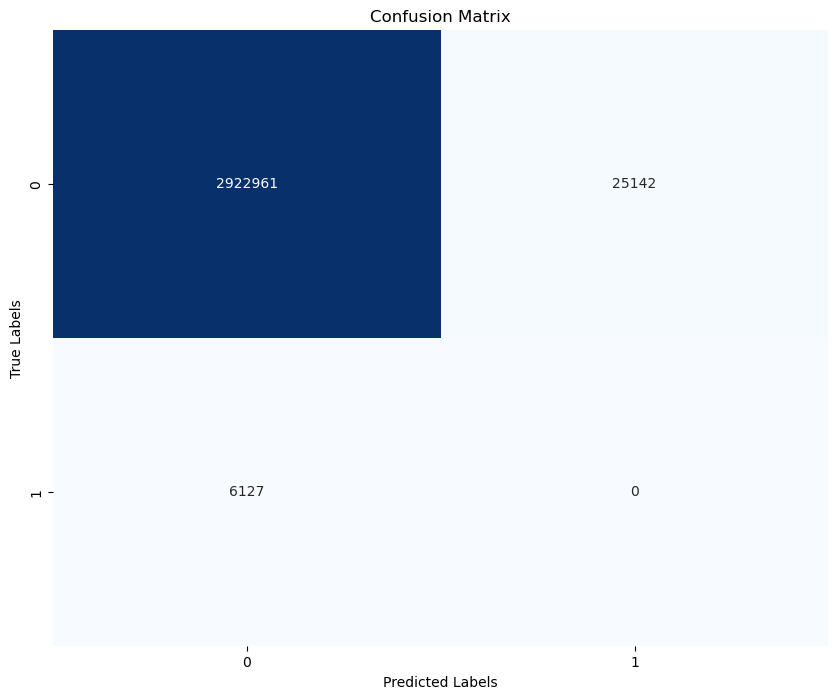

done 1
done 2
done 3
done 4
done 5
done 6
done 7
done 8
done 10
done 11
done 12
done 13
------------------ Test file 9 -----------------------
Ensemble Model Accuracy: 0.948305826851921
Ensemble Model precesion: 0.993406312015876
Ensemble Model recall: 0.4194348792077281
Ensemble Model fbeta_score: 0.5898316938561415


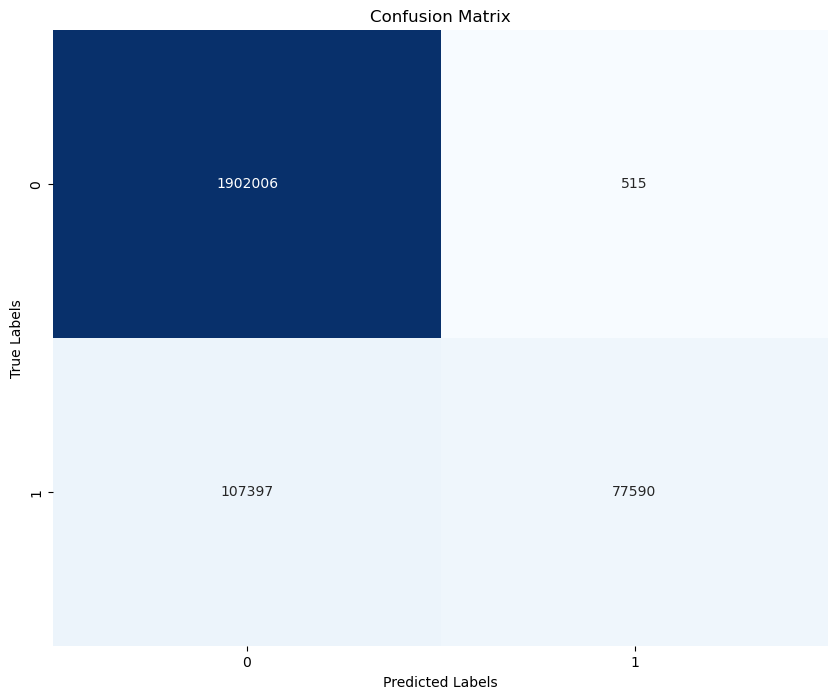

done 1
done 2
done 3
done 4
done 5
done 6
done 7
done 8
done 9
done 11
done 12
done 13
------------------ Test file 10 -----------------------
Ensemble Model Accuracy: 0.9197940740163889
Ensemble Model precesion: 0.5616750546007027
Ensemble Model recall: 0.05561719572739582
Ensemble Model fbeta_score: 0.10121232343454567


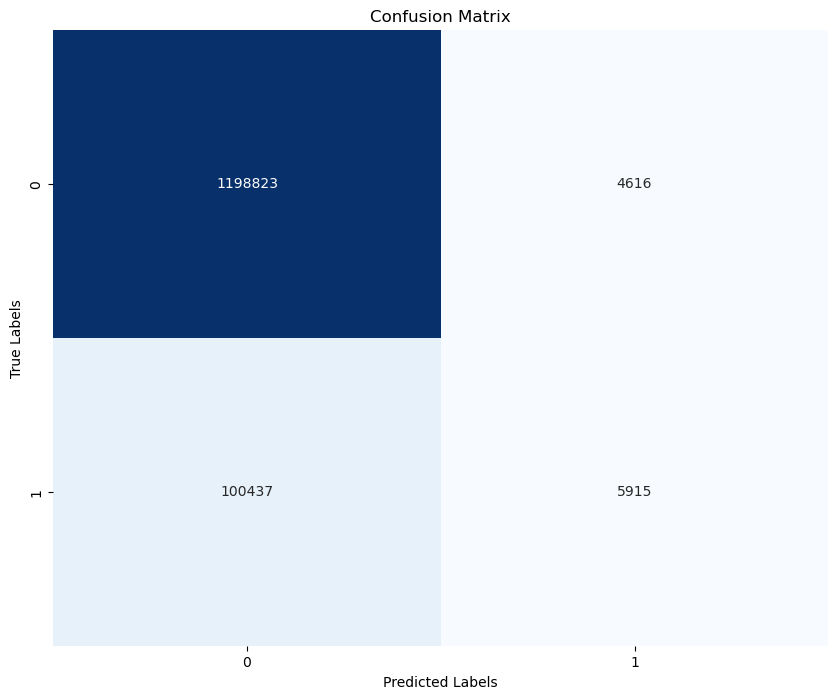

done 1
done 2
done 3
done 4
done 5
done 6
done 7
done 8
done 9
done 10
done 12
done 13
------------------ Test file 11 -----------------------
Ensemble Model Accuracy: 0.928196473692553
Ensemble Model precesion: 0.9530332681017613
Ensemble Model recall: 0.05965213130818226
Ensemble Model fbeta_score: 0.11227665706051872


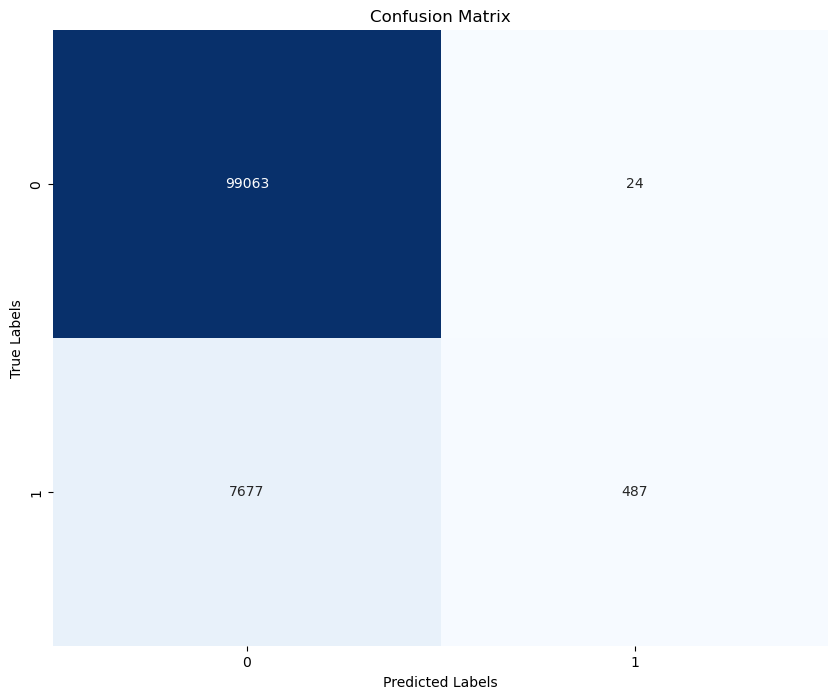

done 1
done 2
done 3
done 4
done 5
done 6
done 7
done 8
done 9
done 10
done 11
done 13
------------------ Test file 12 -----------------------
Ensemble Model Accuracy: 0.9925277520885117
Ensemble Model precesion: 0.0
Ensemble Model recall: 0.0
Ensemble Model fbeta_score: 0.0


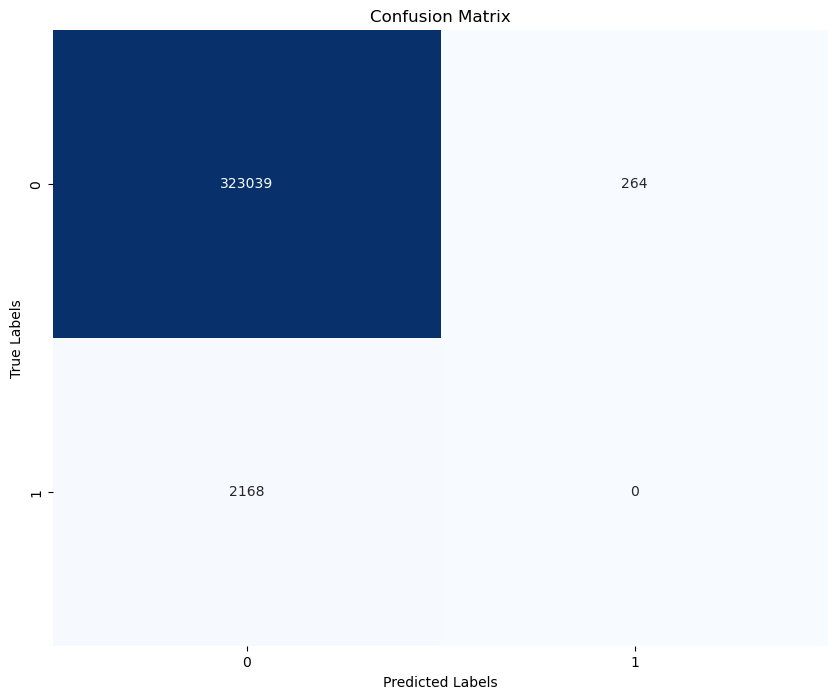

done 1
done 2
done 3
done 4
done 5
done 6
done 7
done 8
done 9
done 10
done 11
done 12
------------------ Test file 13 -----------------------
Ensemble Model Accuracy: 0.6633470967701721
Ensemble Model precesion: 0.003983764771904181
Ensemble Model recall: 0.06104542159338049
Ensemble Model fbeta_score: 0.007479429272378945


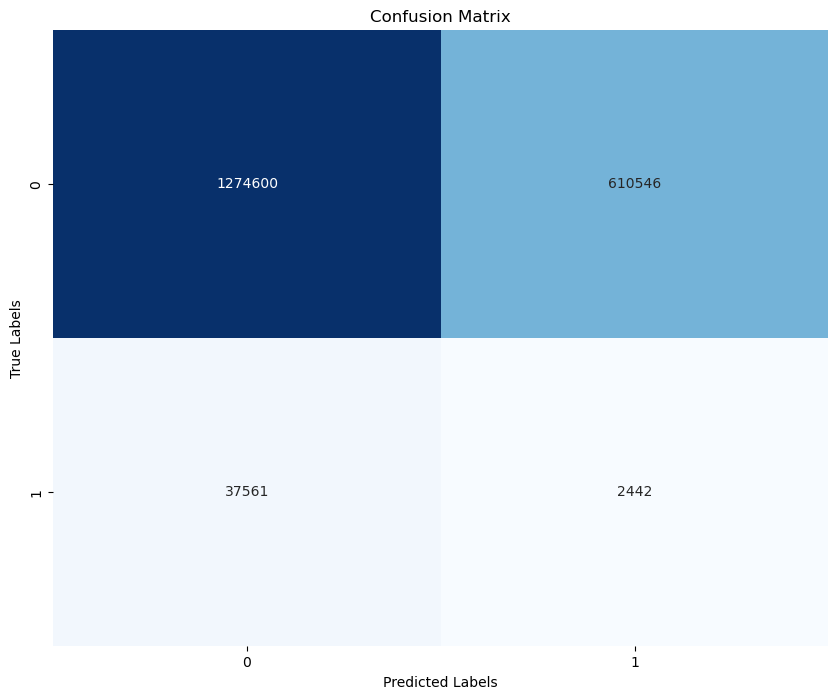

In [11]:
for z in range (1,14):
    new_data = pd.read_csv(f"/home/s2316001/Clean_data/Clean_{z}-XX.csv")
    X_en = new_data.drop(columns=[new_data.columns[0],"Label"], axis=1)
    y_en = new_data['Label']
    predictions=[]
    for k in range (1,14):
        if k != z:
            exec(f'prediction = loaded_model{k}.predict(X_en)')
            predictions.append(prediction)
            print(f'done {k}')
    # prediction = loaded_model1.predict(X_en)
    # predictions.append(prediction)
    # prediction = loaded_model2.predict(X_en)
    # predictions.append(prediction)
    # prediction = loaded_model3.predict(X_en)
    # predictions.append(prediction)
    # prediction = loaded_model4.predict(X_en)
    # predictions.append(prediction)
    # prediction = loaded_model5.predict(X_en)
    # predictions.append(prediction)
    # prediction = loaded_model6.predict(X_en)
    # predictions.append(prediction)
    # prediction = loaded_model7.predict(X_en)
    # predictions.append(prediction)
    # prediction = loaded_model8.predict(X_en)
    # predictions.append(prediction)
    # prediction = loaded_model9.predict(X_en)
    # predictions.append(prediction)
    # prediction = loaded_model10.predict(X_en)
    # predictions.append(prediction)
    # prediction = loaded_model11.predict(X_en)
    # predictions.append(prediction)
    # prediction = loaded_model12.predict(X_en)
    # predictions.append(prediction)
    # prediction = loaded_model13.predict(X_en)
    # predictions.append(prediction)    
    temp = np.stack((predictions[0],predictions[1],predictions[2],predictions[3],predictions[4],predictions[5],predictions[6],predictions[7],predictions[8],predictions[9],predictions[10],predictions[11]), axis=-1)
    result = np.arange(temp.shape[0])
    rows = temp.shape[0]
    columns= temp.shape[1]
    for i in range (rows):
        check = 0
        for j in range (columns):
            if  temp[i][j] == 1:
                result[i]=1
                break
            else:
                result[i]=0
    print(f"------------------ Test file {z} -----------------------")
    score = accuracy_score(y_en, result)
    print('Ensemble Model Accuracy: {}'.format(score))
    precision, recall, fbeta_score, support = metrics.precision_recall_fscore_support(y_en, result)
    print(f"Ensemble Model precesion: {precision[1]}")
    print(f"Ensemble Model recall: {recall[1]}")
    print(f"Ensemble Model fbeta_score: {fbeta_score[1]}")
    matrix = metrics.confusion_matrix(y_en, result)
    #print(matrix)
    # Plot Confusion Matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.savefig(f'/home/s2316001/Ensemble_matrix/ensemble12/12file_manual_{z}.png')
    plt.show()

## Voting Classifier

------------------ Test file -----------------------
Ensemble Model Accuracy: 0.9854123003285374
Ensemble Model precesion: 0.0
Ensemble Model recall: 0.0
Ensemble Model fbeta_score: 0.0


/home/s2316001/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


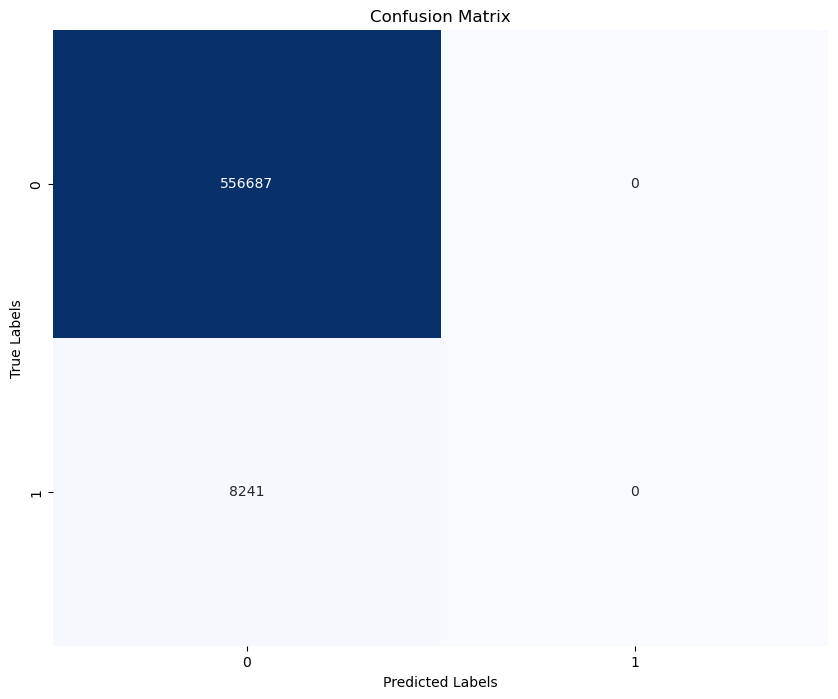

In [223]:
from mlxtend.classifier import EnsembleVoteClassifier

eclf = EnsembleVoteClassifier(clfs=models,voting='hard', fit_base_estimators=False,use_clones = False)
labels = ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', 'En']
new_data = pd.read_csv(f"/home/s2316001/Clean_data/test1.csv")
X_en = new_data.drop(columns=[new_data.columns[0],"Label"], axis=1)
y_en = new_data['Label']
eclf.fit(X_en, y_en)
pred = eclf.predict(X_en)
print(f"------------------ Test file -----------------------")
score = accuracy_score(y_en, pred)
print('Ensemble Model Accuracy: {}'.format(score))
precision, recall, fbeta_score, support = metrics.precision_recall_fscore_support(y_en, pred)
print(f"Ensemble Model precesion: {precision[1]}")
print(f"Ensemble Model recall: {recall[1]}")
print(f"Ensemble Model fbeta_score: {fbeta_score[1]}")
matrix = metrics.confusion_matrix(y_en, pred)
plt.figure(figsize=(10, 8))
sns.heatmap(matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')

plt.show()

# Read 13 csv into 1

In [44]:
# for i in range (0,50):
#     X_train = pd.DataFrame()
#     X_val= pd.DataFrame()
#     y_train= pd.DataFrame()
#     y_val= pd.DataFrame()
#     print(f'----------- Round {i}------------------')
#     for z in range (1,14):
#         new_data = pd.read_csv(f"/home/s2316001/Clean_data/Clean_{z}-XX.csv")
#         print(new_data.shape)
#         X = new_data.drop(columns=[new_data.columns[0],"Label"], axis=1)
#         y = new_data['Label']
#         X_train_temp, X_val_temp, y_train_temp, y_val_temp = train_test_split(X, y, test_size=0.3)
#         df_train_each = pd.concat([X_train_temp,y_train_temp],axis=1)
#         df_test_each = pd.concat([X_val_temp,y_val_temp],axis=1)
#         df_train_each.rename(columns = {0:'Label'}, inplace = True)
#         df_test_each.rename(columns = {0:'Label'}, inplace = True)
#         df_train_each.to_csv(f'/home/s2316001/Clean_data/Merge13_split/file{z}/train{i}.csv', encoding='utf-8')
#         df_test_each.to_csv(f'/home/s2316001/Clean_data/Merge13_split/file{z}/test{i}.csv', encoding='utf-8')
#         X_train = pd.concat([X_train,X_train_temp])
#         X_val = pd.concat([X_val,X_val_temp])
#         y_train = pd.concat([y_train,y_train_temp])
#         y_val = pd.concat([y_val,y_val_temp])
#     df_train = pd.concat([X_train,y_train],axis=1)
#     df_test = pd.concat([X_val,y_val],axis=1)
#     df_train.rename(columns = {0:'Label'}, inplace = True)
#     df_test.rename(columns = {0:'Label'}, inplace = True)
#     df_train.to_csv(f'/home/s2316001/Clean_data/Merge13_split/train{i}.csv', encoding='utf-8')
#     df_test.to_csv(f'/home/s2316001/Clean_data/Merge13_split/test{i}.csv', encoding='utf-8')

----------- Round 0------------------
(2824636, 14)
(1808122, 14)
(4710638, 14)
(1121076, 14)
(129832, 14)
(558919, 14)
(114077, 14)
(2954230, 14)
(2087508, 14)
(1309791, 14)
(107251, 14)
(325471, 14)
(1925149, 14)
----------- Round 1------------------
(2824636, 14)
(1808122, 14)
(4710638, 14)
(1121076, 14)
(129832, 14)
(558919, 14)
(114077, 14)
(2954230, 14)
(2087508, 14)
(1309791, 14)
(107251, 14)
(325471, 14)
(1925149, 14)
----------- Round 2------------------
(2824636, 14)
(1808122, 14)
(4710638, 14)
(1121076, 14)
(129832, 14)
(558919, 14)
(114077, 14)
(2954230, 14)
(2087508, 14)
(1309791, 14)
(107251, 14)
(325471, 14)
(1925149, 14)
----------- Round 3------------------
(2824636, 14)
(1808122, 14)
(4710638, 14)
(1121076, 14)
(129832, 14)
(558919, 14)
(114077, 14)
(2954230, 14)
(2087508, 14)
(1309791, 14)
(107251, 14)
(325471, 14)
(1925149, 14)
----------- Round 4------------------
(2824636, 14)
(1808122, 14)
(4710638, 14)
(1121076, 14)
(129832, 14)
(558919, 14)
(114077, 14)
(295423

In [12]:
df = pd.DataFrame()
for i in range(1,14):
    new_data = pd.read_csv(f'/home/s2316001/Clean_data/train{i}.csv')
    df = pd.concat([df,new_data])

In [13]:
X_train = df.drop(columns=[df.columns[0],"Label"], axis=1)
y_train = df['Label']
model = RandomForestClassifier(n_estimators=100)  # You can adjust the hyperparameters as needed
model.fit(X_train, y_train)
filename = f'/home/s2316001/model_rfe/rfe_model13to1.sav'
joblib.dump(model, filename)
# y_pred = model.predict(X_train)
# accuracy = accuracy_score(y_train, y_pred)
# precision, recall, fbeta_score, support = metrics.precision_recall_fscore_support(y_train, y_pred)
# print('----------------train-----------------')
# print(f"Accuracy: {accuracy}")
# print(f"precesion: {precision[1]}")
# print(f"recall: {recall[1]}")
# print(f"fbeta_score: {fbeta_score[1]}")
# matrix = metrics.confusion_matrix(y_train, y_pred)
# #print(matrix)
# # Plot Confusion Matrix
# plt.figure(figsize=(10, 8))
# sns.heatmap(matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
# plt.title('Confusion Matrix')
# plt.xlabel('Predicted Labels')
# plt.ylabel('True Labels')
# plt.savefig(f'/home/s2316001/Ensemble_matrix/ensembleall13into1/train1.png')
# plt.show()


['/home/s2316001/model_rfe/rfe_model13to1.sav']

----------------test1-----------------
Accuracy: 0.9999982298629205
precesion: 1.0
recall: 0.9998792707956055
fbeta_score: 0.9999396317536976


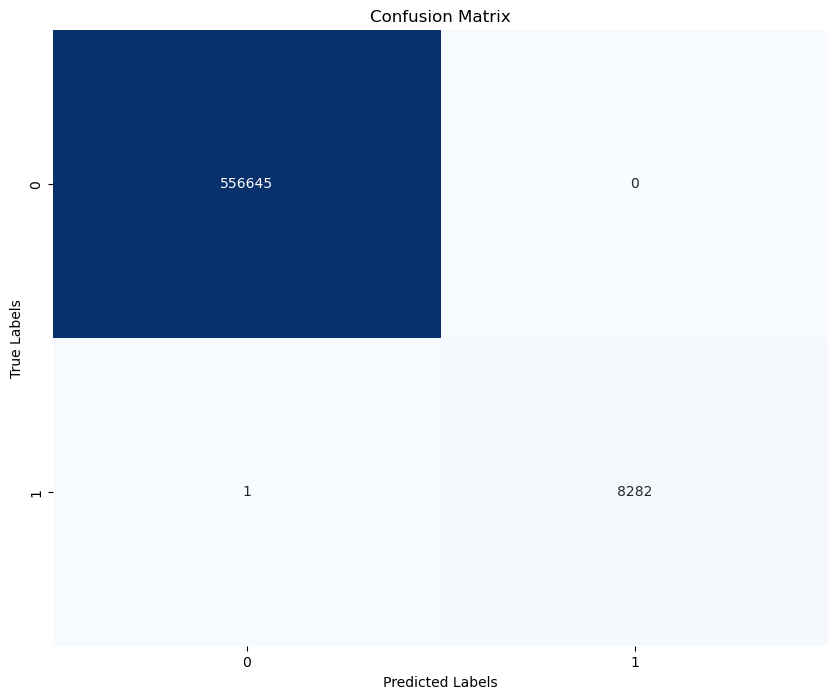

----------------test2-----------------
Accuracy: 0.999997234704459
precesion: 1.0
recall: 0.9997652582159624
fbeta_score: 0.9998826153304379


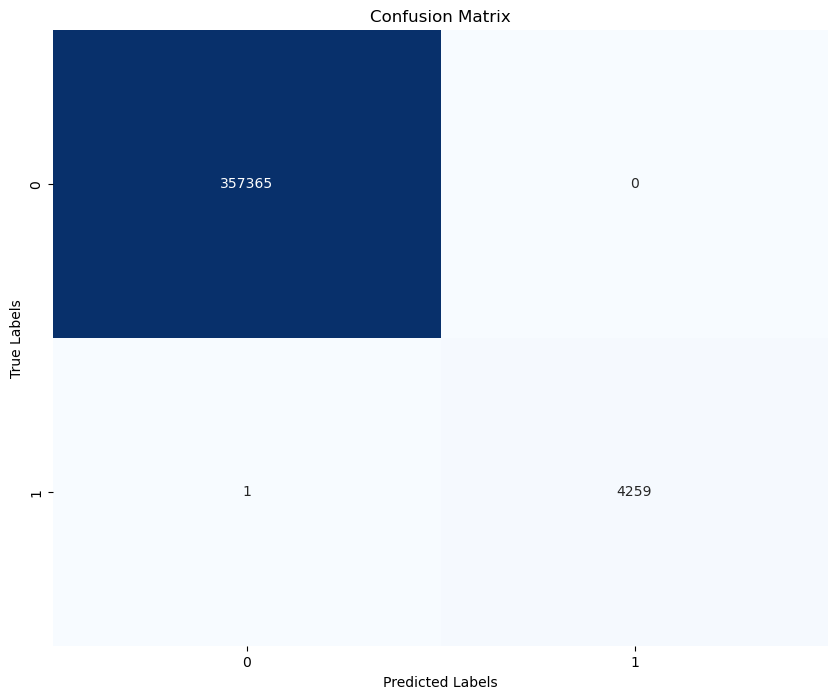

----------------test3-----------------
Accuracy: 0.9999925700117182
precesion: 0.9998130841121495
recall: 0.9988795518207283
fbeta_score: 0.9993460999532929


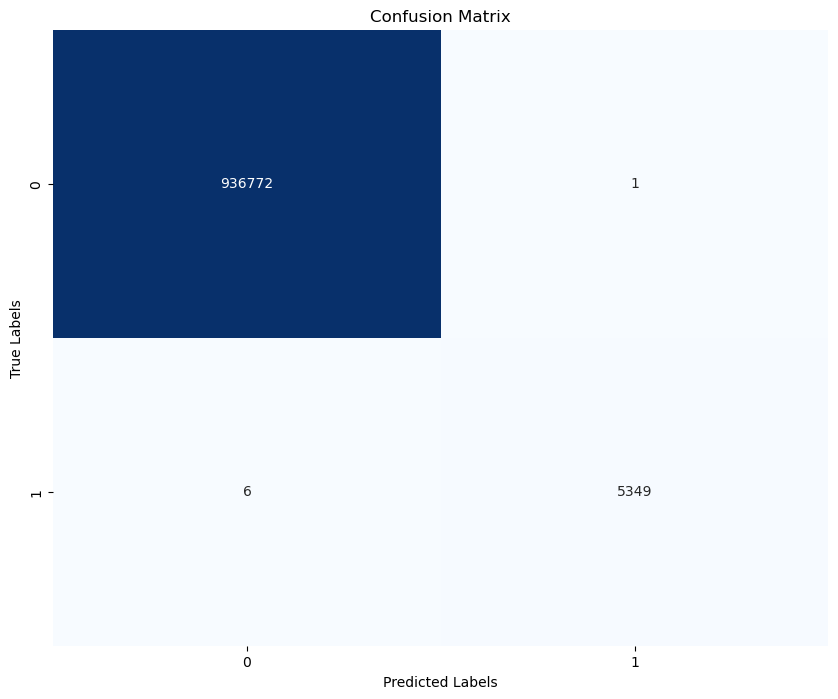

----------------test4-----------------
Accuracy: 0.9998572804795376
precesion: 1.0
recall: 0.9413919413919414
fbeta_score: 0.969811320754717


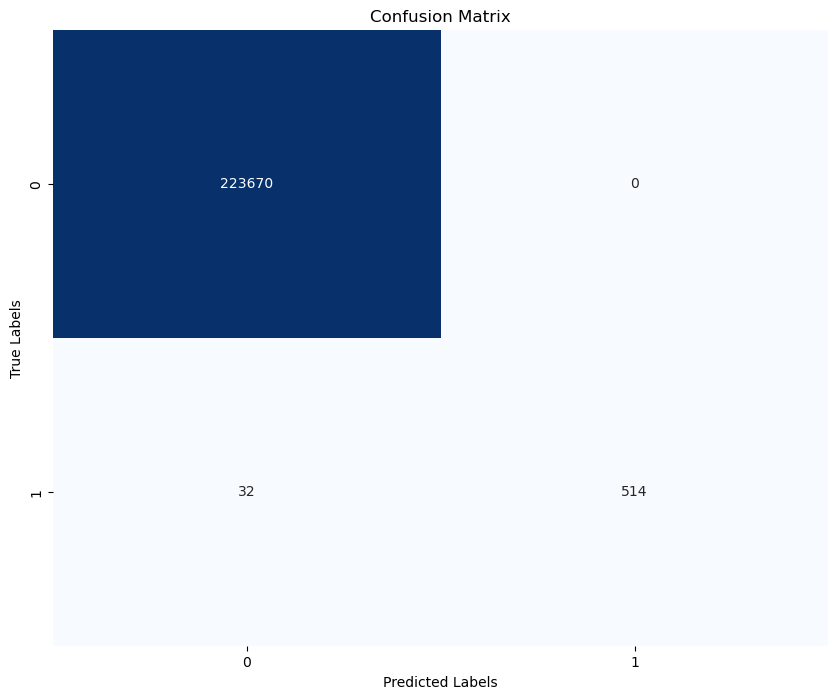

----------------test5-----------------
Accuracy: 0.9999229791658644
precesion: 1.0
recall: 0.9896907216494846
fbeta_score: 0.9948186528497409


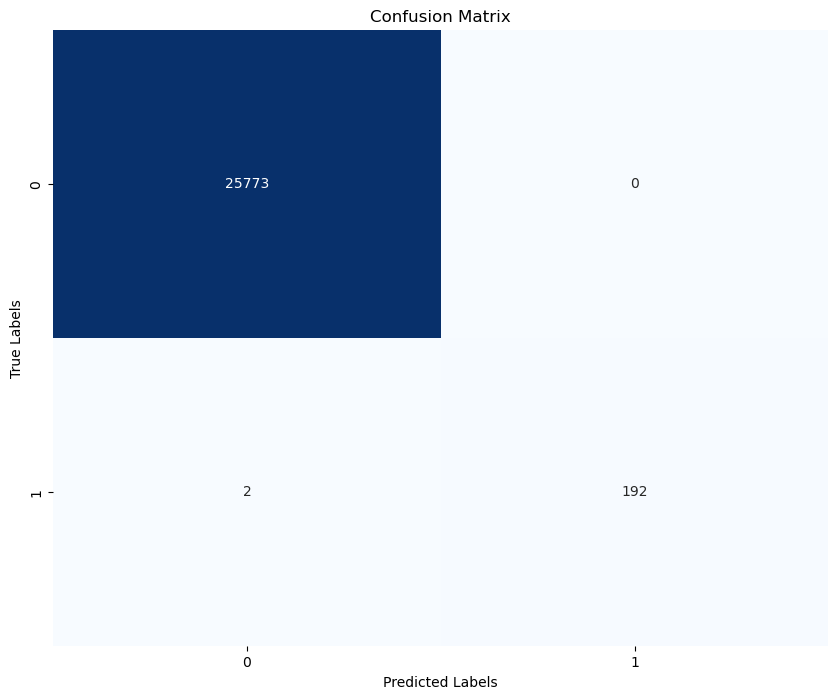

----------------test6-----------------
Accuracy: 0.9999910541759107
precesion: 1.0
recall: 0.9989258861439313
fbeta_score: 0.999462654486835


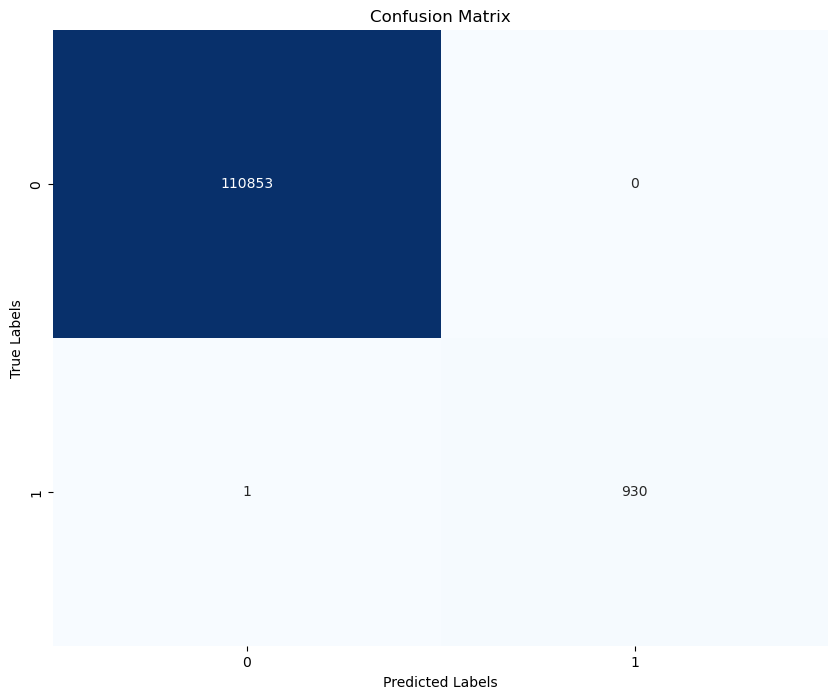

----------------test7-----------------
Accuracy: 0.9999123422159888
precesion: 1.0
recall: 0.875
fbeta_score: 0.9333333333333333


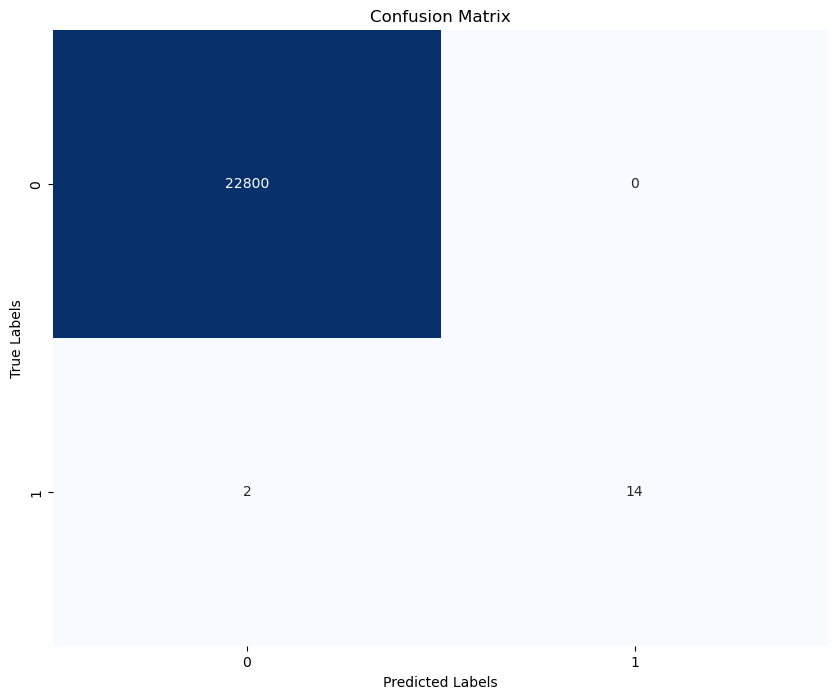

----------------test8-----------------
Accuracy: 0.9999018356729165
precesion: 0.9991438356164384
recall: 0.9534313725490197
fbeta_score: 0.9757525083612041


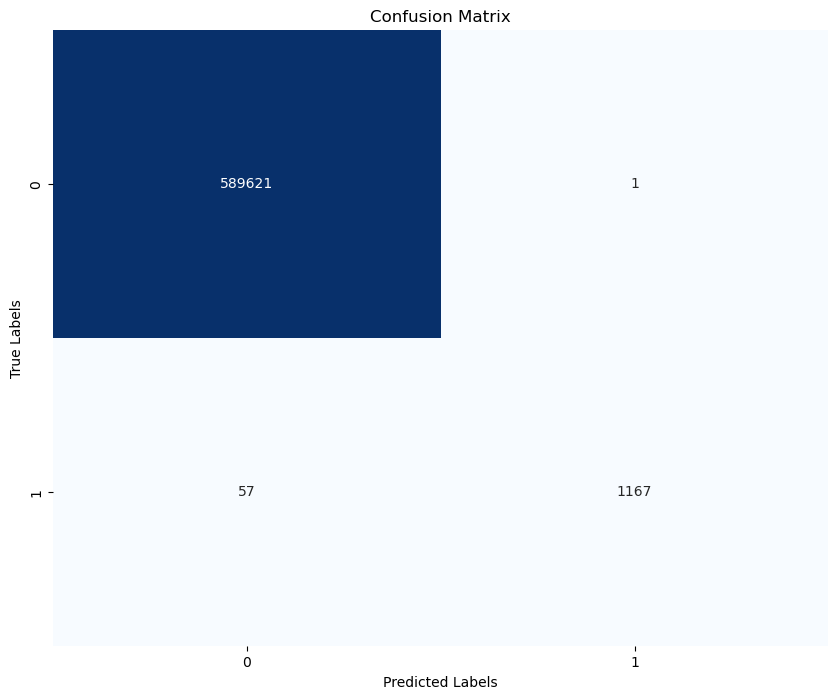

----------------test9-----------------
Accuracy: 0.9999640720283974
precesion: 0.9997835966241073
recall: 0.999810641923878
fbeta_score: 0.9997971190910934


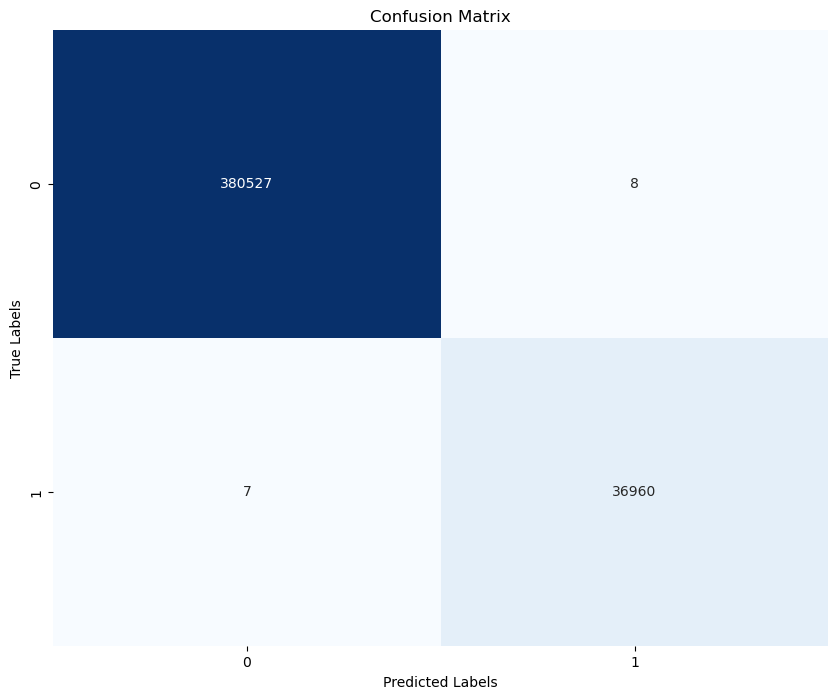

----------------test10-----------------
Accuracy: 0.9999694608698307
precesion: 0.9999059089198344
recall: 0.9997177798682972
fbeta_score: 0.9998118355442658


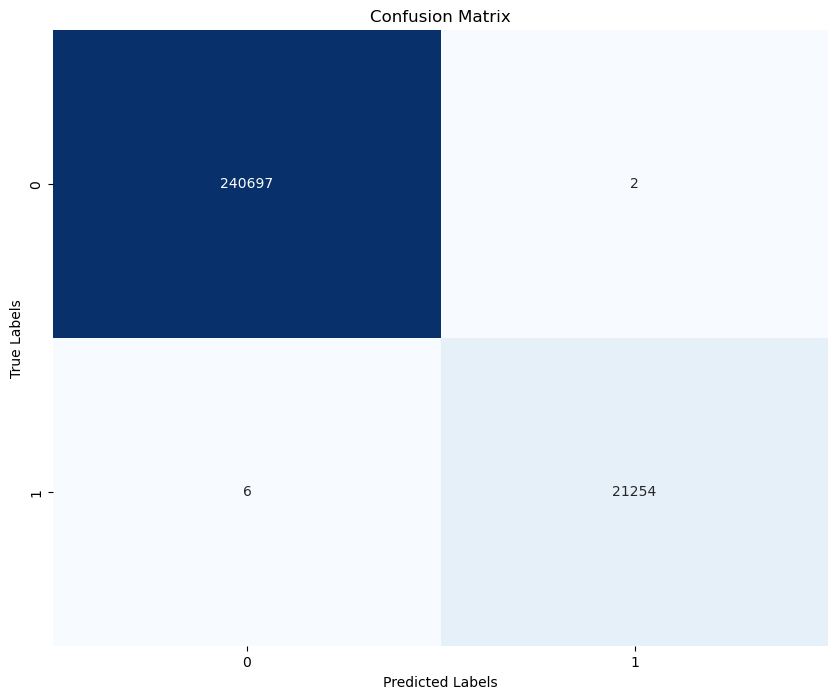

----------------test11-----------------
Accuracy: 1.0
precesion: 1.0
recall: 1.0
fbeta_score: 1.0


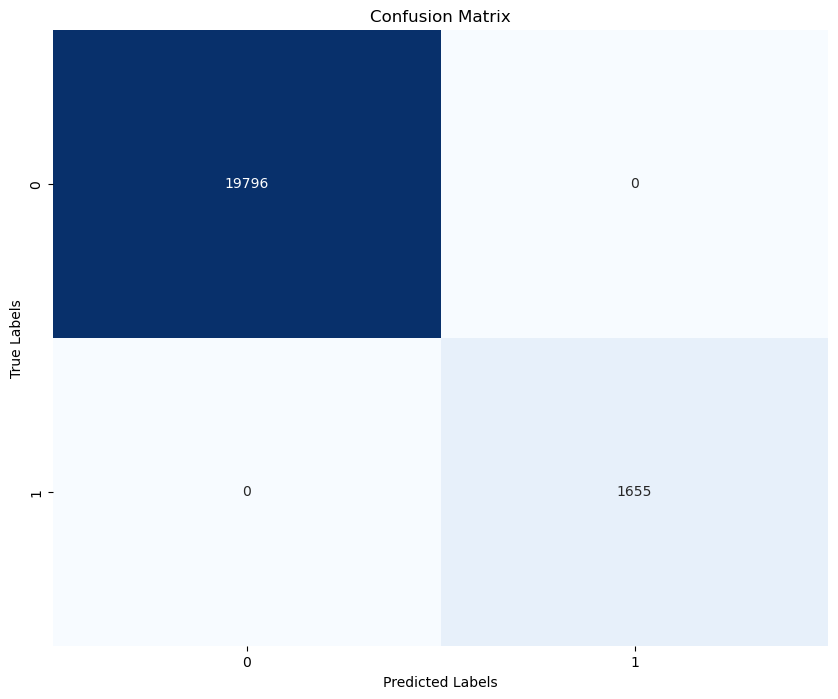

----------------test12-----------------
Accuracy: 0.9997542053921192
precesion: 0.98989898989899
recall: 0.9702970297029703
fbeta_score: 0.98


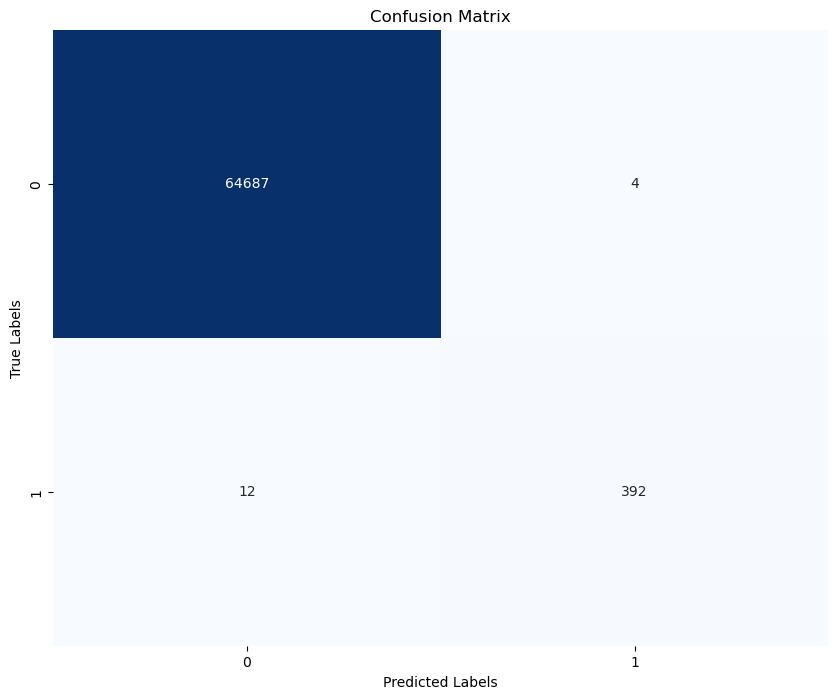

----------------test13-----------------
Accuracy: 0.9999818195984729
precesion: 1.0
recall: 0.999125
fbeta_score: 0.9995623085099732


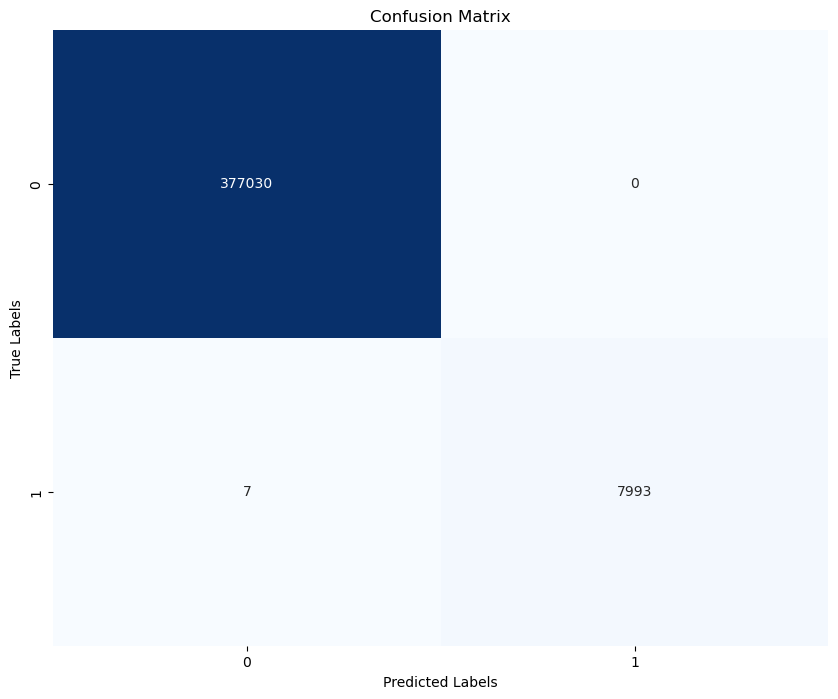

In [14]:
for z in range (1,14):
    new_data = pd.read_csv(f"/home/s2316001/Clean_data/test{z}.csv")
    X_test = new_data.drop(columns=[new_data.columns[0],"Label"], axis=1)
    y_test = new_data['Label']
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision, recall, fbeta_score, support = metrics.precision_recall_fscore_support(y_test, y_pred)
    print(f'----------------test{z}-----------------')
    print(f"Accuracy: {accuracy}")
    print(f"precesion: {precision[1]}")
    print(f"recall: {recall[1]}")
    print(f"fbeta_score: {fbeta_score[1]}")
    matrix = metrics.confusion_matrix(y_test, y_pred)
    #print(matrix)
    # Plot Confusion Matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.savefig(f'/home/s2316001/Ensemble_matrix/ensembleall13into1/conf13_{z}.png')
    plt.show()

# 12 into 1


In [16]:
for z in range (1,14):
    df = pd.DataFrame()
    for k in range (1,14):
        if k != z:
            print(f'---------read{k}------------')
            new_data = pd.read_csv(f'/home/s2316001/Clean_data/train{k}.csv')
            df = pd.concat([df,new_data])
    X_en = df.drop(columns=[df.columns[0],"Label"], axis=1)
    y_en = df['Label']
    model = RandomForestClassifier(n_estimators=100)  # You can adjust the hyperparameters as needed
    model.fit(X_en, y_en)
    filename = f'/home/s2316001/model_rfe/new12/rfe_model12to1no{z}.sav'
    joblib.dump(model, filename)
    print(f'-------done {z}----------')

---------read2------------
---------read3------------
---------read4------------
---------read5------------
---------read6------------
---------read7------------
---------read8------------
---------read9------------
---------read10------------
---------read11------------
---------read12------------
---------read13------------
-------done 1----------
---------read1------------
---------read3------------
---------read4------------
---------read5------------
---------read6------------
---------read7------------
---------read8------------
---------read9------------
---------read10------------
---------read11------------
---------read12------------
---------read13------------
-------done 2----------
---------read1------------
---------read2------------
---------read4------------
---------read5------------
---------read6------------
---------read7------------
---------read8------------
---------read9------------
---------read10------------
---------read11------------
---------read12---------

----------------test1-----------------
Accuracy: 0.9871282529855174
precesion: 0.9997828447339848
recall: 0.11239959961914993
fbeta_score: 0.20208049861739016


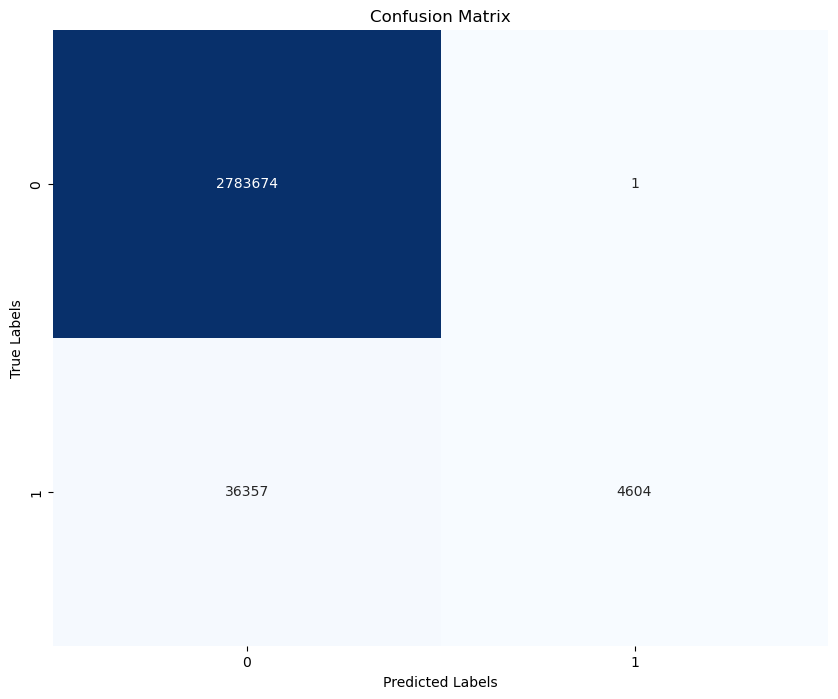

----------------test2-----------------
Accuracy: 0.989084254270453
precesion: 0.9966996699669967
recall: 0.057685879375387994
fbeta_score: 0.10905972103101161


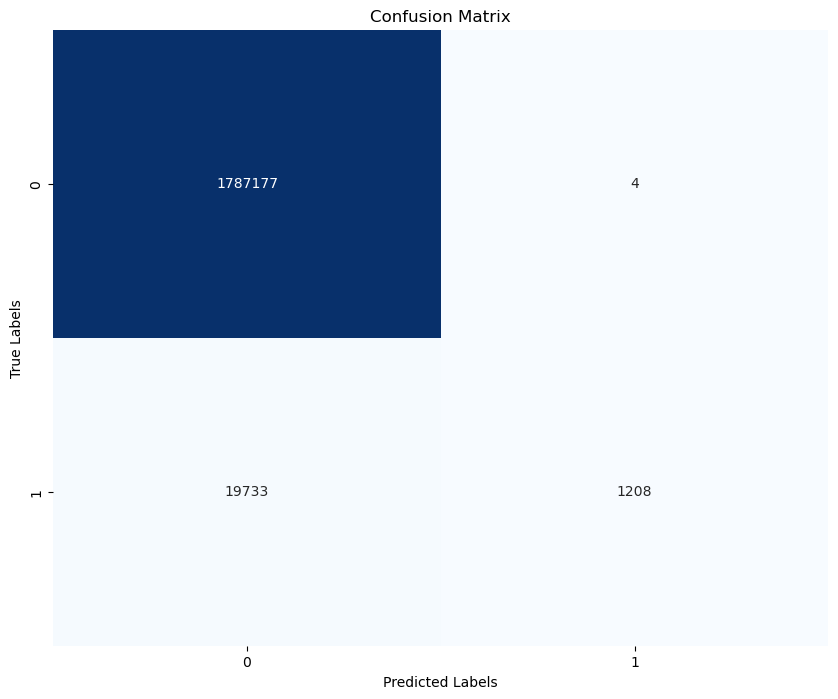

/home/s2316001/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


----------------test3-----------------
Accuracy: 0.9943060791340791
precesion: 0.0
recall: 0.0
fbeta_score: 0.0


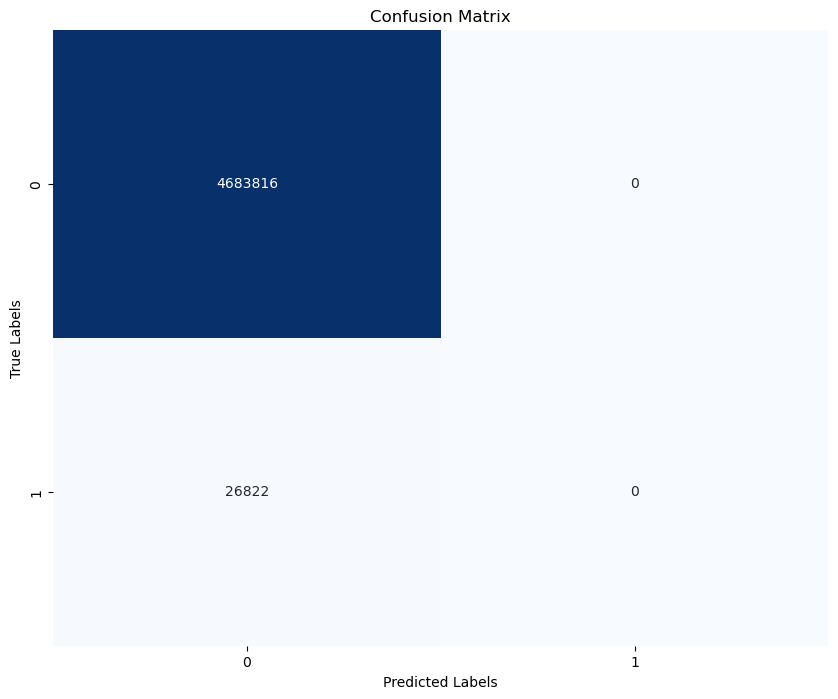

----------------test4-----------------
Accuracy: 0.997696855520946
precesion: 0.0
recall: 0.0
fbeta_score: 0.0


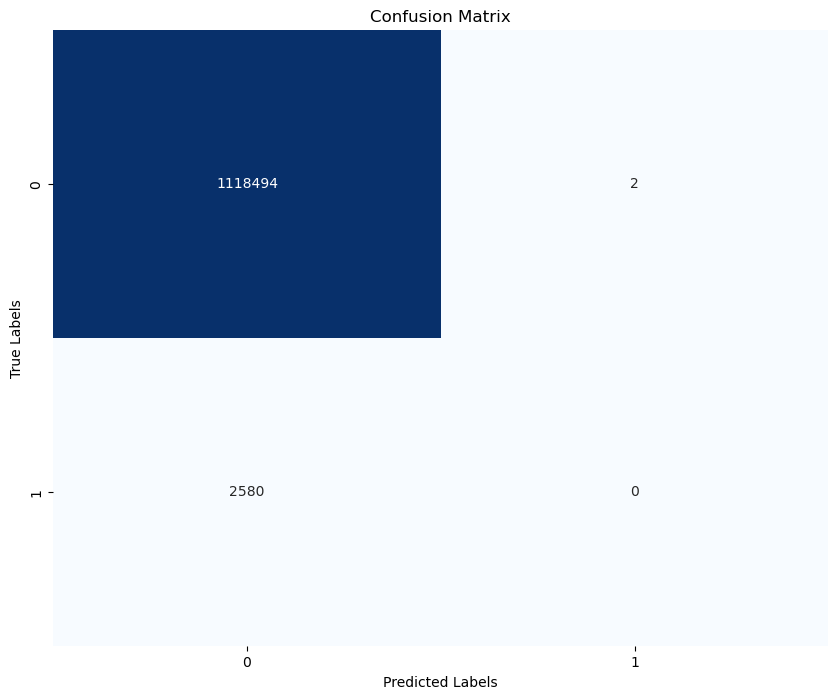

----------------test5-----------------
Accuracy: 0.993060262493068
precesion: 0.0
recall: 0.0
fbeta_score: 0.0


/home/s2316001/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


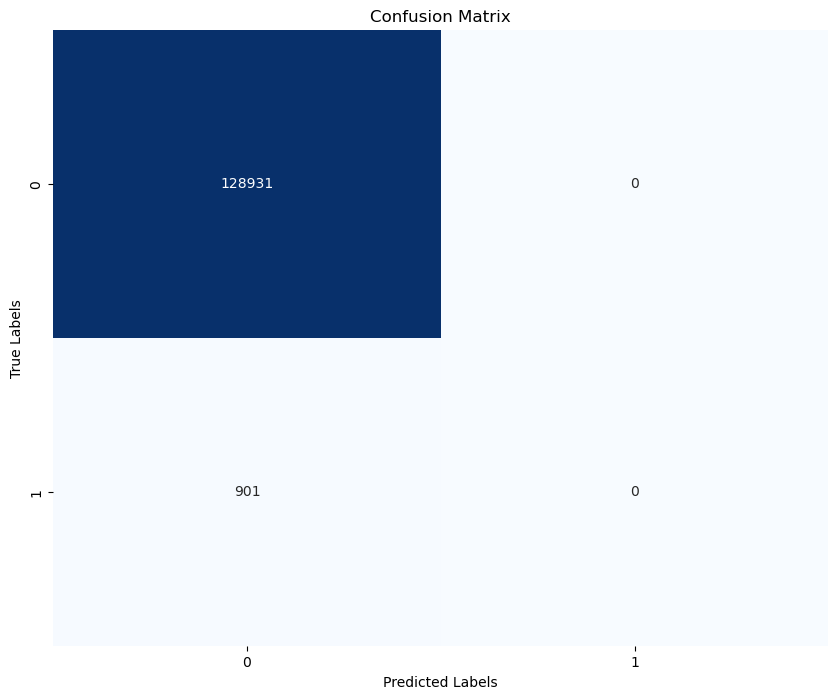

----------------test6-----------------
Accuracy: 0.9917161520721249
precesion: 0.0
recall: 0.0
fbeta_score: 0.0


/home/s2316001/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


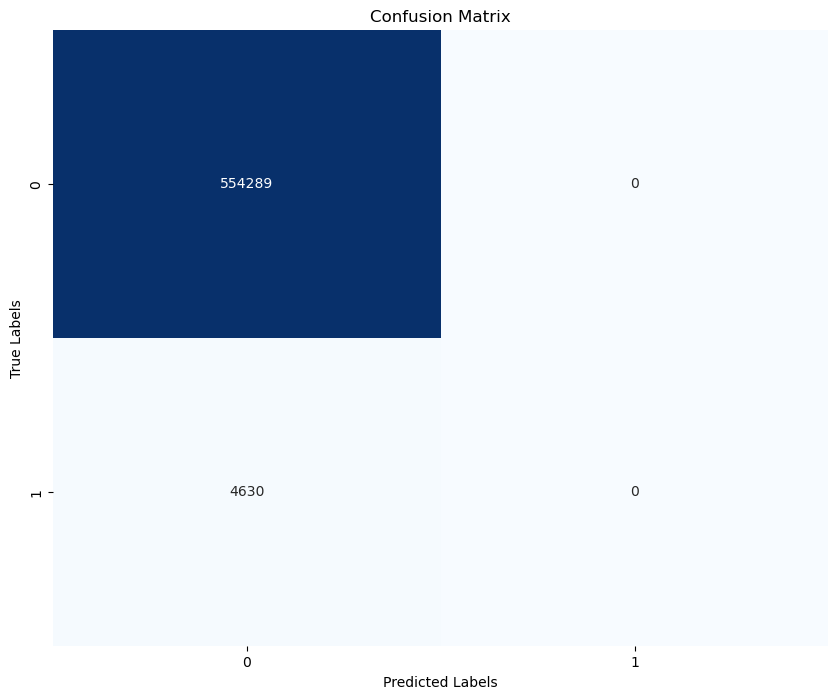

----------------test7-----------------
Accuracy: 0.9994477414378008
precesion: 0.0
recall: 0.0
fbeta_score: 0.0


/home/s2316001/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


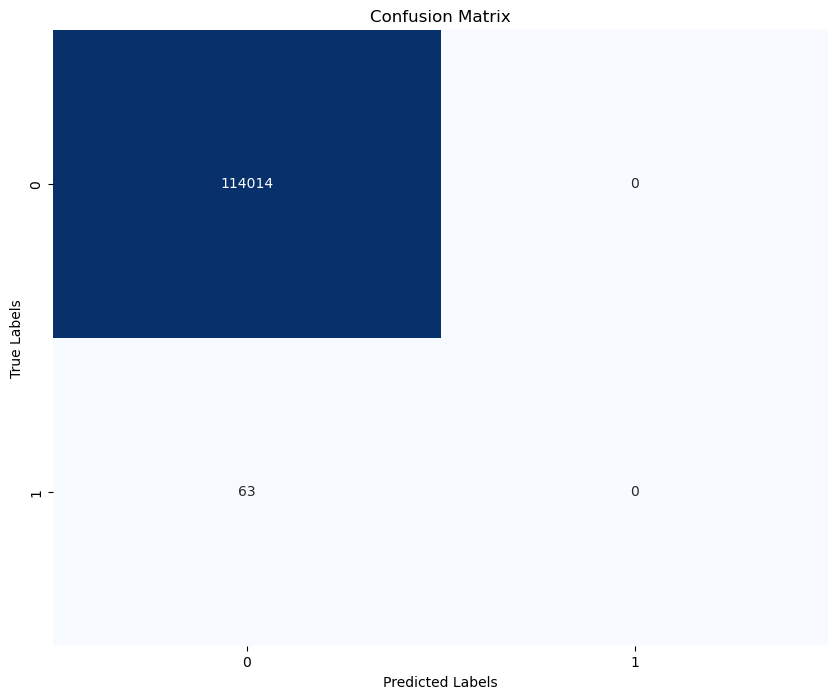

/home/s2316001/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


----------------test8-----------------
Accuracy: 0.9979260247171006
precesion: 0.0
recall: 0.0
fbeta_score: 0.0


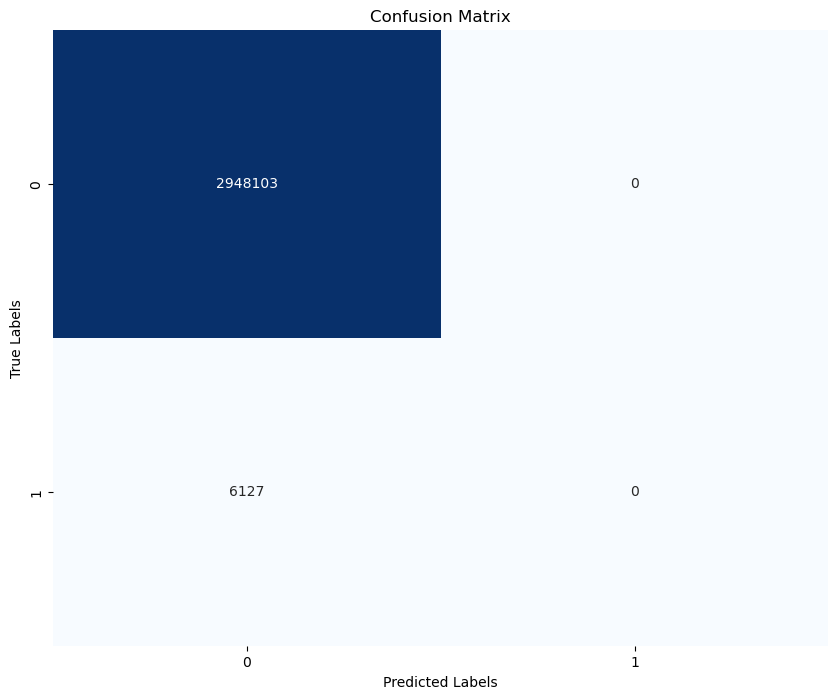

/home/s2316001/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


----------------test9-----------------
Accuracy: 0.9113838126608377
precesion: 0.0
recall: 0.0
fbeta_score: 0.0


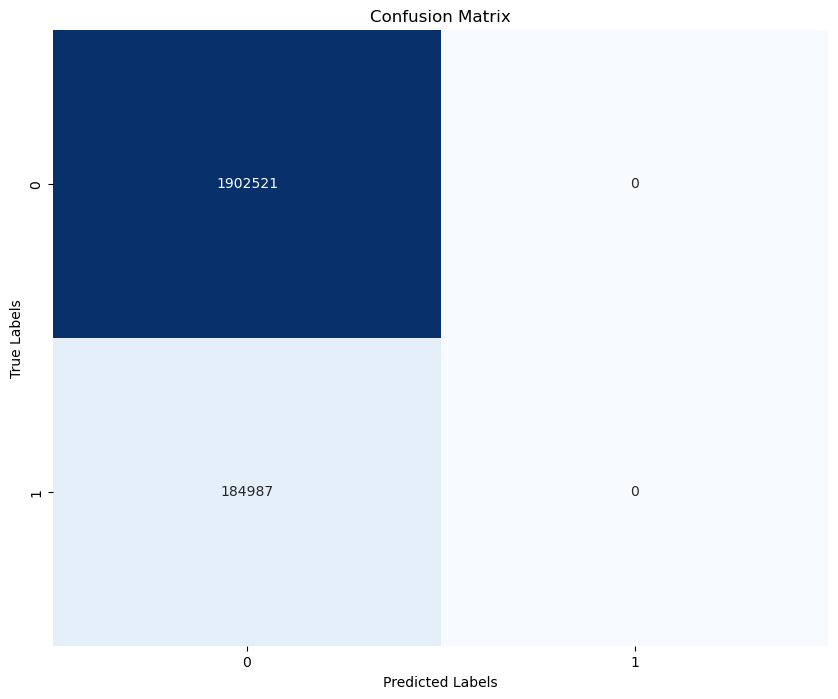

/home/s2316001/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


----------------test10-----------------
Accuracy: 0.9188023127353906
precesion: 0.0
recall: 0.0
fbeta_score: 0.0


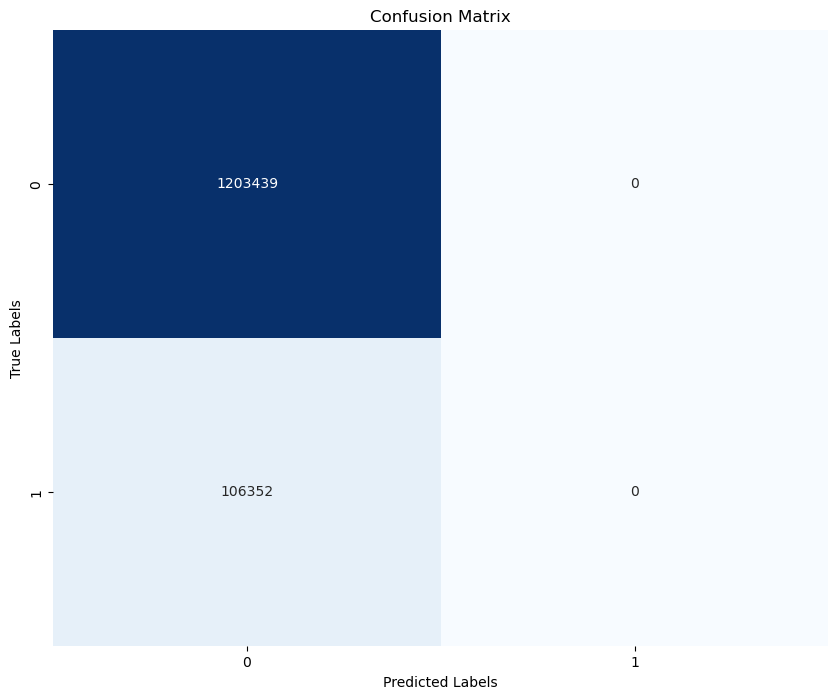

----------------test11-----------------
Accuracy: 0.9238794976270618
precesion: 0.0
recall: 0.0
fbeta_score: 0.0


/home/s2316001/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


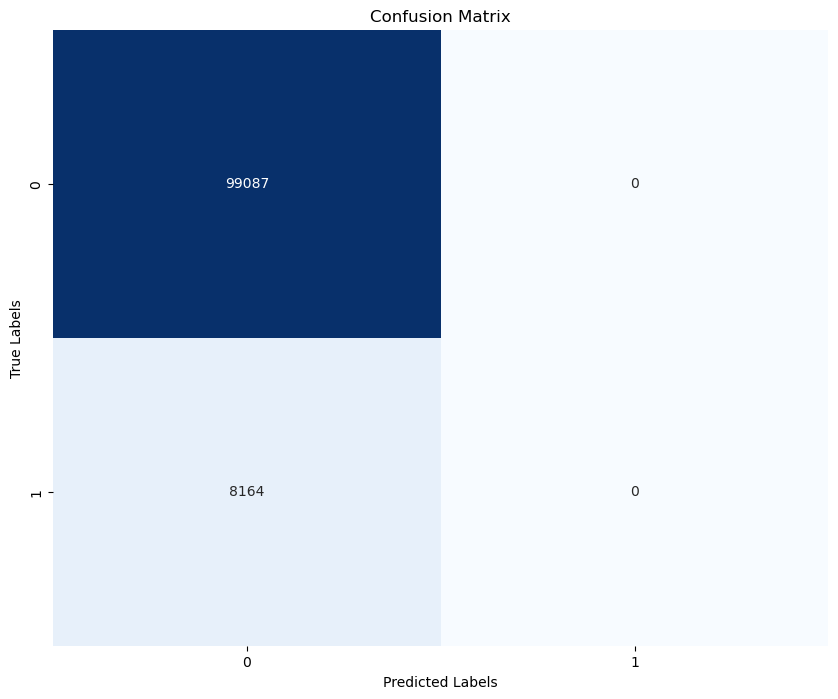

----------------test12-----------------
Accuracy: 0.9933388842631141
precesion: 0.0
recall: 0.0
fbeta_score: 0.0


/home/s2316001/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


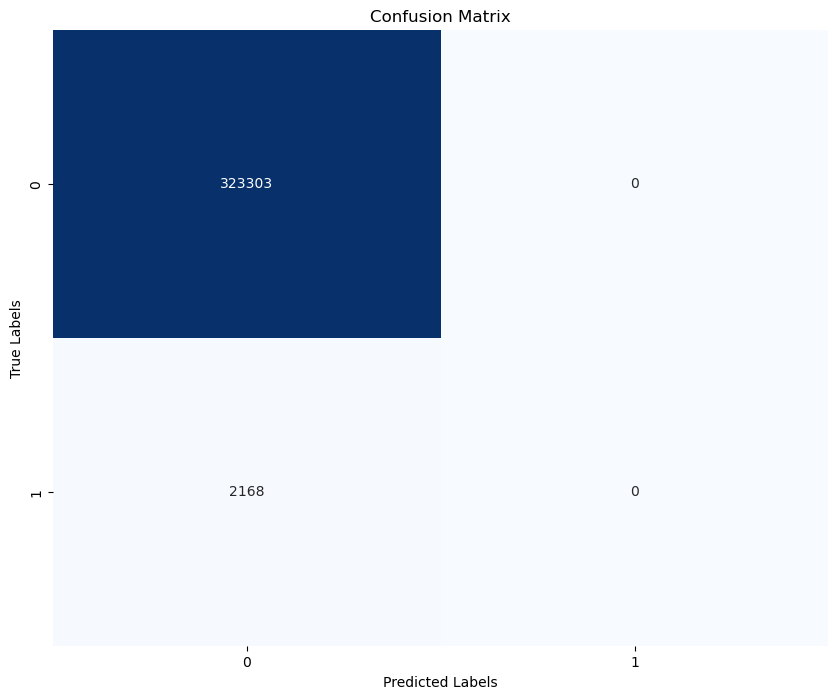

----------------test13-----------------
Accuracy: 0.9792286207457189
precesion: 0.8947368421052632
recall: 0.0004249681273904457
fbeta_score: 0.000849532756983659


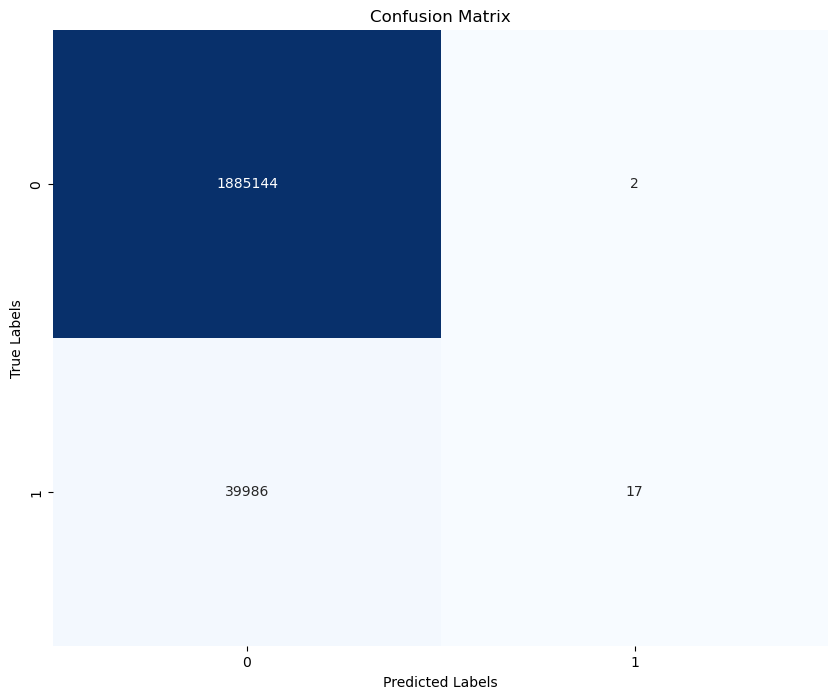

In [17]:
for i in range (1,14):
    new_data = pd.read_csv(f"/home/s2316001/Clean_data/Clean_{i}-XX.csv")
    model_path = f'/home/s2316001/model_rfe/new12/rfe_model12to1no{i}.sav'
    loaded_model = joblib.load(model_path)
    X_en = new_data.drop(columns=[new_data.columns[0],"Label"], axis=1)
    y_en = new_data['Label']
    y_pred = loaded_model.predict(X_en)
    accuracy = accuracy_score(y_en, y_pred)
    precision, recall, fbeta_score, support = metrics.precision_recall_fscore_support(y_en, y_pred)
    print(f'----------------test{i}-----------------')
    print(f"Accuracy: {accuracy}")
    print(f"precesion: {precision[1]}")
    print(f"recall: {recall[1]}")
    print(f"fbeta_score: {fbeta_score[1]}")
    matrix = metrics.confusion_matrix(y_en, y_pred)
    #print(matrix)
    #Plot Confusion Matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.savefig(f'/home/s2316001/Ensemble_matrix/ensembleall13into1/test12_file{i}.png')
    plt.show()

## reduced 0

In [30]:
from imblearn.under_sampling import RandomUnderSampler
import numpy as np
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,shuffle=False)
def undersample(X, y, ratio, random_state=42):
    # Create the RandomUnderSampler object
    undersampler = RandomUnderSampler(sampling_strategy=ratio, random_state=random_state)

    # Perform the undersampling
    X_undersampled, y_undersampled = undersampler.fit_resample(X, y)

    return X_undersampled, y_undersampled

In [32]:
train_temp = pd.read_csv(f'/home/s2316001/Clean_data/Merge13_split/train0.csv')
X_train = df.drop(columns=[df.columns[0],"Label"], axis=1)
y_train = df['Label']

NameError: name 'X' is not defined

In [41]:
X_undersampled, y_undersampled = undersample(X_train, y_train, ratio=0.5, random_state=42)
print("Original dataset shape:", X_train.shape, y_train.shape)
print("Undersampled dataset shape:", X_undersampled.shape, y_undersampled.shape)

Original dataset shape: (15981353, 12) (15981353,)
Undersampled dataset shape: (1067901, 12) (1067901,)


In [42]:
y_undersampled.value_counts()

Label
0.0    711934
1.0    355967
Name: count, dtype: int64

In [43]:
model = RandomForestClassifier(n_estimators=100)  # You can adjust the hyperparameters as needed
model.fit(X_train, y_train)
filename = f'/home/s2316001/model_rfe/rfe_model13to1_reduce1.sav'
joblib.dump(model, filename)

KeyboardInterrupt: 

### ratio 0.2

----------------test1-----------------
Accuracy: 0.9999988199072211
precesion: 1.0
recall: 0.9999177157903398
fbeta_score: 0.9999588562024275


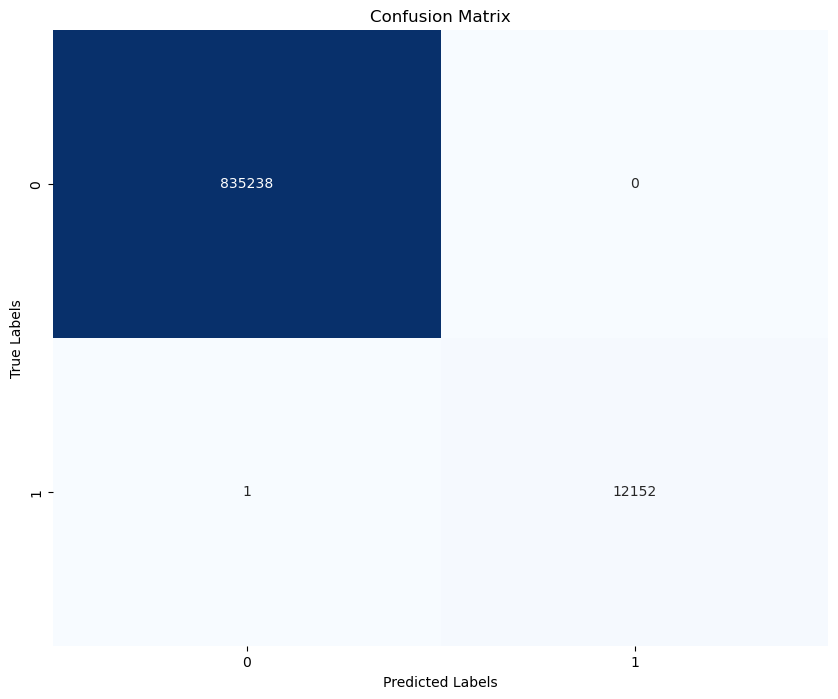

----------------test2-----------------
Accuracy: 0.9999981564679401
precesion: 1.0
recall: 0.9998424700693131
fbeta_score: 0.9999212288302481


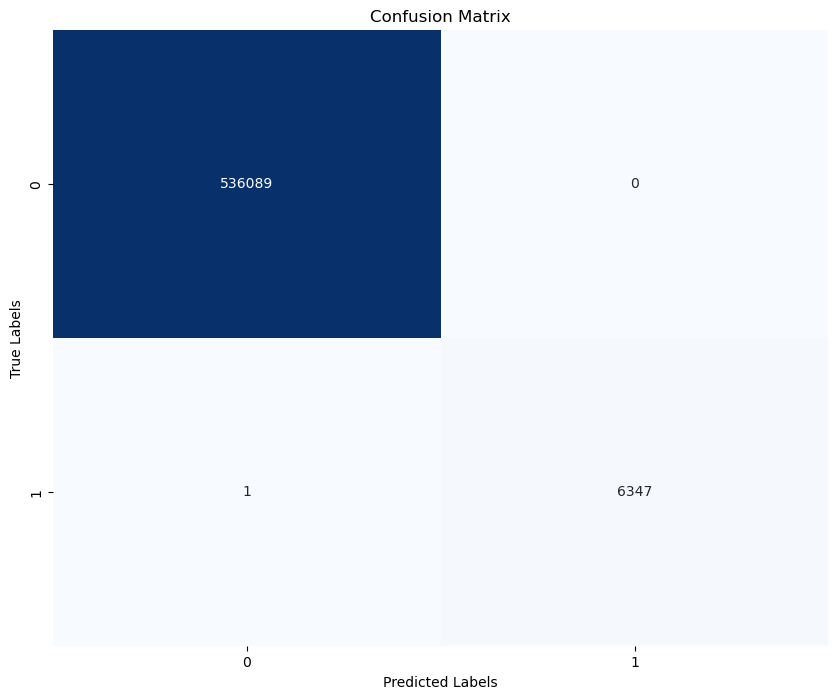

----------------test3-----------------
Accuracy: 0.9999978771462051
precesion: 1.0
recall: 0.999629263470094
fbeta_score: 0.9998145973672827


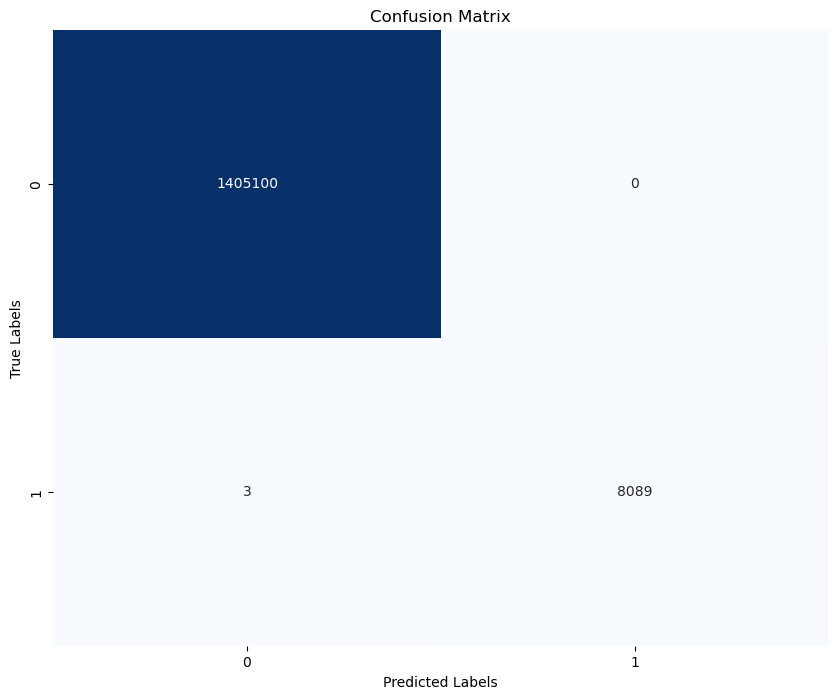

----------------test4-----------------
Accuracy: 0.9999851333390818
precesion: 1.0
recall: 0.9934980494148244
fbeta_score: 0.9967384213959556


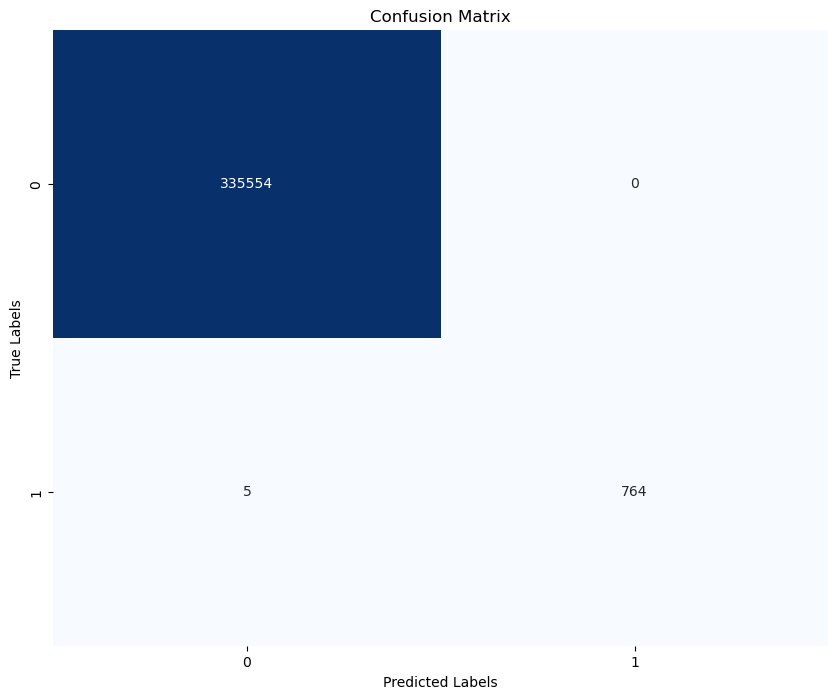

----------------test5-----------------
Accuracy: 0.9999486521181001
precesion: 1.0
recall: 0.9925650557620818
fbeta_score: 0.9962686567164178


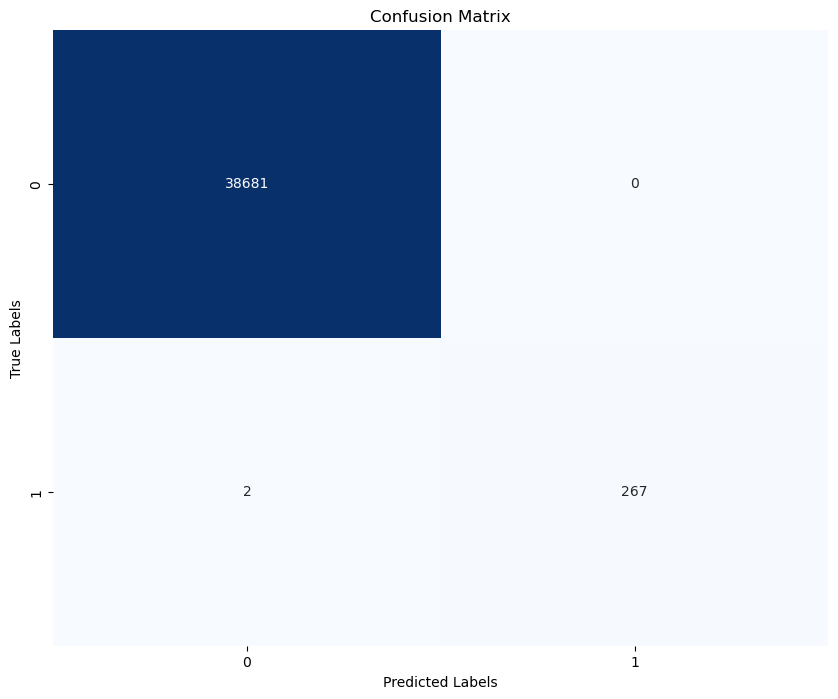

----------------test6-----------------
Accuracy: 1.0
precesion: 1.0
recall: 1.0
fbeta_score: 1.0


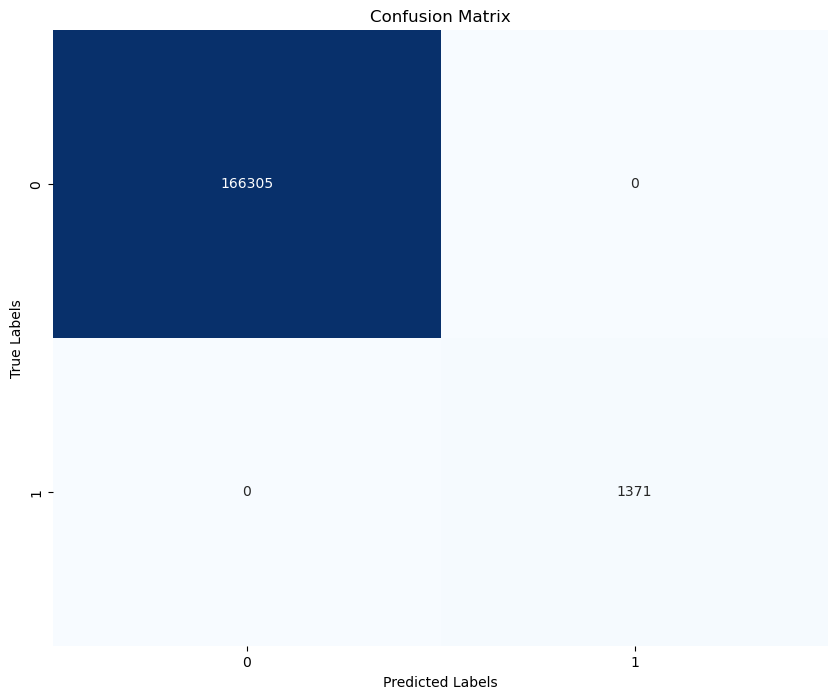

----------------test7-----------------
Accuracy: 0.9999415614773258
precesion: 1.0
recall: 0.8947368421052632
fbeta_score: 0.9444444444444444


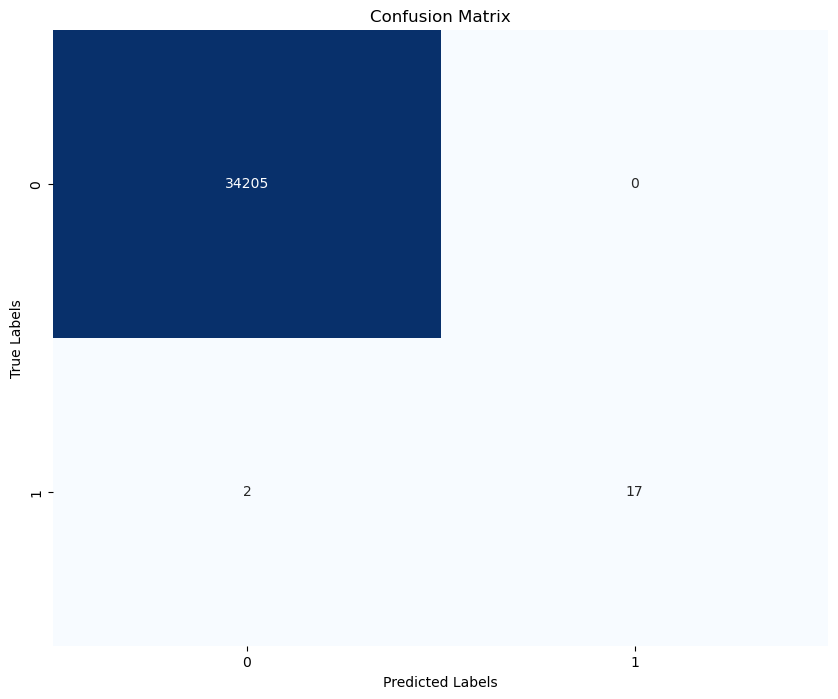

----------------test8-----------------
Accuracy: 0.9999706635344348
precesion: 1.0
recall: 0.985800109229929
fbeta_score: 0.9928492849284929


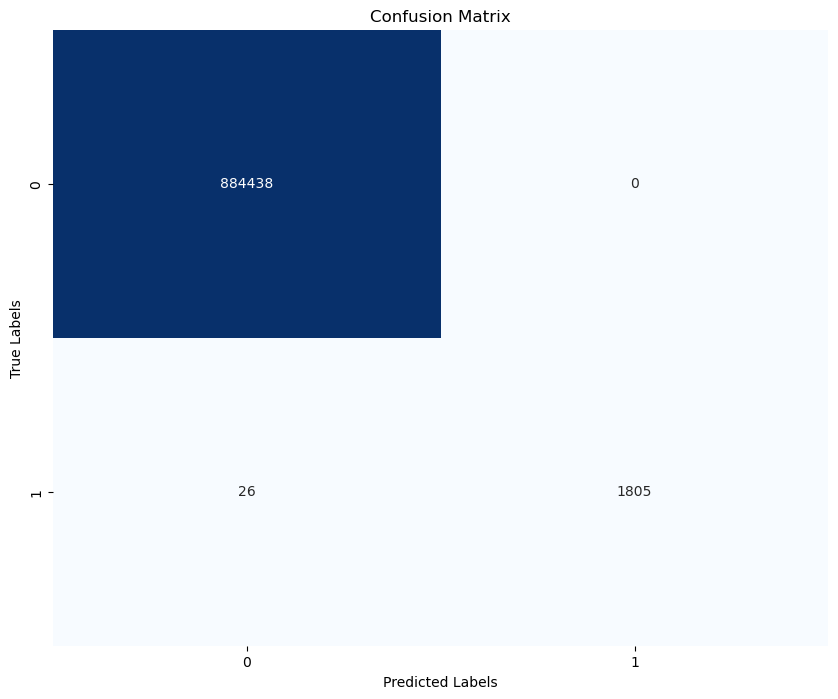

----------------test9-----------------
Accuracy: 0.999985628811359
precesion: 0.9999277365273789
recall: 0.999909672291072
fbeta_score: 0.9999187043276396


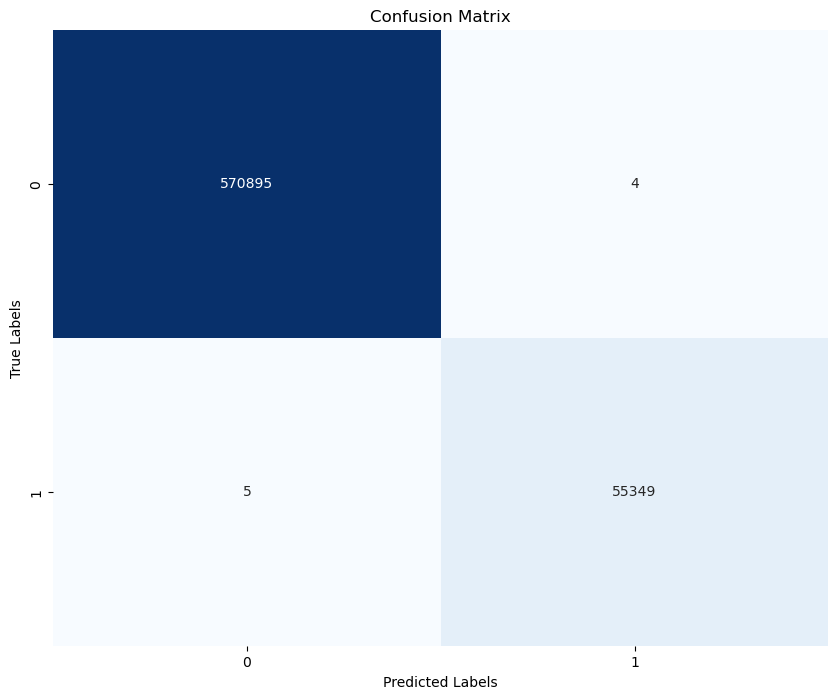

----------------test10-----------------
Accuracy: 0.9999796405539805
precesion: 0.9999685880320403
recall: 0.999780157658365
fbeta_score: 0.9998743639675859


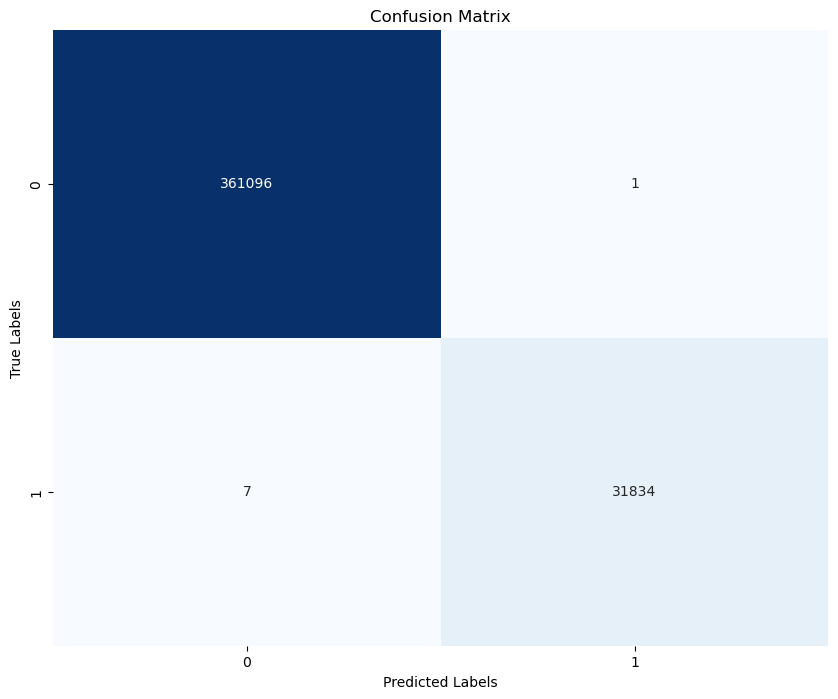

----------------test11-----------------
Accuracy: 1.0
precesion: 1.0
recall: 1.0
fbeta_score: 1.0


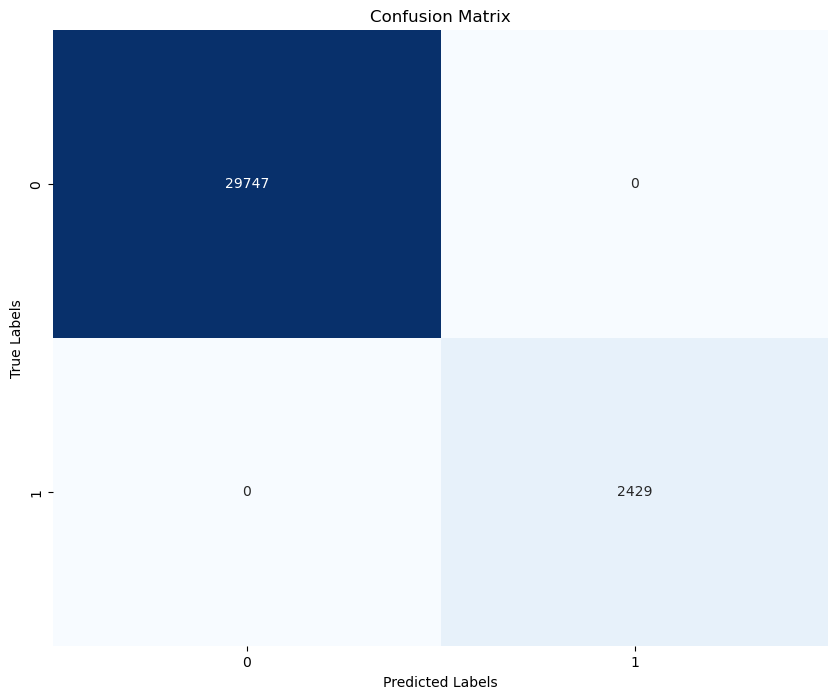

----------------test12-----------------
Accuracy: 0.9998668605722947
precesion: 0.9984076433121019
recall: 0.9812206572769953
fbeta_score: 0.98973954222573


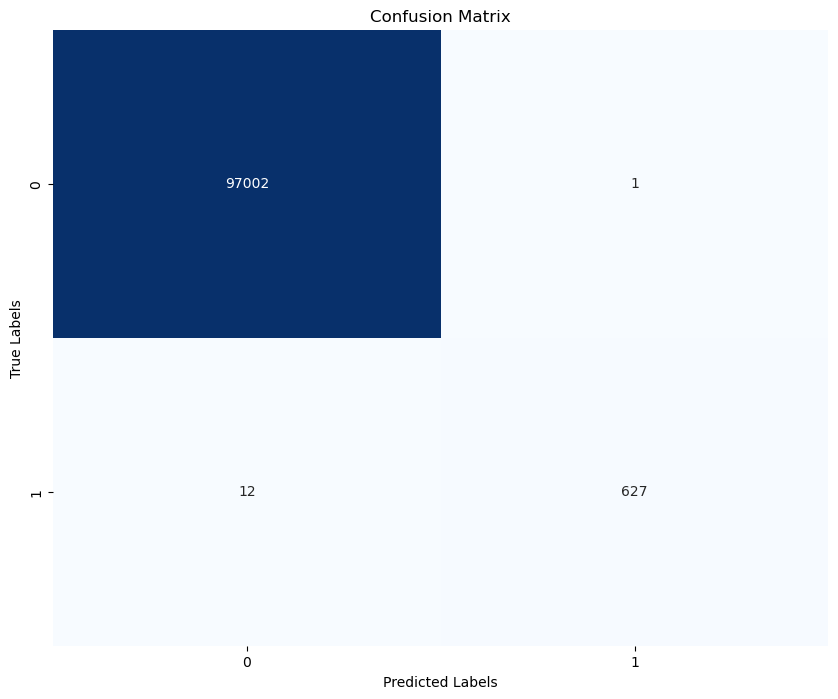

----------------test13-----------------
Accuracy: 0.9999913426659395
precesion: 1.0
recall: 0.9995814848916046
fbeta_score: 0.9997906986479133


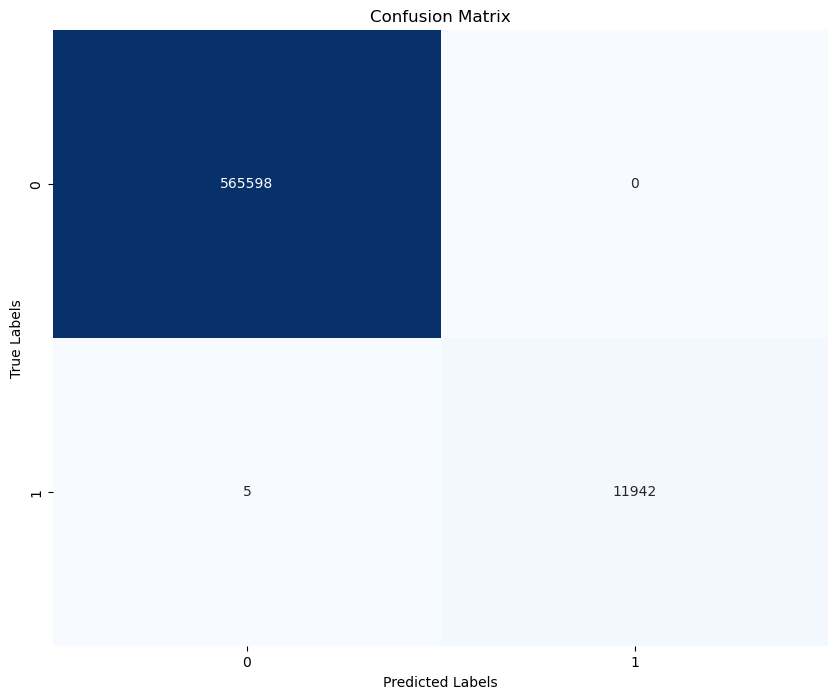

In [40]:
for i in range (1,14):
    new_data = pd.read_csv(f'/home/s2316001/Clean_data/Merge13_split/file{i}/test0.csv')
    X_en = new_data.drop(columns=[new_data.columns[0],"Label"], axis=1)
    y_en = new_data['Label']
    y_pred = model.predict(X_en)
    accuracy = accuracy_score(y_en, y_pred)
    precision, recall, fbeta_score, support = metrics.precision_recall_fscore_support(y_en, y_pred)
    print(f'----------------test{i}-----------------')
    print(f"Accuracy: {accuracy}")
    print(f"precesion: {precision[1]}")
    print(f"recall: {recall[1]}")
    print(f"fbeta_score: {fbeta_score[1]}")
    matrix = metrics.confusion_matrix(y_en, y_pred)
    #print(matrix)
    # Plot Confusion Matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.savefig(f'/home/s2316001/Ensemble_matrix/ensembleall13into1/test_each_reduce0_{i}.png')
    plt.show()

### ratio 0.5

In [ ]:
for i in range (1,14):
    new_data = pd.read_csv(f'/home/s2316001/Clean_data/Merge13_split/file{i}/test0.csv')
    X_en = new_data.drop(columns=[new_data.columns[0],"Label"], axis=1)
    y_en = new_data['Label']
    y_pred = model.predict(X_en)
    accuracy = accuracy_score(y_en, y_pred)
    precision, recall, fbeta_score, support = metrics.precision_recall_fscore_support(y_en, y_pred)
    print(f'----------------test{i}-----------------')
    print(f"Accuracy: {accuracy}")
    print(f"precesion: {precision[1]}")
    print(f"recall: {recall[1]}")
    print(f"fbeta_score: {fbeta_score[1]}")
    matrix = metrics.confusion_matrix(y_en, y_pred)
    #print(matrix)
    # Plot Confusion Matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.savefig(f'/home/s2316001/Ensemble_matrix/ensembleall13into1/test_each_reduce0.5_{i}.png')
    plt.show()